#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 불균형 데이터 분류

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 </a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 한 클래스의 예시의 수가 다른 클래스보다 훨씬 많은 매우 불균형적인 데이터세트를 분류하는 방법을 소개합니다. Kaggle에서 호스팅되는 [신용 카드 부정 행위 탐지](https://www.kaggle.com/mlg-ulb/creditcardfraud) 데이터세트를 사용하여 작업해 보겠습니다. 총 284,807건의 거래에서 492건의 부정 거래를 탐지하는 것을 목표로 합니다. [Keras](https://www.tensorflow.org/guide/keras/overview)를 사용하여 모델 및 [클래스 가중치](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model)를 정의하여 불균형 데이터에서 모델을 학습시켜 보겠습니다.

이 튜토리얼에는 다음을 수행하기 위한 완전한 코드가 포함되어 있습니다.

- Pandas를 사용하여 CSV 파일 로드.
- 학습, 검증 및 테스트세트 작성.
- Keras를 사용하여 모델을 정의하고 학습(클래스 가중치 설정 포함)
- 다양한 측정 기준(정밀도 및 재현율 포함)을 사용하여 모델 평가
- 다음과 같은 불균형 데이터를 처리하기 위한 일반적인 기술 사용
    - 클래스 가중치
    - 오버샘플링


## 설정

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2022-12-14 22:49:51.125111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:49:51.125206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:49:51.125215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 데이터 처리 및 탐색

### Kaggle 신용 카드 부정 행위 데이터 세트

Pandas는 구조적 데이터를 로드하고 처리하는 데 유용한 여러 유틸리티가 포함된 Python 라이브러리입니다. CSV를 Pandas [데이터 프레임](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame)으로 다운로드하는 데 사용할 수 있습니다.

참고: 이 데이터세트는 빅데이터 마이닝 및 부정 행위 감지에 대한 Worldline과 ULB(Université Libre de Bruxelles) [Machine Learning Group](http://mlg.ulb.ac.be)의 연구 협업을 통해 수집 및 분석되었습니다. 관련 주제에 관한 현재 및 과거 프로젝트에 대한 자세한 내용은 [여기](https://www.researchgate.net/project/Fraud-detection-5)를 참조하거나 [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) 프로젝트 페이지에서 확인할 수 있습니다.

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 클래스 레이블 불균형 검사

데이터세트 불균형을 살펴보겠습니다.:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



이를 통해 양성 샘플 일부를 확인할 수 있습니다.

### 데이터 정리, 분할 및 정규화

원시 데이터에는 몇 가지 문제가 있습니다. 먼저 `Time` 및 `Amount` 열이 매우 가변적이므로 직접 사용할 수 없습니다. (의미가 명확하지 않으므로) `Time` 열을 삭제하고 `Amount` 열의 로그를 가져와 범위를 줄입니다.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

데이터세트를 학습, 검증 및 테스트 세트로 분할합니다. 검증 세트는 모델 피팅 중에 사용되어 손실 및 메트릭을 평가하지만 해당 모델은 이 데이터에 적합하지 않습니다. 테스트 세트는 훈련 단계에서는 전혀 사용되지 않으며 마지막에만 사용되어 모델이 새 데이터로 일반화되는 정도를 평가합니다. 이는 훈련 데이터가 부족하여 [과대적합](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting)이 크게 문제가 되는 불균형 데이터세트에서 특히 중요합니다.

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

sklearn StandardScaler를 사용하여 입력 특성을 정규화하면 평균은 0으로, 표준 편차는 1로 설정됩니다.

참고: `StandardScaler`는 모델이 유효성 검사 또는 테스트 세트를 참고하는지 여부를 확인하기 위해 `train_features`를 사용하는 경우에만 적합합니다. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


주의: 모델을 배포하려면 전처리 계산을 유지하는 것이 중요합니다. 따라서 레이어로 구현하고 내보내기 전에 모델에 연결하는 것이 가장 쉬운 방법입니다.


### 데이터 분포 살펴보기

다음으로 몇 가지 특성에 대한 양 및 음의 예시 분포를 비교해 보겠습니다. 이 때 스스로 검토할 사항은 다음과 같습니다.

- 이와 같은 분포가 합리적인가?
    - 예, 이미 입력을 정규화했으며 대부분 `+/- 2` 범위에 집중되어 있습니다.
- 분포 간 차이를 알 수 있습니까?
    - 예, 양의 예에는 극단적 값의 비율이 훨씬 높습니다.

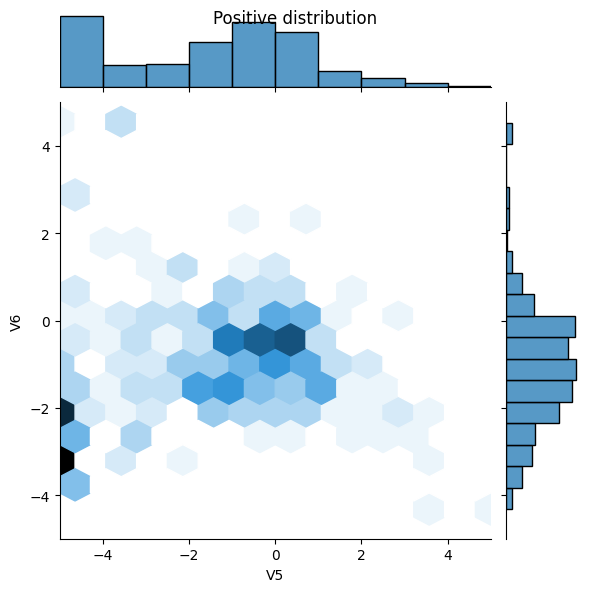

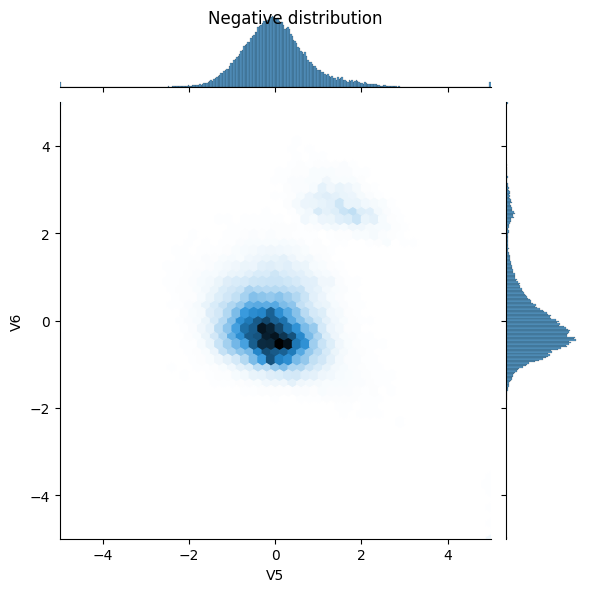

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## 모델 및 메트릭 정의

조밀하게 연결된 숨겨진 레이어, 과대적합을 줄이기 위한 [드롭아웃](https://developers.google.com/machine-learning/glossary/#dropout_regularization) 레이어, 거래 사기 가능성을 반환하는 시그모이드 출력 레이어로 간단한 신경망을 생성하는 함수를 정의합니다. 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### 유용한 메트릭 이해하기

위에서 정의한 몇 가지 메트릭은 모델을 통해 계산할 수 있으며 성능을 평가할 때 유용합니다.

- **허위** 음성과 **허위** 양성은 **잘못** 분류된 샘플입니다.
- **실제** 음성과 **실제** 양성은 **올바로** 분류된 샘플입니다.
- **정확도**는 올바로 분류된 예의 비율입니다.

> $\frac{\text{true samples}}{\text{total samples}}$

- **정밀도**는 올바르게 분류된 **예측** 양성의 비율입니다.

> $\frac{\text{true positives}}{\text{true positives + false positives}}$

- **재현율**은 올바르게 분류된 **실제** 양성의 비율입니다.

> $\frac{\text{true positives}}{\text{true positives + false negatives}}$

- **AUC**는 ROC-AUC(Area Under the Curve of a Receiver Operating Characteristic) 곡선을 의미합니다. 이 메트릭은 분류자가 임의의 양성 샘플 순위를 임의의 음성 샘플 순위보다 높게 지정할 확률과 같습니다.
- **AUPRC**는 PR curve AUC를 의미합니다. 이 메트릭은 다양한 확률 임계값에 대한 정밀도-재현율 쌍을 계산합니다.

참고: 정확도는 이 작업에 유용한 메트릭이 아닙니다. 항상 False를 예측해야 이 작업에서 99.8% 이상의 정확도를 얻을 수 있습니다.

더 읽어보기:

- [참 vs. 거짓, 양성 vs. 음성](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
- [정확성](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
- [정밀도와 재현율](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- [Precision-Recall과 ROC 곡선의 관계](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## 기준 모델

### 모델 구축

이제 앞서 정의한 함수를 사용하여 모델을 만들고 학습해 보겠습니다. 모델은 기본 배치 크기인 2048보다 큰 배치 크기를 사용하는 것이 좋습니다. 각 배치에서 양성 샘플을 일부 포함시켜 적절한 기회를 얻는 것이 중요합니다. 배치 크기가 너무 작으면 부정 거래 예시를 제대로 학습할 수 없습니다.

참고: 이 모델은 클래스의 불균형을 잘 다루지 못합니다. 이를 이 튜토리얼의 뒷부분에서 개선하게 될 겁니다.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                480       


 dropout (Dropout)           (None, 16)                0         


 dense_1 (Dense)             (None, 1)                 17        


Total params: 497


Trainable params: 497


Non-trainable params: 0


_________________________________________________________________


모델을 실행하여 테스트해보겠습니다.

In [14]:
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 409ms/step


array([[0.31587434],
       [0.22539072],
       [0.68509597],
       [0.19135255],
       [0.46167344],
       [0.70078653],
       [0.40190262],
       [0.2730636 ],
       [0.7196849 ],
       [0.30625975]], dtype=float32)

### 선택사항: 초기 바이어스를 올바로 설정합니다.

이와 같은 초기 추측은 적절하지 않습니다. 데이터세트가 불균형하다는 것을 알고 있으니까요. 출력 레이어의 바이어스를 설정하여 해당 데이터세트를 반영하면(참조: [신경망 훈련 방법: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)) 초기 수렴에 유용할 수 있습니다.

기본 바이어스 초기화를 사용하면 손실은 약 `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7212


올바른 바이어스 설정은 다음에서 가능합니다.

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$ $$ b_0 = -log_e(1/p_0 - 1) $$ $$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

이를 초기 바이어스로 설정하면 모델은 훨씬 더 합리적으로 초기 추측을 할 수 있습니다.

`pos/total = 0.0018`에 가까울 것입니다.

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 48ms/step


array([[0.00121839],
       [0.00060421],
       [0.0047377 ],
       [0.00021598],
       [0.00130969],
       [0.00171389],
       [0.00158324],
       [0.00084963],
       [0.0011057 ],
       [0.00022113]], dtype=float32)

이 초기화를 통해서 초기 손실은 대략 다음과 같아야합니다.:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0141


이 초기 손실은 단순한 상태의 초기화에서 발생했을 때 보다 약 50배 적습니다.

이런 식으로 모델은 처음 몇 epoch를 쓰며 양성 예시가 거의 없다는 것을 학습할 필요는 없습니다. 이렇게 하면 학습을 하면서 손실된 플롯을 더 쉽게 파악할 수 있습니다.

### 초기 가중치 체크 포인트

다양한 학습 과정을 비교하려면 이 초기 모델의 가중치를 체크포인트 파일에 보관하고 학습 전에 각 모델에 로드합니다.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### 바이어스 수정이 도움이 되는지 확인하기

계속 진행하기 전에 조심스러운 바이어스 초기화가 실제로 도움이 되었는지 빠르게 확인하십시오

정교한 초기화를 한 모델과 하지 않은 모델을 20 epoch 학습시키고 손실을 비교합니다. 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

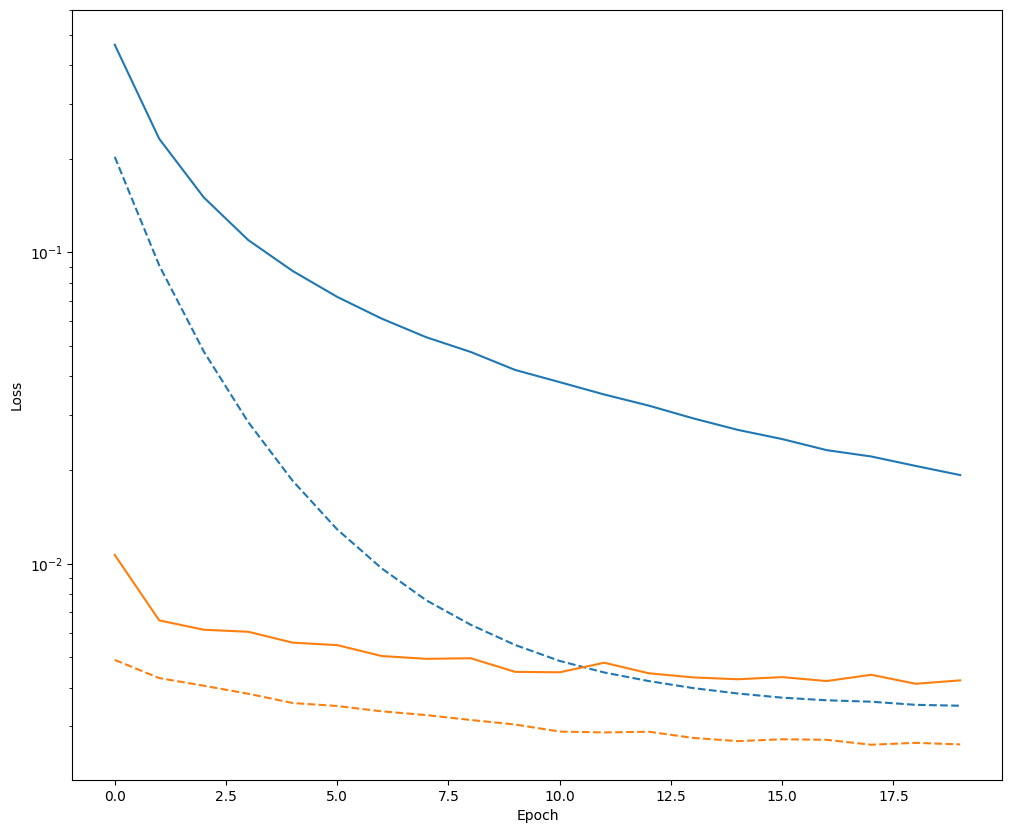

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

위의 그림에서 명확히 알 수 있듯이, 검증 손실 측면에서 이와 같은 정교한 초기화에는 분명한 이점이 있습니다. 

### 모델 학습

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 2:10 - loss: 0.0083 - tp: 62.0000 - fp: 12.0000 - tn: 47528.0000 - fn: 15.0000 - accuracy: 0.9994 - precision: 0.8378 - recall: 0.8052 - auc: 0.9410 - prc: 0.8151

13/90 [===>..........................] - ETA: 0s - loss: 0.0111 - tp: 65.0000 - fp: 20.0000 - tn: 72061.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.7647 - recall: 0.5804 - auc: 0.8734 - prc: 0.6094  

25/90 [=======>......................] - ETA: 0s - loss: 0.0135 - tp: 73.0000 - fp: 31.0000 - tn: 96576.0000 - fn: 89.0000 - accuracy: 0.9988 - precision: 0.7019 - recall: 0.4506 - auc: 0.8123 - prc: 0.4529

37/90 [===========>..................] - ETA: 0s - loss: 0.0135 - tp: 80.0000 - fp: 40.0000 - tn: 121099.0000 - fn: 126.0000 - accuracy: 0.9986 - precision: 0.6667 - recall: 0.3883 - auc: 0.7886 - prc: 0.3604

50/90 [===============>..............] - ETA: 0s - loss: 0.0127 - tp: 90.0000 - fp: 49.0000 - tn: 147667.0000 - fn: 163.0000 - accuracy: 0.9986 - precision: 0.6475 - recall: 0.3557 - auc: 0.7889 - prc: 0.3398

62/90 [===================>..........] - ETA: 0s - loss: 0.0119 - tp: 99.0000 - fp: 58.0000 - tn: 172198.0000 - fn: 190.0000 - accuracy: 0.9986 - precision: 0.6306 - recall: 0.3426 - auc: 0.7948 - prc: 0.3390

74/90 [=======================>......] - ETA: 0s - loss: 0.0114 - tp: 113.0000 - fp: 59.0000 - tn: 196724.0000 - fn: 225.0000 - accuracy: 0.9986 - precision: 0.6570 - recall: 0.3343 - auc: 0.7991 - prc: 0.3505

86/90 [===========================>..] - ETA: 0s - loss: 0.0110 - tp: 124.0000 - fp: 61.0000 - tn: 221256.0000 - fn: 256.0000 - accuracy: 0.9986 - precision: 0.6703 - recall: 0.3263 - auc: 0.8005 - prc: 0.3553

90/90 [==============================] - 2s 11ms/step - loss: 0.0109 - tp: 127.0000 - fp: 63.0000 - tn: 227394.0000 - fn: 261.0000 - accuracy: 0.9986 - precision: 0.6684 - recall: 0.3273 - auc: 0.8005 - prc: 0.3543 - val_loss: 0.0048 - val_tp: 36.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 38.0000 - val_accuracy: 0.9990 - val_precision: 0.8000 - val_recall: 0.4865 - val_auc: 0.9185 - val_prc: 0.7113


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.0058 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.8250 - prc: 0.6678

13/90 [===>..........................] - ETA: 0s - loss: 0.0082 - tp: 19.0000 - fp: 4.0000 - tn: 26573.0000 - fn: 28.0000 - accuracy: 0.9988 - precision: 0.8261 - recall: 0.4043 - auc: 0.8534 - prc: 0.4559

25/90 [=======>......................] - ETA: 0s - loss: 0.0073 - tp: 34.0000 - fp: 9.0000 - tn: 51110.0000 - fn: 47.0000 - accuracy: 0.9989 - precision: 0.7907 - recall: 0.4198 - auc: 0.8568 - prc: 0.4641

37/90 [===========>..................] - ETA: 0s - loss: 0.0070 - tp: 55.0000 - fp: 10.0000 - tn: 75642.0000 - fn: 69.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.4435 - auc: 0.8600 - prc: 0.5039

49/90 [===============>..............] - ETA: 0s - loss: 0.0070 - tp: 69.0000 - fp: 12.0000 - tn: 100178.0000 - fn: 93.0000 - accuracy: 0.9990 - precision: 0.8519 - recall: 0.4259 - auc: 0.8511 - prc: 0.4973

61/90 [===================>..........] - ETA: 0s - loss: 0.0070 - tp: 85.0000 - fp: 15.0000 - tn: 124711.0000 - fn: 117.0000 - accuracy: 0.9989 - precision: 0.8500 - recall: 0.4208 - auc: 0.8473 - prc: 0.4971

73/90 [=======================>......] - ETA: 0s - loss: 0.0069 - tp: 118.0000 - fp: 18.0000 - tn: 149229.0000 - fn: 139.0000 - accuracy: 0.9989 - precision: 0.8676 - recall: 0.4591 - auc: 0.8581 - prc: 0.5501

85/90 [===========================>..] - ETA: 0s - loss: 0.0067 - tp: 141.0000 - fp: 24.0000 - tn: 173756.0000 - fn: 159.0000 - accuracy: 0.9989 - precision: 0.8545 - recall: 0.4700 - auc: 0.8596 - prc: 0.5620

90/90 [==============================] - 1s 6ms/step - loss: 0.0068 - tp: 146.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 168.0000 - accuracy: 0.9989 - precision: 0.8439 - recall: 0.4650 - auc: 0.8609 - prc: 0.5527 - val_loss: 0.0042 - val_tp: 50.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8333 - val_recall: 0.6757 - val_auc: 0.9187 - val_prc: 0.7042


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0148 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.3333 - auc: 0.6596 - prc: 0.3371

13/90 [===>..........................] - ETA: 0s - loss: 0.0058 - tp: 24.0000 - fp: 4.0000 - tn: 26576.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5455 - auc: 0.8722 - prc: 0.6051 

25/90 [=======>......................] - ETA: 0s - loss: 0.0055 - tp: 45.0000 - fp: 8.0000 - tn: 51111.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.8491 - recall: 0.5556 - auc: 0.8862 - prc: 0.6270

37/90 [===========>..................] - ETA: 0s - loss: 0.0058 - tp: 68.0000 - fp: 10.0000 - tn: 75633.0000 - fn: 65.0000 - accuracy: 0.9990 - precision: 0.8718 - recall: 0.5113 - auc: 0.8882 - prc: 0.6400

49/90 [===============>..............] - ETA: 0s - loss: 0.0055 - tp: 94.0000 - fp: 12.0000 - tn: 100166.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8868 - recall: 0.5402 - auc: 0.8970 - prc: 0.6636

61/90 [===================>..........] - ETA: 0s - loss: 0.0056 - tp: 121.0000 - fp: 15.0000 - tn: 124691.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8897 - recall: 0.5450 - auc: 0.8963 - prc: 0.6669

73/90 [=======================>......] - ETA: 0s - loss: 0.0054 - tp: 147.0000 - fp: 19.0000 - tn: 149221.0000 - fn: 117.0000 - accuracy: 0.9991 - precision: 0.8855 - recall: 0.5568 - auc: 0.9012 - prc: 0.6776

85/90 [===========================>..] - ETA: 0s - loss: 0.0056 - tp: 170.0000 - fp: 28.0000 - tn: 173745.0000 - fn: 137.0000 - accuracy: 0.9991 - precision: 0.8586 - recall: 0.5537 - auc: 0.8985 - prc: 0.6563

90/90 [==============================] - 1s 6ms/step - loss: 0.0056 - tp: 173.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 141.0000 - accuracy: 0.9991 - precision: 0.8522 - recall: 0.5510 - auc: 0.8975 - prc: 0.6468 - val_loss: 0.0040 - val_tp: 53.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8413 - val_recall: 0.7162 - val_auc: 0.9187 - val_prc: 0.6656


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9998 - prc: 0.8723

13/90 [===>..........................] - ETA: 0s - loss: 0.0061 - tp: 29.0000 - fp: 1.0000 - tn: 26564.0000 - fn: 30.0000 - accuracy: 0.9988 - precision: 0.9667 - recall: 0.4915 - auc: 0.9052 - prc: 0.7187 

25/90 [=======>......................] - ETA: 0s - loss: 0.0068 - tp: 48.0000 - fp: 9.0000 - tn: 51093.0000 - fn: 50.0000 - accuracy: 0.9988 - precision: 0.8421 - recall: 0.4898 - auc: 0.8910 - prc: 0.6066

37/90 [===========>..................] - ETA: 0s - loss: 0.0063 - tp: 66.0000 - fp: 14.0000 - tn: 75628.0000 - fn: 68.0000 - accuracy: 0.9989 - precision: 0.8250 - recall: 0.4925 - auc: 0.8901 - prc: 0.6052

49/90 [===============>..............] - ETA: 0s - loss: 0.0060 - tp: 80.0000 - fp: 16.0000 - tn: 100166.0000 - fn: 90.0000 - accuracy: 0.9989 - precision: 0.8333 - recall: 0.4706 - auc: 0.8866 - prc: 0.6131

61/90 [===================>..........] - ETA: 0s - loss: 0.0059 - tp: 94.0000 - fp: 20.0000 - tn: 124707.0000 - fn: 107.0000 - accuracy: 0.9990 - precision: 0.8246 - recall: 0.4677 - auc: 0.8864 - prc: 0.6099

73/90 [=======================>......] - ETA: 0s - loss: 0.0060 - tp: 119.0000 - fp: 23.0000 - tn: 149234.0000 - fn: 128.0000 - accuracy: 0.9990 - precision: 0.8380 - recall: 0.4818 - auc: 0.8871 - prc: 0.6125

85/90 [===========================>..] - ETA: 0s - loss: 0.0058 - tp: 145.0000 - fp: 23.0000 - tn: 173768.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8631 - recall: 0.5017 - auc: 0.8894 - prc: 0.6350

90/90 [==============================] - 1s 6ms/step - loss: 0.0059 - tp: 159.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 155.0000 - accuracy: 0.9990 - precision: 0.8595 - recall: 0.5064 - auc: 0.8886 - prc: 0.6378 - val_loss: 0.0038 - val_tp: 53.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8413 - val_recall: 0.7162 - val_auc: 0.9255 - val_prc: 0.7243


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0045 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4956 - prc: 4.7193e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0064 - tp: 19.0000 - fp: 3.0000 - tn: 26577.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.8636 - recall: 0.4318 - auc: 0.8390 - prc: 0.5470                 

26/90 [=======>......................] - ETA: 0s - loss: 0.0055 - tp: 38.0000 - fp: 7.0000 - tn: 53160.0000 - fn: 43.0000 - accuracy: 0.9991 - precision: 0.8444 - recall: 0.4691 - auc: 0.8750 - prc: 0.5954

38/90 [===========>..................] - ETA: 0s - loss: 0.0057 - tp: 56.0000 - fp: 11.0000 - tn: 77690.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.8358 - recall: 0.4553 - auc: 0.8847 - prc: 0.6008

50/90 [===============>..............] - ETA: 0s - loss: 0.0059 - tp: 76.0000 - fp: 16.0000 - tn: 102217.0000 - fn: 91.0000 - accuracy: 0.9990 - precision: 0.8261 - recall: 0.4551 - auc: 0.8787 - prc: 0.5935

62/90 [===================>..........] - ETA: 0s - loss: 0.0057 - tp: 105.0000 - fp: 19.0000 - tn: 126742.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8468 - recall: 0.4884 - auc: 0.8894 - prc: 0.6288

74/90 [=======================>......] - ETA: 0s - loss: 0.0057 - tp: 127.0000 - fp: 21.0000 - tn: 151272.0000 - fn: 132.0000 - accuracy: 0.9990 - precision: 0.8581 - recall: 0.4903 - auc: 0.8925 - prc: 0.6335

86/90 [===========================>..] - ETA: 0s - loss: 0.0056 - tp: 147.0000 - fp: 23.0000 - tn: 175806.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8647 - recall: 0.4916 - auc: 0.8917 - prc: 0.6436

90/90 [==============================] - 1s 6ms/step - loss: 0.0057 - tp: 155.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 159.0000 - accuracy: 0.9990 - precision: 0.8564 - recall: 0.4936 - auc: 0.8904 - prc: 0.6365 - val_loss: 0.0037 - val_tp: 56.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8358 - val_recall: 0.7568 - val_auc: 0.9255 - val_prc: 0.7067


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0082 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4958 - prc: 9.4524e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 25.0000 - fp: 4.0000 - tn: 26577.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8621 - recall: 0.5814 - auc: 0.8941 - prc: 0.6849             

25/90 [=======>......................] - ETA: 0s - loss: 0.0058 - tp: 42.0000 - fp: 9.0000 - tn: 51105.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.4884 - auc: 0.8647 - prc: 0.6004

37/90 [===========>..................] - ETA: 0s - loss: 0.0059 - tp: 70.0000 - fp: 11.0000 - tn: 75629.0000 - fn: 66.0000 - accuracy: 0.9990 - precision: 0.8642 - recall: 0.5147 - auc: 0.8662 - prc: 0.6250

49/90 [===============>..............] - ETA: 0s - loss: 0.0054 - tp: 100.0000 - fp: 13.0000 - tn: 100152.0000 - fn: 87.0000 - accuracy: 0.9990 - precision: 0.8850 - recall: 0.5348 - auc: 0.8918 - prc: 0.6824

61/90 [===================>..........] - ETA: 0s - loss: 0.0053 - tp: 119.0000 - fp: 15.0000 - tn: 124689.0000 - fn: 105.0000 - accuracy: 0.9990 - precision: 0.8881 - recall: 0.5312 - auc: 0.8894 - prc: 0.6763

73/90 [=======================>......] - ETA: 0s - loss: 0.0054 - tp: 141.0000 - fp: 19.0000 - tn: 149217.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8813 - recall: 0.5261 - auc: 0.8812 - prc: 0.6659

85/90 [===========================>..] - ETA: 0s - loss: 0.0054 - tp: 160.0000 - fp: 25.0000 - tn: 173753.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8649 - recall: 0.5298 - auc: 0.8779 - prc: 0.6519

90/90 [==============================] - 1s 6ms/step - loss: 0.0053 - tp: 165.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 149.0000 - accuracy: 0.9990 - precision: 0.8639 - recall: 0.5255 - auc: 0.8793 - prc: 0.6565 - val_loss: 0.0035 - val_tp: 58.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 16.0000 - val_accuracy: 0.9994 - val_precision: 0.8406 - val_recall: 0.7838 - val_auc: 0.9322 - val_prc: 0.7496


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.0101 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.2000 - auc: 0.7979 - prc: 0.4052

13/90 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 31.0000 - fp: 4.0000 - tn: 26563.0000 - fn: 26.0000 - accuracy: 0.9989 - precision: 0.8857 - recall: 0.5439 - auc: 0.9023 - prc: 0.7213 

25/90 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 57.0000 - fp: 7.0000 - tn: 51094.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.8906 - recall: 0.5758 - auc: 0.9182 - prc: 0.7400

37/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 79.0000 - fp: 10.0000 - tn: 75628.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8876 - recall: 0.5725 - auc: 0.9156 - prc: 0.7276

49/90 [===============>..............] - ETA: 0s - loss: 0.0052 - tp: 106.0000 - fp: 21.0000 - tn: 100144.0000 - fn: 81.0000 - accuracy: 0.9990 - precision: 0.8346 - recall: 0.5668 - auc: 0.9107 - prc: 0.6922

61/90 [===================>..........] - ETA: 0s - loss: 0.0052 - tp: 129.0000 - fp: 27.0000 - tn: 124673.0000 - fn: 99.0000 - accuracy: 0.9990 - precision: 0.8269 - recall: 0.5658 - auc: 0.9134 - prc: 0.6903

73/90 [=======================>......] - ETA: 0s - loss: 0.0049 - tp: 145.0000 - fp: 29.0000 - tn: 149216.0000 - fn: 114.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5598 - auc: 0.9120 - prc: 0.6905

85/90 [===========================>..] - ETA: 0s - loss: 0.0050 - tp: 167.0000 - fp: 32.0000 - tn: 173746.0000 - fn: 135.0000 - accuracy: 0.9990 - precision: 0.8392 - recall: 0.5530 - auc: 0.9062 - prc: 0.6758

90/90 [==============================] - 1s 6ms/step - loss: 0.0050 - tp: 173.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 141.0000 - accuracy: 0.9990 - precision: 0.8398 - recall: 0.5510 - auc: 0.9049 - prc: 0.6720 - val_loss: 0.0034 - val_tp: 58.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 16.0000 - val_accuracy: 0.9994 - val_precision: 0.8406 - val_recall: 0.7838 - val_auc: 0.9322 - val_prc: 0.7574


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0049 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8741 - prc: 0.7519

13/90 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 29.0000 - fp: 3.0000 - tn: 26569.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.9062 - recall: 0.5577 - auc: 0.9029 - prc: 0.6859 

25/90 [=======>......................] - ETA: 0s - loss: 0.0057 - tp: 53.0000 - fp: 6.0000 - tn: 51097.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8983 - recall: 0.5464 - auc: 0.8854 - prc: 0.6480

37/90 [===========>..................] - ETA: 0s - loss: 0.0051 - tp: 75.0000 - fp: 9.0000 - tn: 75634.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8929 - recall: 0.5639 - auc: 0.8899 - prc: 0.6642

49/90 [===============>..............] - ETA: 0s - loss: 0.0051 - tp: 100.0000 - fp: 14.0000 - tn: 100164.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8772 - recall: 0.5747 - auc: 0.8897 - prc: 0.6589

61/90 [===================>..........] - ETA: 0s - loss: 0.0050 - tp: 126.0000 - fp: 19.0000 - tn: 124690.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.8690 - recall: 0.5753 - auc: 0.8985 - prc: 0.6585

73/90 [=======================>......] - ETA: 0s - loss: 0.0051 - tp: 147.0000 - fp: 22.0000 - tn: 149224.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8698 - recall: 0.5698 - auc: 0.8923 - prc: 0.6449

85/90 [===========================>..] - ETA: 0s - loss: 0.0050 - tp: 169.0000 - fp: 23.0000 - tn: 173759.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8802 - recall: 0.5671 - auc: 0.8949 - prc: 0.6554

90/90 [==============================] - 1s 6ms/step - loss: 0.0052 - tp: 173.0000 - fp: 25.0000 - tn: 181937.0000 - fn: 141.0000 - accuracy: 0.9991 - precision: 0.8737 - recall: 0.5510 - auc: 0.8938 - prc: 0.6419 - val_loss: 0.0033 - val_tp: 59.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 15.0000 - val_accuracy: 0.9994 - val_precision: 0.8429 - val_recall: 0.7973 - val_auc: 0.9389 - val_prc: 0.7669


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 0.0103 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7478 - prc: 0.0960

12/90 [===>..........................] - ETA: 0s - loss: 0.0052 - tp: 26.0000 - fp: 4.0000 - tn: 24527.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.5778 - auc: 0.8990 - prc: 0.6782         

24/90 [=======>......................] - ETA: 0s - loss: 0.0048 - tp: 54.0000 - fp: 6.0000 - tn: 49056.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.9000 - recall: 0.6000 - auc: 0.9046 - prc: 0.6933

36/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 85.0000 - fp: 7.0000 - tn: 73585.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.9239 - recall: 0.6250 - auc: 0.9182 - prc: 0.7348

48/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 120.0000 - fp: 9.0000 - tn: 98111.0000 - fn: 64.0000 - accuracy: 0.9993 - precision: 0.9302 - recall: 0.6522 - auc: 0.9367 - prc: 0.7760

60/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 144.0000 - fp: 15.0000 - tn: 122637.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.9057 - recall: 0.6316 - auc: 0.9290 - prc: 0.7549

72/90 [=======================>......] - ETA: 0s - loss: 0.0043 - tp: 161.0000 - fp: 19.0000 - tn: 147175.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8944 - recall: 0.6145 - auc: 0.9189 - prc: 0.7349

84/90 [===========================>..] - ETA: 0s - loss: 0.0044 - tp: 184.0000 - fp: 28.0000 - tn: 171704.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8679 - recall: 0.6133 - auc: 0.9190 - prc: 0.7173

90/90 [==============================] - 1s 6ms/step - loss: 0.0044 - tp: 190.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8636 - recall: 0.6051 - auc: 0.9178 - prc: 0.7096 - val_loss: 0.0032 - val_tp: 59.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 15.0000 - val_accuracy: 0.9994 - val_precision: 0.8429 - val_recall: 0.7973 - val_auc: 0.9389 - val_prc: 0.7802


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0075 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.8724 - prc: 0.4477

12/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 23.0000 - fp: 1.0000 - tn: 24536.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9583 - recall: 0.5897 - auc: 0.9349 - prc: 0.7522

24/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 40.0000 - fp: 5.0000 - tn: 49065.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.8889 - recall: 0.4878 - auc: 0.9196 - prc: 0.7087

36/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 73.0000 - fp: 8.0000 - tn: 73591.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.9012 - recall: 0.5659 - auc: 0.9292 - prc: 0.7495

48/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 94.0000 - fp: 19.0000 - tn: 98124.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8319 - recall: 0.5839 - auc: 0.9400 - prc: 0.7130

59/90 [==================>...........] - ETA: 0s - loss: 0.0044 - tp: 114.0000 - fp: 24.0000 - tn: 120609.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8261 - recall: 0.5729 - auc: 0.9287 - prc: 0.6916

71/90 [======================>.......] - ETA: 0s - loss: 0.0045 - tp: 135.0000 - fp: 30.0000 - tn: 145135.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8182 - recall: 0.5556 - auc: 0.9229 - prc: 0.6809

83/90 [==========================>...] - ETA: 0s - loss: 0.0047 - tp: 161.0000 - fp: 32.0000 - tn: 169660.0000 - fn: 131.0000 - accuracy: 0.9990 - precision: 0.8342 - recall: 0.5514 - auc: 0.9151 - prc: 0.6829

90/90 [==============================] - 1s 6ms/step - loss: 0.0047 - tp: 170.0000 - fp: 34.0000 - tn: 181928.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5414 - auc: 0.9130 - prc: 0.6804 - val_loss: 0.0032 - val_tp: 60.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8451 - val_recall: 0.8108 - val_auc: 0.9457 - val_prc: 0.7949


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.0021 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9998 - prc: 0.7973

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 20.0000 - fp: 3.0000 - tn: 26590.0000 - fn: 11.0000 - accuracy: 0.9995 - precision: 0.8696 - recall: 0.6452 - auc: 0.9509 - prc: 0.7220 

26/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 45.0000 - fp: 7.0000 - tn: 53168.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.8654 - recall: 0.6164 - auc: 0.9239 - prc: 0.7321

38/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 71.0000 - fp: 11.0000 - tn: 77700.0000 - fn: 42.0000 - accuracy: 0.9993 - precision: 0.8659 - recall: 0.6283 - auc: 0.9417 - prc: 0.7625

51/90 [================>.............] - ETA: 0s - loss: 0.0043 - tp: 97.0000 - fp: 16.0000 - tn: 104264.0000 - fn: 71.0000 - accuracy: 0.9992 - precision: 0.8584 - recall: 0.5774 - auc: 0.9127 - prc: 0.6961

64/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 128.0000 - fp: 23.0000 - tn: 130829.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8477 - recall: 0.5818 - auc: 0.9148 - prc: 0.6759

77/90 [========================>.....] - ETA: 0s - loss: 0.0047 - tp: 166.0000 - fp: 27.0000 - tn: 157392.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8601 - recall: 0.5993 - auc: 0.9160 - prc: 0.6923

90/90 [==============================] - ETA: 0s - loss: 0.0048 - tp: 187.0000 - fp: 37.0000 - tn: 181925.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8348 - recall: 0.5955 - auc: 0.9130 - prc: 0.6679

90/90 [==============================] - 1s 6ms/step - loss: 0.0048 - tp: 187.0000 - fp: 37.0000 - tn: 181925.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8348 - recall: 0.5955 - auc: 0.9130 - prc: 0.6679 - val_loss: 0.0030 - val_tp: 59.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 15.0000 - val_accuracy: 0.9994 - val_precision: 0.8429 - val_recall: 0.7973 - val_auc: 0.9457 - val_prc: 0.8003


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0079 - tp: 2.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.5000 - auc: 0.8726 - prc: 0.5481

13/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 22.0000 - fp: 5.0000 - tn: 26579.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8148 - recall: 0.5500 - auc: 0.9114 - prc: 0.6674

25/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 51.0000 - fp: 8.0000 - tn: 51106.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8644 - recall: 0.5930 - auc: 0.9234 - prc: 0.7070

38/90 [===========>..................] - ETA: 0s - loss: 0.0046 - tp: 80.0000 - fp: 14.0000 - tn: 77671.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8511 - recall: 0.5755 - auc: 0.9271 - prc: 0.6896

50/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 96.0000 - fp: 21.0000 - tn: 102208.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8205 - recall: 0.5614 - auc: 0.9142 - prc: 0.6655

62/90 [===================>..........] - ETA: 0s - loss: 0.0046 - tp: 124.0000 - fp: 27.0000 - tn: 126733.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8212 - recall: 0.5741 - auc: 0.9157 - prc: 0.6661

74/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 142.0000 - fp: 32.0000 - tn: 151276.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8161 - recall: 0.5820 - auc: 0.9068 - prc: 0.6553

86/90 [===========================>..] - ETA: 0s - loss: 0.0045 - tp: 170.0000 - fp: 36.0000 - tn: 175800.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8252 - recall: 0.5822 - auc: 0.9117 - prc: 0.6611

90/90 [==============================] - 1s 6ms/step - loss: 0.0046 - tp: 185.0000 - fp: 37.0000 - tn: 181925.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5892 - auc: 0.9130 - prc: 0.6696 - val_loss: 0.0029 - val_tp: 59.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 15.0000 - val_accuracy: 0.9994 - val_precision: 0.8429 - val_recall: 0.7973 - val_auc: 0.9457 - val_prc: 0.8113


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 5.8638e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 33.0000 - fp: 6.0000 - tn: 26570.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8462 - recall: 0.6875 - auc: 0.9683 - prc: 0.8260         

25/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 63.0000 - fp: 11.0000 - tn: 51091.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8514 - recall: 0.6429 - auc: 0.9329 - prc: 0.7469

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 84.0000 - fp: 16.0000 - tn: 75629.0000 - fn: 47.0000 - accuracy: 0.9992 - precision: 0.8400 - recall: 0.6412 - auc: 0.9305 - prc: 0.7471

49/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 107.0000 - fp: 20.0000 - tn: 100157.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.8425 - recall: 0.6114 - auc: 0.9335 - prc: 0.7409

61/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 127.0000 - fp: 23.0000 - tn: 124695.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8467 - recall: 0.6048 - auc: 0.9326 - prc: 0.7236

73/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 142.0000 - fp: 27.0000 - tn: 149235.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8402 - recall: 0.5868 - auc: 0.9269 - prc: 0.7020

85/90 [===========================>..] - ETA: 0s - loss: 0.0041 - tp: 177.0000 - fp: 28.0000 - tn: 173755.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8634 - recall: 0.5960 - auc: 0.9251 - prc: 0.7206

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 189.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 125.0000 - accuracy: 0.9992 - precision: 0.8670 - recall: 0.6019 - auc: 0.9244 - prc: 0.7167 - val_loss: 0.0029 - val_tp: 60.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 14.0000 - val_accuracy: 0.9994 - val_precision: 0.8333 - val_recall: 0.8108 - val_auc: 0.9457 - val_prc: 0.8130


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9158 - prc: 0.7677

14/90 [===>..........................] - ETA: 0s - loss: 0.0035 - tp: 24.0000 - fp: 5.0000 - tn: 28630.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.8276 - recall: 0.6486 - auc: 0.9044 - prc: 0.6871 

27/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 57.0000 - fp: 9.0000 - tn: 55198.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.8636 - recall: 0.6404 - auc: 0.9317 - prc: 0.7417

40/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 81.0000 - fp: 15.0000 - tn: 81772.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.8438 - recall: 0.6090 - auc: 0.9125 - prc: 0.6786

53/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 113.0000 - fp: 19.0000 - tn: 108336.0000 - fn: 76.0000 - accuracy: 0.9991 - precision: 0.8561 - recall: 0.5979 - auc: 0.9090 - prc: 0.6781

66/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 136.0000 - fp: 23.0000 - tn: 134917.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8553 - recall: 0.5965 - auc: 0.9200 - prc: 0.6931

79/90 [=========================>....] - ETA: 0s - loss: 0.0042 - tp: 165.0000 - fp: 26.0000 - tn: 161490.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8639 - recall: 0.5978 - auc: 0.9212 - prc: 0.7056

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 189.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8630 - recall: 0.6019 - auc: 0.9227 - prc: 0.7123 - val_loss: 0.0029 - val_tp: 61.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8356 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8147


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0058 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8722 - prc: 0.5435

13/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 29.0000 - fp: 1.0000 - tn: 26580.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9667 - recall: 0.6744 - auc: 0.9529 - prc: 0.8373 

25/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 56.0000 - fp: 7.0000 - tn: 51109.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6667 - auc: 0.9338 - prc: 0.7325

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 88.0000 - fp: 10.0000 - tn: 75638.0000 - fn: 40.0000 - accuracy: 0.9993 - precision: 0.8980 - recall: 0.6875 - auc: 0.9407 - prc: 0.7613

49/90 [===============>..............] - ETA: 0s - loss: 0.0036 - tp: 114.0000 - fp: 15.0000 - tn: 100164.0000 - fn: 59.0000 - accuracy: 0.9993 - precision: 0.8837 - recall: 0.6590 - auc: 0.9328 - prc: 0.7518

61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 144.0000 - fp: 18.0000 - tn: 124692.0000 - fn: 74.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6606 - auc: 0.9259 - prc: 0.7540

73/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 172.0000 - fp: 23.0000 - tn: 149218.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8821 - recall: 0.6540 - auc: 0.9251 - prc: 0.7521

85/90 [===========================>..] - ETA: 0s - loss: 0.0040 - tp: 190.0000 - fp: 29.0000 - tn: 173752.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8676 - recall: 0.6355 - auc: 0.9172 - prc: 0.7264

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 197.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8565 - recall: 0.6274 - auc: 0.9212 - prc: 0.7157 - val_loss: 0.0028 - val_tp: 60.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 14.0000 - val_accuracy: 0.9994 - val_precision: 0.8333 - val_recall: 0.8108 - val_auc: 0.9457 - val_prc: 0.8243


Epoch 16/100


 1/90 [..............................] - ETA: 0s - loss: 4.9568e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

13/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 25.0000 - fp: 2.0000 - tn: 26576.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.9259 - recall: 0.5435 - auc: 0.9230 - prc: 0.7341                             

25/90 [=======>......................] - ETA: 0s - loss: 0.0049 - tp: 57.0000 - fp: 7.0000 - tn: 51091.0000 - fn: 45.0000 - accuracy: 0.9990 - precision: 0.8906 - recall: 0.5588 - auc: 0.9305 - prc: 0.7122

37/90 [===========>..................] - ETA: 0s - loss: 0.0048 - tp: 75.0000 - fp: 11.0000 - tn: 75623.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.8721 - recall: 0.5282 - auc: 0.9216 - prc: 0.6962

49/90 [===============>..............] - ETA: 0s - loss: 0.0043 - tp: 100.0000 - fp: 18.0000 - tn: 100157.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.8475 - recall: 0.5650 - auc: 0.9285 - prc: 0.7090

62/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 121.0000 - fp: 19.0000 - tn: 126744.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8643 - recall: 0.5681 - auc: 0.9287 - prc: 0.7202

75/90 [========================>.....] - ETA: 0s - loss: 0.0041 - tp: 148.0000 - fp: 21.0000 - tn: 153318.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8757 - recall: 0.5670 - auc: 0.9283 - prc: 0.7144

87/90 [============================>.] - ETA: 0s - loss: 0.0042 - tp: 176.0000 - fp: 26.0000 - tn: 177843.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8713 - recall: 0.5733 - auc: 0.9275 - prc: 0.7109

90/90 [==============================] - 1s 6ms/step - loss: 0.0042 - tp: 180.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8738 - recall: 0.5732 - auc: 0.9291 - prc: 0.7122 - val_loss: 0.0028 - val_tp: 61.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8356 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8259


Epoch 17/100


 1/90 [..............................] - ETA: 0s - loss: 0.0035 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8739 - prc: 0.7518

13/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 30.0000 - fp: 7.0000 - tn: 26568.0000 - fn: 19.0000 - accuracy: 0.9990 - precision: 0.8108 - recall: 0.6122 - auc: 0.9175 - prc: 0.6981 

25/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 52.0000 - fp: 7.0000 - tn: 51110.0000 - fn: 31.0000 - accuracy: 0.9993 - precision: 0.8814 - recall: 0.6265 - auc: 0.9150 - prc: 0.7392

37/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 76.0000 - fp: 12.0000 - tn: 75636.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.8636 - recall: 0.5938 - auc: 0.8975 - prc: 0.6856

49/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 99.0000 - fp: 18.0000 - tn: 100162.0000 - fn: 73.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5756 - auc: 0.9061 - prc: 0.6861

61/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 137.0000 - fp: 21.0000 - tn: 124684.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8671 - recall: 0.6143 - auc: 0.9162 - prc: 0.7078

73/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 160.0000 - fp: 22.0000 - tn: 149220.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8791 - recall: 0.6107 - auc: 0.9190 - prc: 0.7174

85/90 [===========================>..] - ETA: 0s - loss: 0.0043 - tp: 182.0000 - fp: 27.0000 - tn: 173747.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8708 - recall: 0.5948 - auc: 0.9224 - prc: 0.7150

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 188.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 126.0000 - accuracy: 0.9992 - precision: 0.8704 - recall: 0.5987 - auc: 0.9243 - prc: 0.7179 - val_loss: 0.0027 - val_tp: 61.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8356 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8291


Epoch 18/100


 1/90 [..............................] - ETA: 0s - loss: 5.3386e-04 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 30.0000 - fp: 3.0000 - tn: 26574.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.9091 - recall: 0.6383 - auc: 0.9352 - prc: 0.7485         

25/90 [=======>......................] - ETA: 0s - loss: 0.0044 - tp: 61.0000 - fp: 9.0000 - tn: 51097.0000 - fn: 33.0000 - accuracy: 0.9992 - precision: 0.8714 - recall: 0.6489 - auc: 0.9193 - prc: 0.7137

37/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 91.0000 - fp: 10.0000 - tn: 75619.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.9010 - recall: 0.6190 - auc: 0.9276 - prc: 0.7300

50/90 [===============>..............] - ETA: 0s - loss: 0.0047 - tp: 114.0000 - fp: 13.0000 - tn: 102195.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8976 - recall: 0.5938 - auc: 0.9156 - prc: 0.7057

63/90 [====================>.........] - ETA: 0s - loss: 0.0046 - tp: 138.0000 - fp: 18.0000 - tn: 128776.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8846 - recall: 0.6000 - auc: 0.9164 - prc: 0.6917

75/90 [========================>.....] - ETA: 0s - loss: 0.0046 - tp: 162.0000 - fp: 24.0000 - tn: 153307.0000 - fn: 107.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.6022 - auc: 0.9191 - prc: 0.6862

87/90 [============================>.] - ETA: 0s - loss: 0.0044 - tp: 184.0000 - fp: 26.0000 - tn: 177844.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8762 - recall: 0.6013 - auc: 0.9206 - prc: 0.6904

90/90 [==============================] - 1s 6ms/step - loss: 0.0043 - tp: 192.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.6115 - auc: 0.9226 - prc: 0.6985 - val_loss: 0.0027 - val_tp: 61.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8356 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8330


Epoch 19/100


 1/90 [..............................] - ETA: 0s - loss: 0.0093 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.3333 - auc: 0.8319 - prc: 0.6700

13/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 25.0000 - fp: 3.0000 - tn: 26575.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.8929 - recall: 0.5435 - auc: 0.8574 - prc: 0.6301 

25/90 [=======>......................] - ETA: 0s - loss: 0.0050 - tp: 47.0000 - fp: 5.0000 - tn: 51109.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.9038 - recall: 0.5465 - auc: 0.8767 - prc: 0.6441

37/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 69.0000 - fp: 13.0000 - tn: 75644.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8415 - recall: 0.5798 - auc: 0.8854 - prc: 0.6349

50/90 [===============>..............] - ETA: 0s - loss: 0.0043 - tp: 100.0000 - fp: 20.0000 - tn: 102214.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8333 - recall: 0.6024 - auc: 0.9117 - prc: 0.6827

62/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 137.0000 - fp: 24.0000 - tn: 126729.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8509 - recall: 0.6143 - auc: 0.9184 - prc: 0.7044

74/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 170.0000 - fp: 26.0000 - tn: 151258.0000 - fn: 98.0000 - accuracy: 0.9992 - precision: 0.8673 - recall: 0.6343 - auc: 0.9245 - prc: 0.7252

86/90 [===========================>..] - ETA: 0s - loss: 0.0040 - tp: 196.0000 - fp: 29.0000 - tn: 175793.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8711 - recall: 0.6405 - auc: 0.9207 - prc: 0.7285

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 201.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8701 - recall: 0.6401 - auc: 0.9211 - prc: 0.7305 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8351


Epoch 20/100


 1/90 [..............................] - ETA: 0s - loss: 0.0064 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9161 - prc: 0.7942

13/90 [===>..........................] - ETA: 0s - loss: 0.0050 - tp: 25.0000 - fp: 7.0000 - tn: 26571.0000 - fn: 21.0000 - accuracy: 0.9989 - precision: 0.7812 - recall: 0.5435 - auc: 0.9228 - prc: 0.6384 

25/90 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 56.0000 - fp: 12.0000 - tn: 51094.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5957 - auc: 0.9353 - prc: 0.7031

37/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 84.0000 - fp: 18.0000 - tn: 75619.0000 - fn: 55.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.6043 - auc: 0.9380 - prc: 0.7192

49/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 110.0000 - fp: 24.0000 - tn: 100146.0000 - fn: 72.0000 - accuracy: 0.9990 - precision: 0.8209 - recall: 0.6044 - auc: 0.9277 - prc: 0.7125

61/90 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 140.0000 - fp: 26.0000 - tn: 124676.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8434 - recall: 0.6195 - auc: 0.9262 - prc: 0.7233

73/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 161.0000 - fp: 28.0000 - tn: 149215.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8519 - recall: 0.6169 - auc: 0.9245 - prc: 0.7269

85/90 [===========================>..] - ETA: 0s - loss: 0.0042 - tp: 185.0000 - fp: 30.0000 - tn: 173748.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8605 - recall: 0.6126 - auc: 0.9213 - prc: 0.7242

90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 194.0000 - fp: 31.0000 - tn: 181931.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8622 - recall: 0.6178 - auc: 0.9243 - prc: 0.7319 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8345


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9995 - prc: 0.3069

13/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 31.0000 - fp: 6.0000 - tn: 26564.0000 - fn: 23.0000 - accuracy: 0.9989 - precision: 0.8378 - recall: 0.5741 - auc: 0.9340 - prc: 0.6911             

25/90 [=======>......................] - ETA: 0s - loss: 0.0036 - tp: 60.0000 - fp: 8.0000 - tn: 51097.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6316 - auc: 0.9466 - prc: 0.7821

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 91.0000 - fp: 12.0000 - tn: 75620.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.8835 - recall: 0.6319 - auc: 0.9228 - prc: 0.7519

50/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 121.0000 - fp: 15.0000 - tn: 102197.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8897 - recall: 0.6436 - auc: 0.9301 - prc: 0.7673

62/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 155.0000 - fp: 18.0000 - tn: 126719.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8960 - recall: 0.6485 - auc: 0.9281 - prc: 0.7737

74/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 177.0000 - fp: 21.0000 - tn: 151262.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8939 - recall: 0.6580 - auc: 0.9305 - prc: 0.7737

86/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 199.0000 - fp: 28.0000 - tn: 175798.0000 - fn: 103.0000 - accuracy: 0.9993 - precision: 0.8767 - recall: 0.6589 - auc: 0.9281 - prc: 0.7593

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 206.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8803 - recall: 0.6561 - auc: 0.9244 - prc: 0.7550 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8368


Epoch 22/100


 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 0.9995 - prc: 0.4507

14/90 [===>..........................] - ETA: 0s - loss: 0.0035 - tp: 32.0000 - fp: 5.0000 - tn: 28622.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.8649 - recall: 0.7111 - auc: 0.9437 - prc: 0.6778 

26/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 62.0000 - fp: 9.0000 - tn: 53154.0000 - fn: 23.0000 - accuracy: 0.9994 - precision: 0.8732 - recall: 0.7294 - auc: 0.9404 - prc: 0.7314

38/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 77.0000 - fp: 14.0000 - tn: 77693.0000 - fn: 40.0000 - accuracy: 0.9993 - precision: 0.8462 - recall: 0.6581 - auc: 0.9265 - prc: 0.6940

50/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 101.0000 - fp: 19.0000 - tn: 102220.0000 - fn: 60.0000 - accuracy: 0.9992 - precision: 0.8417 - recall: 0.6273 - auc: 0.9246 - prc: 0.6877

62/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 123.0000 - fp: 23.0000 - tn: 126748.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8425 - recall: 0.6000 - auc: 0.9186 - prc: 0.6800

74/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 153.0000 - fp: 27.0000 - tn: 151273.0000 - fn: 99.0000 - accuracy: 0.9992 - precision: 0.8500 - recall: 0.6071 - auc: 0.9218 - prc: 0.6983

86/90 [===========================>..] - ETA: 0s - loss: 0.0040 - tp: 185.0000 - fp: 30.0000 - tn: 175795.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8605 - recall: 0.6106 - auc: 0.9266 - prc: 0.7157

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 191.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8643 - recall: 0.6083 - auc: 0.9275 - prc: 0.7185 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8337


Epoch 23/100


 1/90 [..............................] - ETA: 0s - loss: 0.0109 - tp: 1.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 4.0000 - accuracy: 0.9976 - precision: 0.5000 - recall: 0.2000 - auc: 0.8989 - prc: 0.4653

13/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 25.0000 - fp: 6.0000 - tn: 26573.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.8065 - recall: 0.5556 - auc: 0.8878 - prc: 0.6189

26/90 [=======>......................] - ETA: 0s - loss: 0.0053 - tp: 56.0000 - fp: 12.0000 - tn: 53141.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5895 - auc: 0.8778 - prc: 0.6155

38/90 [===========>..................] - ETA: 0s - loss: 0.0046 - tp: 77.0000 - fp: 13.0000 - tn: 77679.0000 - fn: 55.0000 - accuracy: 0.9991 - precision: 0.8556 - recall: 0.5833 - auc: 0.8891 - prc: 0.6547

51/90 [================>.............] - ETA: 0s - loss: 0.0041 - tp: 111.0000 - fp: 20.0000 - tn: 104253.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8473 - recall: 0.6343 - auc: 0.9134 - prc: 0.6960

64/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 141.0000 - fp: 24.0000 - tn: 130832.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.8545 - recall: 0.6528 - auc: 0.9205 - prc: 0.7135

76/90 [========================>.....] - ETA: 0s - loss: 0.0040 - tp: 165.0000 - fp: 28.0000 - tn: 155361.0000 - fn: 94.0000 - accuracy: 0.9992 - precision: 0.8549 - recall: 0.6371 - auc: 0.9200 - prc: 0.7031

88/90 [============================>.] - ETA: 0s - loss: 0.0040 - tp: 197.0000 - fp: 32.0000 - tn: 179881.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8603 - recall: 0.6334 - auc: 0.9236 - prc: 0.7141

90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 199.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8615 - recall: 0.6338 - auc: 0.9243 - prc: 0.7164 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8394


Epoch 24/100


 1/90 [..............................] - ETA: 0s - loss: 0.0023 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9998 - prc: 0.9383

14/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 40.0000 - fp: 4.0000 - tn: 28610.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.9091 - recall: 0.6897 - auc: 0.9302 - prc: 0.7397 

27/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 71.0000 - fp: 6.0000 - tn: 55186.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.9221 - recall: 0.6827 - auc: 0.9270 - prc: 0.7432

39/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 102.0000 - fp: 11.0000 - tn: 79708.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.9027 - recall: 0.6667 - auc: 0.9305 - prc: 0.7391

52/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 133.0000 - fp: 14.0000 - tn: 106282.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.9048 - recall: 0.6650 - auc: 0.9417 - prc: 0.7626

65/90 [====================>.........] - ETA: 0s - loss: 0.0040 - tp: 154.0000 - fp: 19.0000 - tn: 132857.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8902 - recall: 0.6311 - auc: 0.9254 - prc: 0.7398

78/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 182.0000 - fp: 24.0000 - tn: 159440.0000 - fn: 98.0000 - accuracy: 0.9992 - precision: 0.8835 - recall: 0.6500 - auc: 0.9278 - prc: 0.7347

90/90 [==============================] - 1s 6ms/step - loss: 0.0039 - tp: 199.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8728 - recall: 0.6338 - auc: 0.9259 - prc: 0.7225 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8409


Epoch 25/100


 1/90 [..............................] - ETA: 0s - loss: 0.0039 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8318 - prc: 0.6683

13/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 27.0000 - fp: 4.0000 - tn: 26575.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8710 - recall: 0.6000 - auc: 0.9214 - prc: 0.7089 

26/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 58.0000 - fp: 9.0000 - tn: 53145.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8657 - recall: 0.6170 - auc: 0.9194 - prc: 0.7214

38/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 85.0000 - fp: 16.0000 - tn: 77672.0000 - fn: 51.0000 - accuracy: 0.9991 - precision: 0.8416 - recall: 0.6250 - auc: 0.9295 - prc: 0.7450

50/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 110.0000 - fp: 18.0000 - tn: 102198.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8594 - recall: 0.5978 - auc: 0.9259 - prc: 0.7348

62/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 136.0000 - fp: 19.0000 - tn: 126730.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8774 - recall: 0.5991 - auc: 0.9288 - prc: 0.7557

74/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 168.0000 - fp: 22.0000 - tn: 151258.0000 - fn: 104.0000 - accuracy: 0.9992 - precision: 0.8842 - recall: 0.6176 - auc: 0.9313 - prc: 0.7608

87/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 193.0000 - fp: 27.0000 - tn: 177843.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8773 - recall: 0.6307 - auc: 0.9306 - prc: 0.7551

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 197.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8756 - recall: 0.6274 - auc: 0.9260 - prc: 0.7478 - val_loss: 0.0028 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8391


Epoch 26/100


 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9997 - prc: 0.8841

14/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 29.0000 - fp: 2.0000 - tn: 28617.0000 - fn: 24.0000 - accuracy: 0.9991 - precision: 0.9355 - recall: 0.5472 - auc: 0.9047 - prc: 0.6989 

26/90 [=======>......................] - ETA: 0s - loss: 0.0045 - tp: 52.0000 - fp: 9.0000 - tn: 53148.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8525 - recall: 0.5714 - auc: 0.9167 - prc: 0.6886

38/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 77.0000 - fp: 15.0000 - tn: 77675.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8370 - recall: 0.5746 - auc: 0.9171 - prc: 0.6896

50/90 [===============>..............] - ETA: 0s - loss: 0.0041 - tp: 107.0000 - fp: 16.0000 - tn: 102207.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8699 - recall: 0.6045 - auc: 0.9145 - prc: 0.7185

62/90 [===================>..........] - ETA: 0s - loss: 0.0039 - tp: 129.0000 - fp: 17.0000 - tn: 126746.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8836 - recall: 0.6056 - auc: 0.9147 - prc: 0.7236

74/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 160.0000 - fp: 23.0000 - tn: 151275.0000 - fn: 94.0000 - accuracy: 0.9992 - precision: 0.8743 - recall: 0.6299 - auc: 0.9245 - prc: 0.7439

87/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 194.0000 - fp: 23.0000 - tn: 177848.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8940 - recall: 0.6361 - auc: 0.9321 - prc: 0.7632

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 200.0000 - fp: 24.0000 - tn: 181938.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8929 - recall: 0.6369 - auc: 0.9308 - prc: 0.7609 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8384


Epoch 27/100


 1/90 [..............................] - ETA: 0s - loss: 0.0044 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.9996 - prc: 0.7280

13/90 [===>..........................] - ETA: 0s - loss: 0.0028 - tp: 31.0000 - fp: 3.0000 - tn: 26577.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.9118 - recall: 0.7045 - auc: 0.9768 - prc: 0.7922

26/90 [=======>......................] - ETA: 0s - loss: 0.0031 - tp: 53.0000 - fp: 8.0000 - tn: 53161.0000 - fn: 26.0000 - accuracy: 0.9994 - precision: 0.8689 - recall: 0.6709 - auc: 0.9551 - prc: 0.7398

39/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 78.0000 - fp: 13.0000 - tn: 79735.0000 - fn: 46.0000 - accuracy: 0.9993 - precision: 0.8571 - recall: 0.6290 - auc: 0.9266 - prc: 0.7043

52/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 112.0000 - fp: 21.0000 - tn: 106299.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.6364 - auc: 0.9225 - prc: 0.6902

65/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 148.0000 - fp: 23.0000 - tn: 132871.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6549 - auc: 0.9285 - prc: 0.7262

77/90 [========================>.....] - ETA: 0s - loss: 0.0037 - tp: 171.0000 - fp: 24.0000 - tn: 157406.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8769 - recall: 0.6429 - auc: 0.9335 - prc: 0.7439

90/90 [==============================] - ETA: 0s - loss: 0.0038 - tp: 203.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6465 - auc: 0.9308 - prc: 0.7457

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 203.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6465 - auc: 0.9308 - prc: 0.7457 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8446


Epoch 28/100


 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9995 - prc: 0.3069

13/90 [===>..........................] - ETA: 0s - loss: 0.0031 - tp: 29.0000 - fp: 6.0000 - tn: 26573.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8286 - recall: 0.6444 - auc: 0.9549 - prc: 0.7910         

25/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 52.0000 - fp: 7.0000 - tn: 51105.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8814 - recall: 0.5909 - auc: 0.9197 - prc: 0.7512

37/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 76.0000 - fp: 16.0000 - tn: 75635.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8261 - recall: 0.6080 - auc: 0.9231 - prc: 0.7406

49/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 101.0000 - fp: 23.0000 - tn: 100166.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8145 - recall: 0.6196 - auc: 0.9255 - prc: 0.7372

62/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 139.0000 - fp: 23.0000 - tn: 126732.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8580 - recall: 0.6290 - auc: 0.9245 - prc: 0.7530

74/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 164.0000 - fp: 25.0000 - tn: 151264.0000 - fn: 99.0000 - accuracy: 0.9992 - precision: 0.8677 - recall: 0.6236 - auc: 0.9270 - prc: 0.7593

86/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 194.0000 - fp: 28.0000 - tn: 175796.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8739 - recall: 0.6382 - auc: 0.9302 - prc: 0.7612

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 199.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8728 - recall: 0.6338 - auc: 0.9308 - prc: 0.7587 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8427


Epoch 29/100


 1/90 [..............................] - ETA: 0s - loss: 0.0041 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.9995 - prc: 0.8104

13/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 24.0000 - fp: 7.0000 - tn: 26578.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.7742 - recall: 0.6154 - auc: 0.9479 - prc: 0.6875 

25/90 [=======>......................] - ETA: 0s - loss: 0.0043 - tp: 51.0000 - fp: 14.0000 - tn: 51098.0000 - fn: 37.0000 - accuracy: 0.9990 - precision: 0.7846 - recall: 0.5795 - auc: 0.9309 - prc: 0.6854

37/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 81.0000 - fp: 19.0000 - tn: 75622.0000 - fn: 54.0000 - accuracy: 0.9990 - precision: 0.8100 - recall: 0.6000 - auc: 0.9251 - prc: 0.7096

49/90 [===============>..............] - ETA: 0s - loss: 0.0042 - tp: 112.0000 - fp: 19.0000 - tn: 100150.0000 - fn: 71.0000 - accuracy: 0.9991 - precision: 0.8550 - recall: 0.6120 - auc: 0.9199 - prc: 0.7273

62/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 137.0000 - fp: 21.0000 - tn: 126734.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8671 - recall: 0.6199 - auc: 0.9269 - prc: 0.7459

74/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 158.0000 - fp: 26.0000 - tn: 151268.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8587 - recall: 0.6124 - auc: 0.9256 - prc: 0.7260

86/90 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 190.0000 - fp: 33.0000 - tn: 175788.0000 - fn: 117.0000 - accuracy: 0.9991 - precision: 0.8520 - recall: 0.6189 - auc: 0.9325 - prc: 0.7366

90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 197.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8565 - recall: 0.6274 - auc: 0.9340 - prc: 0.7425 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8402


Epoch 30/100


 1/90 [..............................] - ETA: 0s - loss: 0.0026 - tp: 8.0000 - fp: 0.0000e+00 - tn: 2039.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8889 - auc: 0.9999 - prc: 0.9788

14/90 [===>..........................] - ETA: 0s - loss: 0.0028 - tp: 47.0000 - fp: 6.0000 - tn: 28606.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.8868 - recall: 0.7833 - auc: 0.9830 - prc: 0.8263 

26/90 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 73.0000 - fp: 10.0000 - tn: 53138.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.8795 - recall: 0.7300 - auc: 0.9444 - prc: 0.7749

38/90 [===========>..................] - ETA: 0s - loss: 0.0035 - tp: 107.0000 - fp: 11.0000 - tn: 77662.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.9068 - recall: 0.7086 - auc: 0.9398 - prc: 0.7967

50/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 130.0000 - fp: 12.0000 - tn: 102200.0000 - fn: 58.0000 - accuracy: 0.9993 - precision: 0.9155 - recall: 0.6915 - auc: 0.9382 - prc: 0.7869

62/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 151.0000 - fp: 21.0000 - tn: 126729.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.8779 - recall: 0.6681 - auc: 0.9395 - prc: 0.7627

74/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 173.0000 - fp: 25.0000 - tn: 151265.0000 - fn: 89.0000 - accuracy: 0.9992 - precision: 0.8737 - recall: 0.6603 - auc: 0.9401 - prc: 0.7654

86/90 [===========================>..] - ETA: 0s - loss: 0.0035 - tp: 192.0000 - fp: 27.0000 - tn: 175800.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8767 - recall: 0.6379 - auc: 0.9362 - prc: 0.7572

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 198.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8800 - recall: 0.6306 - auc: 0.9308 - prc: 0.7488 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8474


Epoch 31/100


 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4958 - prc: 4.7262e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 28.0000 - fp: 2.0000 - tn: 26575.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.9333 - recall: 0.5957 - auc: 0.9248 - prc: 0.7775                 

25/90 [=======>......................] - ETA: 0s - loss: 0.0042 - tp: 51.0000 - fp: 6.0000 - tn: 51105.0000 - fn: 38.0000 - accuracy: 0.9991 - precision: 0.8947 - recall: 0.5730 - auc: 0.9148 - prc: 0.7164

38/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 87.0000 - fp: 12.0000 - tn: 77672.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6214 - auc: 0.9314 - prc: 0.7528

50/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 115.0000 - fp: 15.0000 - tn: 102200.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8846 - recall: 0.6216 - auc: 0.9235 - prc: 0.7300

62/90 [===================>..........] - ETA: 0s - loss: 0.0039 - tp: 140.0000 - fp: 23.0000 - tn: 126730.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8589 - recall: 0.6278 - auc: 0.9297 - prc: 0.7349

74/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 173.0000 - fp: 27.0000 - tn: 151260.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8650 - recall: 0.6528 - auc: 0.9351 - prc: 0.7519

86/90 [===========================>..] - ETA: 0s - loss: 0.0038 - tp: 204.0000 - fp: 33.0000 - tn: 175785.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.8608 - recall: 0.6581 - auc: 0.9299 - prc: 0.7435

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 205.0000 - fp: 34.0000 - tn: 181928.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8577 - recall: 0.6529 - auc: 0.9308 - prc: 0.7448 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8473


Epoch 32/100


 1/90 [..............................] - ETA: 0s - loss: 0.0033 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4976 - prc: 4.7786e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 25.0000 - fp: 2.0000 - tn: 26579.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.9259 - recall: 0.5814 - auc: 0.9178 - prc: 0.7434                 

25/90 [=======>......................] - ETA: 0s - loss: 0.0034 - tp: 46.0000 - fp: 4.0000 - tn: 51115.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.9200 - recall: 0.5679 - auc: 0.9190 - prc: 0.7555

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 72.0000 - fp: 9.0000 - tn: 75651.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6207 - auc: 0.9260 - prc: 0.7525

49/90 [===============>..............] - ETA: 0s - loss: 0.0032 - tp: 97.0000 - fp: 11.0000 - tn: 100186.0000 - fn: 58.0000 - accuracy: 0.9993 - precision: 0.8981 - recall: 0.6258 - auc: 0.9316 - prc: 0.7628

61/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 119.0000 - fp: 17.0000 - tn: 124718.0000 - fn: 74.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6166 - auc: 0.9268 - prc: 0.7400

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 156.0000 - fp: 22.0000 - tn: 149234.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8764 - recall: 0.6290 - auc: 0.9268 - prc: 0.7562

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 182.0000 - fp: 24.0000 - tn: 173761.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8835 - recall: 0.6169 - auc: 0.9230 - prc: 0.7492

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 193.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8813 - recall: 0.6146 - auc: 0.9197 - prc: 0.7402 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8456


Epoch 33/100


 1/90 [..............................] - ETA: 0s - loss: 5.8448e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0026 - tp: 29.0000 - fp: 1.0000 - tn: 26581.0000 - fn: 13.0000 - accuracy: 0.9995 - precision: 0.9667 - recall: 0.6905 - auc: 0.9519 - prc: 0.8498         

26/90 [=======>......................] - ETA: 0s - loss: 0.0029 - tp: 55.0000 - fp: 5.0000 - tn: 53161.0000 - fn: 27.0000 - accuracy: 0.9994 - precision: 0.9167 - recall: 0.6707 - auc: 0.9445 - prc: 0.8089

38/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 86.0000 - fp: 8.0000 - tn: 77686.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.9149 - recall: 0.6615 - auc: 0.9301 - prc: 0.7893

51/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 119.0000 - fp: 14.0000 - tn: 104249.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6432 - auc: 0.9263 - prc: 0.7588

64/90 [====================>.........] - ETA: 0s - loss: 0.0037 - tp: 152.0000 - fp: 19.0000 - tn: 130821.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6552 - auc: 0.9260 - prc: 0.7608

76/90 [========================>.....] - ETA: 0s - loss: 0.0037 - tp: 180.0000 - fp: 23.0000 - tn: 155353.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8867 - recall: 0.6618 - auc: 0.9294 - prc: 0.7583

88/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 209.0000 - fp: 31.0000 - tn: 179883.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8708 - recall: 0.6742 - auc: 0.9332 - prc: 0.7591

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 213.0000 - fp: 31.0000 - tn: 181931.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8730 - recall: 0.6783 - auc: 0.9340 - prc: 0.7625 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8464


Epoch 34/100


 1/90 [..............................] - ETA: 0s - loss: 4.0428e-04 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 38.0000 - fp: 5.0000 - tn: 28605.0000 - fn: 24.0000 - accuracy: 0.9990 - precision: 0.8837 - recall: 0.6129 - auc: 0.9265 - prc: 0.7621         

27/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 67.0000 - fp: 12.0000 - tn: 55171.0000 - fn: 46.0000 - accuracy: 0.9990 - precision: 0.8481 - recall: 0.5929 - auc: 0.9328 - prc: 0.7377

40/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 98.0000 - fp: 13.0000 - tn: 81752.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8829 - recall: 0.6323 - auc: 0.9347 - prc: 0.7589

53/90 [================>.............] - ETA: 0s - loss: 0.0035 - tp: 129.0000 - fp: 20.0000 - tn: 108329.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8658 - recall: 0.6615 - auc: 0.9378 - prc: 0.7761

65/90 [====================>.........] - ETA: 0s - loss: 0.0037 - tp: 150.0000 - fp: 26.0000 - tn: 132861.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8523 - recall: 0.6438 - auc: 0.9327 - prc: 0.7423

78/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 181.0000 - fp: 31.0000 - tn: 159432.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8538 - recall: 0.6441 - auc: 0.9334 - prc: 0.7411

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 202.0000 - fp: 33.0000 - tn: 181929.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6433 - auc: 0.9356 - prc: 0.7433 - val_loss: 0.0025 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8714 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8510


Epoch 35/100


 1/90 [..............................] - ETA: 0s - loss: 7.5701e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 33.0000 - fp: 1.0000 - tn: 26575.0000 - fn: 15.0000 - accuracy: 0.9994 - precision: 0.9706 - recall: 0.6875 - auc: 0.9159 - prc: 0.7535         

25/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 55.0000 - fp: 5.0000 - tn: 51110.0000 - fn: 30.0000 - accuracy: 0.9993 - precision: 0.9167 - recall: 0.6471 - auc: 0.9345 - prc: 0.7495

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 85.0000 - fp: 11.0000 - tn: 75636.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.8854 - recall: 0.6589 - auc: 0.9489 - prc: 0.7757

49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 106.0000 - fp: 16.0000 - tn: 100172.0000 - fn: 58.0000 - accuracy: 0.9993 - precision: 0.8689 - recall: 0.6463 - auc: 0.9414 - prc: 0.7682

61/90 [===================>..........] - ETA: 0s - loss: 0.0033 - tp: 136.0000 - fp: 23.0000 - tn: 124701.0000 - fn: 68.0000 - accuracy: 0.9993 - precision: 0.8553 - recall: 0.6667 - auc: 0.9454 - prc: 0.7691

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 168.0000 - fp: 30.0000 - tn: 149219.0000 - fn: 87.0000 - accuracy: 0.9992 - precision: 0.8485 - recall: 0.6588 - auc: 0.9444 - prc: 0.7578

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 194.0000 - fp: 36.0000 - tn: 173750.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8435 - recall: 0.6599 - auc: 0.9449 - prc: 0.7529

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 205.0000 - fp: 38.0000 - tn: 181924.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8436 - recall: 0.6529 - auc: 0.9420 - prc: 0.7504 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8505


Epoch 36/100


 1/90 [..............................] - ETA: 0s - loss: 0.0074 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.8305 - prc: 0.3747

14/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 28.0000 - fp: 6.0000 - tn: 28620.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8235 - recall: 0.6087 - auc: 0.9122 - prc: 0.7397 

27/90 [========>.....................] - ETA: 0s - loss: 0.0034 - tp: 67.0000 - fp: 14.0000 - tn: 55185.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8272 - recall: 0.6907 - auc: 0.9375 - prc: 0.7620

40/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 90.0000 - fp: 18.0000 - tn: 81763.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.8333 - recall: 0.6475 - auc: 0.9238 - prc: 0.7390

52/90 [================>.............] - ETA: 0s - loss: 0.0034 - tp: 112.0000 - fp: 19.0000 - tn: 106305.0000 - fn: 60.0000 - accuracy: 0.9993 - precision: 0.8550 - recall: 0.6512 - auc: 0.9267 - prc: 0.7529

64/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 141.0000 - fp: 22.0000 - tn: 130829.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8650 - recall: 0.6380 - auc: 0.9247 - prc: 0.7528

77/90 [========================>.....] - ETA: 0s - loss: 0.0037 - tp: 170.0000 - fp: 29.0000 - tn: 157395.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8543 - recall: 0.6250 - auc: 0.9276 - prc: 0.7481

90/90 [==============================] - ETA: 0s - loss: 0.0039 - tp: 193.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8465 - recall: 0.6146 - auc: 0.9260 - prc: 0.7359

90/90 [==============================] - 0s 6ms/step - loss: 0.0039 - tp: 193.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8465 - recall: 0.6146 - auc: 0.9260 - prc: 0.7359 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8499


Epoch 37/100


 1/90 [..............................] - ETA: 0s - loss: 0.0044 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7482 - prc: 0.5014

13/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 36.0000 - fp: 5.0000 - tn: 26565.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8780 - recall: 0.6667 - auc: 0.9158 - prc: 0.7154 

26/90 [=======>......................] - ETA: 0s - loss: 0.0040 - tp: 75.0000 - fp: 8.0000 - tn: 53129.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.9036 - recall: 0.6757 - auc: 0.9362 - prc: 0.7725

39/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 104.0000 - fp: 13.0000 - tn: 79701.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6582 - auc: 0.9392 - prc: 0.7730

52/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 129.0000 - fp: 16.0000 - tn: 106283.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8897 - recall: 0.6548 - auc: 0.9435 - prc: 0.7685

65/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 152.0000 - fp: 21.0000 - tn: 132863.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8786 - recall: 0.6441 - auc: 0.9464 - prc: 0.7605

78/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 177.0000 - fp: 22.0000 - tn: 159447.0000 - fn: 98.0000 - accuracy: 0.9992 - precision: 0.8894 - recall: 0.6436 - auc: 0.9411 - prc: 0.7578

90/90 [==============================] - 0s 6ms/step - loss: 0.0034 - tp: 204.0000 - fp: 25.0000 - tn: 181937.0000 - fn: 110.0000 - accuracy: 0.9993 - precision: 0.8908 - recall: 0.6497 - auc: 0.9436 - prc: 0.7690 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8453


Epoch 38/100


 1/90 [..............................] - ETA: 0s - loss: 0.0071 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9161 - prc: 0.8050

13/90 [===>..........................] - ETA: 0s - loss: 0.0025 - tp: 35.0000 - fp: 1.0000 - tn: 26577.0000 - fn: 11.0000 - accuracy: 0.9995 - precision: 0.9722 - recall: 0.7609 - auc: 0.9668 - prc: 0.8513 

25/90 [=======>......................] - ETA: 0s - loss: 0.0028 - tp: 67.0000 - fp: 7.0000 - tn: 51104.0000 - fn: 22.0000 - accuracy: 0.9994 - precision: 0.9054 - recall: 0.7528 - auc: 0.9488 - prc: 0.8291

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 98.0000 - fp: 12.0000 - tn: 75630.0000 - fn: 36.0000 - accuracy: 0.9994 - precision: 0.8909 - recall: 0.7313 - auc: 0.9359 - prc: 0.8010

50/90 [===============>..............] - ETA: 0s - loss: 0.0031 - tp: 130.0000 - fp: 18.0000 - tn: 102202.0000 - fn: 50.0000 - accuracy: 0.9993 - precision: 0.8784 - recall: 0.7222 - auc: 0.9466 - prc: 0.8031

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 156.0000 - fp: 25.0000 - tn: 128776.0000 - fn: 67.0000 - accuracy: 0.9993 - precision: 0.8619 - recall: 0.6996 - auc: 0.9478 - prc: 0.7871

75/90 [========================>.....] - ETA: 0s - loss: 0.0033 - tp: 190.0000 - fp: 30.0000 - tn: 153300.0000 - fn: 80.0000 - accuracy: 0.9993 - precision: 0.8636 - recall: 0.7037 - auc: 0.9513 - prc: 0.7959

88/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 212.0000 - fp: 36.0000 - tn: 179876.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8548 - recall: 0.6795 - auc: 0.9433 - prc: 0.7755

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 214.0000 - fp: 36.0000 - tn: 181926.0000 - fn: 100.0000 - accuracy: 0.9993 - precision: 0.8560 - recall: 0.6815 - auc: 0.9436 - prc: 0.7767 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8513


Epoch 39/100


 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9998 - prc: 0.9288

13/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 27.0000 - fp: 1.0000 - tn: 26584.0000 - fn: 12.0000 - accuracy: 0.9995 - precision: 0.9643 - recall: 0.6923 - auc: 0.9480 - prc: 0.7945 

25/90 [=======>......................] - ETA: 0s - loss: 0.0028 - tp: 61.0000 - fp: 4.0000 - tn: 51112.0000 - fn: 23.0000 - accuracy: 0.9995 - precision: 0.9385 - recall: 0.7262 - auc: 0.9399 - prc: 0.8148

38/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 100.0000 - fp: 6.0000 - tn: 77676.0000 - fn: 42.0000 - accuracy: 0.9994 - precision: 0.9434 - recall: 0.7042 - auc: 0.9218 - prc: 0.7969

51/90 [================>.............] - ETA: 0s - loss: 0.0034 - tp: 132.0000 - fp: 12.0000 - tn: 104248.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.9167 - recall: 0.7021 - auc: 0.9355 - prc: 0.7766

64/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 159.0000 - fp: 13.0000 - tn: 130823.0000 - fn: 77.0000 - accuracy: 0.9993 - precision: 0.9244 - recall: 0.6737 - auc: 0.9421 - prc: 0.7845

77/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 184.0000 - fp: 22.0000 - tn: 157403.0000 - fn: 87.0000 - accuracy: 0.9993 - precision: 0.8932 - recall: 0.6790 - auc: 0.9421 - prc: 0.7626

90/90 [==============================] - ETA: 0s - loss: 0.0035 - tp: 213.0000 - fp: 23.0000 - tn: 181939.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.9025 - recall: 0.6783 - auc: 0.9388 - prc: 0.7605

90/90 [==============================] - 0s 6ms/step - loss: 0.0035 - tp: 213.0000 - fp: 23.0000 - tn: 181939.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.9025 - recall: 0.6783 - auc: 0.9388 - prc: 0.7605 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8500


Epoch 40/100


 1/90 [..............................] - ETA: 0s - loss: 0.0018 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9999 - prc: 0.9442

14/90 [===>..........................] - ETA: 0s - loss: 0.0044 - tp: 32.0000 - fp: 8.0000 - tn: 28608.0000 - fn: 24.0000 - accuracy: 0.9989 - precision: 0.8000 - recall: 0.5714 - auc: 0.9636 - prc: 0.7002 

27/90 [========>.....................] - ETA: 0s - loss: 0.0042 - tp: 53.0000 - fp: 12.0000 - tn: 55185.0000 - fn: 46.0000 - accuracy: 0.9990 - precision: 0.8154 - recall: 0.5354 - auc: 0.9437 - prc: 0.6908

39/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 88.0000 - fp: 15.0000 - tn: 79710.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8544 - recall: 0.5986 - auc: 0.9517 - prc: 0.7441

52/90 [================>.............] - ETA: 0s - loss: 0.0035 - tp: 109.0000 - fp: 20.0000 - tn: 106297.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8450 - recall: 0.6089 - auc: 0.9518 - prc: 0.7388

65/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 145.0000 - fp: 20.0000 - tn: 132869.0000 - fn: 86.0000 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6277 - auc: 0.9474 - prc: 0.7544

78/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 170.0000 - fp: 26.0000 - tn: 159446.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8673 - recall: 0.6250 - auc: 0.9479 - prc: 0.7412

90/90 [==============================] - 0s 6ms/step - loss: 0.0036 - tp: 199.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8690 - recall: 0.6338 - auc: 0.9484 - prc: 0.7462 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8510


Epoch 41/100


 1/90 [..............................] - ETA: 0s - loss: 5.2073e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0043 - tp: 25.0000 - fp: 5.0000 - tn: 28618.0000 - fn: 24.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5102 - auc: 0.9174 - prc: 0.6577         

27/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 49.0000 - fp: 12.0000 - tn: 55191.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8033 - recall: 0.5269 - auc: 0.9131 - prc: 0.6564

39/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 77.0000 - fp: 13.0000 - tn: 79723.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8556 - recall: 0.5662 - auc: 0.9183 - prc: 0.7044

51/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 103.0000 - fp: 19.0000 - tn: 104257.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8443 - recall: 0.5988 - auc: 0.9266 - prc: 0.7254

64/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 136.0000 - fp: 27.0000 - tn: 130821.0000 - fn: 88.0000 - accuracy: 0.9991 - precision: 0.8344 - recall: 0.6071 - auc: 0.9189 - prc: 0.7157

77/90 [========================>.....] - ETA: 0s - loss: 0.0037 - tp: 169.0000 - fp: 30.0000 - tn: 157388.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8492 - recall: 0.6079 - auc: 0.9292 - prc: 0.7432

90/90 [==============================] - ETA: 0s - loss: 0.0037 - tp: 191.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8451 - recall: 0.6083 - auc: 0.9324 - prc: 0.7398

90/90 [==============================] - 1s 6ms/step - loss: 0.0037 - tp: 191.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8451 - recall: 0.6083 - auc: 0.9324 - prc: 0.7398 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8511


Epoch 42/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0037 - tp: 35.0000 - fp: 6.0000 - tn: 28614.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.8537 - recall: 0.6731 - auc: 0.9513 - prc: 0.7964 

27/90 [========>.....................] - ETA: 0s - loss: 0.0033 - tp: 63.0000 - fp: 10.0000 - tn: 55192.0000 - fn: 31.0000 - accuracy: 0.9993 - precision: 0.8630 - recall: 0.6702 - auc: 0.9463 - prc: 0.8018

40/90 [============>.................] - ETA: 0s - loss: 0.0031 - tp: 87.0000 - fp: 13.0000 - tn: 81769.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8700 - recall: 0.6304 - auc: 0.9524 - prc: 0.8147

52/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 112.0000 - fp: 16.0000 - tn: 106300.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6222 - auc: 0.9439 - prc: 0.7981

65/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 141.0000 - fp: 17.0000 - tn: 132874.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.8924 - recall: 0.6157 - auc: 0.9383 - prc: 0.7806

78/90 [=========================>....] - ETA: 0s - loss: 0.0034 - tp: 175.0000 - fp: 24.0000 - tn: 159443.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8794 - recall: 0.6318 - auc: 0.9380 - prc: 0.7805

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 197.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8756 - recall: 0.6274 - auc: 0.9357 - prc: 0.7594 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8475


Epoch 43/100


 1/90 [..............................] - ETA: 0s - loss: 0.0086 - tp: 3.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 4.0000 - accuracy: 0.9976 - precision: 0.7500 - recall: 0.4286 - auc: 0.9988 - prc: 0.6424

13/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 28.0000 - fp: 4.0000 - tn: 26574.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6087 - auc: 0.9123 - prc: 0.6895

26/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 59.0000 - fp: 6.0000 - tn: 53148.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.9077 - recall: 0.6277 - auc: 0.9300 - prc: 0.7287

39/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 97.0000 - fp: 9.0000 - tn: 79714.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.9151 - recall: 0.6510 - auc: 0.9422 - prc: 0.7728

52/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 129.0000 - fp: 13.0000 - tn: 106285.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.9085 - recall: 0.6515 - auc: 0.9387 - prc: 0.7697

64/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 158.0000 - fp: 20.0000 - tn: 130816.0000 - fn: 78.0000 - accuracy: 0.9993 - precision: 0.8876 - recall: 0.6695 - auc: 0.9421 - prc: 0.7604

77/90 [========================>.....] - ETA: 0s - loss: 0.0036 - tp: 182.0000 - fp: 25.0000 - tn: 157392.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8792 - recall: 0.6523 - auc: 0.9437 - prc: 0.7584

89/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 206.0000 - fp: 27.0000 - tn: 181931.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8841 - recall: 0.6561 - auc: 0.9468 - prc: 0.7608

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 206.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8841 - recall: 0.6561 - auc: 0.9468 - prc: 0.7608 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8515


Epoch 44/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.9282 - prc: 0.8592

13/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 32.0000 - fp: 4.0000 - tn: 26569.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.6275 - auc: 0.9306 - prc: 0.7710 

26/90 [=======>......................] - ETA: 0s - loss: 0.0036 - tp: 63.0000 - fp: 9.0000 - tn: 53145.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6702 - auc: 0.9248 - prc: 0.7629

38/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 90.0000 - fp: 11.0000 - tn: 77674.0000 - fn: 49.0000 - accuracy: 0.9992 - precision: 0.8911 - recall: 0.6475 - auc: 0.9201 - prc: 0.7619

50/90 [===============>..............] - ETA: 0s - loss: 0.0036 - tp: 122.0000 - fp: 16.0000 - tn: 102200.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8841 - recall: 0.6630 - auc: 0.9287 - prc: 0.7694

62/90 [===================>..........] - ETA: 0s - loss: 0.0033 - tp: 154.0000 - fp: 18.0000 - tn: 126730.0000 - fn: 74.0000 - accuracy: 0.9993 - precision: 0.8953 - recall: 0.6754 - auc: 0.9380 - prc: 0.7943

75/90 [========================>.....] - ETA: 0s - loss: 0.0032 - tp: 180.0000 - fp: 23.0000 - tn: 153312.0000 - fn: 85.0000 - accuracy: 0.9993 - precision: 0.8867 - recall: 0.6792 - auc: 0.9409 - prc: 0.7952

87/90 [============================>.] - ETA: 0s - loss: 0.0032 - tp: 207.0000 - fp: 26.0000 - tn: 177846.0000 - fn: 97.0000 - accuracy: 0.9993 - precision: 0.8884 - recall: 0.6809 - auc: 0.9418 - prc: 0.7963

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 213.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8875 - recall: 0.6783 - auc: 0.9373 - prc: 0.7850 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8481


Epoch 45/100


 1/90 [..............................] - ETA: 0s - loss: 0.0062 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.8319 - prc: 0.4453

13/90 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 27.0000 - fp: 3.0000 - tn: 26580.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.9000 - recall: 0.6585 - auc: 0.9138 - prc: 0.7215 

26/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 60.0000 - fp: 4.0000 - tn: 53155.0000 - fn: 29.0000 - accuracy: 0.9994 - precision: 0.9375 - recall: 0.6742 - auc: 0.9318 - prc: 0.7684

38/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 86.0000 - fp: 10.0000 - tn: 77680.0000 - fn: 48.0000 - accuracy: 0.9993 - precision: 0.8958 - recall: 0.6418 - auc: 0.9358 - prc: 0.7715

51/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 114.0000 - fp: 15.0000 - tn: 104258.0000 - fn: 61.0000 - accuracy: 0.9993 - precision: 0.8837 - recall: 0.6514 - auc: 0.9336 - prc: 0.7709

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 147.0000 - fp: 19.0000 - tn: 130834.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.8855 - recall: 0.6712 - auc: 0.9400 - prc: 0.7689

77/90 [========================>.....] - ETA: 0s - loss: 0.0035 - tp: 178.0000 - fp: 23.0000 - tn: 157402.0000 - fn: 93.0000 - accuracy: 0.9993 - precision: 0.8856 - recall: 0.6568 - auc: 0.9366 - prc: 0.7629

89/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 207.0000 - fp: 27.0000 - tn: 181931.0000 - fn: 107.0000 - accuracy: 0.9993 - precision: 0.8846 - recall: 0.6592 - auc: 0.9372 - prc: 0.7685

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 207.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 107.0000 - accuracy: 0.9993 - precision: 0.8846 - recall: 0.6592 - auc: 0.9372 - prc: 0.7685 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8515


Epoch 46/100


 1/90 [..............................] - ETA: 0s - loss: 0.0091 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6622 - prc: 0.0143

14/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 30.0000 - fp: 5.0000 - tn: 28619.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6250 - auc: 0.9054 - prc: 0.7393             

27/90 [========>.....................] - ETA: 0s - loss: 0.0036 - tp: 60.0000 - fp: 8.0000 - tn: 55193.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6316 - auc: 0.9151 - prc: 0.7678

40/90 [============>.................] - ETA: 0s - loss: 0.0035 - tp: 93.0000 - fp: 11.0000 - tn: 81762.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8942 - recall: 0.6327 - auc: 0.9314 - prc: 0.7777

52/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 115.0000 - fp: 16.0000 - tn: 106297.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8779 - recall: 0.6284 - auc: 0.9283 - prc: 0.7527

65/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 147.0000 - fp: 17.0000 - tn: 132870.0000 - fn: 86.0000 - accuracy: 0.9992 - precision: 0.8963 - recall: 0.6309 - auc: 0.9307 - prc: 0.7678

78/90 [=========================>....] - ETA: 0s - loss: 0.0034 - tp: 168.0000 - fp: 21.0000 - tn: 159454.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6245 - auc: 0.9324 - prc: 0.7683

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 197.0000 - fp: 23.0000 - tn: 181939.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8955 - recall: 0.6274 - auc: 0.9340 - prc: 0.7717 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8503


Epoch 47/100


 1/90 [..............................] - ETA: 0s - loss: 0.0024 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9999 - prc: 0.9743

13/90 [===>..........................] - ETA: 0s - loss: 0.0024 - tp: 37.0000 - fp: 4.0000 - tn: 26569.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.9024 - recall: 0.7255 - auc: 0.9702 - prc: 0.8778 

26/90 [=======>......................] - ETA: 0s - loss: 0.0027 - tp: 68.0000 - fp: 7.0000 - tn: 53142.0000 - fn: 31.0000 - accuracy: 0.9993 - precision: 0.9067 - recall: 0.6869 - auc: 0.9592 - prc: 0.8645

38/90 [===========>..................] - ETA: 0s - loss: 0.0029 - tp: 97.0000 - fp: 14.0000 - tn: 77673.0000 - fn: 40.0000 - accuracy: 0.9993 - precision: 0.8739 - recall: 0.7080 - auc: 0.9630 - prc: 0.8155

50/90 [===============>..............] - ETA: 0s - loss: 0.0033 - tp: 127.0000 - fp: 20.0000 - tn: 102194.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8639 - recall: 0.6828 - auc: 0.9510 - prc: 0.7938

62/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 149.0000 - fp: 22.0000 - tn: 126731.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8713 - recall: 0.6682 - auc: 0.9455 - prc: 0.7741

74/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 186.0000 - fp: 25.0000 - tn: 151253.0000 - fn: 88.0000 - accuracy: 0.9993 - precision: 0.8815 - recall: 0.6788 - auc: 0.9464 - prc: 0.7850

86/90 [===========================>..] - ETA: 0s - loss: 0.0034 - tp: 212.0000 - fp: 30.0000 - tn: 175790.0000 - fn: 96.0000 - accuracy: 0.9993 - precision: 0.8760 - recall: 0.6883 - auc: 0.9474 - prc: 0.7793

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 214.0000 - fp: 31.0000 - tn: 181931.0000 - fn: 100.0000 - accuracy: 0.9993 - precision: 0.8735 - recall: 0.6815 - auc: 0.9468 - prc: 0.7765 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8506


Epoch 48/100


 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 31.0000 - fp: 4.0000 - tn: 26569.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.6078 - auc: 0.8914 - prc: 0.7192 

26/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 61.0000 - fp: 9.0000 - tn: 53141.0000 - fn: 37.0000 - accuracy: 0.9991 - precision: 0.8714 - recall: 0.6224 - auc: 0.9330 - prc: 0.7658

39/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 83.0000 - fp: 11.0000 - tn: 79726.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.8830 - recall: 0.6148 - auc: 0.9289 - prc: 0.7515

51/90 [================>.............] - ETA: 0s - loss: 0.0039 - tp: 112.0000 - fp: 18.0000 - tn: 104248.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8615 - recall: 0.6154 - auc: 0.9333 - prc: 0.7351

64/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 140.0000 - fp: 18.0000 - tn: 130825.0000 - fn: 89.0000 - accuracy: 0.9992 - precision: 0.8861 - recall: 0.6114 - auc: 0.9337 - prc: 0.7499

76/90 [========================>.....] - ETA: 0s - loss: 0.0038 - tp: 173.0000 - fp: 23.0000 - tn: 155347.0000 - fn: 105.0000 - accuracy: 0.9992 - precision: 0.8827 - recall: 0.6223 - auc: 0.9291 - prc: 0.7489

88/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 196.0000 - fp: 28.0000 - tn: 179887.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6343 - auc: 0.9313 - prc: 0.7489

90/90 [==============================] - 1s 6ms/step - loss: 0.0036 - tp: 200.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8734 - recall: 0.6369 - auc: 0.9324 - prc: 0.7516 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8530


Epoch 49/100


 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7482 - prc: 0.5014

14/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 27.0000 - fp: 5.0000 - tn: 28621.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.8438 - recall: 0.5870 - auc: 0.9013 - prc: 0.6547             

27/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 48.0000 - fp: 9.0000 - tn: 55203.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.5714 - auc: 0.8920 - prc: 0.6407

40/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 81.0000 - fp: 13.0000 - tn: 81772.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8617 - recall: 0.6000 - auc: 0.9178 - prc: 0.7124

52/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 114.0000 - fp: 15.0000 - tn: 106301.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8837 - recall: 0.6333 - auc: 0.9299 - prc: 0.7445

65/90 [====================>.........] - ETA: 0s - loss: 0.0037 - tp: 145.0000 - fp: 18.0000 - tn: 132873.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8896 - recall: 0.6332 - auc: 0.9251 - prc: 0.7471

77/90 [========================>.....] - ETA: 0s - loss: 0.0035 - tp: 173.0000 - fp: 20.0000 - tn: 157409.0000 - fn: 94.0000 - accuracy: 0.9993 - precision: 0.8964 - recall: 0.6479 - auc: 0.9357 - prc: 0.7597

90/90 [==============================] - ETA: 0s - loss: 0.0033 - tp: 209.0000 - fp: 23.0000 - tn: 181939.0000 - fn: 105.0000 - accuracy: 0.9993 - precision: 0.9009 - recall: 0.6656 - auc: 0.9421 - prc: 0.7801

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 209.0000 - fp: 23.0000 - tn: 181939.0000 - fn: 105.0000 - accuracy: 0.9993 - precision: 0.9009 - recall: 0.6656 - auc: 0.9421 - prc: 0.7801 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8479


Epoch 50/100


 1/90 [..............................] - ETA: 0s - loss: 5.4648e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0022 - tp: 31.0000 - fp: 5.0000 - tn: 28625.0000 - fn: 11.0000 - accuracy: 0.9994 - precision: 0.8611 - recall: 0.7381 - auc: 0.9640 - prc: 0.8552         

27/90 [========>.....................] - ETA: 0s - loss: 0.0028 - tp: 66.0000 - fp: 9.0000 - tn: 55192.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6947 - auc: 0.9627 - prc: 0.8296

40/90 [============>.................] - ETA: 0s - loss: 0.0036 - tp: 90.0000 - fp: 19.0000 - tn: 81761.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8257 - recall: 0.6429 - auc: 0.9386 - prc: 0.7378

53/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 126.0000 - fp: 22.0000 - tn: 108330.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8514 - recall: 0.6562 - auc: 0.9395 - prc: 0.7555

65/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 147.0000 - fp: 26.0000 - tn: 132868.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8497 - recall: 0.6504 - auc: 0.9396 - prc: 0.7510

77/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 178.0000 - fp: 28.0000 - tn: 157397.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8641 - recall: 0.6568 - auc: 0.9440 - prc: 0.7700

90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 206.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6561 - auc: 0.9436 - prc: 0.7699

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 206.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6561 - auc: 0.9436 - prc: 0.7699 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 45487.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8857 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8484


Epoch 51/100


 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8333 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 30.0000 - fp: 4.0000 - tn: 26572.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6250 - auc: 0.9157 - prc: 0.7228 

25/90 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 51.0000 - fp: 7.0000 - tn: 51107.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8793 - recall: 0.5930 - auc: 0.9177 - prc: 0.7283

37/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 78.0000 - fp: 8.0000 - tn: 75637.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.9070 - recall: 0.5954 - auc: 0.9190 - prc: 0.7503

49/90 [===============>..............] - ETA: 0s - loss: 0.0036 - tp: 111.0000 - fp: 13.0000 - tn: 100164.0000 - fn: 64.0000 - accuracy: 0.9992 - precision: 0.8952 - recall: 0.6343 - auc: 0.9278 - prc: 0.7700

61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 144.0000 - fp: 17.0000 - tn: 124689.0000 - fn: 78.0000 - accuracy: 0.9992 - precision: 0.8944 - recall: 0.6486 - auc: 0.9295 - prc: 0.7735

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 174.0000 - fp: 23.0000 - tn: 149220.0000 - fn: 87.0000 - accuracy: 0.9993 - precision: 0.8832 - recall: 0.6667 - auc: 0.9361 - prc: 0.7759

85/90 [===========================>..] - ETA: 0s - loss: 0.0033 - tp: 196.0000 - fp: 27.0000 - tn: 173758.0000 - fn: 99.0000 - accuracy: 0.9993 - precision: 0.8789 - recall: 0.6644 - auc: 0.9400 - prc: 0.7765

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 207.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 107.0000 - accuracy: 0.9993 - precision: 0.8771 - recall: 0.6592 - auc: 0.9372 - prc: 0.7687 - val_loss: 0.0025 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8732 - val_recall: 0.8378 - val_auc: 0.9458 - val_prc: 0.8520


Epoch 52/100


 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.8993 - prc: 0.8020

13/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 37.0000 - fp: 2.0000 - tn: 26572.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.9487 - recall: 0.7400 - auc: 0.9595 - prc: 0.8491 

26/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 74.0000 - fp: 5.0000 - tn: 53137.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.9367 - recall: 0.6981 - auc: 0.9476 - prc: 0.8114

39/90 [============>.................] - ETA: 0s - loss: 0.0033 - tp: 93.0000 - fp: 10.0000 - tn: 79723.0000 - fn: 46.0000 - accuracy: 0.9993 - precision: 0.9029 - recall: 0.6691 - auc: 0.9418 - prc: 0.7793

51/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 126.0000 - fp: 14.0000 - tn: 104244.0000 - fn: 64.0000 - accuracy: 0.9993 - precision: 0.9000 - recall: 0.6632 - auc: 0.9494 - prc: 0.7973

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 148.0000 - fp: 17.0000 - tn: 128778.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8970 - recall: 0.6463 - auc: 0.9426 - prc: 0.7859

75/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 174.0000 - fp: 18.0000 - tn: 153308.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.9062 - recall: 0.6350 - auc: 0.9355 - prc: 0.7822

87/90 [============================>.] - ETA: 0s - loss: 0.0033 - tp: 198.0000 - fp: 23.0000 - tn: 177847.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8959 - recall: 0.6471 - auc: 0.9373 - prc: 0.7739

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 203.0000 - fp: 23.0000 - tn: 181939.0000 - fn: 111.0000 - accuracy: 0.9993 - precision: 0.8982 - recall: 0.6465 - auc: 0.9389 - prc: 0.7772 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 12.0000 - val_tn: 45483.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8505


Epoch 53/100


 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.9989 - prc: 0.6361

13/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 39.0000 - fp: 4.0000 - tn: 26565.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.9070 - recall: 0.7091 - auc: 0.9356 - prc: 0.8018 

25/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 64.0000 - fp: 7.0000 - tn: 51102.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.9014 - recall: 0.7033 - auc: 0.9388 - prc: 0.7987

38/90 [===========>..................] - ETA: 0s - loss: 0.0035 - tp: 95.0000 - fp: 12.0000 - tn: 77672.0000 - fn: 45.0000 - accuracy: 0.9993 - precision: 0.8879 - recall: 0.6786 - auc: 0.9421 - prc: 0.7850

50/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 124.0000 - fp: 18.0000 - tn: 102191.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8732 - recall: 0.6492 - auc: 0.9390 - prc: 0.7645

62/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 145.0000 - fp: 22.0000 - tn: 126733.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8683 - recall: 0.6561 - auc: 0.9382 - prc: 0.7674

74/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 169.0000 - fp: 25.0000 - tn: 151271.0000 - fn: 87.0000 - accuracy: 0.9993 - precision: 0.8711 - recall: 0.6602 - auc: 0.9407 - prc: 0.7741

87/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 201.0000 - fp: 31.0000 - tn: 177837.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8664 - recall: 0.6526 - auc: 0.9425 - prc: 0.7714

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 206.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6561 - auc: 0.9420 - prc: 0.7719 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8494


Epoch 54/100


 1/90 [..............................] - ETA: 0s - loss: 3.7918e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0030 - tp: 32.0000 - fp: 1.0000 - tn: 26575.0000 - fn: 16.0000 - accuracy: 0.9994 - precision: 0.9697 - recall: 0.6667 - auc: 0.9265 - prc: 0.8298         

25/90 [=======>......................] - ETA: 0s - loss: 0.0033 - tp: 71.0000 - fp: 9.0000 - tn: 51090.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.8875 - recall: 0.7030 - auc: 0.9450 - prc: 0.8102

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 97.0000 - fp: 14.0000 - tn: 75626.0000 - fn: 39.0000 - accuracy: 0.9993 - precision: 0.8739 - recall: 0.7132 - auc: 0.9406 - prc: 0.7897

49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 119.0000 - fp: 19.0000 - tn: 100159.0000 - fn: 55.0000 - accuracy: 0.9993 - precision: 0.8623 - recall: 0.6839 - auc: 0.9361 - prc: 0.7756

61/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 150.0000 - fp: 21.0000 - tn: 124678.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8772 - recall: 0.6550 - auc: 0.9316 - prc: 0.7598

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 177.0000 - fp: 24.0000 - tn: 149214.0000 - fn: 89.0000 - accuracy: 0.9992 - precision: 0.8806 - recall: 0.6654 - auc: 0.9411 - prc: 0.7758

86/90 [===========================>..] - ETA: 0s - loss: 0.0035 - tp: 201.0000 - fp: 27.0000 - tn: 175795.0000 - fn: 105.0000 - accuracy: 0.9993 - precision: 0.8816 - recall: 0.6569 - auc: 0.9356 - prc: 0.7656

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 206.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8729 - recall: 0.6561 - auc: 0.9356 - prc: 0.7599 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8493 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8502


Epoch 55/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 6.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8571 - auc: 0.9279 - prc: 0.8591

13/90 [===>..........................] - ETA: 0s - loss: 0.0028 - tp: 27.0000 - fp: 5.0000 - tn: 26580.0000 - fn: 12.0000 - accuracy: 0.9994 - precision: 0.8438 - recall: 0.6923 - auc: 0.9352 - prc: 0.7835 

26/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 56.0000 - fp: 6.0000 - tn: 53156.0000 - fn: 30.0000 - accuracy: 0.9993 - precision: 0.9032 - recall: 0.6512 - auc: 0.9238 - prc: 0.7788

39/90 [============>.................] - ETA: 0s - loss: 0.0029 - tp: 95.0000 - fp: 10.0000 - tn: 79729.0000 - fn: 38.0000 - accuracy: 0.9994 - precision: 0.9048 - recall: 0.7143 - auc: 0.9318 - prc: 0.8133

51/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 124.0000 - fp: 14.0000 - tn: 104254.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.8986 - recall: 0.6889 - auc: 0.9327 - prc: 0.7936

63/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 141.0000 - fp: 17.0000 - tn: 128791.0000 - fn: 75.0000 - accuracy: 0.9993 - precision: 0.8924 - recall: 0.6528 - auc: 0.9345 - prc: 0.7676

76/90 [========================>.....] - ETA: 0s - loss: 0.0032 - tp: 172.0000 - fp: 20.0000 - tn: 155372.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8958 - recall: 0.6719 - auc: 0.9369 - prc: 0.7733

89/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 206.0000 - fp: 27.0000 - tn: 181931.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8841 - recall: 0.6561 - auc: 0.9341 - prc: 0.7673

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 206.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8841 - recall: 0.6561 - auc: 0.9341 - prc: 0.7673 - val_loss: 0.0025 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8714 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8521


Epoch 56/100


 1/90 [..............................] - ETA: 0s - loss: 0.0034 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9976 - prc: 0.5688

13/90 [===>..........................] - ETA: 0s - loss: 0.0031 - tp: 26.0000 - fp: 4.0000 - tn: 26577.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.8667 - recall: 0.6047 - auc: 0.9643 - prc: 0.7833             

25/90 [=======>......................] - ETA: 0s - loss: 0.0029 - tp: 51.0000 - fp: 7.0000 - tn: 51108.0000 - fn: 34.0000 - accuracy: 0.9992 - precision: 0.8793 - recall: 0.6000 - auc: 0.9582 - prc: 0.8073

37/90 [===========>..................] - ETA: 0s - loss: 0.0027 - tp: 89.0000 - fp: 8.0000 - tn: 75635.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.9175 - recall: 0.6692 - auc: 0.9619 - prc: 0.8446

49/90 [===============>..............] - ETA: 0s - loss: 0.0026 - tp: 127.0000 - fp: 11.0000 - tn: 100158.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.9203 - recall: 0.6940 - auc: 0.9640 - prc: 0.8537

61/90 [===================>..........] - ETA: 0s - loss: 0.0029 - tp: 157.0000 - fp: 17.0000 - tn: 124682.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.9023 - recall: 0.6856 - auc: 0.9493 - prc: 0.8269

73/90 [=======================>......] - ETA: 0s - loss: 0.0028 - tp: 184.0000 - fp: 19.0000 - tn: 149221.0000 - fn: 80.0000 - accuracy: 0.9993 - precision: 0.9064 - recall: 0.6970 - auc: 0.9483 - prc: 0.8271

85/90 [===========================>..] - ETA: 0s - loss: 0.0031 - tp: 206.0000 - fp: 28.0000 - tn: 173746.0000 - fn: 100.0000 - accuracy: 0.9993 - precision: 0.8803 - recall: 0.6732 - auc: 0.9422 - prc: 0.7952

90/90 [==============================] - 1s 6ms/step - loss: 0.0032 - tp: 210.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.8787 - recall: 0.6688 - auc: 0.9389 - prc: 0.7840 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8482


Epoch 57/100


 1/90 [..............................] - ETA: 0s - loss: 0.0019 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 39.0000 - fp: 5.0000 - tn: 26566.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.8864 - recall: 0.7358 - auc: 0.9617 - prc: 0.8399 

25/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 73.0000 - fp: 9.0000 - tn: 51091.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.8902 - recall: 0.7300 - auc: 0.9544 - prc: 0.8292

37/90 [===========>..................] - ETA: 0s - loss: 0.0030 - tp: 95.0000 - fp: 9.0000 - tn: 75631.0000 - fn: 41.0000 - accuracy: 0.9993 - precision: 0.9135 - recall: 0.6985 - auc: 0.9516 - prc: 0.8245

49/90 [===============>..............] - ETA: 0s - loss: 0.0033 - tp: 129.0000 - fp: 16.0000 - tn: 100152.0000 - fn: 55.0000 - accuracy: 0.9993 - precision: 0.8897 - recall: 0.7011 - auc: 0.9532 - prc: 0.7882

61/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 148.0000 - fp: 19.0000 - tn: 124689.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.8862 - recall: 0.6727 - auc: 0.9471 - prc: 0.7743

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 169.0000 - fp: 23.0000 - tn: 149221.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8802 - recall: 0.6500 - auc: 0.9416 - prc: 0.7602

85/90 [===========================>..] - ETA: 0s - loss: 0.0034 - tp: 195.0000 - fp: 27.0000 - tn: 173753.0000 - fn: 105.0000 - accuracy: 0.9992 - precision: 0.8784 - recall: 0.6500 - auc: 0.9443 - prc: 0.7686

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 206.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8803 - recall: 0.6561 - auc: 0.9468 - prc: 0.7722 - val_loss: 0.0025 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45487.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8841 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8533


Epoch 58/100


 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9999 - prc: 0.9635

13/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 35.0000 - fp: 2.0000 - tn: 26571.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9459 - recall: 0.6863 - auc: 0.9403 - prc: 0.7451 

25/90 [=======>......................] - ETA: 0s - loss: 0.0034 - tp: 62.0000 - fp: 3.0000 - tn: 51101.0000 - fn: 34.0000 - accuracy: 0.9993 - precision: 0.9538 - recall: 0.6458 - auc: 0.9471 - prc: 0.7903

37/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 86.0000 - fp: 8.0000 - tn: 75638.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.9149 - recall: 0.6615 - auc: 0.9454 - prc: 0.7903

49/90 [===============>..............] - ETA: 0s - loss: 0.0031 - tp: 105.0000 - fp: 13.0000 - tn: 100174.0000 - fn: 60.0000 - accuracy: 0.9993 - precision: 0.8898 - recall: 0.6364 - auc: 0.9447 - prc: 0.7838

61/90 [===================>..........] - ETA: 0s - loss: 0.0032 - tp: 134.0000 - fp: 18.0000 - tn: 124701.0000 - fn: 75.0000 - accuracy: 0.9993 - precision: 0.8816 - recall: 0.6411 - auc: 0.9419 - prc: 0.7791

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 161.0000 - fp: 25.0000 - tn: 149230.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.8656 - recall: 0.6466 - auc: 0.9410 - prc: 0.7719

86/90 [===========================>..] - ETA: 0s - loss: 0.0035 - tp: 192.0000 - fp: 28.0000 - tn: 175796.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8727 - recall: 0.6316 - auc: 0.9384 - prc: 0.7672

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 200.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.6369 - auc: 0.9403 - prc: 0.7666 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8517


Epoch 59/100


 1/90 [..............................] - ETA: 0s - loss: 3.6470e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 41.0000 - fp: 5.0000 - tn: 26564.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.8913 - recall: 0.7455 - auc: 0.9539 - prc: 0.7727         

26/90 [=======>......................] - ETA: 0s - loss: 0.0039 - tp: 70.0000 - fp: 7.0000 - tn: 53139.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.9091 - recall: 0.6863 - auc: 0.9256 - prc: 0.7416

38/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 92.0000 - fp: 12.0000 - tn: 77670.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8846 - recall: 0.6479 - auc: 0.9217 - prc: 0.7286

50/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 134.0000 - fp: 16.0000 - tn: 102182.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8933 - recall: 0.6634 - auc: 0.9275 - prc: 0.7608

62/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 159.0000 - fp: 19.0000 - tn: 126725.0000 - fn: 73.0000 - accuracy: 0.9993 - precision: 0.8933 - recall: 0.6853 - auc: 0.9346 - prc: 0.7727

75/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 185.0000 - fp: 22.0000 - tn: 153307.0000 - fn: 86.0000 - accuracy: 0.9993 - precision: 0.8937 - recall: 0.6827 - auc: 0.9366 - prc: 0.7752

88/90 [============================>.] - ETA: 0s - loss: 0.0033 - tp: 209.0000 - fp: 23.0000 - tn: 179892.0000 - fn: 100.0000 - accuracy: 0.9993 - precision: 0.9009 - recall: 0.6764 - auc: 0.9362 - prc: 0.7723

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 211.0000 - fp: 25.0000 - tn: 181937.0000 - fn: 103.0000 - accuracy: 0.9993 - precision: 0.8941 - recall: 0.6720 - auc: 0.9372 - prc: 0.7704 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8503


Epoch 60/100


 1/90 [..............................] - ETA: 0s - loss: 3.5952e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

13/90 [===>..........................] - ETA: 0s - loss: 0.0029 - tp: 29.0000 - fp: 3.0000 - tn: 26577.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.9062 - recall: 0.6591 - auc: 0.9539 - prc: 0.7934         

25/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 62.0000 - fp: 5.0000 - tn: 51104.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.9254 - recall: 0.6813 - auc: 0.9224 - prc: 0.7843

37/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 84.0000 - fp: 8.0000 - tn: 75641.0000 - fn: 43.0000 - accuracy: 0.9993 - precision: 0.9130 - recall: 0.6614 - auc: 0.9205 - prc: 0.7594

49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 103.0000 - fp: 11.0000 - tn: 100175.0000 - fn: 63.0000 - accuracy: 0.9993 - precision: 0.9035 - recall: 0.6205 - auc: 0.9209 - prc: 0.7457

62/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 141.0000 - fp: 14.0000 - tn: 126742.0000 - fn: 79.0000 - accuracy: 0.9993 - precision: 0.9097 - recall: 0.6409 - auc: 0.9265 - prc: 0.7654

75/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 174.0000 - fp: 21.0000 - tn: 153314.0000 - fn: 91.0000 - accuracy: 0.9993 - precision: 0.8923 - recall: 0.6566 - auc: 0.9333 - prc: 0.7669

88/90 [============================>.] - ETA: 0s - loss: 0.0032 - tp: 208.0000 - fp: 22.0000 - tn: 179891.0000 - fn: 103.0000 - accuracy: 0.9993 - precision: 0.9043 - recall: 0.6688 - auc: 0.9366 - prc: 0.7826

90/90 [==============================] - 1s 6ms/step - loss: 0.0032 - tp: 210.0000 - fp: 22.0000 - tn: 181940.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.9052 - recall: 0.6688 - auc: 0.9372 - prc: 0.7833 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8525


Epoch 61/100


 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 1.0000 - fp: 2.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.3333 - recall: 0.5000 - auc: 0.7473 - prc: 0.1548

13/90 [===>..........................] - ETA: 0s - loss: 0.0036 - tp: 25.0000 - fp: 6.0000 - tn: 26575.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8065 - recall: 0.5814 - auc: 0.9527 - prc: 0.7015

25/90 [=======>......................] - ETA: 0s - loss: 0.0032 - tp: 59.0000 - fp: 7.0000 - tn: 51102.0000 - fn: 32.0000 - accuracy: 0.9992 - precision: 0.8939 - recall: 0.6484 - auc: 0.9499 - prc: 0.7849

37/90 [===========>..................] - ETA: 0s - loss: 0.0028 - tp: 83.0000 - fp: 8.0000 - tn: 75641.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.9121 - recall: 0.6535 - auc: 0.9522 - prc: 0.8143

50/90 [===============>..............] - ETA: 0s - loss: 0.0033 - tp: 114.0000 - fp: 16.0000 - tn: 102204.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8769 - recall: 0.6333 - auc: 0.9493 - prc: 0.7704

62/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 139.0000 - fp: 17.0000 - tn: 126740.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8910 - recall: 0.6347 - auc: 0.9467 - prc: 0.7701

75/90 [========================>.....] - ETA: 0s - loss: 0.0033 - tp: 175.0000 - fp: 20.0000 - tn: 153313.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8974 - recall: 0.6554 - auc: 0.9450 - prc: 0.7743

87/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 197.0000 - fp: 25.0000 - tn: 177846.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8874 - recall: 0.6459 - auc: 0.9452 - prc: 0.7667

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 205.0000 - fp: 26.0000 - tn: 181936.0000 - fn: 109.0000 - accuracy: 0.9993 - precision: 0.8874 - recall: 0.6529 - auc: 0.9451 - prc: 0.7705 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8507


Epoch 62/100


 1/90 [..............................] - ETA: 0s - loss: 3.1040e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

13/90 [===>..........................] - ETA: 0s - loss: 0.0024 - tp: 36.0000 - fp: 4.0000 - tn: 26572.0000 - fn: 12.0000 - accuracy: 0.9994 - precision: 0.9000 - recall: 0.7500 - auc: 0.9579 - prc: 0.8544                             

26/90 [=======>......................] - ETA: 0s - loss: 0.0026 - tp: 56.0000 - fp: 6.0000 - tn: 53161.0000 - fn: 25.0000 - accuracy: 0.9994 - precision: 0.9032 - recall: 0.6914 - auc: 0.9563 - prc: 0.8183

38/90 [===========>..................] - ETA: 0s - loss: 0.0029 - tp: 89.0000 - fp: 9.0000 - tn: 77683.0000 - fn: 43.0000 - accuracy: 0.9993 - precision: 0.9082 - recall: 0.6742 - auc: 0.9616 - prc: 0.8075

51/90 [================>.............] - ETA: 0s - loss: 0.0031 - tp: 112.0000 - fp: 17.0000 - tn: 104257.0000 - fn: 62.0000 - accuracy: 0.9992 - precision: 0.8682 - recall: 0.6437 - auc: 0.9477 - prc: 0.7836

64/90 [====================>.........] - ETA: 0s - loss: 0.0029 - tp: 142.0000 - fp: 22.0000 - tn: 130833.0000 - fn: 75.0000 - accuracy: 0.9993 - precision: 0.8659 - recall: 0.6544 - auc: 0.9533 - prc: 0.7952

76/90 [========================>.....] - ETA: 0s - loss: 0.0030 - tp: 170.0000 - fp: 26.0000 - tn: 155364.0000 - fn: 88.0000 - accuracy: 0.9993 - precision: 0.8673 - recall: 0.6589 - auc: 0.9490 - prc: 0.7867

88/90 [============================>.] - ETA: 0s - loss: 0.0033 - tp: 197.0000 - fp: 32.0000 - tn: 179884.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8603 - recall: 0.6396 - auc: 0.9409 - prc: 0.7700

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 200.0000 - fp: 32.0000 - tn: 181930.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8621 - recall: 0.6369 - auc: 0.9420 - prc: 0.7737 - val_loss: 0.0026 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8714 - val_recall: 0.8243 - val_auc: 0.9458 - val_prc: 0.8488


Epoch 63/100


 1/90 [..............................] - ETA: 0s - loss: 0.0103 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7480 - prc: 0.4015

13/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 34.0000 - fp: 3.0000 - tn: 26571.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9189 - recall: 0.6800 - auc: 0.9494 - prc: 0.8194             

25/90 [=======>......................] - ETA: 0s - loss: 0.0031 - tp: 71.0000 - fp: 6.0000 - tn: 51094.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.9221 - recall: 0.7100 - auc: 0.9595 - prc: 0.8344

38/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 113.0000 - fp: 9.0000 - tn: 77652.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.9262 - recall: 0.6933 - auc: 0.9442 - prc: 0.8127

51/90 [================>.............] - ETA: 0s - loss: 0.0035 - tp: 139.0000 - fp: 14.0000 - tn: 104232.0000 - fn: 63.0000 - accuracy: 0.9993 - precision: 0.9085 - recall: 0.6881 - auc: 0.9425 - prc: 0.8065

63/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 163.0000 - fp: 18.0000 - tn: 128764.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.9006 - recall: 0.6736 - auc: 0.9457 - prc: 0.8043

76/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 185.0000 - fp: 25.0000 - tn: 155342.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8810 - recall: 0.6584 - auc: 0.9460 - prc: 0.7898

89/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 205.0000 - fp: 30.0000 - tn: 181928.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6529 - auc: 0.9452 - prc: 0.7794

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 205.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6529 - auc: 0.9452 - prc: 0.7794 - val_loss: 0.0025 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45487.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8841 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8510


Epoch 64/100


 1/90 [..............................] - ETA: 0s - loss: 3.6884e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

13/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 23.0000 - fp: 4.0000 - tn: 26582.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.8519 - recall: 0.6053 - auc: 0.9599 - prc: 0.7787                             

26/90 [=======>......................] - ETA: 0s - loss: 0.0029 - tp: 55.0000 - fp: 6.0000 - tn: 53159.0000 - fn: 28.0000 - accuracy: 0.9994 - precision: 0.9016 - recall: 0.6627 - auc: 0.9512 - prc: 0.7803

39/90 [============>.................] - ETA: 0s - loss: 0.0033 - tp: 87.0000 - fp: 12.0000 - tn: 79730.0000 - fn: 43.0000 - accuracy: 0.9993 - precision: 0.8788 - recall: 0.6692 - auc: 0.9454 - prc: 0.7557

51/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 115.0000 - fp: 18.0000 - tn: 104259.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.8647 - recall: 0.6725 - auc: 0.9467 - prc: 0.7599

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 144.0000 - fp: 20.0000 - tn: 128788.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.8780 - recall: 0.6667 - auc: 0.9438 - prc: 0.7703

76/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 173.0000 - fp: 21.0000 - tn: 155360.0000 - fn: 94.0000 - accuracy: 0.9993 - precision: 0.8918 - recall: 0.6479 - auc: 0.9356 - prc: 0.7657

89/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 202.0000 - fp: 29.0000 - tn: 181929.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6433 - auc: 0.9340 - prc: 0.7590

90/90 [==============================] - 1s 6ms/step - loss: 0.0035 - tp: 202.0000 - fp: 29.0000 - tn: 181933.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6433 - auc: 0.9340 - prc: 0.7590 - val_loss: 0.0026 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8469


Epoch 65/100


 1/90 [..............................] - ETA: 0s - loss: 0.0065 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.9987 - prc: 0.7436

13/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 30.0000 - fp: 4.0000 - tn: 26571.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.8824 - recall: 0.6122 - auc: 0.9481 - prc: 0.7550

26/90 [=======>......................] - ETA: 0s - loss: 0.0037 - tp: 62.0000 - fp: 9.0000 - tn: 53142.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8732 - recall: 0.6392 - auc: 0.9426 - prc: 0.7664

39/90 [============>.................] - ETA: 0s - loss: 0.0032 - tp: 91.0000 - fp: 13.0000 - tn: 79722.0000 - fn: 46.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6642 - auc: 0.9519 - prc: 0.7919

52/90 [================>.............] - ETA: 0s - loss: 0.0033 - tp: 117.0000 - fp: 17.0000 - tn: 106297.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.8731 - recall: 0.6429 - auc: 0.9443 - prc: 0.7705

64/90 [====================>.........] - ETA: 0s - loss: 0.0032 - tp: 158.0000 - fp: 17.0000 - tn: 130822.0000 - fn: 75.0000 - accuracy: 0.9993 - precision: 0.9029 - recall: 0.6781 - auc: 0.9457 - prc: 0.8003

76/90 [========================>.....] - ETA: 0s - loss: 0.0031 - tp: 187.0000 - fp: 23.0000 - tn: 155353.0000 - fn: 85.0000 - accuracy: 0.9993 - precision: 0.8905 - recall: 0.6875 - auc: 0.9497 - prc: 0.8057

89/90 [============================>.] - ETA: 0s - loss: 0.0033 - tp: 206.0000 - fp: 27.0000 - tn: 181931.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8841 - recall: 0.6561 - auc: 0.9436 - prc: 0.7802

90/90 [==============================] - 1s 6ms/step - loss: 0.0033 - tp: 206.0000 - fp: 27.0000 - tn: 181935.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8841 - recall: 0.6561 - auc: 0.9436 - prc: 0.7802 - val_loss: 0.0027 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45485.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8611 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8467


Epoch 66/100


 1/90 [..............................] - ETA: 0s - loss: 0.0067 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.8321 - prc: 0.6701

13/90 [===>..........................] - ETA: 0s - loss: 0.0053 - tp: 29.0000 - fp: 7.0000 - tn: 26566.0000 - fn: 22.0000 - accuracy: 0.9989 - precision: 0.8056 - recall: 0.5686 - auc: 0.9205 - prc: 0.7110 

25/90 [=======>......................] - ETA: 0s - loss: 0.0043 - tp: 54.0000 - fp: 13.0000 - tn: 51095.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8060 - recall: 0.5870 - auc: 0.9393 - prc: 0.7294

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 76.0000 - fp: 17.0000 - tn: 75624.0000 - fn: 59.0000 - accuracy: 0.9990 - precision: 0.8172 - recall: 0.5630 - auc: 0.9399 - prc: 0.7364

49/90 [===============>..............] - ETA: 0s - loss: 0.0040 - tp: 103.0000 - fp: 22.0000 - tn: 100153.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.8240 - recall: 0.5819 - auc: 0.9313 - prc: 0.7346

61/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 129.0000 - fp: 24.0000 - tn: 124686.0000 - fn: 89.0000 - accuracy: 0.9991 - precision: 0.8431 - recall: 0.5917 - auc: 0.9303 - prc: 0.7377

73/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 159.0000 - fp: 27.0000 - tn: 149215.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8548 - recall: 0.6069 - auc: 0.9343 - prc: 0.7518

85/90 [===========================>..] - ETA: 0s - loss: 0.0034 - tp: 188.0000 - fp: 29.0000 - tn: 173746.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8664 - recall: 0.6164 - auc: 0.9402 - prc: 0.7693

90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - tp: 196.0000 - fp: 31.0000 - tn: 181931.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8634 - recall: 0.6242 - auc: 0.9403 - prc: 0.7677 - val_loss: 0.0028 - val_tp: 62.0000 - val_fp: 13.0000 - val_tn: 45482.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8267 - val_recall: 0.8378 - val_auc: 0.9457 - val_prc: 0.8340


Epoch 67/100


 1/90 [..............................] - ETA: 0s - loss: 0.0039 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4971 - prc: 4.7628e-04

13/90 [===>..........................] - ETA: 0s - loss: 0.0031 - tp: 35.0000 - fp: 5.0000 - tn: 26568.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6863 - auc: 0.9701 - prc: 0.8074                 

25/90 [=======>......................] - ETA: 0s - loss: 0.0036 - tp: 63.0000 - fp: 12.0000 - tn: 51090.0000 - fn: 35.0000 - accuracy: 0.9991 - precision: 0.8400 - recall: 0.6429 - auc: 0.9534 - prc: 0.7712

38/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 100.0000 - fp: 15.0000 - tn: 77662.0000 - fn: 47.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.6803 - auc: 0.9586 - prc: 0.7958

50/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 122.0000 - fp: 19.0000 - tn: 102196.0000 - fn: 63.0000 - accuracy: 0.9992 - precision: 0.8652 - recall: 0.6595 - auc: 0.9426 - prc: 0.7724

62/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 152.0000 - fp: 23.0000 - tn: 126718.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8686 - recall: 0.6468 - auc: 0.9461 - prc: 0.7743

74/90 [=======================>......] - ETA: 0s - loss: 0.0032 - tp: 182.0000 - fp: 27.0000 - tn: 151257.0000 - fn: 86.0000 - accuracy: 0.9993 - precision: 0.8708 - recall: 0.6791 - auc: 0.9490 - prc: 0.7884

86/90 [===========================>..] - ETA: 0s - loss: 0.0032 - tp: 207.0000 - fp: 30.0000 - tn: 175793.0000 - fn: 98.0000 - accuracy: 0.9993 - precision: 0.8734 - recall: 0.6787 - auc: 0.9452 - prc: 0.7839

Restoring model weights from the end of the best epoch: 57.


90/90 [==============================] - 1s 6ms/step - loss: 0.0032 - tp: 212.0000 - fp: 30.0000 - tn: 181932.0000 - fn: 102.0000 - accuracy: 0.9993 - precision: 0.8760 - recall: 0.6752 - auc: 0.9452 - prc: 0.7846 - val_loss: 0.0026 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45486.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8714 - val_recall: 0.8243 - val_auc: 0.9457 - val_prc: 0.8517


Epoch 67: early stopping


### 학습 이력 확인

이 섹션에서는 훈련 및 검증 세트에서 모델의 정확도 및 손실에 대한 플롯을 생성합니다. 이는 과대적합 확인에 유용하며 [과대적합 및 과소적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) 튜토리얼에서 자세히 알아볼 수 있습니다.

또한, 위에서 만든 모든 메트릭에 대해 다음과 같은 플롯을 생성할 수 있습니다. 거짓 음성이 예시에 포함되어 있습니다.

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

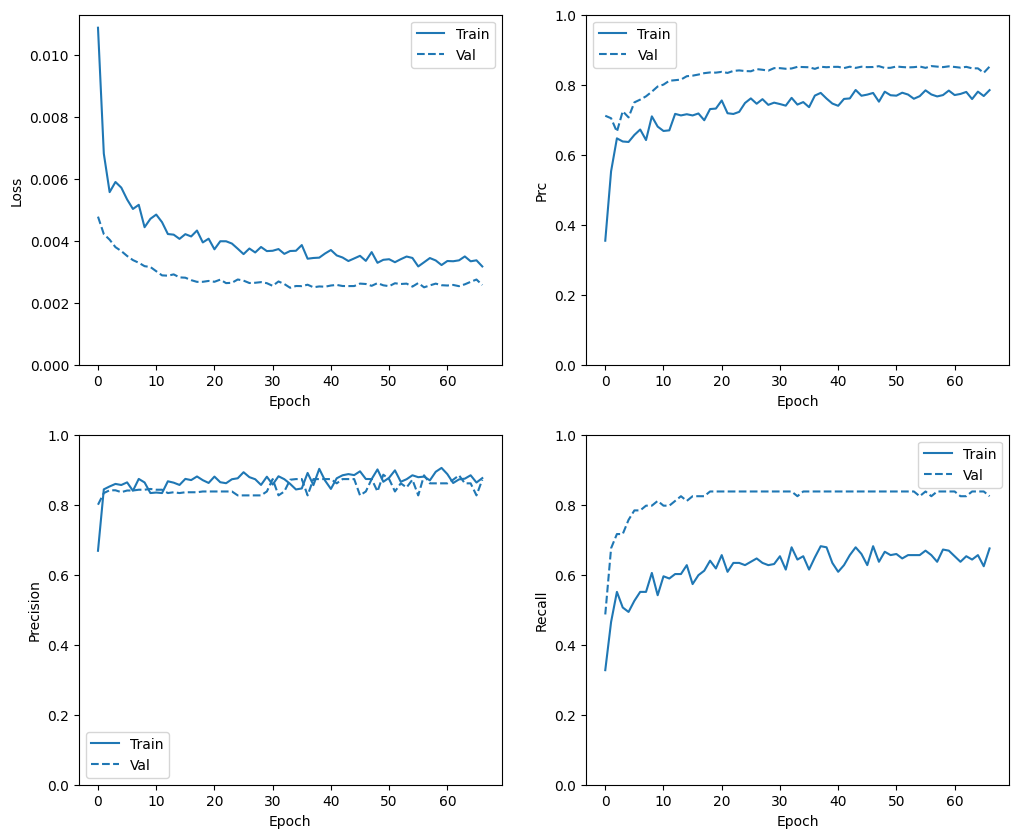

In [26]:
plot_metrics(baseline_history)

참고: 검증 곡선은 일반적으로 훈련 곡선보다 성능이 좋습니다. 이는 주로 모델을 평가할 때 drop out 레이어가 활성화 되지 않았기 때문에 발생합니다.

### 메트릭 평가

[혼동 행렬](https://developers.google.com/machine-learning/glossary/#confusion_matrix)을 사용하여 실제 레이블과 예측 레이블을 요약할 수 있습니다. 여기서 X축은 예측 레이블이고 Y축은 실제 레이블입니다.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 4s

37/90 [===========>..................] - ETA: 0s

73/90 [=======================>......] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

테스트 데이터세트에서 모델을 평가하고 위에서 생성한 메트릭 결과를 표시합니다.

loss :  0.003468161914497614
tp :  74.0
fp :  8.0
tn :  56850.0
fn :  30.0
accuracy :  0.9993329048156738
precision :  0.9024389982223511
recall :  0.7115384340286255
auc :  0.9323335289955139
prc :  0.8059106469154358

Legitimate Transactions Detected (True Negatives):  56850
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  30
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  104


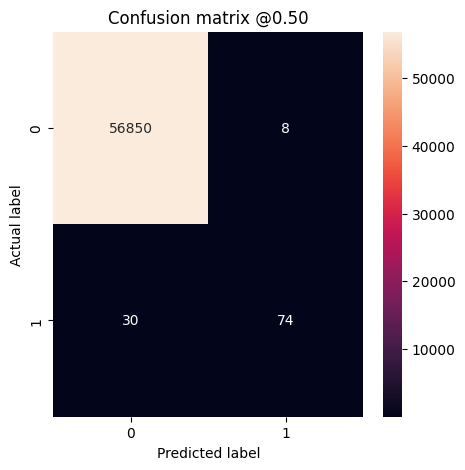

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

만약 모델이 모두 완벽하게 예측했다면 [대각행렬](https://en.wikipedia.org/wiki/Diagonal_matrix)이 되어 예측 오류를 보여주며 대각선 값은 0이 됩니다. 이와 같은 경우, 매트릭에 거짓 양성이 상대적으로 낮음을 확인할 수 있으며 이를 통해 플래그가 잘못 지정된 합법적인 거래가 상대적으로 적다는 것을 알 수 있습니다. 그러나 거짓 양성 수를 늘리더라도 거짓 음성을 더 낮추고 싶을 수 있습니다. 거짓 음성은 부정 거래가 발생할 수 있지만, 거짓 양성은 고객에게 이메일을 보내 카드 활동 확인을 요청할 수 있기 때문에 거짓 음성을 낮추는 것이 더 바람직할 수 있기 때문입니다.

### ROC 플로팅

이제 [ROC](https://developers.google.com/machine-learning/glossary#ROC)을 플로팅 하십시오. 이 그래프는 출력 임계값을 조정하기만 해도 모델이 도달할 수 있는 성능 범위를 한눈에 보여주기 때문에 유용합니다.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

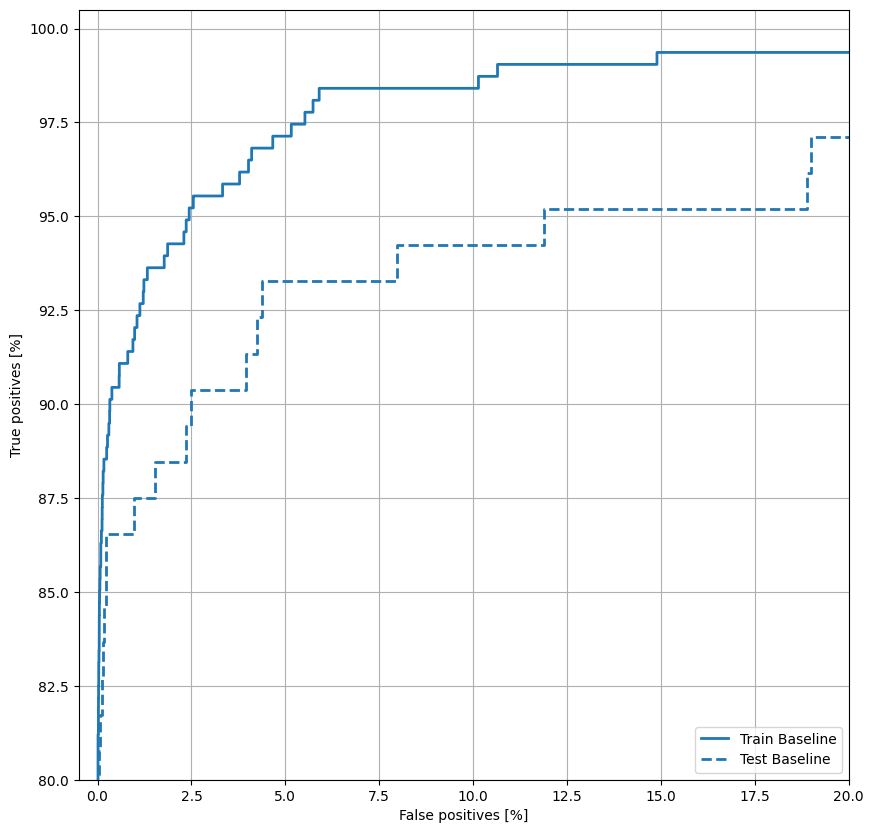

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### AUPRC 플로팅

이제 [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC)를 플로팅하겠습니다.  보간된 정밀도-재현율 곡선 아래 영역으로, 분류 임계값의 여러 값에 대한 (재현율, 정밀도) 점을 플로팅하여 얻습니다. 계산 방법에 따라 PR AUC는 모델의 평균 정밀도와 동일할 수 있습니다.


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

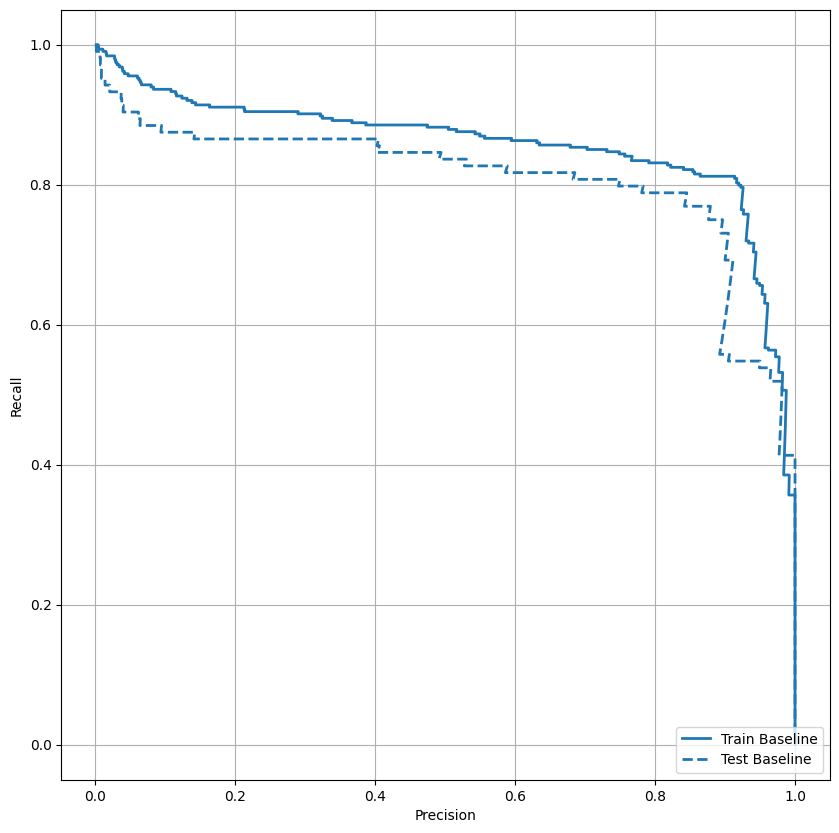

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

정밀도가 비교적 높은 것 같지만 재현율과 ROC 곡선(AUC) 아래 면적이 높지 않습니다. 분류자가 정밀도와 재현율 모두를 최대화하려고 하면 종종 어려움에 직면하는데, 불균형 데이터세트로 작업할 때 특히 그렇습니다. 관심있는 문제의 맥락에서 다른 유형의 오류 비용을 고려하는 것이 중요합니다. 이 예시에서 거짓 음성(부정 거래를 놓친 경우)은 금전적 비용이 들 수 있지만 , 거짓 양성(거래가 사기 행위로 잘못 표시됨)은 사용자 만족도를 감소시킬 수 있습니다.

## 클래스 가중치

### 클래스 가중치 계산

목표는 부정 거래를 식별하는 것이지만, 작업할 수 있는 양성 샘플이 많지 않지 않기 때문에 분류자는 이용 가능한 몇 가지 예에 가중치를 두고자 할 것입니다. 매개 변수를 통해 각 클래스에 대한 Keras 가중치를 전달한다면 이 작업을 수행할 수 있습니다. 이로 인해 모델은 더 적은 클래스 예시에 "더 많은 관심을 기울일" 수 있습니다.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### 클래스 가중치로 모델 교육

이제 해당 모델이 예측에 어떤 영향을 미치는지 확인하기 위하여 클래스 가중치로 모델을 재 교육하고 평가해 보십시오.

참고: `class_weights`를 사용하면 손실 범위가 변경됩니다. 이는 옵티마이저에 따라 훈련의 안정성에 영향을 미칠 수 있습니다. `tf.keras.optimizers.SGD`와 같이 단계 크기가 그래디언트의 크기에 따라 달라지는 옵티마이저는 실패할 수 있습니다. 여기서 사용된 옵티마이저인 `tf.keras.optimizers.Adam`은 스케일링 변경의 영향을 받지 않습니다. 또한, 가중치로 인해 총 손실은 두 모델 간에 비교할 수 없습니다.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 2:14 - loss: 6.9242 - tp: 74.0000 - fp: 8.0000 - tn: 58892.0000 - fn: 36.0000 - accuracy: 0.9993 - precision: 0.9024 - recall: 0.6727 - auc: 0.9128 - prc: 0.7576

13/90 [===>..........................] - ETA: 0s - loss: 3.2409 - tp: 78.0000 - fp: 27.0000 - tn: 83407.0000 - fn: 74.0000 - accuracy: 0.9988 - precision: 0.7429 - recall: 0.5132 - auc: 0.8582 - prc: 0.5658 

25/90 [=======>......................] - ETA: 0s - loss: 2.8159 - tp: 88.0000 - fp: 38.0000 - tn: 107926.0000 - fn: 110.0000 - accuracy: 0.9986 - precision: 0.6984 - recall: 0.4444 - auc: 0.8314 - prc: 0.4755

37/90 [===========>..................] - ETA: 0s - loss: 2.5021 - tp: 92.0000 - fp: 51.0000 - tn: 132454.0000 - fn: 141.0000 - accuracy: 0.9986 - precision: 0.6434 - recall: 0.3948 - auc: 0.8274 - prc: 0.4247

49/90 [===============>..............] - ETA: 0s - loss: 2.3540 - tp: 105.0000 - fp: 67.0000 - tn: 156968.0000 - fn: 174.0000 - accuracy: 0.9985 - precision: 0.6105 - recall: 0.3763 - auc: 0.8218 - prc: 0.3918

61/90 [===================>..........] - ETA: 0s - loss: 2.2023 - tp: 113.0000 - fp: 85.0000 - tn: 181491.0000 - fn: 201.0000 - accuracy: 0.9984 - precision: 0.5707 - recall: 0.3599 - auc: 0.8178 - prc: 0.3695

73/90 [=======================>......] - ETA: 0s - loss: 2.1719 - tp: 124.0000 - fp: 112.0000 - tn: 205992.0000 - fn: 238.0000 - accuracy: 0.9983 - precision: 0.5254 - recall: 0.3425 - auc: 0.8147 - prc: 0.3453

85/90 [===========================>..] - ETA: 0s - loss: 2.0381 - tp: 146.0000 - fp: 145.0000 - tn: 230492.0000 - fn: 259.0000 - accuracy: 0.9983 - precision: 0.5017 - recall: 0.3605 - auc: 0.8183 - prc: 0.3497

90/90 [==============================] - 3s 11ms/step - loss: 2.0359 - tp: 150.0000 - fp: 155.0000 - tn: 238665.0000 - fn: 268.0000 - accuracy: 0.9982 - precision: 0.4918 - recall: 0.3589 - auc: 0.8151 - prc: 0.3412 - val_loss: 0.0062 - val_tp: 50.0000 - val_fp: 11.0000 - val_tn: 45484.0000 - val_fn: 24.0000 - val_accuracy: 0.9992 - val_precision: 0.8197 - val_recall: 0.6757 - val_auc: 0.9237 - val_prc: 0.6484


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 1.3787 - tp: 0.0000e+00 - fp: 4.0000 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9976 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4003 - prc: 3.6502e-04

13/90 [===>..........................] - ETA: 0s - loss: 1.0670 - tp: 13.0000 - fp: 30.0000 - tn: 26560.0000 - fn: 21.0000 - accuracy: 0.9981 - precision: 0.3023 - recall: 0.3824 - auc: 0.8564 - prc: 0.2990            

25/90 [=======>......................] - ETA: 0s - loss: 1.1674 - tp: 41.0000 - fp: 62.0000 - tn: 51052.0000 - fn: 45.0000 - accuracy: 0.9979 - precision: 0.3981 - recall: 0.4767 - auc: 0.8719 - prc: 0.3936

37/90 [===========>..................] - ETA: 0s - loss: 1.1743 - tp: 62.0000 - fp: 97.0000 - tn: 75547.0000 - fn: 70.0000 - accuracy: 0.9978 - precision: 0.3899 - recall: 0.4697 - auc: 0.8694 - prc: 0.3830

49/90 [===============>..............] - ETA: 0s - loss: 1.1906 - tp: 92.0000 - fp: 127.0000 - tn: 100042.0000 - fn: 91.0000 - accuracy: 0.9978 - precision: 0.4201 - recall: 0.5027 - auc: 0.8658 - prc: 0.4199

60/90 [===================>..........] - ETA: 0s - loss: 1.1198 - tp: 117.0000 - fp: 158.0000 - tn: 122502.0000 - fn: 103.0000 - accuracy: 0.9979 - precision: 0.4255 - recall: 0.5318 - auc: 0.8676 - prc: 0.4349

71/90 [======================>.......] - ETA: 0s - loss: 1.0626 - tp: 140.0000 - fp: 195.0000 - tn: 144959.0000 - fn: 114.0000 - accuracy: 0.9979 - precision: 0.4179 - recall: 0.5512 - auc: 0.8693 - prc: 0.4448

82/90 [==========================>...] - ETA: 0s - loss: 1.0381 - tp: 162.0000 - fp: 230.0000 - tn: 167419.0000 - fn: 125.0000 - accuracy: 0.9979 - precision: 0.4133 - recall: 0.5645 - auc: 0.8634 - prc: 0.4397

90/90 [==============================] - 1s 6ms/step - loss: 1.0229 - tp: 179.0000 - fp: 244.0000 - tn: 181718.0000 - fn: 135.0000 - accuracy: 0.9979 - precision: 0.4232 - recall: 0.5701 - auc: 0.8656 - prc: 0.4522 - val_loss: 0.0076 - val_tp: 61.0000 - val_fp: 15.0000 - val_tn: 45480.0000 - val_fn: 13.0000 - val_accuracy: 0.9994 - val_precision: 0.8026 - val_recall: 0.8243 - val_auc: 0.9462 - val_prc: 0.6712


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 1.0421 - tp: 1.0000 - fp: 6.0000 - tn: 2039.0000 - fn: 2.0000 - accuracy: 0.9961 - precision: 0.1429 - recall: 0.3333 - auc: 0.7854 - prc: 0.2029

13/90 [===>..........................] - ETA: 0s - loss: 0.8051 - tp: 22.0000 - fp: 57.0000 - tn: 26527.0000 - fn: 18.0000 - accuracy: 0.9972 - precision: 0.2785 - recall: 0.5500 - auc: 0.8900 - prc: 0.4089

25/90 [=======>......................] - ETA: 0s - loss: 0.8359 - tp: 42.0000 - fp: 116.0000 - tn: 51008.0000 - fn: 34.0000 - accuracy: 0.9971 - precision: 0.2658 - recall: 0.5526 - auc: 0.8727 - prc: 0.4252

37/90 [===========>..................] - ETA: 0s - loss: 0.8701 - tp: 59.0000 - fp: 176.0000 - tn: 75488.0000 - fn: 53.0000 - accuracy: 0.9970 - precision: 0.2511 - recall: 0.5268 - auc: 0.8694 - prc: 0.3818

49/90 [===============>..............] - ETA: 0s - loss: 0.7896 - tp: 90.0000 - fp: 246.0000 - tn: 99950.0000 - fn: 66.0000 - accuracy: 0.9969 - precision: 0.2679 - recall: 0.5769 - auc: 0.8863 - prc: 0.4427

61/90 [===================>..........] - ETA: 0s - loss: 0.7388 - tp: 115.0000 - fp: 315.0000 - tn: 124421.0000 - fn: 77.0000 - accuracy: 0.9969 - precision: 0.2674 - recall: 0.5990 - auc: 0.8911 - prc: 0.4428

73/90 [=======================>......] - ETA: 0s - loss: 0.7829 - tp: 151.0000 - fp: 370.0000 - tn: 148882.0000 - fn: 101.0000 - accuracy: 0.9968 - precision: 0.2898 - recall: 0.5992 - auc: 0.9013 - prc: 0.4567

85/90 [===========================>..] - ETA: 0s - loss: 0.8375 - tp: 179.0000 - fp: 430.0000 - tn: 173348.0000 - fn: 123.0000 - accuracy: 0.9968 - precision: 0.2939 - recall: 0.5927 - auc: 0.8956 - prc: 0.4570

90/90 [==============================] - 1s 6ms/step - loss: 0.8179 - tp: 189.0000 - fp: 452.0000 - tn: 181510.0000 - fn: 125.0000 - accuracy: 0.9968 - precision: 0.2949 - recall: 0.6019 - auc: 0.8968 - prc: 0.4678 - val_loss: 0.0103 - val_tp: 62.0000 - val_fp: 25.0000 - val_tn: 45470.0000 - val_fn: 12.0000 - val_accuracy: 0.9992 - val_precision: 0.7126 - val_recall: 0.8378 - val_auc: 0.9649 - val_prc: 0.7120


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.5580 - tp: 1.0000 - fp: 6.0000 - tn: 2040.0000 - fn: 1.0000 - accuracy: 0.9966 - precision: 0.1429 - recall: 0.5000 - auc: 0.9594 - prc: 0.5044

13/90 [===>..........................] - ETA: 0s - loss: 0.6168 - tp: 27.0000 - fp: 75.0000 - tn: 26509.0000 - fn: 13.0000 - accuracy: 0.9967 - precision: 0.2647 - recall: 0.6750 - auc: 0.9232 - prc: 0.4657

25/90 [=======>......................] - ETA: 0s - loss: 0.6002 - tp: 66.0000 - fp: 160.0000 - tn: 50951.0000 - fn: 23.0000 - accuracy: 0.9964 - precision: 0.2920 - recall: 0.7416 - auc: 0.9186 - prc: 0.5392

37/90 [===========>..................] - ETA: 0s - loss: 0.6674 - tp: 90.0000 - fp: 244.0000 - tn: 75404.0000 - fn: 38.0000 - accuracy: 0.9963 - precision: 0.2695 - recall: 0.7031 - auc: 0.8972 - prc: 0.5100

49/90 [===============>..............] - ETA: 0s - loss: 0.5978 - tp: 129.0000 - fp: 342.0000 - tn: 99835.0000 - fn: 46.0000 - accuracy: 0.9961 - precision: 0.2739 - recall: 0.7371 - auc: 0.9156 - prc: 0.5527

61/90 [===================>..........] - ETA: 0s - loss: 0.6479 - tp: 155.0000 - fp: 456.0000 - tn: 124256.0000 - fn: 61.0000 - accuracy: 0.9959 - precision: 0.2537 - recall: 0.7176 - auc: 0.9058 - prc: 0.5153

73/90 [=======================>......] - ETA: 0s - loss: 0.6296 - tp: 194.0000 - fp: 553.0000 - tn: 148687.0000 - fn: 70.0000 - accuracy: 0.9958 - precision: 0.2597 - recall: 0.7348 - auc: 0.9098 - prc: 0.5388

85/90 [===========================>..] - ETA: 0s - loss: 0.5905 - tp: 222.0000 - fp: 667.0000 - tn: 173113.0000 - fn: 78.0000 - accuracy: 0.9957 - precision: 0.2497 - recall: 0.7400 - auc: 0.9127 - prc: 0.5302

90/90 [==============================] - 1s 6ms/step - loss: 0.5910 - tp: 231.0000 - fp: 707.0000 - tn: 181255.0000 - fn: 83.0000 - accuracy: 0.9957 - precision: 0.2463 - recall: 0.7357 - auc: 0.9136 - prc: 0.5209 - val_loss: 0.0137 - val_tp: 63.0000 - val_fp: 46.0000 - val_tn: 45449.0000 - val_fn: 11.0000 - val_accuracy: 0.9987 - val_precision: 0.5780 - val_recall: 0.8514 - val_auc: 0.9720 - val_prc: 0.7136


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0142 - tp: 1.0000 - fp: 8.0000 - tn: 2039.0000 - fn: 0.0000e+00 - accuracy: 0.9961 - precision: 0.1111 - recall: 1.0000 - auc: 0.9990 - prc: 0.1891

13/90 [===>..........................] - ETA: 0s - loss: 0.4385 - tp: 34.0000 - fp: 137.0000 - tn: 26445.0000 - fn: 8.0000 - accuracy: 0.9946 - precision: 0.1988 - recall: 0.8095 - auc: 0.9177 - prc: 0.5286

25/90 [=======>......................] - ETA: 0s - loss: 0.5243 - tp: 69.0000 - fp: 275.0000 - tn: 50837.0000 - fn: 19.0000 - accuracy: 0.9943 - precision: 0.2006 - recall: 0.7841 - auc: 0.9134 - prc: 0.4938

37/90 [===========>..................] - ETA: 0s - loss: 0.5173 - tp: 109.0000 - fp: 433.0000 - tn: 75203.0000 - fn: 31.0000 - accuracy: 0.9939 - precision: 0.2011 - recall: 0.7786 - auc: 0.9242 - prc: 0.5194

49/90 [===============>..............] - ETA: 0s - loss: 0.4794 - tp: 140.0000 - fp: 602.0000 - tn: 99569.0000 - fn: 41.0000 - accuracy: 0.9936 - precision: 0.1887 - recall: 0.7735 - auc: 0.9346 - prc: 0.4980

61/90 [===================>..........] - ETA: 0s - loss: 0.4387 - tp: 171.0000 - fp: 799.0000 - tn: 123911.0000 - fn: 47.0000 - accuracy: 0.9932 - precision: 0.1763 - recall: 0.7844 - auc: 0.9392 - prc: 0.4871

73/90 [=======================>......] - ETA: 0s - loss: 0.4041 - tp: 206.0000 - fp: 998.0000 - tn: 148246.0000 - fn: 54.0000 - accuracy: 0.9930 - precision: 0.1711 - recall: 0.7923 - auc: 0.9466 - prc: 0.4894

85/90 [===========================>..] - ETA: 0s - loss: 0.4227 - tp: 239.0000 - fp: 1240.0000 - tn: 172537.0000 - fn: 64.0000 - accuracy: 0.9925 - precision: 0.1616 - recall: 0.7888 - auc: 0.9456 - prc: 0.4965

90/90 [==============================] - 1s 6ms/step - loss: 0.4221 - tp: 246.0000 - fp: 1329.0000 - tn: 180633.0000 - fn: 68.0000 - accuracy: 0.9923 - precision: 0.1562 - recall: 0.7834 - auc: 0.9458 - prc: 0.4880 - val_loss: 0.0196 - val_tp: 63.0000 - val_fp: 98.0000 - val_tn: 45397.0000 - val_fn: 11.0000 - val_accuracy: 0.9976 - val_precision: 0.3913 - val_recall: 0.8514 - val_auc: 0.9780 - val_prc: 0.7362


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0203 - tp: 0.0000e+00 - fp: 20.0000 - tn: 2028.0000 - fn: 0.0000e+00 - accuracy: 0.9902 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

13/90 [===>..........................] - ETA: 0s - loss: 0.4399 - tp: 38.0000 - fp: 247.0000 - tn: 26329.0000 - fn: 10.0000 - accuracy: 0.9903 - precision: 0.1333 - recall: 0.7917 - auc: 0.9450 - prc: 0.4689                    

24/90 [=======>......................] - ETA: 0s - loss: 0.4369 - tp: 68.0000 - fp: 468.0000 - tn: 48597.0000 - fn: 19.0000 - accuracy: 0.9901 - precision: 0.1269 - recall: 0.7816 - auc: 0.9444 - prc: 0.4376

35/90 [==========>...................] - ETA: 0s - loss: 0.4172 - tp: 105.0000 - fp: 713.0000 - tn: 70833.0000 - fn: 29.0000 - accuracy: 0.9896 - precision: 0.1284 - recall: 0.7836 - auc: 0.9568 - prc: 0.4553

47/90 [==============>...............] - ETA: 0s - loss: 0.3890 - tp: 141.0000 - fp: 999.0000 - tn: 95083.0000 - fn: 33.0000 - accuracy: 0.9893 - precision: 0.1237 - recall: 0.8103 - auc: 0.9514 - prc: 0.4554

59/90 [==================>...........] - ETA: 0s - loss: 0.3963 - tp: 176.0000 - fp: 1304.0000 - tn: 119308.0000 - fn: 44.0000 - accuracy: 0.9888 - precision: 0.1189 - recall: 0.8000 - auc: 0.9508 - prc: 0.4638

70/90 [======================>.......] - ETA: 0s - loss: 0.3914 - tp: 204.0000 - fp: 1615.0000 - tn: 141490.0000 - fn: 51.0000 - accuracy: 0.9884 - precision: 0.1121 - recall: 0.8000 - auc: 0.9512 - prc: 0.4410

82/90 [==========================>...] - ETA: 0s - loss: 0.3617 - tp: 228.0000 - fp: 1937.0000 - tn: 165717.0000 - fn: 54.0000 - accuracy: 0.9881 - precision: 0.1053 - recall: 0.8085 - auc: 0.9514 - prc: 0.4172

90/90 [==============================] - 1s 6ms/step - loss: 0.3619 - tp: 254.0000 - fp: 2135.0000 - tn: 179827.0000 - fn: 60.0000 - accuracy: 0.9880 - precision: 0.1063 - recall: 0.8089 - auc: 0.9538 - prc: 0.4209 - val_loss: 0.0279 - val_tp: 66.0000 - val_fp: 198.0000 - val_tn: 45297.0000 - val_fn: 8.0000 - val_accuracy: 0.9955 - val_precision: 0.2500 - val_recall: 0.8919 - val_auc: 0.9854 - val_prc: 0.6866


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.4798 - tp: 2.0000 - fp: 25.0000 - tn: 2020.0000 - fn: 1.0000 - accuracy: 0.9873 - precision: 0.0741 - recall: 0.6667 - auc: 0.9575 - prc: 0.4467

13/90 [===>..........................] - ETA: 0s - loss: 0.3582 - tp: 41.0000 - fp: 384.0000 - tn: 26190.0000 - fn: 9.0000 - accuracy: 0.9852 - precision: 0.0965 - recall: 0.8200 - auc: 0.9558 - prc: 0.4266

25/90 [=======>......................] - ETA: 0s - loss: 0.3294 - tp: 74.0000 - fp: 765.0000 - tn: 50344.0000 - fn: 17.0000 - accuracy: 0.9847 - precision: 0.0882 - recall: 0.8132 - auc: 0.9607 - prc: 0.3750

37/90 [===========>..................] - ETA: 0s - loss: 0.3458 - tp: 113.0000 - fp: 1168.0000 - tn: 74469.0000 - fn: 26.0000 - accuracy: 0.9842 - precision: 0.0882 - recall: 0.8129 - auc: 0.9577 - prc: 0.3622

49/90 [===============>..............] - ETA: 0s - loss: 0.3134 - tp: 139.0000 - fp: 1562.0000 - tn: 98620.0000 - fn: 31.0000 - accuracy: 0.9841 - precision: 0.0817 - recall: 0.8176 - auc: 0.9604 - prc: 0.3501

61/90 [===================>..........] - ETA: 0s - loss: 0.3338 - tp: 175.0000 - fp: 2026.0000 - tn: 122687.0000 - fn: 40.0000 - accuracy: 0.9835 - precision: 0.0795 - recall: 0.8140 - auc: 0.9550 - prc: 0.3415

73/90 [=======================>......] - ETA: 0s - loss: 0.3414 - tp: 211.0000 - fp: 2518.0000 - tn: 146728.0000 - fn: 47.0000 - accuracy: 0.9828 - precision: 0.0773 - recall: 0.8178 - auc: 0.9521 - prc: 0.3423

85/90 [===========================>..] - ETA: 0s - loss: 0.3140 - tp: 243.0000 - fp: 3020.0000 - tn: 170768.0000 - fn: 49.0000 - accuracy: 0.9824 - precision: 0.0745 - recall: 0.8322 - auc: 0.9541 - prc: 0.3398

90/90 [==============================] - 1s 6ms/step - loss: 0.3156 - tp: 261.0000 - fp: 3182.0000 - tn: 178780.0000 - fn: 53.0000 - accuracy: 0.9823 - precision: 0.0758 - recall: 0.8312 - auc: 0.9560 - prc: 0.3469 - val_loss: 0.0379 - val_tp: 66.0000 - val_fp: 328.0000 - val_tn: 45167.0000 - val_fn: 8.0000 - val_accuracy: 0.9926 - val_precision: 0.1675 - val_recall: 0.8919 - val_auc: 0.9900 - val_prc: 0.6526


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0400 - tp: 3.0000 - fp: 41.0000 - tn: 2004.0000 - fn: 0.0000e+00 - accuracy: 0.9800 - precision: 0.0682 - recall: 1.0000 - auc: 0.9990 - prc: 0.4286

13/90 [===>..........................] - ETA: 0s - loss: 0.1550 - tp: 39.0000 - fp: 552.0000 - tn: 26030.0000 - fn: 3.0000 - accuracy: 0.9792 - precision: 0.0660 - recall: 0.9286 - auc: 0.9760 - prc: 0.3077 

25/90 [=======>......................] - ETA: 0s - loss: 0.3110 - tp: 74.0000 - fp: 1090.0000 - tn: 50022.0000 - fn: 14.0000 - accuracy: 0.9784 - precision: 0.0636 - recall: 0.8409 - auc: 0.9535 - prc: 0.2935

37/90 [===========>..................] - ETA: 0s - loss: 0.4170 - tp: 105.0000 - fp: 1626.0000 - tn: 74018.0000 - fn: 27.0000 - accuracy: 0.9782 - precision: 0.0607 - recall: 0.7955 - auc: 0.9341 - prc: 0.2736

49/90 [===============>..............] - ETA: 0s - loss: 0.3632 - tp: 136.0000 - fp: 2196.0000 - tn: 97989.0000 - fn: 31.0000 - accuracy: 0.9778 - precision: 0.0583 - recall: 0.8144 - auc: 0.9430 - prc: 0.2760

61/90 [===================>..........] - ETA: 0s - loss: 0.3614 - tp: 168.0000 - fp: 2805.0000 - tn: 121916.0000 - fn: 39.0000 - accuracy: 0.9772 - precision: 0.0565 - recall: 0.8116 - auc: 0.9404 - prc: 0.2713

73/90 [=======================>......] - ETA: 0s - loss: 0.3539 - tp: 209.0000 - fp: 3415.0000 - tn: 145835.0000 - fn: 45.0000 - accuracy: 0.9769 - precision: 0.0577 - recall: 0.8228 - auc: 0.9432 - prc: 0.2823

85/90 [===========================>..] - ETA: 0s - loss: 0.3428 - tp: 250.0000 - fp: 4025.0000 - tn: 169753.0000 - fn: 52.0000 - accuracy: 0.9766 - precision: 0.0585 - recall: 0.8278 - auc: 0.9469 - prc: 0.2883

90/90 [==============================] - 1s 6ms/step - loss: 0.3293 - tp: 262.0000 - fp: 4228.0000 - tn: 177734.0000 - fn: 52.0000 - accuracy: 0.9765 - precision: 0.0584 - recall: 0.8344 - auc: 0.9488 - prc: 0.2940 - val_loss: 0.0480 - val_tp: 67.0000 - val_fp: 502.0000 - val_tn: 44993.0000 - val_fn: 7.0000 - val_accuracy: 0.9888 - val_precision: 0.1178 - val_recall: 0.9054 - val_auc: 0.9919 - val_prc: 0.6263


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 0.0514 - tp: 1.0000 - fp: 59.0000 - tn: 1988.0000 - fn: 0.0000e+00 - accuracy: 0.9712 - precision: 0.0167 - recall: 1.0000 - auc: 0.9985 - prc: 0.1429

13/90 [===>..........................] - ETA: 0s - loss: 0.3694 - tp: 34.0000 - fp: 707.0000 - tn: 25876.0000 - fn: 7.0000 - accuracy: 0.9732 - precision: 0.0459 - recall: 0.8293 - auc: 0.9252 - prc: 0.2495 

25/90 [=======>......................] - ETA: 0s - loss: 0.3486 - tp: 83.0000 - fp: 1337.0000 - tn: 49768.0000 - fn: 12.0000 - accuracy: 0.9737 - precision: 0.0585 - recall: 0.8737 - auc: 0.9405 - prc: 0.2847

37/90 [===========>..................] - ETA: 0s - loss: 0.2891 - tp: 115.0000 - fp: 1959.0000 - tn: 73686.0000 - fn: 16.0000 - accuracy: 0.9739 - precision: 0.0554 - recall: 0.8779 - auc: 0.9530 - prc: 0.2679

49/90 [===============>..............] - ETA: 0s - loss: 0.2757 - tp: 152.0000 - fp: 2597.0000 - tn: 97582.0000 - fn: 21.0000 - accuracy: 0.9739 - precision: 0.0553 - recall: 0.8786 - auc: 0.9561 - prc: 0.2844

61/90 [===================>..........] - ETA: 0s - loss: 0.2698 - tp: 190.0000 - fp: 3239.0000 - tn: 121473.0000 - fn: 26.0000 - accuracy: 0.9739 - precision: 0.0554 - recall: 0.8796 - auc: 0.9580 - prc: 0.2794

73/90 [=======================>......] - ETA: 0s - loss: 0.2665 - tp: 225.0000 - fp: 3887.0000 - tn: 145360.0000 - fn: 32.0000 - accuracy: 0.9738 - precision: 0.0547 - recall: 0.8755 - auc: 0.9605 - prc: 0.2771

85/90 [===========================>..] - ETA: 0s - loss: 0.2788 - tp: 265.0000 - fp: 4533.0000 - tn: 169244.0000 - fn: 38.0000 - accuracy: 0.9737 - precision: 0.0552 - recall: 0.8746 - auc: 0.9566 - prc: 0.2783

90/90 [==============================] - 1s 6ms/step - loss: 0.2882 - tp: 272.0000 - fp: 4740.0000 - tn: 177222.0000 - fn: 42.0000 - accuracy: 0.9738 - precision: 0.0543 - recall: 0.8662 - auc: 0.9553 - prc: 0.2709 - val_loss: 0.0531 - val_tp: 67.0000 - val_fp: 558.0000 - val_tn: 44937.0000 - val_fn: 7.0000 - val_accuracy: 0.9876 - val_precision: 0.1072 - val_recall: 0.9054 - val_auc: 0.9927 - val_prc: 0.6019


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0554 - tp: 4.0000 - fp: 61.0000 - tn: 1983.0000 - fn: 0.0000e+00 - accuracy: 0.9702 - precision: 0.0615 - recall: 1.0000 - auc: 0.9983 - prc: 0.3636

13/90 [===>..........................] - ETA: 0s - loss: 0.1873 - tp: 42.0000 - fp: 724.0000 - tn: 25855.0000 - fn: 3.0000 - accuracy: 0.9727 - precision: 0.0548 - recall: 0.9333 - auc: 0.9695 - prc: 0.3300 

25/90 [=======>......................] - ETA: 0s - loss: 0.1942 - tp: 78.0000 - fp: 1383.0000 - tn: 49732.0000 - fn: 7.0000 - accuracy: 0.9729 - precision: 0.0534 - recall: 0.9176 - auc: 0.9713 - prc: 0.2987

37/90 [===========>..................] - ETA: 0s - loss: 0.2930 - tp: 105.0000 - fp: 2099.0000 - tn: 73553.0000 - fn: 19.0000 - accuracy: 0.9720 - precision: 0.0476 - recall: 0.8468 - auc: 0.9521 - prc: 0.2658

49/90 [===============>..............] - ETA: 0s - loss: 0.2713 - tp: 144.0000 - fp: 2812.0000 - tn: 97371.0000 - fn: 25.0000 - accuracy: 0.9717 - precision: 0.0487 - recall: 0.8521 - auc: 0.9609 - prc: 0.2713

61/90 [===================>..........] - ETA: 0s - loss: 0.2466 - tp: 181.0000 - fp: 3576.0000 - tn: 121144.0000 - fn: 27.0000 - accuracy: 0.9712 - precision: 0.0482 - recall: 0.8702 - auc: 0.9649 - prc: 0.2693

73/90 [=======================>......] - ETA: 0s - loss: 0.2531 - tp: 214.0000 - fp: 4363.0000 - tn: 144892.0000 - fn: 35.0000 - accuracy: 0.9706 - precision: 0.0468 - recall: 0.8594 - auc: 0.9628 - prc: 0.2488

85/90 [===========================>..] - ETA: 0s - loss: 0.2577 - tp: 260.0000 - fp: 5106.0000 - tn: 168674.0000 - fn: 40.0000 - accuracy: 0.9704 - precision: 0.0485 - recall: 0.8667 - auc: 0.9622 - prc: 0.2580

90/90 [==============================] - 1s 6ms/step - loss: 0.2583 - tp: 273.0000 - fp: 5368.0000 - tn: 176594.0000 - fn: 41.0000 - accuracy: 0.9703 - precision: 0.0484 - recall: 0.8694 - auc: 0.9612 - prc: 0.2619 - val_loss: 0.0619 - val_tp: 67.0000 - val_fp: 632.0000 - val_tn: 44863.0000 - val_fn: 7.0000 - val_accuracy: 0.9860 - val_precision: 0.0959 - val_recall: 0.9054 - val_auc: 0.9932 - val_prc: 0.5846


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.0660 - tp: 2.0000 - fp: 60.0000 - tn: 1986.0000 - fn: 0.0000e+00 - accuracy: 0.9707 - precision: 0.0323 - recall: 1.0000 - auc: 0.9976 - prc: 0.1667

13/90 [===>..........................] - ETA: 0s - loss: 0.1914 - tp: 43.0000 - fp: 843.0000 - tn: 25736.0000 - fn: 2.0000 - accuracy: 0.9683 - precision: 0.0485 - recall: 0.9556 - auc: 0.9655 - prc: 0.2585 

25/90 [=======>......................] - ETA: 0s - loss: 0.1937 - tp: 89.0000 - fp: 1602.0000 - tn: 49501.0000 - fn: 8.0000 - accuracy: 0.9686 - precision: 0.0526 - recall: 0.9175 - auc: 0.9765 - prc: 0.2741

37/90 [===========>..................] - ETA: 0s - loss: 0.2246 - tp: 121.0000 - fp: 2334.0000 - tn: 73306.0000 - fn: 15.0000 - accuracy: 0.9690 - precision: 0.0493 - recall: 0.8897 - auc: 0.9690 - prc: 0.2621

49/90 [===============>..............] - ETA: 0s - loss: 0.2174 - tp: 161.0000 - fp: 3149.0000 - tn: 97022.0000 - fn: 20.0000 - accuracy: 0.9684 - precision: 0.0486 - recall: 0.8895 - auc: 0.9720 - prc: 0.2601

61/90 [===================>..........] - ETA: 0s - loss: 0.2300 - tp: 190.0000 - fp: 3943.0000 - tn: 120767.0000 - fn: 28.0000 - accuracy: 0.9682 - precision: 0.0460 - recall: 0.8716 - auc: 0.9715 - prc: 0.2478

73/90 [=======================>......] - ETA: 0s - loss: 0.2244 - tp: 230.0000 - fp: 4756.0000 - tn: 144487.0000 - fn: 31.0000 - accuracy: 0.9680 - precision: 0.0461 - recall: 0.8812 - auc: 0.9719 - prc: 0.2458

85/90 [===========================>..] - ETA: 0s - loss: 0.2381 - tp: 269.0000 - fp: 5670.0000 - tn: 168105.0000 - fn: 36.0000 - accuracy: 0.9672 - precision: 0.0453 - recall: 0.8820 - auc: 0.9667 - prc: 0.2369

90/90 [==============================] - 1s 6ms/step - loss: 0.2378 - tp: 277.0000 - fp: 5948.0000 - tn: 176014.0000 - fn: 37.0000 - accuracy: 0.9672 - precision: 0.0445 - recall: 0.8822 - auc: 0.9657 - prc: 0.2346 - val_loss: 0.0676 - val_tp: 67.0000 - val_fp: 692.0000 - val_tn: 44803.0000 - val_fn: 7.0000 - val_accuracy: 0.9847 - val_precision: 0.0883 - val_recall: 0.9054 - val_auc: 0.9930 - val_prc: 0.5360


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0607 - tp: 3.0000 - fp: 61.0000 - tn: 1984.0000 - fn: 0.0000e+00 - accuracy: 0.9702 - precision: 0.0469 - recall: 1.0000 - auc: 0.9980 - prc: 0.2727

13/90 [===>..........................] - ETA: 0s - loss: 0.3579 - tp: 33.0000 - fp: 887.0000 - tn: 25697.0000 - fn: 7.0000 - accuracy: 0.9664 - precision: 0.0359 - recall: 0.8250 - auc: 0.9202 - prc: 0.1574 

25/90 [=======>......................] - ETA: 0s - loss: 0.3143 - tp: 68.0000 - fp: 1744.0000 - tn: 49375.0000 - fn: 13.0000 - accuracy: 0.9657 - precision: 0.0375 - recall: 0.8395 - auc: 0.9414 - prc: 0.1872

37/90 [===========>..................] - ETA: 0s - loss: 0.2855 - tp: 116.0000 - fp: 2536.0000 - tn: 73107.0000 - fn: 17.0000 - accuracy: 0.9663 - precision: 0.0437 - recall: 0.8722 - auc: 0.9527 - prc: 0.2213

49/90 [===============>..............] - ETA: 0s - loss: 0.3151 - tp: 151.0000 - fp: 3400.0000 - tn: 96776.0000 - fn: 25.0000 - accuracy: 0.9659 - precision: 0.0425 - recall: 0.8580 - auc: 0.9467 - prc: 0.2133

61/90 [===================>..........] - ETA: 0s - loss: 0.2881 - tp: 186.0000 - fp: 4266.0000 - tn: 120448.0000 - fn: 28.0000 - accuracy: 0.9656 - precision: 0.0418 - recall: 0.8692 - auc: 0.9517 - prc: 0.2128

73/90 [=======================>......] - ETA: 0s - loss: 0.2759 - tp: 224.0000 - fp: 5098.0000 - tn: 144148.0000 - fn: 34.0000 - accuracy: 0.9657 - precision: 0.0421 - recall: 0.8682 - auc: 0.9562 - prc: 0.2175

85/90 [===========================>..] - ETA: 0s - loss: 0.2891 - tp: 260.0000 - fp: 5962.0000 - tn: 167817.0000 - fn: 41.0000 - accuracy: 0.9655 - precision: 0.0418 - recall: 0.8638 - auc: 0.9533 - prc: 0.2131

90/90 [==============================] - 1s 6ms/step - loss: 0.2927 - tp: 271.0000 - fp: 6239.0000 - tn: 175723.0000 - fn: 43.0000 - accuracy: 0.9655 - precision: 0.0416 - recall: 0.8631 - auc: 0.9521 - prc: 0.2106 - val_loss: 0.0726 - val_tp: 67.0000 - val_fp: 745.0000 - val_tn: 44750.0000 - val_fn: 7.0000 - val_accuracy: 0.9835 - val_precision: 0.0825 - val_recall: 0.9054 - val_auc: 0.9934 - val_prc: 0.5083


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.1774 - tp: 3.0000 - fp: 99.0000 - tn: 1946.0000 - fn: 0.0000e+00 - accuracy: 0.9517 - precision: 0.0294 - recall: 1.0000 - auc: 0.9823 - prc: 0.0828

13/90 [===>..........................] - ETA: 0s - loss: 0.3409 - tp: 37.0000 - fp: 1000.0000 - tn: 25580.0000 - fn: 7.0000 - accuracy: 0.9622 - precision: 0.0357 - recall: 0.8409 - auc: 0.9408 - prc: 0.1664

25/90 [=======>......................] - ETA: 0s - loss: 0.3292 - tp: 80.0000 - fp: 1880.0000 - tn: 49227.0000 - fn: 13.0000 - accuracy: 0.9630 - precision: 0.0408 - recall: 0.8602 - auc: 0.9494 - prc: 0.2008

36/90 [===========>..................] - ETA: 0s - loss: 0.3270 - tp: 114.0000 - fp: 2699.0000 - tn: 70896.0000 - fn: 19.0000 - accuracy: 0.9631 - precision: 0.0405 - recall: 0.8571 - auc: 0.9455 - prc: 0.2099

48/90 [===============>..............] - ETA: 0s - loss: 0.2841 - tp: 148.0000 - fp: 3614.0000 - tn: 94521.0000 - fn: 21.0000 - accuracy: 0.9630 - precision: 0.0393 - recall: 0.8757 - auc: 0.9528 - prc: 0.2103

60/90 [===================>..........] - ETA: 0s - loss: 0.2613 - tp: 183.0000 - fp: 4544.0000 - tn: 118127.0000 - fn: 26.0000 - accuracy: 0.9628 - precision: 0.0387 - recall: 0.8756 - auc: 0.9592 - prc: 0.2094

72/90 [=======================>......] - ETA: 0s - loss: 0.2536 - tp: 213.0000 - fp: 5443.0000 - tn: 141769.0000 - fn: 31.0000 - accuracy: 0.9629 - precision: 0.0377 - recall: 0.8730 - auc: 0.9600 - prc: 0.2057

84/90 [===========================>..] - ETA: 0s - loss: 0.2555 - tp: 255.0000 - fp: 6382.0000 - tn: 165359.0000 - fn: 36.0000 - accuracy: 0.9627 - precision: 0.0384 - recall: 0.8763 - auc: 0.9606 - prc: 0.2055

90/90 [==============================] - 1s 6ms/step - loss: 0.2615 - tp: 276.0000 - fp: 6768.0000 - tn: 175194.0000 - fn: 38.0000 - accuracy: 0.9627 - precision: 0.0392 - recall: 0.8790 - auc: 0.9598 - prc: 0.2089 - val_loss: 0.0761 - val_tp: 67.0000 - val_fp: 781.0000 - val_tn: 44714.0000 - val_fn: 7.0000 - val_accuracy: 0.9827 - val_precision: 0.0790 - val_recall: 0.9054 - val_auc: 0.9934 - val_prc: 0.5079


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0652 - tp: 1.0000 - fp: 81.0000 - tn: 1966.0000 - fn: 0.0000e+00 - accuracy: 0.9604 - precision: 0.0122 - recall: 1.0000 - auc: 0.9980 - prc: 0.1111

13/90 [===>..........................] - ETA: 0s - loss: 0.1784 - tp: 37.0000 - fp: 998.0000 - tn: 25586.0000 - fn: 3.0000 - accuracy: 0.9624 - precision: 0.0357 - recall: 0.9250 - auc: 0.9748 - prc: 0.2258 

25/90 [=======>......................] - ETA: 0s - loss: 0.2397 - tp: 76.0000 - fp: 1886.0000 - tn: 49230.0000 - fn: 8.0000 - accuracy: 0.9630 - precision: 0.0387 - recall: 0.9048 - auc: 0.9625 - prc: 0.2355

37/90 [===========>..................] - ETA: 0s - loss: 0.2294 - tp: 107.0000 - fp: 2810.0000 - tn: 72849.0000 - fn: 10.0000 - accuracy: 0.9628 - precision: 0.0367 - recall: 0.9145 - auc: 0.9607 - prc: 0.2122

49/90 [===============>..............] - ETA: 0s - loss: 0.2262 - tp: 150.0000 - fp: 3679.0000 - tn: 96509.0000 - fn: 14.0000 - accuracy: 0.9632 - precision: 0.0392 - recall: 0.9146 - auc: 0.9638 - prc: 0.2141

61/90 [===================>..........] - ETA: 0s - loss: 0.2666 - tp: 182.0000 - fp: 4558.0000 - tn: 120166.0000 - fn: 22.0000 - accuracy: 0.9633 - precision: 0.0384 - recall: 0.8922 - auc: 0.9535 - prc: 0.2059

73/90 [=======================>......] - ETA: 0s - loss: 0.2687 - tp: 228.0000 - fp: 5503.0000 - tn: 143746.0000 - fn: 27.0000 - accuracy: 0.9630 - precision: 0.0398 - recall: 0.8941 - auc: 0.9555 - prc: 0.2183

85/90 [===========================>..] - ETA: 0s - loss: 0.2566 - tp: 271.0000 - fp: 6361.0000 - tn: 167417.0000 - fn: 31.0000 - accuracy: 0.9633 - precision: 0.0409 - recall: 0.8974 - auc: 0.9592 - prc: 0.2210

90/90 [==============================] - 1s 6ms/step - loss: 0.2580 - tp: 281.0000 - fp: 6655.0000 - tn: 175307.0000 - fn: 33.0000 - accuracy: 0.9633 - precision: 0.0405 - recall: 0.8949 - auc: 0.9594 - prc: 0.2182 - val_loss: 0.0754 - val_tp: 67.0000 - val_fp: 778.0000 - val_tn: 44717.0000 - val_fn: 7.0000 - val_accuracy: 0.9828 - val_precision: 0.0793 - val_recall: 0.9054 - val_auc: 0.9934 - val_prc: 0.5080


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0899 - tp: 5.0000 - fp: 61.0000 - tn: 1982.0000 - fn: 0.0000e+00 - accuracy: 0.9702 - precision: 0.0758 - recall: 1.0000 - auc: 0.9953 - prc: 0.3101

13/90 [===>..........................] - ETA: 0s - loss: 0.2767 - tp: 45.0000 - fp: 964.0000 - tn: 25610.0000 - fn: 5.0000 - accuracy: 0.9636 - precision: 0.0446 - recall: 0.9000 - auc: 0.9555 - prc: 0.1934 

25/90 [=======>......................] - ETA: 0s - loss: 0.2487 - tp: 88.0000 - fp: 1829.0000 - tn: 49276.0000 - fn: 7.0000 - accuracy: 0.9641 - precision: 0.0459 - recall: 0.9263 - auc: 0.9574 - prc: 0.2231

37/90 [===========>..................] - ETA: 0s - loss: 0.2882 - tp: 126.0000 - fp: 2715.0000 - tn: 72921.0000 - fn: 14.0000 - accuracy: 0.9640 - precision: 0.0444 - recall: 0.9000 - auc: 0.9505 - prc: 0.2139

49/90 [===============>..............] - ETA: 0s - loss: 0.2907 - tp: 159.0000 - fp: 3615.0000 - tn: 96559.0000 - fn: 19.0000 - accuracy: 0.9638 - precision: 0.0421 - recall: 0.8933 - auc: 0.9490 - prc: 0.2107

61/90 [===================>..........] - ETA: 0s - loss: 0.3262 - tp: 199.0000 - fp: 4489.0000 - tn: 120214.0000 - fn: 26.0000 - accuracy: 0.9639 - precision: 0.0424 - recall: 0.8844 - auc: 0.9404 - prc: 0.2105

73/90 [=======================>......] - ETA: 0s - loss: 0.2987 - tp: 232.0000 - fp: 5416.0000 - tn: 143828.0000 - fn: 28.0000 - accuracy: 0.9636 - precision: 0.0411 - recall: 0.8923 - auc: 0.9444 - prc: 0.2078

85/90 [===========================>..] - ETA: 0s - loss: 0.3046 - tp: 265.0000 - fp: 6316.0000 - tn: 167463.0000 - fn: 36.0000 - accuracy: 0.9635 - precision: 0.0403 - recall: 0.8804 - auc: 0.9450 - prc: 0.1987

Restoring model weights from the end of the best epoch: 5.


90/90 [==============================] - 1s 6ms/step - loss: 0.3009 - tp: 276.0000 - fp: 6610.0000 - tn: 175352.0000 - fn: 38.0000 - accuracy: 0.9635 - precision: 0.0401 - recall: 0.8790 - auc: 0.9465 - prc: 0.1966 - val_loss: 0.0765 - val_tp: 67.0000 - val_fp: 783.0000 - val_tn: 44712.0000 - val_fn: 7.0000 - val_accuracy: 0.9827 - val_precision: 0.0788 - val_recall: 0.9054 - val_auc: 0.9933 - val_prc: 0.5040


Epoch 15: early stopping


### 학습 이력 조회

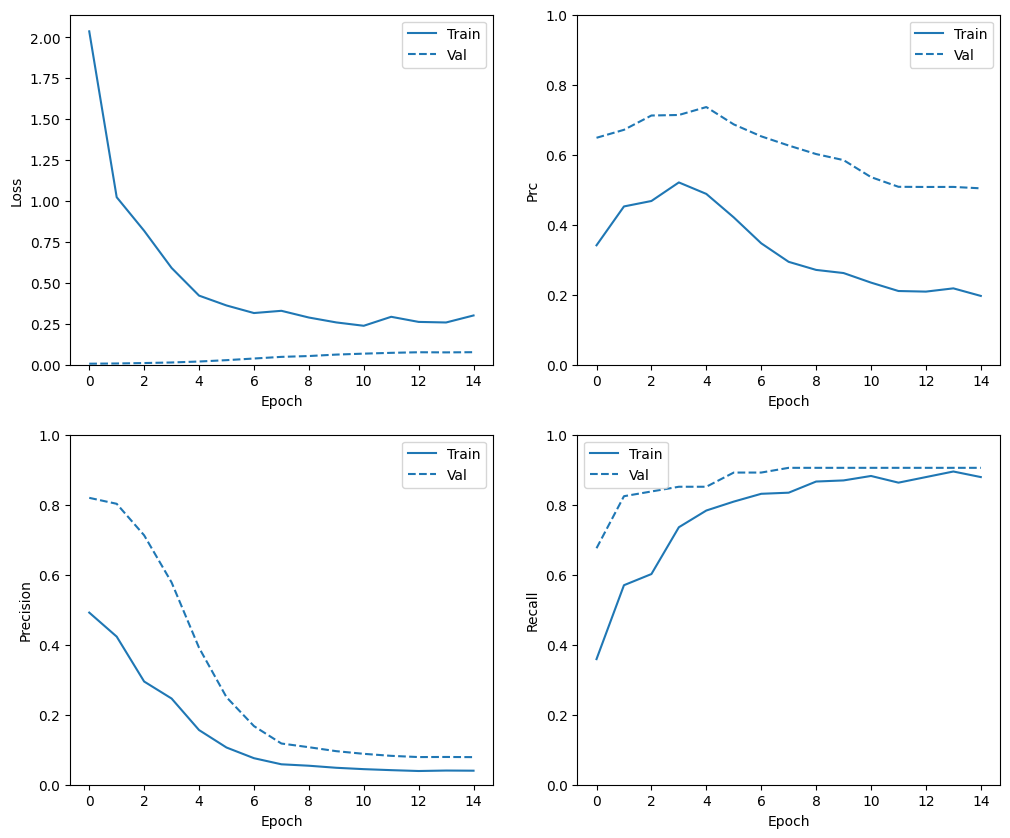

In [36]:
plot_metrics(weighted_history)

### 매트릭 평가

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 26s

38/90 [===========>..................] - ETA: 0s 

75/90 [========================>.....] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


loss :  0.019669152796268463
tp :  83.0
fp :  129.0
tn :  56729.0
fn :  21.0
accuracy :  0.9973666667938232
precision :  0.39150944352149963
recall :  0.7980769276618958
auc :  0.9632759094238281
prc :  0.6987218856811523



Legitimate Transactions Detected (True Negatives):  56729
Legitimate Transactions Incorrectly Detected (False Positives):  129
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  83
Total Fraudulent Transactions:  104


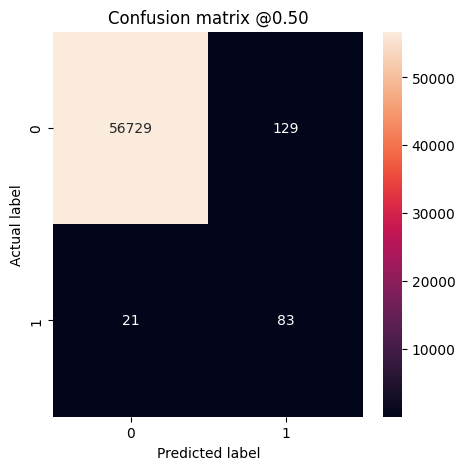

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

여기서 클래스 가중치를 사용하면 거짓 양성이 더 많기 때문에 정확도와 정밀도는 더 낮지만, 반대로 참 양성이 많으므로 재현율과 AUC는 더 높다는 것을 알 수 있습니다. 정확도가 낮음에도 불구하고 이 모델은 재현율이 더 높습니다(더 많은 부정 거래 식별). 물론 두 가지 유형의 오류 모두 비용이 발생합니다(많은 합법 거래를 사기로 표시하여 사용자를 번거롭게 하는 것은 바람직하지 않으므로). 따라서, 여러 유형 오류 간 절충 사항을 신중하게 고려해야 합니다.

### ROC 플로팅

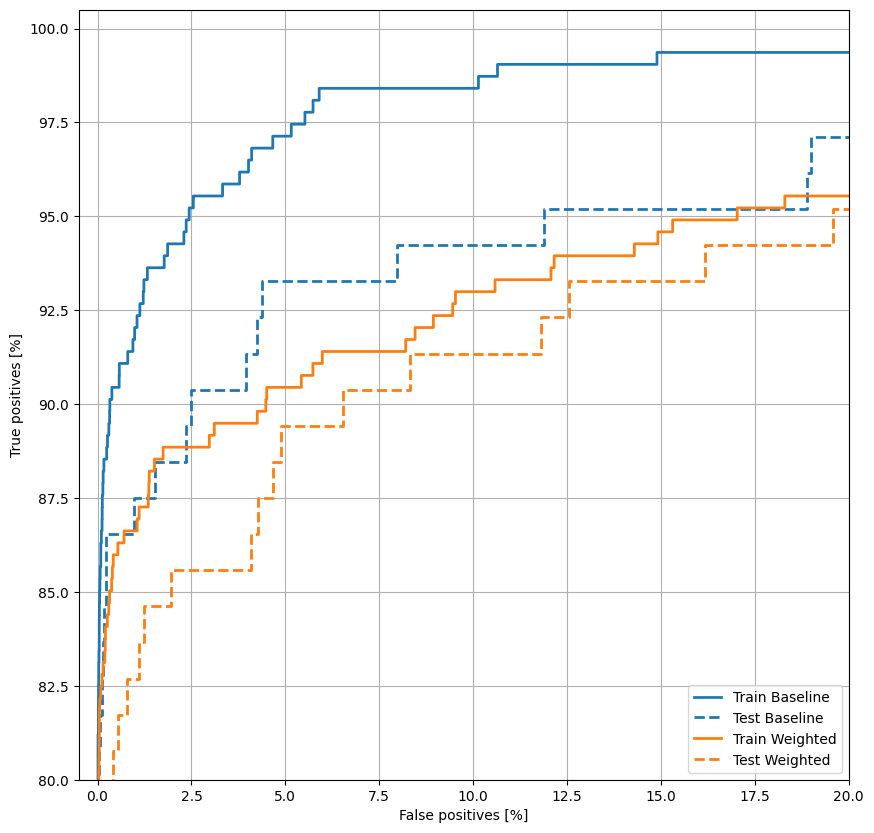

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### AUPRC 플로팅

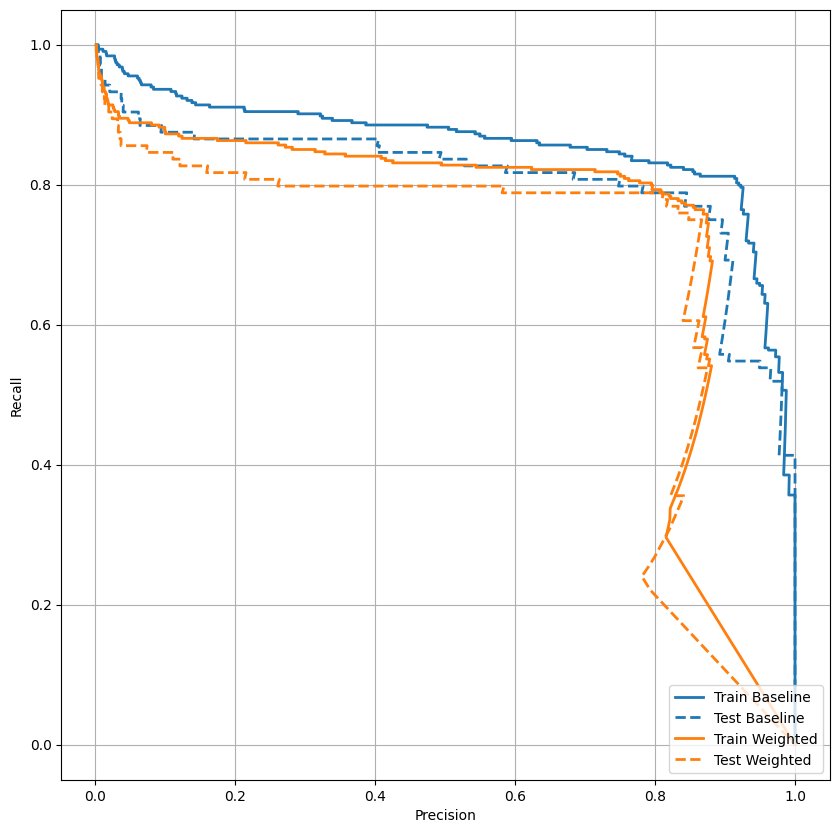

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## 오버샘플링

### 소수 계급 과대 표본

관련된 접근 방식은 소수 클래스를 오버 샘플링 하여 데이터 세트를 리 샘플링 하는 것입니다.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### NumPy 사용

긍정적인 예에서 적절한 수의 임의 인덱스를 선택하여 데이터 세트의 균형을 수동으로 조정할 수 있습니다.:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181962, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363924, 29)

#### `tf.data` 사용

`tf.data`를 사용하는 경우 균형있는 예를 생성하는 가장 쉬운 방법은 `positive`와 `negative` 데이터세트로 시작하여 이들을 병합하는 것입니다. [tf.data guide](../../guide/data.ipynb)에서 더 많은 예를 참조하시기 바랍니다.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

각 데이터 세트는 `(feature, label)` 쌍으로 되어 있습니다.

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.55467083 -0.97922813  0.59080477  0.59643053 -0.89905801  0.48952454
  1.15946322  0.01864729 -0.12317742 -0.13615181  1.15007822 -0.79930697
 -2.14706985  0.60117816  1.53918159  0.0180766  -0.13999689  0.98266206
  0.58410867  1.57832521  0.83951491  1.15214517  1.86547002 -0.04804956
 -0.57735273  1.44586154 -0.82327406 -0.51314852  1.63526419]

Label:  1


`tf.data.Dataset.sample_from_datasets`를 사용하여 이 둘을 병합합니다.

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5068359375


이 데이터 세트를 사용하려면 epoch당 스텝 수가 필요합니다.

이 경우 "epoch"의 정의는 명확하지 않습니다. 각 음성 예시를 한 번 볼 때 필요한 배치 수라고 해봅시다.

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### 오버 샘플링 된 데이터에 대한 학습

이제 클래스 가중치를 사용하는 대신 리 샘플링 된 데이터 세트로 모델을 학습하여 이러한 방법이 어떻게 비교되는지 확인하십시오.

참고: 긍정적인 예를 복제하여 데이터가 균형을 이루었기 때문에 총 데이터 세트 크기가 더 크고 각 세대가 더 많은 학습 단계를 위해 실행됩니다. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 7:45 - loss: 1.5166 - tp: 523.0000 - fp: 551.0000 - tn: 57320.0000 - fn: 616.0000 - accuracy: 0.9802 - precision: 0.4870 - recall: 0.4592 - auc: 0.8674 - prc: 0.4932

  5/278 [..............................] - ETA: 3s - loss: 1.4124 - tp: 2438.0000 - fp: 2244.0000 - tn: 59731.0000 - fn: 2789.0000 - accuracy: 0.9251 - precision: 0.5207 - recall: 0.4664 - auc: 0.8456 - prc: 0.5579

  8/278 [..............................] - ETA: 4s - loss: 1.3443 - tp: 3991.0000 - fp: 3501.0000 - tn: 61538.0000 - fn: 4316.0000 - accuracy: 0.8934 - precision: 0.5327 - recall: 0.4804 - auc: 0.8397 - prc: 0.5894

 11/278 [>.............................] - ETA: 4s - loss: 1.2817 - tp: 5660.0000 - fp: 4753.0000 - tn: 63343.0000 - fn: 5734.0000 - accuracy: 0.8681 - precision: 0.5436 - recall: 0.4968 - auc: 0.8355 - prc: 0.6163

 14/278 [>.............................] - ETA: 4s - loss: 1.2205 - tp: 7435.0000 - fp: 6006.0000 - tn: 65179.0000 - fn: 7014.0000 - accuracy: 0.8480 - precision: 0.5532 - recall: 0.5146 - auc: 0.8331 - prc: 0.6396

 17/278 [>.............................] - ETA: 5s - loss: 1.1746 - tp: 9236.0000 - fp: 7292.0000 - tn: 67019.0000 - fn: 8231.0000 - accuracy: 0.8309 - precision: 0.5588 - recall: 0.5288 - auc: 0.8293 - prc: 0.6566

 20/278 [=>............................] - ETA: 5s - loss: 1.1297 - tp: 11217.0000 - fp: 8554.0000 - tn: 68800.0000 - fn: 9351.0000 - accuracy: 0.8172 - precision: 0.5673 - recall: 0.5454 - auc: 0.8280 - prc: 0.6753

 23/278 [=>............................] - ETA: 5s - loss: 1.0890 - tp: 13269.0000 - fp: 9813.0000 - tn: 70618.0000 - fn: 10366.0000 - accuracy: 0.8061 - precision: 0.5749 - recall: 0.5614 - auc: 0.8268 - prc: 0.6915

 26/278 [=>............................] - ETA: 5s - loss: 1.0501 - tp: 15390.0000 - fp: 11078.0000 - tn: 72438.0000 - fn: 11304.0000 - accuracy: 0.7969 - precision: 0.5815 - recall: 0.5765 - auc: 0.8265 - prc: 0.7060

 29/278 [==>...........................] - ETA: 5s - loss: 1.0162 - tp: 17552.0000 - fp: 12353.0000 - tn: 74250.0000 - fn: 12199.0000 - accuracy: 0.7890 - precision: 0.5869 - recall: 0.5900 - auc: 0.8264 - prc: 0.7186

 32/278 [==>...........................] - ETA: 5s - loss: 0.9840 - tp: 19803.0000 - fp: 13640.0000 - tn: 76072.0000 - fn: 12983.0000 - accuracy: 0.7827 - precision: 0.5921 - recall: 0.6040 - auc: 0.8268 - prc: 0.7306

 35/278 [==>...........................] - ETA: 5s - loss: 0.9560 - tp: 22072.0000 - fp: 14861.0000 - tn: 77935.0000 - fn: 13774.0000 - accuracy: 0.7774 - precision: 0.5976 - recall: 0.6157 - auc: 0.8271 - prc: 0.7411

 38/278 [===>..........................] - ETA: 5s - loss: 0.9303 - tp: 24360.0000 - fp: 16025.0000 - tn: 79816.0000 - fn: 14585.0000 - accuracy: 0.7729 - precision: 0.6032 - recall: 0.6255 - auc: 0.8276 - prc: 0.7505

 41/278 [===>..........................] - ETA: 5s - loss: 0.9068 - tp: 26683.0000 - fp: 17229.0000 - tn: 81726.0000 - fn: 15292.0000 - accuracy: 0.7692 - precision: 0.6076 - recall: 0.6357 - auc: 0.8282 - prc: 0.7593

 44/278 [===>..........................] - ETA: 4s - loss: 0.8854 - tp: 29040.0000 - fp: 18392.0000 - tn: 83636.0000 - fn: 16006.0000 - accuracy: 0.7661 - precision: 0.6122 - recall: 0.6447 - auc: 0.8290 - prc: 0.7675

 47/278 [====>.........................] - ETA: 4s - loss: 0.8647 - tp: 31433.0000 - fp: 19523.0000 - tn: 85559.0000 - fn: 16703.0000 - accuracy: 0.7636 - precision: 0.6169 - recall: 0.6530 - auc: 0.8300 - prc: 0.7752

 50/278 [====>.........................] - ETA: 4s - loss: 0.8461 - tp: 33785.0000 - fp: 20664.0000 - tn: 87589.0000 - fn: 17324.0000 - accuracy: 0.7616 - precision: 0.6205 - recall: 0.6610 - auc: 0.8307 - prc: 0.7816

 53/278 [====>.........................] - ETA: 4s - loss: 0.8289 - tp: 36211.0000 - fp: 21775.0000 - tn: 89555.0000 - fn: 17965.0000 - accuracy: 0.7599 - precision: 0.6245 - recall: 0.6684 - auc: 0.8316 - prc: 0.7879

 56/278 [=====>........................] - ETA: 4s - loss: 0.8125 - tp: 38719.0000 - fp: 22855.0000 - tn: 91514.0000 - fn: 18562.0000 - accuracy: 0.7587 - precision: 0.6288 - recall: 0.6759 - auc: 0.8329 - prc: 0.7944

 59/278 [=====>........................] - ETA: 4s - loss: 0.7981 - tp: 41096.0000 - fp: 23897.0000 - tn: 93604.0000 - fn: 19197.0000 - accuracy: 0.7576 - precision: 0.6323 - recall: 0.6816 - auc: 0.8336 - prc: 0.7993

 62/278 [=====>........................] - ETA: 4s - loss: 0.7841 - tp: 43561.0000 - fp: 24892.0000 - tn: 95685.0000 - fn: 19800.0000 - accuracy: 0.7570 - precision: 0.6364 - recall: 0.6875 - auc: 0.8347 - prc: 0.8044

 65/278 [======>.......................] - ETA: 4s - loss: 0.7710 - tp: 46019.0000 - fp: 25884.0000 - tn: 97778.0000 - fn: 20401.0000 - accuracy: 0.7565 - precision: 0.6400 - recall: 0.6928 - auc: 0.8357 - prc: 0.8091

 68/278 [======>.......................] - ETA: 4s - loss: 0.7581 - tp: 48533.0000 - fp: 26860.0000 - tn: 99878.0000 - fn: 20955.0000 - accuracy: 0.7563 - precision: 0.6437 - recall: 0.6984 - auc: 0.8370 - prc: 0.8138

 71/278 [======>.......................] - ETA: 4s - loss: 0.7460 - tp: 51073.0000 - fp: 27801.0000 - tn: 101978.0000 - fn: 21518.0000 - accuracy: 0.7563 - precision: 0.6475 - recall: 0.7036 - auc: 0.8383 - prc: 0.8182

 74/278 [======>.......................] - ETA: 4s - loss: 0.7347 - tp: 53608.0000 - fp: 28707.0000 - tn: 104122.0000 - fn: 22077.0000 - accuracy: 0.7564 - precision: 0.6513 - recall: 0.7083 - auc: 0.8395 - prc: 0.8223

 77/278 [=======>......................] - ETA: 4s - loss: 0.7246 - tp: 56051.0000 - fp: 29617.0000 - tn: 106309.0000 - fn: 22681.0000 - accuracy: 0.7564 - precision: 0.6543 - recall: 0.7119 - auc: 0.8403 - prc: 0.8257

 80/278 [=======>......................] - ETA: 4s - loss: 0.7148 - tp: 58555.0000 - fp: 30522.0000 - tn: 108479.0000 - fn: 23246.0000 - accuracy: 0.7565 - precision: 0.6574 - recall: 0.7158 - auc: 0.8413 - prc: 0.8291

 83/278 [=======>......................] - ETA: 4s - loss: 0.7049 - tp: 61155.0000 - fp: 31387.0000 - tn: 110617.0000 - fn: 23787.0000 - accuracy: 0.7569 - precision: 0.6608 - recall: 0.7200 - auc: 0.8426 - prc: 0.8328

 86/278 [========>.....................] - ETA: 4s - loss: 0.6958 - tp: 63703.0000 - fp: 32250.0000 - tn: 112818.0000 - fn: 24319.0000 - accuracy: 0.7573 - precision: 0.6639 - recall: 0.7237 - auc: 0.8437 - prc: 0.8359

 89/278 [========>.....................] - ETA: 4s - loss: 0.6872 - tp: 66257.0000 - fp: 33082.0000 - tn: 115017.0000 - fn: 24878.0000 - accuracy: 0.7577 - precision: 0.6670 - recall: 0.7270 - auc: 0.8448 - prc: 0.8389

 92/278 [========>.....................] - ETA: 4s - loss: 0.6790 - tp: 68812.0000 - fp: 33881.0000 - tn: 117271.0000 - fn: 25414.0000 - accuracy: 0.7584 - precision: 0.6701 - recall: 0.7303 - auc: 0.8459 - prc: 0.8418

 95/278 [=========>....................] - ETA: 4s - loss: 0.6707 - tp: 71413.0000 - fp: 34643.0000 - tn: 119565.0000 - fn: 25901.0000 - accuracy: 0.7593 - precision: 0.6734 - recall: 0.7338 - auc: 0.8471 - prc: 0.8447

 98/278 [=========>....................] - ETA: 3s - loss: 0.6629 - tp: 73988.0000 - fp: 35417.0000 - tn: 121891.0000 - fn: 26370.0000 - accuracy: 0.7602 - precision: 0.6763 - recall: 0.7372 - auc: 0.8483 - prc: 0.8474

100/278 [=========>....................] - ETA: 3s - loss: 0.6580 - tp: 75704.0000 - fp: 35933.0000 - tn: 123418.0000 - fn: 26707.0000 - accuracy: 0.7607 - precision: 0.6781 - recall: 0.7392 - auc: 0.8491 - prc: 0.8490

103/278 [==========>...................] - ETA: 3s - loss: 0.6509 - tp: 78292.0000 - fp: 36659.0000 - tn: 125735.0000 - fn: 27220.0000 - accuracy: 0.7616 - precision: 0.6811 - recall: 0.7420 - auc: 0.8502 - prc: 0.8515

106/278 [==========>...................] - ETA: 3s - loss: 0.6441 - tp: 80857.0000 - fp: 37373.0000 - tn: 128093.0000 - fn: 27727.0000 - accuracy: 0.7625 - precision: 0.6839 - recall: 0.7446 - auc: 0.8512 - prc: 0.8538

109/278 [==========>...................] - ETA: 3s - loss: 0.6371 - tp: 83411.0000 - fp: 38024.0000 - tn: 130535.0000 - fn: 28224.0000 - accuracy: 0.7636 - precision: 0.6869 - recall: 0.7472 - auc: 0.8523 - prc: 0.8561

112/278 [===========>..................] - ETA: 3s - loss: 0.6307 - tp: 86048.0000 - fp: 38693.0000 - tn: 132861.0000 - fn: 28736.0000 - accuracy: 0.7645 - precision: 0.6898 - recall: 0.7497 - auc: 0.8534 - prc: 0.8584

115/278 [===========>..................] - ETA: 3s - loss: 0.6245 - tp: 88669.0000 - fp: 39362.0000 - tn: 135226.0000 - fn: 29225.0000 - accuracy: 0.7655 - precision: 0.6926 - recall: 0.7521 - auc: 0.8545 - prc: 0.8605

118/278 [===========>..................] - ETA: 3s - loss: 0.6185 - tp: 91222.0000 - fp: 40024.0000 - tn: 137680.0000 - fn: 29700.0000 - accuracy: 0.7665 - precision: 0.6950 - recall: 0.7544 - auc: 0.8555 - prc: 0.8624

121/278 [============>.................] - ETA: 3s - loss: 0.6127 - tp: 93852.0000 - fp: 40667.0000 - tn: 140074.0000 - fn: 30177.0000 - accuracy: 0.7675 - precision: 0.6977 - recall: 0.7567 - auc: 0.8566 - prc: 0.8644

124/278 [============>.................] - ETA: 3s - loss: 0.6069 - tp: 96435.0000 - fp: 41251.0000 - tn: 142588.0000 - fn: 30640.0000 - accuracy: 0.7688 - precision: 0.7004 - recall: 0.7589 - auc: 0.8576 - prc: 0.8663

127/278 [============>.................] - ETA: 3s - loss: 0.6011 - tp: 99113.0000 - fp: 41825.0000 - tn: 145003.0000 - fn: 31117.0000 - accuracy: 0.7699 - precision: 0.7032 - recall: 0.7611 - auc: 0.8588 - prc: 0.8683

130/278 [=============>................] - ETA: 3s - loss: 0.5959 - tp: 101677.0000 - fp: 42480.0000 - tn: 147483.0000 - fn: 31562.0000 - accuracy: 0.7709 - precision: 0.7053 - recall: 0.7631 - auc: 0.8598 - prc: 0.8699

133/278 [=============>................] - ETA: 3s - loss: 0.5907 - tp: 104272.0000 - fp: 43051.0000 - tn: 149989.0000 - fn: 32034.0000 - accuracy: 0.7720 - precision: 0.7078 - recall: 0.7650 - auc: 0.8607 - prc: 0.8716

136/278 [=============>................] - ETA: 3s - loss: 0.5854 - tp: 106949.0000 - fp: 43590.0000 - tn: 152481.0000 - fn: 32470.0000 - accuracy: 0.7733 - precision: 0.7104 - recall: 0.7671 - auc: 0.8619 - prc: 0.8734

138/278 [=============>................] - ETA: 3s - loss: 0.5820 - tp: 108749.0000 - fp: 43923.0000 - tn: 154156.0000 - fn: 32758.0000 - accuracy: 0.7742 - precision: 0.7123 - recall: 0.7685 - auc: 0.8627 - prc: 0.8745

141/278 [==============>...............] - ETA: 3s - loss: 0.5768 - tp: 111435.0000 - fp: 44422.0000 - tn: 156700.0000 - fn: 33173.0000 - accuracy: 0.7756 - precision: 0.7150 - recall: 0.7706 - auc: 0.8638 - prc: 0.8763

144/278 [==============>...............] - ETA: 3s - loss: 0.5720 - tp: 114111.0000 - fp: 44897.0000 - tn: 159241.0000 - fn: 33625.0000 - accuracy: 0.7768 - precision: 0.7176 - recall: 0.7724 - auc: 0.8649 - prc: 0.8779

147/278 [==============>...............] - ETA: 2s - loss: 0.5673 - tp: 116798.0000 - fp: 45425.0000 - tn: 161753.0000 - fn: 34042.0000 - accuracy: 0.7780 - precision: 0.7200 - recall: 0.7743 - auc: 0.8660 - prc: 0.8794

150/278 [===============>..............] - ETA: 2s - loss: 0.5626 - tp: 119468.0000 - fp: 45894.0000 - tn: 164355.0000 - fn: 34445.0000 - accuracy: 0.7794 - precision: 0.7225 - recall: 0.7762 - auc: 0.8671 - prc: 0.8810

153/278 [===============>..............] - ETA: 2s - loss: 0.5582 - tp: 122164.0000 - fp: 46363.0000 - tn: 166882.0000 - fn: 34897.0000 - accuracy: 0.7806 - precision: 0.7249 - recall: 0.7778 - auc: 0.8681 - prc: 0.8824

156/278 [===============>..............] - ETA: 2s - loss: 0.5539 - tp: 124789.0000 - fp: 46872.0000 - tn: 169492.0000 - fn: 35297.0000 - accuracy: 0.7817 - precision: 0.7270 - recall: 0.7795 - auc: 0.8690 - prc: 0.8837

159/278 [================>.............] - ETA: 2s - loss: 0.5496 - tp: 127453.0000 - fp: 47357.0000 - tn: 172088.0000 - fn: 35696.0000 - accuracy: 0.7829 - precision: 0.7291 - recall: 0.7812 - auc: 0.8701 - prc: 0.8851

162/278 [================>.............] - ETA: 2s - loss: 0.5457 - tp: 130070.0000 - fp: 47843.0000 - tn: 174726.0000 - fn: 36099.0000 - accuracy: 0.7841 - precision: 0.7311 - recall: 0.7828 - auc: 0.8710 - prc: 0.8863

165/278 [================>.............] - ETA: 2s - loss: 0.5418 - tp: 132729.0000 - fp: 48323.0000 - tn: 177322.0000 - fn: 36508.0000 - accuracy: 0.7852 - precision: 0.7331 - recall: 0.7843 - auc: 0.8719 - prc: 0.8876

167/278 [=================>............] - ETA: 2s - loss: 0.5392 - tp: 134522.0000 - fp: 48643.0000 - tn: 179036.0000 - fn: 36777.0000 - accuracy: 0.7859 - precision: 0.7344 - recall: 0.7853 - auc: 0.8725 - prc: 0.8884

170/278 [=================>............] - ETA: 2s - loss: 0.5353 - tp: 137194.0000 - fp: 49090.0000 - tn: 181661.0000 - fn: 37177.0000 - accuracy: 0.7871 - precision: 0.7365 - recall: 0.7868 - auc: 0.8735 - prc: 0.8897

173/278 [=================>............] - ETA: 2s - loss: 0.5315 - tp: 139882.0000 - fp: 49538.0000 - tn: 184297.0000 - fn: 37549.0000 - accuracy: 0.7882 - precision: 0.7385 - recall: 0.7884 - auc: 0.8745 - prc: 0.8909

176/278 [=================>............] - ETA: 2s - loss: 0.5277 - tp: 142536.0000 - fp: 49959.0000 - tn: 186961.0000 - fn: 37954.0000 - accuracy: 0.7894 - precision: 0.7405 - recall: 0.7897 - auc: 0.8755 - prc: 0.8921

179/278 [==================>...........] - ETA: 2s - loss: 0.5242 - tp: 145205.0000 - fp: 50394.0000 - tn: 189597.0000 - fn: 38358.0000 - accuracy: 0.7905 - precision: 0.7424 - recall: 0.7910 - auc: 0.8763 - prc: 0.8932

182/278 [==================>...........] - ETA: 2s - loss: 0.5205 - tp: 147880.0000 - fp: 50770.0000 - tn: 192311.0000 - fn: 38737.0000 - accuracy: 0.7917 - precision: 0.7444 - recall: 0.7924 - auc: 0.8773 - prc: 0.8944

185/278 [==================>...........] - ETA: 2s - loss: 0.5171 - tp: 150569.0000 - fp: 51154.0000 - tn: 194991.0000 - fn: 39128.0000 - accuracy: 0.7929 - precision: 0.7464 - recall: 0.7937 - auc: 0.8782 - prc: 0.8954

188/278 [===================>..........] - ETA: 2s - loss: 0.5136 - tp: 153265.0000 - fp: 51521.0000 - tn: 197706.0000 - fn: 39494.0000 - accuracy: 0.7941 - precision: 0.7484 - recall: 0.7951 - auc: 0.8792 - prc: 0.8966

191/278 [===================>..........] - ETA: 1s - loss: 0.5102 - tp: 156003.0000 - fp: 51907.0000 - tn: 200365.0000 - fn: 39855.0000 - accuracy: 0.7952 - precision: 0.7503 - recall: 0.7965 - auc: 0.8801 - prc: 0.8977

194/278 [===================>..........] - ETA: 1s - loss: 0.5069 - tp: 158712.0000 - fp: 52262.0000 - tn: 203056.0000 - fn: 40244.0000 - accuracy: 0.7964 - precision: 0.7523 - recall: 0.7977 - auc: 0.8810 - prc: 0.8987

197/278 [====================>.........] - ETA: 1s - loss: 0.5037 - tp: 161408.0000 - fp: 52653.0000 - tn: 205738.0000 - fn: 40619.0000 - accuracy: 0.7974 - precision: 0.7540 - recall: 0.7989 - auc: 0.8819 - prc: 0.8997

200/278 [====================>.........] - ETA: 1s - loss: 0.5007 - tp: 164100.0000 - fp: 53029.0000 - tn: 208414.0000 - fn: 41019.0000 - accuracy: 0.7984 - precision: 0.7558 - recall: 0.8000 - auc: 0.8827 - prc: 0.9006

203/278 [====================>.........] - ETA: 1s - loss: 0.4976 - tp: 166778.0000 - fp: 53394.0000 - tn: 211153.0000 - fn: 41381.0000 - accuracy: 0.7995 - precision: 0.7575 - recall: 0.8012 - auc: 0.8835 - prc: 0.9016

206/278 [=====================>........] - ETA: 1s - loss: 0.4946 - tp: 169493.0000 - fp: 53758.0000 - tn: 213862.0000 - fn: 41737.0000 - accuracy: 0.8006 - precision: 0.7592 - recall: 0.8024 - auc: 0.8844 - prc: 0.9025

209/278 [=====================>........] - ETA: 1s - loss: 0.4916 - tp: 172211.0000 - fp: 54097.0000 - tn: 216597.0000 - fn: 42089.0000 - accuracy: 0.8017 - precision: 0.7610 - recall: 0.8036 - auc: 0.8852 - prc: 0.9035

212/278 [=====================>........] - ETA: 1s - loss: 0.4886 - tp: 174926.0000 - fp: 54420.0000 - tn: 219357.0000 - fn: 42435.0000 - accuracy: 0.8028 - precision: 0.7627 - recall: 0.8048 - auc: 0.8861 - prc: 0.9044

215/278 [======================>.......] - ETA: 1s - loss: 0.4858 - tp: 177579.0000 - fp: 54757.0000 - tn: 222159.0000 - fn: 42787.0000 - accuracy: 0.8038 - precision: 0.7643 - recall: 0.8058 - auc: 0.8868 - prc: 0.9053

218/278 [======================>.......] - ETA: 1s - loss: 0.4830 - tp: 180328.0000 - fp: 55060.0000 - tn: 224884.0000 - fn: 43154.0000 - accuracy: 0.8049 - precision: 0.7661 - recall: 0.8069 - auc: 0.8877 - prc: 0.9062

221/278 [======================>.......] - ETA: 1s - loss: 0.4801 - tp: 183041.0000 - fp: 55357.0000 - tn: 227690.0000 - fn: 43482.0000 - accuracy: 0.8060 - precision: 0.7678 - recall: 0.8080 - auc: 0.8885 - prc: 0.9071

224/278 [=======================>......] - ETA: 1s - loss: 0.4773 - tp: 185782.0000 - fp: 55670.0000 - tn: 230431.0000 - fn: 43831.0000 - accuracy: 0.8071 - precision: 0.7694 - recall: 0.8091 - auc: 0.8893 - prc: 0.9079

226/278 [=======================>......] - ETA: 1s - loss: 0.4755 - tp: 187606.0000 - fp: 55867.0000 - tn: 232282.0000 - fn: 44055.0000 - accuracy: 0.8078 - precision: 0.7705 - recall: 0.8098 - auc: 0.8899 - prc: 0.9085

229/278 [=======================>......] - ETA: 1s - loss: 0.4728 - tp: 190330.0000 - fp: 56148.0000 - tn: 235061.0000 - fn: 44415.0000 - accuracy: 0.8088 - precision: 0.7722 - recall: 0.8108 - auc: 0.8906 - prc: 0.9093

232/278 [========================>.....] - ETA: 1s - loss: 0.4702 - tp: 193093.0000 - fp: 56414.0000 - tn: 237817.0000 - fn: 44774.0000 - accuracy: 0.8098 - precision: 0.7739 - recall: 0.8118 - auc: 0.8914 - prc: 0.9101

235/278 [========================>.....] - ETA: 0s - loss: 0.4676 - tp: 195837.0000 - fp: 56713.0000 - tn: 240583.0000 - fn: 45109.0000 - accuracy: 0.8108 - precision: 0.7754 - recall: 0.8128 - auc: 0.8922 - prc: 0.9109

238/278 [========================>.....] - ETA: 0s - loss: 0.4652 - tp: 198604.0000 - fp: 57006.0000 - tn: 243314.0000 - fn: 45462.0000 - accuracy: 0.8118 - precision: 0.7770 - recall: 0.8137 - auc: 0.8929 - prc: 0.9117

241/278 [=========================>....] - ETA: 0s - loss: 0.4627 - tp: 201347.0000 - fp: 57295.0000 - tn: 246079.0000 - fn: 45809.0000 - accuracy: 0.8127 - precision: 0.7785 - recall: 0.8147 - auc: 0.8936 - prc: 0.9125

244/278 [=========================>....] - ETA: 0s - loss: 0.4603 - tp: 204057.0000 - fp: 57564.0000 - tn: 248901.0000 - fn: 46152.0000 - accuracy: 0.8137 - precision: 0.7800 - recall: 0.8155 - auc: 0.8943 - prc: 0.9132

247/278 [=========================>....] - ETA: 0s - loss: 0.4579 - tp: 206821.0000 - fp: 57839.0000 - tn: 251646.0000 - fn: 46512.0000 - accuracy: 0.8146 - precision: 0.7815 - recall: 0.8164 - auc: 0.8950 - prc: 0.9139

250/278 [=========================>....] - ETA: 0s - loss: 0.4556 - tp: 209558.0000 - fp: 58081.0000 - tn: 254485.0000 - fn: 46838.0000 - accuracy: 0.8156 - precision: 0.7830 - recall: 0.8173 - auc: 0.8957 - prc: 0.9146

253/278 [==========================>...] - ETA: 0s - loss: 0.4531 - tp: 212285.0000 - fp: 58328.0000 - tn: 257315.0000 - fn: 47178.0000 - accuracy: 0.8165 - precision: 0.7845 - recall: 0.8182 - auc: 0.8964 - prc: 0.9153

256/278 [==========================>...] - ETA: 0s - loss: 0.4508 - tp: 214993.0000 - fp: 58578.0000 - tn: 260158.0000 - fn: 47521.0000 - accuracy: 0.8175 - precision: 0.7859 - recall: 0.8190 - auc: 0.8971 - prc: 0.9160

259/278 [==========================>...] - ETA: 0s - loss: 0.4485 - tp: 217707.0000 - fp: 58832.0000 - tn: 262997.0000 - fn: 47858.0000 - accuracy: 0.8184 - precision: 0.7873 - recall: 0.8198 - auc: 0.8978 - prc: 0.9167

262/278 [===========================>..] - ETA: 0s - loss: 0.4462 - tp: 220466.0000 - fp: 59088.0000 - tn: 265787.0000 - fn: 48197.0000 - accuracy: 0.8192 - precision: 0.7886 - recall: 0.8206 - auc: 0.8985 - prc: 0.9174

265/278 [===========================>..] - ETA: 0s - loss: 0.4440 - tp: 223202.0000 - fp: 59324.0000 - tn: 268640.0000 - fn: 48516.0000 - accuracy: 0.8202 - precision: 0.7900 - recall: 0.8214 - auc: 0.8992 - prc: 0.9181

268/278 [===========================>..] - ETA: 0s - loss: 0.4418 - tp: 225953.0000 - fp: 59587.0000 - tn: 271448.0000 - fn: 48838.0000 - accuracy: 0.8210 - precision: 0.7913 - recall: 0.8223 - auc: 0.8999 - prc: 0.9187

271/278 [============================>.] - ETA: 0s - loss: 0.4397 - tp: 228685.0000 - fp: 59829.0000 - tn: 274301.0000 - fn: 49155.0000 - accuracy: 0.8219 - precision: 0.7926 - recall: 0.8231 - auc: 0.9006 - prc: 0.9194

274/278 [============================>.] - ETA: 0s - loss: 0.4376 - tp: 231394.0000 - fp: 60089.0000 - tn: 277125.0000 - fn: 49506.0000 - accuracy: 0.8227 - precision: 0.7939 - recall: 0.8238 - auc: 0.9012 - prc: 0.9200

277/278 [============================>.] - ETA: 0s - loss: 0.4355 - tp: 234123.0000 - fp: 60313.0000 - tn: 279961.0000 - fn: 49861.0000 - accuracy: 0.8235 - precision: 0.7952 - recall: 0.8244 - auc: 0.9018 - prc: 0.9205

278/278 [==============================] - 9s 25ms/step - loss: 0.4348 - tp: 235044.0000 - fp: 60383.0000 - tn: 280909.0000 - fn: 49970.0000 - accuracy: 0.8238 - precision: 0.7956 - recall: 0.8247 - auc: 0.9020 - prc: 0.9208 - val_loss: 0.2105 - val_tp: 68.0000 - val_fp: 944.0000 - val_tn: 44551.0000 - val_fn: 6.0000 - val_accuracy: 0.9792 - val_precision: 0.0672 - val_recall: 0.9189 - val_auc: 0.9713 - val_prc: 0.7421


Epoch 2/100


  1/278 [..............................] - ETA: 1s - loss: 0.2320 - tp: 937.0000 - fp: 60.0000 - tn: 933.0000 - fn: 118.0000 - accuracy: 0.9131 - precision: 0.9398 - recall: 0.8882 - auc: 0.9623 - prc: 0.9736

  5/278 [..............................] - ETA: 4s - loss: 0.2366 - tp: 4516.0000 - fp: 361.0000 - tn: 4797.0000 - fn: 566.0000 - accuracy: 0.9095 - precision: 0.9260 - recall: 0.8886 - auc: 0.9614 - prc: 0.9713

  8/278 [..............................] - ETA: 5s - loss: 0.2380 - tp: 7301.0000 - fp: 586.0000 - tn: 7618.0000 - fn: 879.0000 - accuracy: 0.9106 - precision: 0.9257 - recall: 0.8925 - auc: 0.9611 - prc: 0.9715

 11/278 [>.............................] - ETA: 5s - loss: 0.2378 - tp: 10041.0000 - fp: 799.0000 - tn: 10481.0000 - fn: 1207.0000 - accuracy: 0.9110 - precision: 0.9263 - recall: 0.8927 - auc: 0.9612 - prc: 0.9715

 14/278 [>.............................] - ETA: 5s - loss: 0.2373 - tp: 12769.0000 - fp: 996.0000 - tn: 13370.0000 - fn: 1537.0000 - accuracy: 0.9117 - precision: 0.9276 - recall: 0.8926 - auc: 0.9614 - prc: 0.9716

 17/278 [>.............................] - ETA: 5s - loss: 0.2380 - tp: 15580.0000 - fp: 1245.0000 - tn: 16114.0000 - fn: 1877.0000 - accuracy: 0.9103 - precision: 0.9260 - recall: 0.8925 - auc: 0.9612 - prc: 0.9716

 20/278 [=>............................] - ETA: 5s - loss: 0.2378 - tp: 18319.0000 - fp: 1436.0000 - tn: 18981.0000 - fn: 2224.0000 - accuracy: 0.9106 - precision: 0.9273 - recall: 0.8917 - auc: 0.9611 - prc: 0.9716

 23/278 [=>............................] - ETA: 5s - loss: 0.2379 - tp: 21084.0000 - fp: 1642.0000 - tn: 21836.0000 - fn: 2542.0000 - accuracy: 0.9112 - precision: 0.9277 - recall: 0.8924 - auc: 0.9612 - prc: 0.9716

 26/278 [=>............................] - ETA: 5s - loss: 0.2377 - tp: 23874.0000 - fp: 1863.0000 - tn: 24646.0000 - fn: 2865.0000 - accuracy: 0.9112 - precision: 0.9276 - recall: 0.8929 - auc: 0.9614 - prc: 0.9718

 29/278 [==>...........................] - ETA: 5s - loss: 0.2367 - tp: 26651.0000 - fp: 2046.0000 - tn: 27505.0000 - fn: 3190.0000 - accuracy: 0.9118 - precision: 0.9287 - recall: 0.8931 - auc: 0.9616 - prc: 0.9719

 31/278 [==>...........................] - ETA: 5s - loss: 0.2371 - tp: 28460.0000 - fp: 2187.0000 - tn: 29416.0000 - fn: 3425.0000 - accuracy: 0.9116 - precision: 0.9286 - recall: 0.8926 - auc: 0.9614 - prc: 0.9717

 34/278 [==>...........................] - ETA: 5s - loss: 0.2365 - tp: 31237.0000 - fp: 2382.0000 - tn: 32258.0000 - fn: 3755.0000 - accuracy: 0.9119 - precision: 0.9291 - recall: 0.8927 - auc: 0.9616 - prc: 0.9718

 37/278 [==>...........................] - ETA: 5s - loss: 0.2364 - tp: 34011.0000 - fp: 2603.0000 - tn: 35075.0000 - fn: 4087.0000 - accuracy: 0.9117 - precision: 0.9289 - recall: 0.8927 - auc: 0.9616 - prc: 0.9718

 40/278 [===>..........................] - ETA: 5s - loss: 0.2354 - tp: 36781.0000 - fp: 2785.0000 - tn: 37934.0000 - fn: 4420.0000 - accuracy: 0.9120 - precision: 0.9296 - recall: 0.8927 - auc: 0.9619 - prc: 0.9720

 43/278 [===>..........................] - ETA: 5s - loss: 0.2343 - tp: 39518.0000 - fp: 2986.0000 - tn: 40850.0000 - fn: 4710.0000 - accuracy: 0.9126 - precision: 0.9297 - recall: 0.8935 - auc: 0.9624 - prc: 0.9722

 46/278 [===>..........................] - ETA: 5s - loss: 0.2343 - tp: 42240.0000 - fp: 3195.0000 - tn: 43721.0000 - fn: 5052.0000 - accuracy: 0.9125 - precision: 0.9297 - recall: 0.8932 - auc: 0.9623 - prc: 0.9722

 48/278 [====>.........................] - ETA: 5s - loss: 0.2339 - tp: 44051.0000 - fp: 3333.0000 - tn: 45664.0000 - fn: 5256.0000 - accuracy: 0.9126 - precision: 0.9297 - recall: 0.8934 - auc: 0.9624 - prc: 0.9722

 51/278 [====>.........................] - ETA: 5s - loss: 0.2334 - tp: 46749.0000 - fp: 3519.0000 - tn: 48613.0000 - fn: 5567.0000 - accuracy: 0.9130 - precision: 0.9300 - recall: 0.8936 - auc: 0.9626 - prc: 0.9723

 54/278 [====>.........................] - ETA: 5s - loss: 0.2331 - tp: 49410.0000 - fp: 3733.0000 - tn: 51560.0000 - fn: 5889.0000 - accuracy: 0.9130 - precision: 0.9298 - recall: 0.8935 - auc: 0.9627 - prc: 0.9723

 57/278 [=====>........................] - ETA: 5s - loss: 0.2329 - tp: 52223.0000 - fp: 3922.0000 - tn: 54363.0000 - fn: 6228.0000 - accuracy: 0.9131 - precision: 0.9301 - recall: 0.8934 - auc: 0.9627 - prc: 0.9723

 60/278 [=====>........................] - ETA: 5s - loss: 0.2323 - tp: 54957.0000 - fp: 4126.0000 - tn: 57253.0000 - fn: 6544.0000 - accuracy: 0.9132 - precision: 0.9302 - recall: 0.8936 - auc: 0.9629 - prc: 0.9723

 63/278 [=====>........................] - ETA: 4s - loss: 0.2322 - tp: 57715.0000 - fp: 4329.0000 - tn: 60105.0000 - fn: 6875.0000 - accuracy: 0.9132 - precision: 0.9302 - recall: 0.8936 - auc: 0.9630 - prc: 0.9724

 66/278 [======>.......................] - ETA: 4s - loss: 0.2320 - tp: 60467.0000 - fp: 4531.0000 - tn: 62955.0000 - fn: 7215.0000 - accuracy: 0.9131 - precision: 0.9303 - recall: 0.8934 - auc: 0.9630 - prc: 0.9724

 69/278 [======>.......................] - ETA: 4s - loss: 0.2316 - tp: 63229.0000 - fp: 4715.0000 - tn: 65822.0000 - fn: 7546.0000 - accuracy: 0.9132 - precision: 0.9306 - recall: 0.8934 - auc: 0.9632 - prc: 0.9725

 72/278 [======>.......................] - ETA: 4s - loss: 0.2313 - tp: 65964.0000 - fp: 4902.0000 - tn: 68720.0000 - fn: 7870.0000 - accuracy: 0.9134 - precision: 0.9308 - recall: 0.8934 - auc: 0.9632 - prc: 0.9725

 75/278 [=======>......................] - ETA: 4s - loss: 0.2308 - tp: 68728.0000 - fp: 5057.0000 - tn: 71626.0000 - fn: 8189.0000 - accuracy: 0.9138 - precision: 0.9315 - recall: 0.8935 - auc: 0.9634 - prc: 0.9726

 78/278 [=======>......................] - ETA: 4s - loss: 0.2304 - tp: 71506.0000 - fp: 5233.0000 - tn: 74496.0000 - fn: 8509.0000 - accuracy: 0.9140 - precision: 0.9318 - recall: 0.8937 - auc: 0.9635 - prc: 0.9727

 81/278 [=======>......................] - ETA: 4s - loss: 0.2295 - tp: 74198.0000 - fp: 5408.0000 - tn: 77471.0000 - fn: 8811.0000 - accuracy: 0.9143 - precision: 0.9321 - recall: 0.8939 - auc: 0.9638 - prc: 0.9728

 83/278 [=======>......................] - ETA: 4s - loss: 0.2292 - tp: 76061.0000 - fp: 5516.0000 - tn: 79384.0000 - fn: 9023.0000 - accuracy: 0.9145 - precision: 0.9324 - recall: 0.8940 - auc: 0.9639 - prc: 0.9729

 85/278 [========>.....................] - ETA: 4s - loss: 0.2290 - tp: 77872.0000 - fp: 5623.0000 - tn: 81351.0000 - fn: 9234.0000 - accuracy: 0.9147 - precision: 0.9327 - recall: 0.8940 - auc: 0.9640 - prc: 0.9729

 87/278 [========>.....................] - ETA: 4s - loss: 0.2286 - tp: 79721.0000 - fp: 5742.0000 - tn: 83253.0000 - fn: 9460.0000 - accuracy: 0.9147 - precision: 0.9328 - recall: 0.8939 - auc: 0.9641 - prc: 0.9730

 90/278 [========>.....................] - ETA: 4s - loss: 0.2281 - tp: 82493.0000 - fp: 5932.0000 - tn: 86138.0000 - fn: 9757.0000 - accuracy: 0.9149 - precision: 0.9329 - recall: 0.8942 - auc: 0.9642 - prc: 0.9731

 93/278 [=========>....................] - ETA: 4s - loss: 0.2277 - tp: 85268.0000 - fp: 6093.0000 - tn: 89008.0000 - fn: 10095.0000 - accuracy: 0.9150 - precision: 0.9333 - recall: 0.8941 - auc: 0.9643 - prc: 0.9732

 96/278 [=========>....................] - ETA: 4s - loss: 0.2271 - tp: 87985.0000 - fp: 6248.0000 - tn: 91960.0000 - fn: 10415.0000 - accuracy: 0.9152 - precision: 0.9337 - recall: 0.8942 - auc: 0.9645 - prc: 0.9733

 99/278 [=========>....................] - ETA: 4s - loss: 0.2268 - tp: 90714.0000 - fp: 6412.0000 - tn: 94898.0000 - fn: 10728.0000 - accuracy: 0.9155 - precision: 0.9340 - recall: 0.8942 - auc: 0.9646 - prc: 0.9733

102/278 [==========>...................] - ETA: 4s - loss: 0.2263 - tp: 93472.0000 - fp: 6570.0000 - tn: 97799.0000 - fn: 11055.0000 - accuracy: 0.9156 - precision: 0.9343 - recall: 0.8942 - auc: 0.9648 - prc: 0.9734

105/278 [==========>...................] - ETA: 4s - loss: 0.2258 - tp: 96241.0000 - fp: 6723.0000 - tn: 100698.0000 - fn: 11378.0000 - accuracy: 0.9158 - precision: 0.9347 - recall: 0.8943 - auc: 0.9649 - prc: 0.9735

108/278 [==========>...................] - ETA: 3s - loss: 0.2252 - tp: 99057.0000 - fp: 6883.0000 - tn: 103546.0000 - fn: 11698.0000 - accuracy: 0.9160 - precision: 0.9350 - recall: 0.8944 - auc: 0.9651 - prc: 0.9737

111/278 [==========>...................] - ETA: 3s - loss: 0.2246 - tp: 101832.0000 - fp: 7049.0000 - tn: 106452.0000 - fn: 11995.0000 - accuracy: 0.9162 - precision: 0.9353 - recall: 0.8946 - auc: 0.9653 - prc: 0.9738

114/278 [===========>..................] - ETA: 3s - loss: 0.2240 - tp: 104598.0000 - fp: 7209.0000 - tn: 109367.0000 - fn: 12298.0000 - accuracy: 0.9164 - precision: 0.9355 - recall: 0.8948 - auc: 0.9655 - prc: 0.9739

116/278 [===========>..................] - ETA: 3s - loss: 0.2238 - tp: 106413.0000 - fp: 7306.0000 - tn: 111350.0000 - fn: 12499.0000 - accuracy: 0.9166 - precision: 0.9358 - recall: 0.8949 - auc: 0.9656 - prc: 0.9740

119/278 [===========>..................] - ETA: 3s - loss: 0.2234 - tp: 109142.0000 - fp: 7448.0000 - tn: 114308.0000 - fn: 12814.0000 - accuracy: 0.9169 - precision: 0.9361 - recall: 0.8949 - auc: 0.9657 - prc: 0.9740

122/278 [============>.................] - ETA: 3s - loss: 0.2229 - tp: 111928.0000 - fp: 7608.0000 - tn: 117203.0000 - fn: 13117.0000 - accuracy: 0.9171 - precision: 0.9364 - recall: 0.8951 - auc: 0.9658 - prc: 0.9741

125/278 [============>.................] - ETA: 3s - loss: 0.2227 - tp: 114733.0000 - fp: 7773.0000 - tn: 120062.0000 - fn: 13432.0000 - accuracy: 0.9172 - precision: 0.9366 - recall: 0.8952 - auc: 0.9659 - prc: 0.9742

128/278 [============>.................] - ETA: 3s - loss: 0.2224 - tp: 117458.0000 - fp: 7941.0000 - tn: 123019.0000 - fn: 13726.0000 - accuracy: 0.9173 - precision: 0.9367 - recall: 0.8954 - auc: 0.9660 - prc: 0.9742

131/278 [=============>................] - ETA: 3s - loss: 0.2220 - tp: 120237.0000 - fp: 8107.0000 - tn: 125919.0000 - fn: 14025.0000 - accuracy: 0.9175 - precision: 0.9368 - recall: 0.8955 - auc: 0.9662 - prc: 0.9743

134/278 [=============>................] - ETA: 3s - loss: 0.2215 - tp: 123009.0000 - fp: 8257.0000 - tn: 128849.0000 - fn: 14317.0000 - accuracy: 0.9177 - precision: 0.9371 - recall: 0.8957 - auc: 0.9663 - prc: 0.9744

137/278 [=============>................] - ETA: 3s - loss: 0.2212 - tp: 125688.0000 - fp: 8413.0000 - tn: 131838.0000 - fn: 14637.0000 - accuracy: 0.9178 - precision: 0.9373 - recall: 0.8957 - auc: 0.9664 - prc: 0.9745

140/278 [==============>...............] - ETA: 3s - loss: 0.2208 - tp: 128446.0000 - fp: 8569.0000 - tn: 134748.0000 - fn: 14957.0000 - accuracy: 0.9179 - precision: 0.9375 - recall: 0.8957 - auc: 0.9666 - prc: 0.9745

142/278 [==============>...............] - ETA: 3s - loss: 0.2207 - tp: 130242.0000 - fp: 8682.0000 - tn: 136718.0000 - fn: 15174.0000 - accuracy: 0.9180 - precision: 0.9375 - recall: 0.8957 - auc: 0.9666 - prc: 0.9745

145/278 [==============>...............] - ETA: 3s - loss: 0.2203 - tp: 133012.0000 - fp: 8836.0000 - tn: 139641.0000 - fn: 15471.0000 - accuracy: 0.9181 - precision: 0.9377 - recall: 0.8958 - auc: 0.9667 - prc: 0.9746

148/278 [==============>...............] - ETA: 3s - loss: 0.2199 - tp: 135825.0000 - fp: 8994.0000 - tn: 142501.0000 - fn: 15784.0000 - accuracy: 0.9183 - precision: 0.9379 - recall: 0.8959 - auc: 0.9668 - prc: 0.9747

151/278 [===============>..............] - ETA: 2s - loss: 0.2194 - tp: 138581.0000 - fp: 9140.0000 - tn: 145445.0000 - fn: 16082.0000 - accuracy: 0.9184 - precision: 0.9381 - recall: 0.8960 - auc: 0.9669 - prc: 0.9748

154/278 [===============>..............] - ETA: 2s - loss: 0.2190 - tp: 141377.0000 - fp: 9293.0000 - tn: 148330.0000 - fn: 16392.0000 - accuracy: 0.9186 - precision: 0.9383 - recall: 0.8961 - auc: 0.9671 - prc: 0.9749

157/278 [===============>..............] - ETA: 2s - loss: 0.2185 - tp: 144097.0000 - fp: 9438.0000 - tn: 151301.0000 - fn: 16700.0000 - accuracy: 0.9187 - precision: 0.9385 - recall: 0.8961 - auc: 0.9672 - prc: 0.9750

160/278 [================>.............] - ETA: 2s - loss: 0.2180 - tp: 146821.0000 - fp: 9560.0000 - tn: 154280.0000 - fn: 17019.0000 - accuracy: 0.9189 - precision: 0.9389 - recall: 0.8961 - auc: 0.9673 - prc: 0.9750

163/278 [================>.............] - ETA: 2s - loss: 0.2177 - tp: 149585.0000 - fp: 9735.0000 - tn: 157174.0000 - fn: 17330.0000 - accuracy: 0.9189 - precision: 0.9389 - recall: 0.8962 - auc: 0.9674 - prc: 0.9751

166/278 [================>.............] - ETA: 2s - loss: 0.2173 - tp: 152337.0000 - fp: 9869.0000 - tn: 160114.0000 - fn: 17648.0000 - accuracy: 0.9191 - precision: 0.9392 - recall: 0.8962 - auc: 0.9676 - prc: 0.9752

169/278 [=================>............] - ETA: 2s - loss: 0.2169 - tp: 155164.0000 - fp: 10027.0000 - tn: 162972.0000 - fn: 17949.0000 - accuracy: 0.9192 - precision: 0.9393 - recall: 0.8963 - auc: 0.9677 - prc: 0.9753

172/278 [=================>............] - ETA: 2s - loss: 0.2166 - tp: 157888.0000 - fp: 10168.0000 - tn: 165932.0000 - fn: 18268.0000 - accuracy: 0.9193 - precision: 0.9395 - recall: 0.8963 - auc: 0.9678 - prc: 0.9753

175/278 [=================>............] - ETA: 2s - loss: 0.2162 - tp: 160607.0000 - fp: 10310.0000 - tn: 168904.0000 - fn: 18579.0000 - accuracy: 0.9194 - precision: 0.9397 - recall: 0.8963 - auc: 0.9679 - prc: 0.9754

177/278 [==================>...........] - ETA: 2s - loss: 0.2159 - tp: 162434.0000 - fp: 10396.0000 - tn: 170884.0000 - fn: 18782.0000 - accuracy: 0.9195 - precision: 0.9398 - recall: 0.8964 - auc: 0.9680 - prc: 0.9754

180/278 [==================>...........] - ETA: 2s - loss: 0.2155 - tp: 165196.0000 - fp: 10542.0000 - tn: 173828.0000 - fn: 19074.0000 - accuracy: 0.9197 - precision: 0.9400 - recall: 0.8965 - auc: 0.9681 - prc: 0.9755

183/278 [==================>...........] - ETA: 2s - loss: 0.2151 - tp: 167958.0000 - fp: 10689.0000 - tn: 176774.0000 - fn: 19363.0000 - accuracy: 0.9198 - precision: 0.9402 - recall: 0.8966 - auc: 0.9683 - prc: 0.9756

186/278 [===================>..........] - ETA: 2s - loss: 0.2147 - tp: 170700.0000 - fp: 10835.0000 - tn: 179718.0000 - fn: 19675.0000 - accuracy: 0.9199 - precision: 0.9403 - recall: 0.8967 - auc: 0.9684 - prc: 0.9757

188/278 [===================>..........] - ETA: 2s - loss: 0.2144 - tp: 172540.0000 - fp: 10932.0000 - tn: 181666.0000 - fn: 19886.0000 - accuracy: 0.9200 - precision: 0.9404 - recall: 0.8967 - auc: 0.9684 - prc: 0.9757

191/278 [===================>..........] - ETA: 2s - loss: 0.2142 - tp: 175302.0000 - fp: 11069.0000 - tn: 184597.0000 - fn: 20200.0000 - accuracy: 0.9201 - precision: 0.9406 - recall: 0.8967 - auc: 0.9685 - prc: 0.9757

194/278 [===================>..........] - ETA: 1s - loss: 0.2138 - tp: 178038.0000 - fp: 11180.0000 - tn: 187584.0000 - fn: 20510.0000 - accuracy: 0.9202 - precision: 0.9409 - recall: 0.8967 - auc: 0.9687 - prc: 0.9758

197/278 [====================>.........] - ETA: 1s - loss: 0.2133 - tp: 180827.0000 - fp: 11298.0000 - tn: 190510.0000 - fn: 20821.0000 - accuracy: 0.9204 - precision: 0.9412 - recall: 0.8967 - auc: 0.9688 - prc: 0.9759

199/278 [====================>.........] - ETA: 1s - loss: 0.2131 - tp: 182693.0000 - fp: 11391.0000 - tn: 192458.0000 - fn: 21010.0000 - accuracy: 0.9205 - precision: 0.9413 - recall: 0.8969 - auc: 0.9688 - prc: 0.9760

202/278 [====================>.........] - ETA: 1s - loss: 0.2128 - tp: 185452.0000 - fp: 11537.0000 - tn: 195387.0000 - fn: 21320.0000 - accuracy: 0.9206 - precision: 0.9414 - recall: 0.8969 - auc: 0.9689 - prc: 0.9760

205/278 [=====================>........] - ETA: 1s - loss: 0.2125 - tp: 188169.0000 - fp: 11657.0000 - tn: 198371.0000 - fn: 21643.0000 - accuracy: 0.9207 - precision: 0.9417 - recall: 0.8968 - auc: 0.9690 - prc: 0.9761

208/278 [=====================>........] - ETA: 1s - loss: 0.2122 - tp: 190917.0000 - fp: 11777.0000 - tn: 201322.0000 - fn: 21968.0000 - accuracy: 0.9208 - precision: 0.9419 - recall: 0.8968 - auc: 0.9691 - prc: 0.9761

211/278 [=====================>........] - ETA: 1s - loss: 0.2117 - tp: 193705.0000 - fp: 11890.0000 - tn: 204277.0000 - fn: 22256.0000 - accuracy: 0.9210 - precision: 0.9422 - recall: 0.8969 - auc: 0.9692 - prc: 0.9762

214/278 [======================>.......] - ETA: 1s - loss: 0.2115 - tp: 196445.0000 - fp: 12031.0000 - tn: 207212.0000 - fn: 22584.0000 - accuracy: 0.9210 - precision: 0.9423 - recall: 0.8969 - auc: 0.9693 - prc: 0.9762

216/278 [======================>.......] - ETA: 1s - loss: 0.2112 - tp: 198324.0000 - fp: 12109.0000 - tn: 209154.0000 - fn: 22781.0000 - accuracy: 0.9211 - precision: 0.9425 - recall: 0.8970 - auc: 0.9694 - prc: 0.9763

219/278 [======================>.......] - ETA: 1s - loss: 0.2108 - tp: 201060.0000 - fp: 12234.0000 - tn: 212130.0000 - fn: 23088.0000 - accuracy: 0.9212 - precision: 0.9426 - recall: 0.8970 - auc: 0.9695 - prc: 0.9763

222/278 [======================>.......] - ETA: 1s - loss: 0.2105 - tp: 203754.0000 - fp: 12361.0000 - tn: 215149.0000 - fn: 23392.0000 - accuracy: 0.9214 - precision: 0.9428 - recall: 0.8970 - auc: 0.9696 - prc: 0.9764

225/278 [=======================>......] - ETA: 1s - loss: 0.2102 - tp: 206559.0000 - fp: 12478.0000 - tn: 218067.0000 - fn: 23696.0000 - accuracy: 0.9215 - precision: 0.9430 - recall: 0.8971 - auc: 0.9697 - prc: 0.9765

228/278 [=======================>......] - ETA: 1s - loss: 0.2099 - tp: 209296.0000 - fp: 12596.0000 - tn: 221043.0000 - fn: 24009.0000 - accuracy: 0.9216 - precision: 0.9432 - recall: 0.8971 - auc: 0.9698 - prc: 0.9765

230/278 [=======================>......] - ETA: 1s - loss: 0.2097 - tp: 211126.0000 - fp: 12692.0000 - tn: 223002.0000 - fn: 24220.0000 - accuracy: 0.9216 - precision: 0.9433 - recall: 0.8971 - auc: 0.9698 - prc: 0.9765

233/278 [========================>.....] - ETA: 1s - loss: 0.2095 - tp: 213861.0000 - fp: 12824.0000 - tn: 225960.0000 - fn: 24539.0000 - accuracy: 0.9217 - precision: 0.9434 - recall: 0.8971 - auc: 0.9699 - prc: 0.9766

236/278 [========================>.....] - ETA: 0s - loss: 0.2092 - tp: 216623.0000 - fp: 12927.0000 - tn: 228925.0000 - fn: 24853.0000 - accuracy: 0.9218 - precision: 0.9437 - recall: 0.8971 - auc: 0.9700 - prc: 0.9766

239/278 [========================>.....] - ETA: 0s - loss: 0.2088 - tp: 219413.0000 - fp: 13058.0000 - tn: 231846.0000 - fn: 25155.0000 - accuracy: 0.9219 - precision: 0.9438 - recall: 0.8971 - auc: 0.9701 - prc: 0.9767

241/278 [=========================>....] - ETA: 0s - loss: 0.2086 - tp: 221274.0000 - fp: 13144.0000 - tn: 233786.0000 - fn: 25364.0000 - accuracy: 0.9220 - precision: 0.9439 - recall: 0.8972 - auc: 0.9701 - prc: 0.9767

244/278 [=========================>....] - ETA: 0s - loss: 0.2082 - tp: 224016.0000 - fp: 13251.0000 - tn: 236780.0000 - fn: 25665.0000 - accuracy: 0.9221 - precision: 0.9442 - recall: 0.8972 - auc: 0.9702 - prc: 0.9768

247/278 [=========================>....] - ETA: 0s - loss: 0.2079 - tp: 226779.0000 - fp: 13379.0000 - tn: 239736.0000 - fn: 25962.0000 - accuracy: 0.9222 - precision: 0.9443 - recall: 0.8973 - auc: 0.9703 - prc: 0.9769

250/278 [=========================>....] - ETA: 0s - loss: 0.2075 - tp: 229499.0000 - fp: 13504.0000 - tn: 242738.0000 - fn: 26259.0000 - accuracy: 0.9223 - precision: 0.9444 - recall: 0.8973 - auc: 0.9704 - prc: 0.9769

253/278 [==========================>...] - ETA: 0s - loss: 0.2072 - tp: 232193.0000 - fp: 13621.0000 - tn: 245765.0000 - fn: 26565.0000 - accuracy: 0.9224 - precision: 0.9446 - recall: 0.8973 - auc: 0.9705 - prc: 0.9770

256/278 [==========================>...] - ETA: 0s - loss: 0.2068 - tp: 234994.0000 - fp: 13726.0000 - tn: 248692.0000 - fn: 26876.0000 - accuracy: 0.9226 - precision: 0.9448 - recall: 0.8974 - auc: 0.9706 - prc: 0.9771

259/278 [==========================>...] - ETA: 0s - loss: 0.2065 - tp: 237779.0000 - fp: 13846.0000 - tn: 251630.0000 - fn: 27177.0000 - accuracy: 0.9227 - precision: 0.9450 - recall: 0.8974 - auc: 0.9707 - prc: 0.9771

262/278 [===========================>..] - ETA: 0s - loss: 0.2061 - tp: 240513.0000 - fp: 13974.0000 - tn: 254615.0000 - fn: 27474.0000 - accuracy: 0.9228 - precision: 0.9451 - recall: 0.8975 - auc: 0.9708 - prc: 0.9772

265/278 [===========================>..] - ETA: 0s - loss: 0.2059 - tp: 243351.0000 - fp: 14105.0000 - tn: 257483.0000 - fn: 27781.0000 - accuracy: 0.9228 - precision: 0.9452 - recall: 0.8975 - auc: 0.9709 - prc: 0.9773

268/278 [===========================>..] - ETA: 0s - loss: 0.2055 - tp: 246080.0000 - fp: 14222.0000 - tn: 260488.0000 - fn: 28074.0000 - accuracy: 0.9229 - precision: 0.9454 - recall: 0.8976 - auc: 0.9710 - prc: 0.9773

271/278 [============================>.] - ETA: 0s - loss: 0.2052 - tp: 248876.0000 - fp: 14336.0000 - tn: 263435.0000 - fn: 28361.0000 - accuracy: 0.9231 - precision: 0.9455 - recall: 0.8977 - auc: 0.9711 - prc: 0.9774

274/278 [============================>.] - ETA: 0s - loss: 0.2049 - tp: 251649.0000 - fp: 14453.0000 - tn: 266393.0000 - fn: 28657.0000 - accuracy: 0.9232 - precision: 0.9457 - recall: 0.8978 - auc: 0.9712 - prc: 0.9774

276/278 [============================>.] - ETA: 0s - loss: 0.2047 - tp: 253544.0000 - fp: 14525.0000 - tn: 268316.0000 - fn: 28863.0000 - accuracy: 0.9232 - precision: 0.9458 - recall: 0.8978 - auc: 0.9713 - prc: 0.9775

278/278 [==============================] - 7s 24ms/step - loss: 0.2044 - tp: 255378.0000 - fp: 14590.0000 - tn: 270323.0000 - fn: 29053.0000 - accuracy: 0.9233 - precision: 0.9460 - recall: 0.8979 - auc: 0.9713 - prc: 0.9775 - val_loss: 0.1154 - val_tp: 70.0000 - val_fp: 911.0000 - val_tn: 44584.0000 - val_fn: 4.0000 - val_accuracy: 0.9799 - val_precision: 0.0714 - val_recall: 0.9459 - val_auc: 0.9737 - val_prc: 0.7321


Epoch 3/100


  1/278 [..............................] - ETA: 1s - loss: 0.1874 - tp: 873.0000 - fp: 38.0000 - tn: 1030.0000 - fn: 107.0000 - accuracy: 0.9292 - precision: 0.9583 - recall: 0.8908 - auc: 0.9751 - prc: 0.9786

  5/278 [..............................] - ETA: 4s - loss: 0.1764 - tp: 4506.0000 - fp: 194.0000 - tn: 5052.0000 - fn: 488.0000 - accuracy: 0.9334 - precision: 0.9587 - recall: 0.9023 - auc: 0.9785 - prc: 0.9819

  8/278 [..............................] - ETA: 5s - loss: 0.1759 - tp: 7330.0000 - fp: 319.0000 - tn: 7942.0000 - fn: 793.0000 - accuracy: 0.9321 - precision: 0.9583 - recall: 0.9024 - auc: 0.9788 - prc: 0.9826

 11/278 [>.............................] - ETA: 5s - loss: 0.1747 - tp: 10137.0000 - fp: 435.0000 - tn: 10856.0000 - fn: 1100.0000 - accuracy: 0.9319 - precision: 0.9589 - recall: 0.9021 - auc: 0.9793 - prc: 0.9831

 14/278 [>.............................] - ETA: 5s - loss: 0.1740 - tp: 12854.0000 - fp: 550.0000 - tn: 13867.0000 - fn: 1401.0000 - accuracy: 0.9320 - precision: 0.9590 - recall: 0.9017 - auc: 0.9795 - prc: 0.9830

 17/278 [>.............................] - ETA: 5s - loss: 0.1752 - tp: 15625.0000 - fp: 668.0000 - tn: 16806.0000 - fn: 1717.0000 - accuracy: 0.9315 - precision: 0.9590 - recall: 0.9010 - auc: 0.9792 - prc: 0.9828

 20/278 [=>............................] - ETA: 5s - loss: 0.1742 - tp: 18410.0000 - fp: 774.0000 - tn: 19773.0000 - fn: 2003.0000 - accuracy: 0.9322 - precision: 0.9597 - recall: 0.9019 - auc: 0.9794 - prc: 0.9830

 23/278 [=>............................] - ETA: 5s - loss: 0.1731 - tp: 21192.0000 - fp: 892.0000 - tn: 22742.0000 - fn: 2278.0000 - accuracy: 0.9327 - precision: 0.9596 - recall: 0.9029 - auc: 0.9798 - prc: 0.9833

 26/278 [=>............................] - ETA: 5s - loss: 0.1731 - tp: 23914.0000 - fp: 1003.0000 - tn: 25760.0000 - fn: 2571.0000 - accuracy: 0.9329 - precision: 0.9597 - recall: 0.9029 - auc: 0.9798 - prc: 0.9832

 29/278 [==>...........................] - ETA: 5s - loss: 0.1726 - tp: 26677.0000 - fp: 1128.0000 - tn: 28734.0000 - fn: 2853.0000 - accuracy: 0.9330 - precision: 0.9594 - recall: 0.9034 - auc: 0.9800 - prc: 0.9833

 32/278 [==>...........................] - ETA: 5s - loss: 0.1729 - tp: 29487.0000 - fp: 1232.0000 - tn: 31670.0000 - fn: 3147.0000 - accuracy: 0.9332 - precision: 0.9599 - recall: 0.9036 - auc: 0.9799 - prc: 0.9833

 35/278 [==>...........................] - ETA: 5s - loss: 0.1727 - tp: 32269.0000 - fp: 1357.0000 - tn: 34621.0000 - fn: 3433.0000 - accuracy: 0.9332 - precision: 0.9596 - recall: 0.9038 - auc: 0.9800 - prc: 0.9834

 38/278 [===>..........................] - ETA: 5s - loss: 0.1722 - tp: 35085.0000 - fp: 1471.0000 - tn: 37563.0000 - fn: 3705.0000 - accuracy: 0.9335 - precision: 0.9598 - recall: 0.9045 - auc: 0.9801 - prc: 0.9835

 41/278 [===>..........................] - ETA: 5s - loss: 0.1718 - tp: 37834.0000 - fp: 1595.0000 - tn: 40552.0000 - fn: 3987.0000 - accuracy: 0.9335 - precision: 0.9595 - recall: 0.9047 - auc: 0.9801 - prc: 0.9836

 44/278 [===>..........................] - ETA: 5s - loss: 0.1714 - tp: 40559.0000 - fp: 1700.0000 - tn: 43570.0000 - fn: 4283.0000 - accuracy: 0.9336 - precision: 0.9598 - recall: 0.9045 - auc: 0.9803 - prc: 0.9836

 47/278 [====>.........................] - ETA: 5s - loss: 0.1712 - tp: 43291.0000 - fp: 1825.0000 - tn: 46578.0000 - fn: 4562.0000 - accuracy: 0.9336 - precision: 0.9595 - recall: 0.9047 - auc: 0.9803 - prc: 0.9836

 50/278 [====>.........................] - ETA: 5s - loss: 0.1711 - tp: 46077.0000 - fp: 1951.0000 - tn: 49527.0000 - fn: 4845.0000 - accuracy: 0.9336 - precision: 0.9594 - recall: 0.9049 - auc: 0.9804 - prc: 0.9837

 53/278 [====>.........................] - ETA: 4s - loss: 0.1710 - tp: 48819.0000 - fp: 2062.0000 - tn: 52521.0000 - fn: 5142.0000 - accuracy: 0.9336 - precision: 0.9595 - recall: 0.9047 - auc: 0.9804 - prc: 0.9837

 56/278 [=====>........................] - ETA: 4s - loss: 0.1708 - tp: 51626.0000 - fp: 2177.0000 - tn: 55470.0000 - fn: 5415.0000 - accuracy: 0.9338 - precision: 0.9595 - recall: 0.9051 - auc: 0.9805 - prc: 0.9838

 59/278 [=====>........................] - ETA: 4s - loss: 0.1710 - tp: 54425.0000 - fp: 2300.0000 - tn: 58397.0000 - fn: 5710.0000 - accuracy: 0.9337 - precision: 0.9595 - recall: 0.9050 - auc: 0.9805 - prc: 0.9837

 62/278 [=====>........................] - ETA: 4s - loss: 0.1706 - tp: 57194.0000 - fp: 2411.0000 - tn: 61392.0000 - fn: 5979.0000 - accuracy: 0.9339 - precision: 0.9596 - recall: 0.9054 - auc: 0.9806 - prc: 0.9838

 65/278 [======>.......................] - ETA: 4s - loss: 0.1704 - tp: 60021.0000 - fp: 2534.0000 - tn: 64303.0000 - fn: 6262.0000 - accuracy: 0.9339 - precision: 0.9595 - recall: 0.9055 - auc: 0.9807 - prc: 0.9839

 68/278 [======>.......................] - ETA: 4s - loss: 0.1702 - tp: 62844.0000 - fp: 2642.0000 - tn: 67246.0000 - fn: 6532.0000 - accuracy: 0.9341 - precision: 0.9597 - recall: 0.9058 - auc: 0.9808 - prc: 0.9840

 71/278 [======>.......................] - ETA: 4s - loss: 0.1701 - tp: 65680.0000 - fp: 2781.0000 - tn: 70134.0000 - fn: 6813.0000 - accuracy: 0.9340 - precision: 0.9594 - recall: 0.9060 - auc: 0.9808 - prc: 0.9840

 74/278 [======>.......................] - ETA: 4s - loss: 0.1697 - tp: 68475.0000 - fp: 2882.0000 - tn: 73095.0000 - fn: 7100.0000 - accuracy: 0.9341 - precision: 0.9596 - recall: 0.9061 - auc: 0.9809 - prc: 0.9841

 77/278 [=======>......................] - ETA: 4s - loss: 0.1697 - tp: 71265.0000 - fp: 2993.0000 - tn: 76028.0000 - fn: 7410.0000 - accuracy: 0.9340 - precision: 0.9597 - recall: 0.9058 - auc: 0.9809 - prc: 0.9841

 80/278 [=======>......................] - ETA: 4s - loss: 0.1696 - tp: 74052.0000 - fp: 3129.0000 - tn: 78963.0000 - fn: 7696.0000 - accuracy: 0.9339 - precision: 0.9595 - recall: 0.9059 - auc: 0.9810 - prc: 0.9841

 83/278 [=======>......................] - ETA: 4s - loss: 0.1694 - tp: 76775.0000 - fp: 3228.0000 - tn: 81978.0000 - fn: 8003.0000 - accuracy: 0.9339 - precision: 0.9597 - recall: 0.9056 - auc: 0.9810 - prc: 0.9841

 86/278 [========>.....................] - ETA: 4s - loss: 0.1693 - tp: 79566.0000 - fp: 3344.0000 - tn: 84911.0000 - fn: 8307.0000 - accuracy: 0.9338 - precision: 0.9597 - recall: 0.9055 - auc: 0.9810 - prc: 0.9842

 89/278 [========>.....................] - ETA: 4s - loss: 0.1691 - tp: 82362.0000 - fp: 3467.0000 - tn: 87844.0000 - fn: 8599.0000 - accuracy: 0.9338 - precision: 0.9596 - recall: 0.9055 - auc: 0.9811 - prc: 0.9842

 92/278 [========>.....................] - ETA: 4s - loss: 0.1690 - tp: 85200.0000 - fp: 3582.0000 - tn: 90748.0000 - fn: 8886.0000 - accuracy: 0.9338 - precision: 0.9597 - recall: 0.9056 - auc: 0.9811 - prc: 0.9843

 95/278 [=========>....................] - ETA: 4s - loss: 0.1687 - tp: 87990.0000 - fp: 3700.0000 - tn: 93678.0000 - fn: 9192.0000 - accuracy: 0.9337 - precision: 0.9596 - recall: 0.9054 - auc: 0.9812 - prc: 0.9843

 98/278 [=========>....................] - ETA: 4s - loss: 0.1683 - tp: 90814.0000 - fp: 3800.0000 - tn: 96609.0000 - fn: 9481.0000 - accuracy: 0.9338 - precision: 0.9598 - recall: 0.9055 - auc: 0.9813 - prc: 0.9844

101/278 [=========>....................] - ETA: 3s - loss: 0.1682 - tp: 93612.0000 - fp: 3924.0000 - tn: 99552.0000 - fn: 9760.0000 - accuracy: 0.9338 - precision: 0.9598 - recall: 0.9056 - auc: 0.9813 - prc: 0.9844

104/278 [==========>...................] - ETA: 3s - loss: 0.1679 - tp: 96355.0000 - fp: 4044.0000 - tn: 102555.0000 - fn: 10038.0000 - accuracy: 0.9339 - precision: 0.9597 - recall: 0.9057 - auc: 0.9814 - prc: 0.9844

107/278 [==========>...................] - ETA: 3s - loss: 0.1678 - tp: 99112.0000 - fp: 4165.0000 - tn: 105531.0000 - fn: 10328.0000 - accuracy: 0.9339 - precision: 0.9597 - recall: 0.9056 - auc: 0.9814 - prc: 0.9845

110/278 [==========>...................] - ETA: 3s - loss: 0.1675 - tp: 101876.0000 - fp: 4265.0000 - tn: 108510.0000 - fn: 10629.0000 - accuracy: 0.9339 - precision: 0.9598 - recall: 0.9055 - auc: 0.9815 - prc: 0.9845

113/278 [===========>..................] - ETA: 3s - loss: 0.1671 - tp: 104730.0000 - fp: 4366.0000 - tn: 111428.0000 - fn: 10900.0000 - accuracy: 0.9340 - precision: 0.9600 - recall: 0.9057 - auc: 0.9816 - prc: 0.9846

116/278 [===========>..................] - ETA: 3s - loss: 0.1670 - tp: 107481.0000 - fp: 4477.0000 - tn: 114426.0000 - fn: 11184.0000 - accuracy: 0.9341 - precision: 0.9600 - recall: 0.9058 - auc: 0.9816 - prc: 0.9846

119/278 [===========>..................] - ETA: 3s - loss: 0.1667 - tp: 110357.0000 - fp: 4582.0000 - tn: 117310.0000 - fn: 11463.0000 - accuracy: 0.9342 - precision: 0.9601 - recall: 0.9059 - auc: 0.9817 - prc: 0.9847

122/278 [============>.................] - ETA: 3s - loss: 0.1665 - tp: 113210.0000 - fp: 4688.0000 - tn: 120219.0000 - fn: 11739.0000 - accuracy: 0.9343 - precision: 0.9602 - recall: 0.9060 - auc: 0.9818 - prc: 0.9847

125/278 [============>.................] - ETA: 3s - loss: 0.1663 - tp: 116064.0000 - fp: 4797.0000 - tn: 123126.0000 - fn: 12013.0000 - accuracy: 0.9343 - precision: 0.9603 - recall: 0.9062 - auc: 0.9818 - prc: 0.9848

128/278 [============>.................] - ETA: 3s - loss: 0.1661 - tp: 118820.0000 - fp: 4896.0000 - tn: 126128.0000 - fn: 12300.0000 - accuracy: 0.9344 - precision: 0.9604 - recall: 0.9062 - auc: 0.9819 - prc: 0.9848

131/278 [=============>................] - ETA: 3s - loss: 0.1661 - tp: 121617.0000 - fp: 5003.0000 - tn: 129064.0000 - fn: 12604.0000 - accuracy: 0.9344 - precision: 0.9605 - recall: 0.9061 - auc: 0.9819 - prc: 0.9848

134/278 [=============>................] - ETA: 3s - loss: 0.1658 - tp: 124389.0000 - fp: 5112.0000 - tn: 132049.0000 - fn: 12882.0000 - accuracy: 0.9344 - precision: 0.9605 - recall: 0.9062 - auc: 0.9819 - prc: 0.9849

137/278 [=============>................] - ETA: 3s - loss: 0.1656 - tp: 127224.0000 - fp: 5213.0000 - tn: 134962.0000 - fn: 13177.0000 - accuracy: 0.9345 - precision: 0.9606 - recall: 0.9061 - auc: 0.9820 - prc: 0.9849

140/278 [==============>...............] - ETA: 3s - loss: 0.1654 - tp: 130002.0000 - fp: 5323.0000 - tn: 137933.0000 - fn: 13462.0000 - accuracy: 0.9345 - precision: 0.9607 - recall: 0.9062 - auc: 0.9820 - prc: 0.9849

143/278 [==============>...............] - ETA: 3s - loss: 0.1653 - tp: 132745.0000 - fp: 5433.0000 - tn: 140959.0000 - fn: 13727.0000 - accuracy: 0.9346 - precision: 0.9607 - recall: 0.9063 - auc: 0.9821 - prc: 0.9849

146/278 [==============>...............] - ETA: 2s - loss: 0.1650 - tp: 135514.0000 - fp: 5550.0000 - tn: 143957.0000 - fn: 13987.0000 - accuracy: 0.9347 - precision: 0.9607 - recall: 0.9064 - auc: 0.9821 - prc: 0.9850

149/278 [===============>..............] - ETA: 2s - loss: 0.1649 - tp: 138352.0000 - fp: 5662.0000 - tn: 146890.0000 - fn: 14248.0000 - accuracy: 0.9348 - precision: 0.9607 - recall: 0.9066 - auc: 0.9822 - prc: 0.9850

152/278 [===============>..............] - ETA: 2s - loss: 0.1647 - tp: 141127.0000 - fp: 5761.0000 - tn: 149882.0000 - fn: 14526.0000 - accuracy: 0.9348 - precision: 0.9608 - recall: 0.9067 - auc: 0.9822 - prc: 0.9851

155/278 [===============>..............] - ETA: 2s - loss: 0.1646 - tp: 143928.0000 - fp: 5874.0000 - tn: 152836.0000 - fn: 14802.0000 - accuracy: 0.9349 - precision: 0.9608 - recall: 0.9067 - auc: 0.9822 - prc: 0.9850

158/278 [================>.............] - ETA: 2s - loss: 0.1644 - tp: 146752.0000 - fp: 5973.0000 - tn: 155766.0000 - fn: 15093.0000 - accuracy: 0.9349 - precision: 0.9609 - recall: 0.9067 - auc: 0.9823 - prc: 0.9851

161/278 [================>.............] - ETA: 2s - loss: 0.1641 - tp: 149594.0000 - fp: 6076.0000 - tn: 158703.0000 - fn: 15355.0000 - accuracy: 0.9350 - precision: 0.9610 - recall: 0.9069 - auc: 0.9824 - prc: 0.9852

163/278 [================>.............] - ETA: 2s - loss: 0.1640 - tp: 151461.0000 - fp: 6158.0000 - tn: 160667.0000 - fn: 15538.0000 - accuracy: 0.9350 - precision: 0.9609 - recall: 0.9070 - auc: 0.9824 - prc: 0.9852

166/278 [================>.............] - ETA: 2s - loss: 0.1639 - tp: 154222.0000 - fp: 6278.0000 - tn: 163665.0000 - fn: 15803.0000 - accuracy: 0.9350 - precision: 0.9609 - recall: 0.9071 - auc: 0.9824 - prc: 0.9852

169/278 [=================>............] - ETA: 2s - loss: 0.1636 - tp: 157026.0000 - fp: 6382.0000 - tn: 166640.0000 - fn: 16064.0000 - accuracy: 0.9351 - precision: 0.9609 - recall: 0.9072 - auc: 0.9825 - prc: 0.9852

172/278 [=================>............] - ETA: 2s - loss: 0.1635 - tp: 159809.0000 - fp: 6497.0000 - tn: 169627.0000 - fn: 16323.0000 - accuracy: 0.9352 - precision: 0.9609 - recall: 0.9073 - auc: 0.9825 - prc: 0.9853

174/278 [=================>............] - ETA: 2s - loss: 0.1633 - tp: 161654.0000 - fp: 6574.0000 - tn: 171626.0000 - fn: 16498.0000 - accuracy: 0.9353 - precision: 0.9609 - recall: 0.9074 - auc: 0.9826 - prc: 0.9853

177/278 [==================>...........] - ETA: 2s - loss: 0.1631 - tp: 164427.0000 - fp: 6673.0000 - tn: 174622.0000 - fn: 16774.0000 - accuracy: 0.9353 - precision: 0.9610 - recall: 0.9074 - auc: 0.9826 - prc: 0.9853

180/278 [==================>...........] - ETA: 2s - loss: 0.1629 - tp: 167253.0000 - fp: 6775.0000 - tn: 177571.0000 - fn: 17041.0000 - accuracy: 0.9354 - precision: 0.9611 - recall: 0.9075 - auc: 0.9827 - prc: 0.9854

183/278 [==================>...........] - ETA: 2s - loss: 0.1627 - tp: 170077.0000 - fp: 6874.0000 - tn: 180537.0000 - fn: 17296.0000 - accuracy: 0.9355 - precision: 0.9612 - recall: 0.9077 - auc: 0.9827 - prc: 0.9854

186/278 [===================>..........] - ETA: 2s - loss: 0.1624 - tp: 172925.0000 - fp: 6982.0000 - tn: 183460.0000 - fn: 17561.0000 - accuracy: 0.9356 - precision: 0.9612 - recall: 0.9078 - auc: 0.9828 - prc: 0.9855

189/278 [===================>..........] - ETA: 2s - loss: 0.1622 - tp: 175694.0000 - fp: 7083.0000 - tn: 186473.0000 - fn: 17822.0000 - accuracy: 0.9357 - precision: 0.9612 - recall: 0.9079 - auc: 0.9829 - prc: 0.9855

192/278 [===================>..........] - ETA: 1s - loss: 0.1620 - tp: 178516.0000 - fp: 7196.0000 - tn: 189416.0000 - fn: 18088.0000 - accuracy: 0.9357 - precision: 0.9613 - recall: 0.9080 - auc: 0.9829 - prc: 0.9855

195/278 [====================>.........] - ETA: 1s - loss: 0.1617 - tp: 181376.0000 - fp: 7302.0000 - tn: 192344.0000 - fn: 18338.0000 - accuracy: 0.9358 - precision: 0.9613 - recall: 0.9082 - auc: 0.9830 - prc: 0.9856

198/278 [====================>.........] - ETA: 1s - loss: 0.1616 - tp: 184180.0000 - fp: 7439.0000 - tn: 195279.0000 - fn: 18606.0000 - accuracy: 0.9358 - precision: 0.9612 - recall: 0.9082 - auc: 0.9830 - prc: 0.9856

201/278 [====================>.........] - ETA: 1s - loss: 0.1614 - tp: 186988.0000 - fp: 7540.0000 - tn: 198247.0000 - fn: 18873.0000 - accuracy: 0.9358 - precision: 0.9612 - recall: 0.9083 - auc: 0.9831 - prc: 0.9857

204/278 [=====================>........] - ETA: 1s - loss: 0.1611 - tp: 189765.0000 - fp: 7630.0000 - tn: 201254.0000 - fn: 19143.0000 - accuracy: 0.9359 - precision: 0.9613 - recall: 0.9084 - auc: 0.9831 - prc: 0.9857

207/278 [=====================>........] - ETA: 1s - loss: 0.1611 - tp: 192660.0000 - fp: 7741.0000 - tn: 204117.0000 - fn: 19418.0000 - accuracy: 0.9359 - precision: 0.9614 - recall: 0.9084 - auc: 0.9831 - prc: 0.9857

210/278 [=====================>........] - ETA: 1s - loss: 0.1608 - tp: 195470.0000 - fp: 7841.0000 - tn: 207091.0000 - fn: 19678.0000 - accuracy: 0.9360 - precision: 0.9614 - recall: 0.9085 - auc: 0.9832 - prc: 0.9858

213/278 [=====================>........] - ETA: 1s - loss: 0.1606 - tp: 198268.0000 - fp: 7950.0000 - tn: 210057.0000 - fn: 19949.0000 - accuracy: 0.9360 - precision: 0.9614 - recall: 0.9086 - auc: 0.9832 - prc: 0.9858

216/278 [======================>.......] - ETA: 1s - loss: 0.1604 - tp: 201052.0000 - fp: 8048.0000 - tn: 213068.0000 - fn: 20200.0000 - accuracy: 0.9361 - precision: 0.9615 - recall: 0.9087 - auc: 0.9833 - prc: 0.9858

218/278 [======================>.......] - ETA: 1s - loss: 0.1602 - tp: 202922.0000 - fp: 8124.0000 - tn: 215047.0000 - fn: 20371.0000 - accuracy: 0.9362 - precision: 0.9615 - recall: 0.9088 - auc: 0.9833 - prc: 0.9859

221/278 [======================>.......] - ETA: 1s - loss: 0.1600 - tp: 205726.0000 - fp: 8232.0000 - tn: 218023.0000 - fn: 20627.0000 - accuracy: 0.9362 - precision: 0.9615 - recall: 0.9089 - auc: 0.9834 - prc: 0.9859

224/278 [=======================>......] - ETA: 1s - loss: 0.1599 - tp: 208591.0000 - fp: 8346.0000 - tn: 220946.0000 - fn: 20869.0000 - accuracy: 0.9363 - precision: 0.9615 - recall: 0.9091 - auc: 0.9834 - prc: 0.9859

226/278 [=======================>......] - ETA: 1s - loss: 0.1597 - tp: 210448.0000 - fp: 8402.0000 - tn: 222953.0000 - fn: 21045.0000 - accuracy: 0.9364 - precision: 0.9616 - recall: 0.9091 - auc: 0.9835 - prc: 0.9859

228/278 [=======================>......] - ETA: 1s - loss: 0.1597 - tp: 212315.0000 - fp: 8488.0000 - tn: 224922.0000 - fn: 21219.0000 - accuracy: 0.9364 - precision: 0.9616 - recall: 0.9091 - auc: 0.9835 - prc: 0.9860

231/278 [=======================>......] - ETA: 1s - loss: 0.1595 - tp: 215033.0000 - fp: 8584.0000 - tn: 227964.0000 - fn: 21507.0000 - accuracy: 0.9364 - precision: 0.9616 - recall: 0.9091 - auc: 0.9835 - prc: 0.9860

233/278 [========================>.....] - ETA: 1s - loss: 0.1594 - tp: 216885.0000 - fp: 8654.0000 - tn: 229976.0000 - fn: 21669.0000 - accuracy: 0.9365 - precision: 0.9616 - recall: 0.9092 - auc: 0.9835 - prc: 0.9860

235/278 [========================>.....] - ETA: 0s - loss: 0.1593 - tp: 218784.0000 - fp: 8720.0000 - tn: 231927.0000 - fn: 21849.0000 - accuracy: 0.9365 - precision: 0.9617 - recall: 0.9092 - auc: 0.9836 - prc: 0.9860

237/278 [========================>.....] - ETA: 0s - loss: 0.1592 - tp: 220664.0000 - fp: 8781.0000 - tn: 233924.0000 - fn: 22007.0000 - accuracy: 0.9366 - precision: 0.9617 - recall: 0.9093 - auc: 0.9836 - prc: 0.9860

239/278 [========================>.....] - ETA: 0s - loss: 0.1590 - tp: 222556.0000 - fp: 8844.0000 - tn: 235905.0000 - fn: 22167.0000 - accuracy: 0.9366 - precision: 0.9618 - recall: 0.9094 - auc: 0.9836 - prc: 0.9861

241/278 [=========================>....] - ETA: 0s - loss: 0.1589 - tp: 224459.0000 - fp: 8897.0000 - tn: 237884.0000 - fn: 22328.0000 - accuracy: 0.9367 - precision: 0.9619 - recall: 0.9095 - auc: 0.9837 - prc: 0.9861

243/278 [=========================>....] - ETA: 0s - loss: 0.1588 - tp: 226323.0000 - fp: 8966.0000 - tn: 239878.0000 - fn: 22497.0000 - accuracy: 0.9368 - precision: 0.9619 - recall: 0.9096 - auc: 0.9837 - prc: 0.9861

245/278 [=========================>....] - ETA: 0s - loss: 0.1587 - tp: 228226.0000 - fp: 9035.0000 - tn: 241837.0000 - fn: 22662.0000 - accuracy: 0.9368 - precision: 0.9619 - recall: 0.9097 - auc: 0.9837 - prc: 0.9861

247/278 [=========================>....] - ETA: 0s - loss: 0.1585 - tp: 230121.0000 - fp: 9105.0000 - tn: 243803.0000 - fn: 22827.0000 - accuracy: 0.9369 - precision: 0.9619 - recall: 0.9098 - auc: 0.9838 - prc: 0.9862

249/278 [=========================>....] - ETA: 0s - loss: 0.1584 - tp: 231989.0000 - fp: 9173.0000 - tn: 245799.0000 - fn: 22991.0000 - accuracy: 0.9369 - precision: 0.9620 - recall: 0.9098 - auc: 0.9838 - prc: 0.9862

251/278 [==========================>...] - ETA: 0s - loss: 0.1583 - tp: 233899.0000 - fp: 9244.0000 - tn: 247747.0000 - fn: 23158.0000 - accuracy: 0.9370 - precision: 0.9620 - recall: 0.9099 - auc: 0.9838 - prc: 0.9862

253/278 [==========================>...] - ETA: 0s - loss: 0.1582 - tp: 235822.0000 - fp: 9317.0000 - tn: 249685.0000 - fn: 23320.0000 - accuracy: 0.9370 - precision: 0.9620 - recall: 0.9100 - auc: 0.9839 - prc: 0.9862

255/278 [==========================>...] - ETA: 0s - loss: 0.1581 - tp: 237666.0000 - fp: 9376.0000 - tn: 251701.0000 - fn: 23497.0000 - accuracy: 0.9371 - precision: 0.9620 - recall: 0.9100 - auc: 0.9839 - prc: 0.9862

257/278 [==========================>...] - ETA: 0s - loss: 0.1580 - tp: 239519.0000 - fp: 9449.0000 - tn: 253706.0000 - fn: 23662.0000 - accuracy: 0.9371 - precision: 0.9620 - recall: 0.9101 - auc: 0.9839 - prc: 0.9863

259/278 [==========================>...] - ETA: 0s - loss: 0.1579 - tp: 241449.0000 - fp: 9512.0000 - tn: 255635.0000 - fn: 23836.0000 - accuracy: 0.9371 - precision: 0.9621 - recall: 0.9101 - auc: 0.9839 - prc: 0.9863

261/278 [===========================>..] - ETA: 0s - loss: 0.1578 - tp: 243299.0000 - fp: 9568.0000 - tn: 257650.0000 - fn: 24011.0000 - accuracy: 0.9372 - precision: 0.9622 - recall: 0.9102 - auc: 0.9840 - prc: 0.9863

263/278 [===========================>..] - ETA: 0s - loss: 0.1577 - tp: 245217.0000 - fp: 9639.0000 - tn: 259585.0000 - fn: 24183.0000 - accuracy: 0.9372 - precision: 0.9622 - recall: 0.9102 - auc: 0.9840 - prc: 0.9863

266/278 [===========================>..] - ETA: 0s - loss: 0.1575 - tp: 248010.0000 - fp: 9749.0000 - tn: 262562.0000 - fn: 24447.0000 - accuracy: 0.9372 - precision: 0.9622 - recall: 0.9103 - auc: 0.9840 - prc: 0.9863

269/278 [============================>.] - ETA: 0s - loss: 0.1574 - tp: 250821.0000 - fp: 9849.0000 - tn: 265554.0000 - fn: 24688.0000 - accuracy: 0.9373 - precision: 0.9622 - recall: 0.9104 - auc: 0.9840 - prc: 0.9864

272/278 [============================>.] - ETA: 0s - loss: 0.1572 - tp: 253715.0000 - fp: 9952.0000 - tn: 268471.0000 - fn: 24918.0000 - accuracy: 0.9374 - precision: 0.9623 - recall: 0.9106 - auc: 0.9841 - prc: 0.9864

275/278 [============================>.] - ETA: 0s - loss: 0.1570 - tp: 256538.0000 - fp: 10054.0000 - tn: 271428.0000 - fn: 25180.0000 - accuracy: 0.9374 - precision: 0.9623 - recall: 0.9106 - auc: 0.9841 - prc: 0.9864

278/278 [==============================] - ETA: 0s - loss: 0.1569 - tp: 259317.0000 - fp: 10136.0000 - tn: 274474.0000 - fn: 25417.0000 - accuracy: 0.9376 - precision: 0.9624 - recall: 0.9107 - auc: 0.9842 - prc: 0.9865

278/278 [==============================] - 7s 24ms/step - loss: 0.1569 - tp: 259317.0000 - fp: 10136.0000 - tn: 274474.0000 - fn: 25417.0000 - accuracy: 0.9376 - precision: 0.9624 - recall: 0.9107 - auc: 0.9842 - prc: 0.9865 - val_loss: 0.0844 - val_tp: 70.0000 - val_fp: 794.0000 - val_tn: 44701.0000 - val_fn: 4.0000 - val_accuracy: 0.9825 - val_precision: 0.0810 - val_recall: 0.9459 - val_auc: 0.9722 - val_prc: 0.7070


Epoch 4/100


  1/278 [..............................] - ETA: 1s - loss: 0.1525 - tp: 925.0000 - fp: 34.0000 - tn: 1005.0000 - fn: 84.0000 - accuracy: 0.9424 - precision: 0.9645 - recall: 0.9167 - auc: 0.9874 - prc: 0.9880

  5/278 [..............................] - ETA: 4s - loss: 0.1466 - tp: 4659.0000 - fp: 193.0000 - tn: 4968.0000 - fn: 420.0000 - accuracy: 0.9401 - precision: 0.9602 - recall: 0.9173 - auc: 0.9869 - prc: 0.9879

  7/278 [..............................] - ETA: 5s - loss: 0.1460 - tp: 6480.0000 - fp: 267.0000 - tn: 7001.0000 - fn: 588.0000 - accuracy: 0.9404 - precision: 0.9604 - recall: 0.9168 - auc: 0.9869 - prc: 0.9879

 10/278 [>.............................] - ETA: 5s - loss: 0.1445 - tp: 9276.0000 - fp: 375.0000 - tn: 10003.0000 - fn: 826.0000 - accuracy: 0.9414 - precision: 0.9611 - recall: 0.9182 - auc: 0.9871 - prc: 0.9881

 13/278 [>.............................] - ETA: 5s - loss: 0.1425 - tp: 12104.0000 - fp: 468.0000 - tn: 13000.0000 - fn: 1052.0000 - accuracy: 0.9429 - precision: 0.9628 - recall: 0.9200 - auc: 0.9876 - prc: 0.9887

 16/278 [>.............................] - ETA: 5s - loss: 0.1414 - tp: 14908.0000 - fp: 553.0000 - tn: 16001.0000 - fn: 1306.0000 - accuracy: 0.9433 - precision: 0.9642 - recall: 0.9195 - auc: 0.9877 - prc: 0.9889

 19/278 [=>............................] - ETA: 5s - loss: 0.1408 - tp: 17676.0000 - fp: 663.0000 - tn: 19020.0000 - fn: 1553.0000 - accuracy: 0.9431 - precision: 0.9638 - recall: 0.9192 - auc: 0.9877 - prc: 0.9889

 22/278 [=>............................] - ETA: 5s - loss: 0.1411 - tp: 20443.0000 - fp: 757.0000 - tn: 22057.0000 - fn: 1799.0000 - accuracy: 0.9433 - precision: 0.9643 - recall: 0.9191 - auc: 0.9878 - prc: 0.9889

 24/278 [=>............................] - ETA: 5s - loss: 0.1411 - tp: 22292.0000 - fp: 815.0000 - tn: 24080.0000 - fn: 1965.0000 - accuracy: 0.9434 - precision: 0.9647 - recall: 0.9190 - auc: 0.9878 - prc: 0.9888

 26/278 [=>............................] - ETA: 5s - loss: 0.1415 - tp: 24199.0000 - fp: 878.0000 - tn: 26027.0000 - fn: 2144.0000 - accuracy: 0.9432 - precision: 0.9650 - recall: 0.9186 - auc: 0.9877 - prc: 0.9888

 29/278 [==>...........................] - ETA: 5s - loss: 0.1407 - tp: 27027.0000 - fp: 980.0000 - tn: 29007.0000 - fn: 2378.0000 - accuracy: 0.9435 - precision: 0.9650 - recall: 0.9191 - auc: 0.9879 - prc: 0.9890

 32/278 [==>...........................] - ETA: 5s - loss: 0.1407 - tp: 29866.0000 - fp: 1096.0000 - tn: 31957.0000 - fn: 2617.0000 - accuracy: 0.9433 - precision: 0.9646 - recall: 0.9194 - auc: 0.9879 - prc: 0.9890

 35/278 [==>...........................] - ETA: 5s - loss: 0.1406 - tp: 32739.0000 - fp: 1190.0000 - tn: 34882.0000 - fn: 2869.0000 - accuracy: 0.9434 - precision: 0.9649 - recall: 0.9194 - auc: 0.9879 - prc: 0.9890

 38/278 [===>..........................] - ETA: 5s - loss: 0.1402 - tp: 35614.0000 - fp: 1262.0000 - tn: 37823.0000 - fn: 3125.0000 - accuracy: 0.9436 - precision: 0.9658 - recall: 0.9193 - auc: 0.9880 - prc: 0.9891

 41/278 [===>..........................] - ETA: 5s - loss: 0.1402 - tp: 38479.0000 - fp: 1359.0000 - tn: 40758.0000 - fn: 3372.0000 - accuracy: 0.9437 - precision: 0.9659 - recall: 0.9194 - auc: 0.9880 - prc: 0.9892

 44/278 [===>..........................] - ETA: 5s - loss: 0.1399 - tp: 41323.0000 - fp: 1450.0000 - tn: 43715.0000 - fn: 3624.0000 - accuracy: 0.9437 - precision: 0.9661 - recall: 0.9194 - auc: 0.9880 - prc: 0.9892

 47/278 [====>.........................] - ETA: 5s - loss: 0.1394 - tp: 44163.0000 - fp: 1530.0000 - tn: 46686.0000 - fn: 3877.0000 - accuracy: 0.9438 - precision: 0.9665 - recall: 0.9193 - auc: 0.9881 - prc: 0.9893

 50/278 [====>.........................] - ETA: 5s - loss: 0.1389 - tp: 47008.0000 - fp: 1610.0000 - tn: 49673.0000 - fn: 4109.0000 - accuracy: 0.9442 - precision: 0.9669 - recall: 0.9196 - auc: 0.9882 - prc: 0.9894

 53/278 [====>.........................] - ETA: 5s - loss: 0.1386 - tp: 49783.0000 - fp: 1698.0000 - tn: 52716.0000 - fn: 4347.0000 - accuracy: 0.9443 - precision: 0.9670 - recall: 0.9197 - auc: 0.9882 - prc: 0.9894

 56/278 [=====>........................] - ETA: 5s - loss: 0.1385 - tp: 52608.0000 - fp: 1778.0000 - tn: 55704.0000 - fn: 4598.0000 - accuracy: 0.9444 - precision: 0.9673 - recall: 0.9196 - auc: 0.9883 - prc: 0.9894

 59/278 [=====>........................] - ETA: 5s - loss: 0.1384 - tp: 55488.0000 - fp: 1866.0000 - tn: 58649.0000 - fn: 4829.0000 - accuracy: 0.9446 - precision: 0.9675 - recall: 0.9199 - auc: 0.9883 - prc: 0.9895

 62/278 [=====>........................] - ETA: 5s - loss: 0.1382 - tp: 58324.0000 - fp: 1966.0000 - tn: 61609.0000 - fn: 5077.0000 - accuracy: 0.9445 - precision: 0.9674 - recall: 0.9199 - auc: 0.9884 - prc: 0.9895

 65/278 [======>.......................] - ETA: 4s - loss: 0.1382 - tp: 61143.0000 - fp: 2060.0000 - tn: 64584.0000 - fn: 5333.0000 - accuracy: 0.9445 - precision: 0.9674 - recall: 0.9198 - auc: 0.9884 - prc: 0.9895

 68/278 [======>.......................] - ETA: 4s - loss: 0.1379 - tp: 63956.0000 - fp: 2145.0000 - tn: 67586.0000 - fn: 5577.0000 - accuracy: 0.9446 - precision: 0.9675 - recall: 0.9198 - auc: 0.9884 - prc: 0.9896

 71/278 [======>.......................] - ETA: 4s - loss: 0.1376 - tp: 66750.0000 - fp: 2243.0000 - tn: 70600.0000 - fn: 5815.0000 - accuracy: 0.9446 - precision: 0.9675 - recall: 0.9199 - auc: 0.9885 - prc: 0.9896

 74/278 [======>.......................] - ETA: 4s - loss: 0.1373 - tp: 69567.0000 - fp: 2342.0000 - tn: 73595.0000 - fn: 6048.0000 - accuracy: 0.9446 - precision: 0.9674 - recall: 0.9200 - auc: 0.9885 - prc: 0.9897

 77/278 [=======>......................] - ETA: 4s - loss: 0.1371 - tp: 72406.0000 - fp: 2442.0000 - tn: 76572.0000 - fn: 6276.0000 - accuracy: 0.9447 - precision: 0.9674 - recall: 0.9202 - auc: 0.9886 - prc: 0.9897

 80/278 [=======>......................] - ETA: 4s - loss: 0.1368 - tp: 75253.0000 - fp: 2530.0000 - tn: 79537.0000 - fn: 6520.0000 - accuracy: 0.9448 - precision: 0.9675 - recall: 0.9203 - auc: 0.9887 - prc: 0.9898

 82/278 [=======>......................] - ETA: 4s - loss: 0.1367 - tp: 77206.0000 - fp: 2587.0000 - tn: 81454.0000 - fn: 6689.0000 - accuracy: 0.9448 - precision: 0.9676 - recall: 0.9203 - auc: 0.9887 - prc: 0.9898

 85/278 [========>.....................] - ETA: 4s - loss: 0.1366 - tp: 80025.0000 - fp: 2689.0000 - tn: 84444.0000 - fn: 6922.0000 - accuracy: 0.9448 - precision: 0.9675 - recall: 0.9204 - auc: 0.9887 - prc: 0.9898

 88/278 [========>.....................] - ETA: 4s - loss: 0.1364 - tp: 82878.0000 - fp: 2786.0000 - tn: 87393.0000 - fn: 7167.0000 - accuracy: 0.9448 - precision: 0.9675 - recall: 0.9204 - auc: 0.9887 - prc: 0.9899

 91/278 [========>.....................] - ETA: 4s - loss: 0.1363 - tp: 85661.0000 - fp: 2879.0000 - tn: 90416.0000 - fn: 7412.0000 - accuracy: 0.9448 - precision: 0.9675 - recall: 0.9204 - auc: 0.9887 - prc: 0.9899

 94/278 [=========>....................] - ETA: 4s - loss: 0.1361 - tp: 88525.0000 - fp: 2963.0000 - tn: 93376.0000 - fn: 7648.0000 - accuracy: 0.9449 - precision: 0.9676 - recall: 0.9205 - auc: 0.9888 - prc: 0.9899

 97/278 [=========>....................] - ETA: 4s - loss: 0.1359 - tp: 91413.0000 - fp: 3041.0000 - tn: 96313.0000 - fn: 7889.0000 - accuracy: 0.9450 - precision: 0.9678 - recall: 0.9206 - auc: 0.9888 - prc: 0.9899

100/278 [=========>....................] - ETA: 4s - loss: 0.1357 - tp: 94262.0000 - fp: 3146.0000 - tn: 99273.0000 - fn: 8119.0000 - accuracy: 0.9450 - precision: 0.9677 - recall: 0.9207 - auc: 0.9888 - prc: 0.9900

103/278 [==========>...................] - ETA: 4s - loss: 0.1359 - tp: 97078.0000 - fp: 3248.0000 - tn: 102248.0000 - fn: 8370.0000 - accuracy: 0.9449 - precision: 0.9676 - recall: 0.9206 - auc: 0.9888 - prc: 0.9899

106/278 [==========>...................] - ETA: 3s - loss: 0.1359 - tp: 99908.0000 - fp: 3347.0000 - tn: 105202.0000 - fn: 8631.0000 - accuracy: 0.9448 - precision: 0.9676 - recall: 0.9205 - auc: 0.9888 - prc: 0.9899

109/278 [==========>...................] - ETA: 3s - loss: 0.1357 - tp: 102753.0000 - fp: 3431.0000 - tn: 108178.0000 - fn: 8870.0000 - accuracy: 0.9449 - precision: 0.9677 - recall: 0.9205 - auc: 0.9888 - prc: 0.9900

112/278 [===========>..................] - ETA: 3s - loss: 0.1358 - tp: 105607.0000 - fp: 3535.0000 - tn: 111111.0000 - fn: 9123.0000 - accuracy: 0.9448 - precision: 0.9676 - recall: 0.9205 - auc: 0.9888 - prc: 0.9900

115/278 [===========>..................] - ETA: 3s - loss: 0.1357 - tp: 108437.0000 - fp: 3641.0000 - tn: 114087.0000 - fn: 9355.0000 - accuracy: 0.9448 - precision: 0.9675 - recall: 0.9206 - auc: 0.9889 - prc: 0.9900

118/278 [===========>..................] - ETA: 3s - loss: 0.1355 - tp: 111241.0000 - fp: 3727.0000 - tn: 117105.0000 - fn: 9591.0000 - accuracy: 0.9449 - precision: 0.9676 - recall: 0.9206 - auc: 0.9889 - prc: 0.9900

121/278 [============>.................] - ETA: 3s - loss: 0.1353 - tp: 114091.0000 - fp: 3813.0000 - tn: 120077.0000 - fn: 9827.0000 - accuracy: 0.9450 - precision: 0.9677 - recall: 0.9207 - auc: 0.9889 - prc: 0.9901

124/278 [============>.................] - ETA: 3s - loss: 0.1353 - tp: 116880.0000 - fp: 3911.0000 - tn: 123070.0000 - fn: 10091.0000 - accuracy: 0.9449 - precision: 0.9676 - recall: 0.9205 - auc: 0.9889 - prc: 0.9901

127/278 [============>.................] - ETA: 3s - loss: 0.1352 - tp: 119687.0000 - fp: 4002.0000 - tn: 126075.0000 - fn: 10332.0000 - accuracy: 0.9449 - precision: 0.9676 - recall: 0.9205 - auc: 0.9889 - prc: 0.9900

130/278 [=============>................] - ETA: 3s - loss: 0.1350 - tp: 122516.0000 - fp: 4079.0000 - tn: 129064.0000 - fn: 10581.0000 - accuracy: 0.9449 - precision: 0.9678 - recall: 0.9205 - auc: 0.9890 - prc: 0.9901

133/278 [=============>................] - ETA: 3s - loss: 0.1349 - tp: 125397.0000 - fp: 4174.0000 - tn: 132006.0000 - fn: 10807.0000 - accuracy: 0.9450 - precision: 0.9678 - recall: 0.9207 - auc: 0.9890 - prc: 0.9901

135/278 [=============>................] - ETA: 3s - loss: 0.1348 - tp: 127294.0000 - fp: 4234.0000 - tn: 133984.0000 - fn: 10968.0000 - accuracy: 0.9450 - precision: 0.9678 - recall: 0.9207 - auc: 0.9890 - prc: 0.9901

138/278 [=============>................] - ETA: 3s - loss: 0.1347 - tp: 130095.0000 - fp: 4314.0000 - tn: 137007.0000 - fn: 11208.0000 - accuracy: 0.9451 - precision: 0.9679 - recall: 0.9207 - auc: 0.9891 - prc: 0.9901

140/278 [==============>...............] - ETA: 3s - loss: 0.1345 - tp: 131950.0000 - fp: 4372.0000 - tn: 139041.0000 - fn: 11357.0000 - accuracy: 0.9451 - precision: 0.9679 - recall: 0.9208 - auc: 0.9891 - prc: 0.9902

143/278 [==============>...............] - ETA: 3s - loss: 0.1345 - tp: 134778.0000 - fp: 4465.0000 - tn: 142020.0000 - fn: 11601.0000 - accuracy: 0.9451 - precision: 0.9679 - recall: 0.9207 - auc: 0.9891 - prc: 0.9902

146/278 [==============>...............] - ETA: 3s - loss: 0.1344 - tp: 137610.0000 - fp: 4569.0000 - tn: 144999.0000 - fn: 11830.0000 - accuracy: 0.9452 - precision: 0.9679 - recall: 0.9208 - auc: 0.9891 - prc: 0.9902

149/278 [===============>..............] - ETA: 3s - loss: 0.1344 - tp: 140469.0000 - fp: 4660.0000 - tn: 147956.0000 - fn: 12067.0000 - accuracy: 0.9452 - precision: 0.9679 - recall: 0.9209 - auc: 0.9891 - prc: 0.9902

152/278 [===============>..............] - ETA: 2s - loss: 0.1343 - tp: 143313.0000 - fp: 4756.0000 - tn: 150913.0000 - fn: 12314.0000 - accuracy: 0.9452 - precision: 0.9679 - recall: 0.9209 - auc: 0.9891 - prc: 0.9902

155/278 [===============>..............] - ETA: 2s - loss: 0.1343 - tp: 146203.0000 - fp: 4849.0000 - tn: 153855.0000 - fn: 12533.0000 - accuracy: 0.9452 - precision: 0.9679 - recall: 0.9210 - auc: 0.9892 - prc: 0.9902

158/278 [================>.............] - ETA: 2s - loss: 0.1342 - tp: 149120.0000 - fp: 4941.0000 - tn: 156757.0000 - fn: 12766.0000 - accuracy: 0.9453 - precision: 0.9679 - recall: 0.9211 - auc: 0.9892 - prc: 0.9902

161/278 [================>.............] - ETA: 2s - loss: 0.1340 - tp: 151961.0000 - fp: 5039.0000 - tn: 159744.0000 - fn: 12984.0000 - accuracy: 0.9453 - precision: 0.9679 - recall: 0.9213 - auc: 0.9892 - prc: 0.9903

164/278 [================>.............] - ETA: 2s - loss: 0.1340 - tp: 154803.0000 - fp: 5137.0000 - tn: 162705.0000 - fn: 13227.0000 - accuracy: 0.9453 - precision: 0.9679 - recall: 0.9213 - auc: 0.9892 - prc: 0.9903

167/278 [=================>............] - ETA: 2s - loss: 0.1338 - tp: 157587.0000 - fp: 5213.0000 - tn: 165754.0000 - fn: 13462.0000 - accuracy: 0.9454 - precision: 0.9680 - recall: 0.9213 - auc: 0.9893 - prc: 0.9903

170/278 [=================>............] - ETA: 2s - loss: 0.1337 - tp: 160396.0000 - fp: 5317.0000 - tn: 168765.0000 - fn: 13682.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9214 - auc: 0.9893 - prc: 0.9903

173/278 [=================>............] - ETA: 2s - loss: 0.1337 - tp: 163182.0000 - fp: 5423.0000 - tn: 171798.0000 - fn: 13901.0000 - accuracy: 0.9455 - precision: 0.9678 - recall: 0.9215 - auc: 0.9893 - prc: 0.9903

176/278 [=================>............] - ETA: 2s - loss: 0.1336 - tp: 166067.0000 - fp: 5505.0000 - tn: 174715.0000 - fn: 14161.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9214 - auc: 0.9893 - prc: 0.9903

179/278 [==================>...........] - ETA: 2s - loss: 0.1336 - tp: 168898.0000 - fp: 5609.0000 - tn: 177672.0000 - fn: 14413.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9214 - auc: 0.9893 - prc: 0.9903

182/278 [==================>...........] - ETA: 2s - loss: 0.1335 - tp: 171792.0000 - fp: 5693.0000 - tn: 180604.0000 - fn: 14647.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9214 - auc: 0.9893 - prc: 0.9903

185/278 [==================>...........] - ETA: 2s - loss: 0.1335 - tp: 174611.0000 - fp: 5790.0000 - tn: 183583.0000 - fn: 14896.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9214 - auc: 0.9893 - prc: 0.9903

188/278 [===================>..........] - ETA: 2s - loss: 0.1334 - tp: 177427.0000 - fp: 5890.0000 - tn: 186576.0000 - fn: 15131.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9214 - auc: 0.9894 - prc: 0.9903

191/278 [===================>..........] - ETA: 2s - loss: 0.1333 - tp: 180297.0000 - fp: 5977.0000 - tn: 189527.0000 - fn: 15367.0000 - accuracy: 0.9454 - precision: 0.9679 - recall: 0.9215 - auc: 0.9894 - prc: 0.9903

194/278 [===================>..........] - ETA: 1s - loss: 0.1332 - tp: 183137.0000 - fp: 6061.0000 - tn: 192496.0000 - fn: 15618.0000 - accuracy: 0.9454 - precision: 0.9680 - recall: 0.9214 - auc: 0.9894 - prc: 0.9903

197/278 [====================>.........] - ETA: 1s - loss: 0.1332 - tp: 185949.0000 - fp: 6151.0000 - tn: 195517.0000 - fn: 15839.0000 - accuracy: 0.9455 - precision: 0.9680 - recall: 0.9215 - auc: 0.9894 - prc: 0.9903

200/278 [====================>.........] - ETA: 1s - loss: 0.1331 - tp: 188750.0000 - fp: 6249.0000 - tn: 198534.0000 - fn: 16067.0000 - accuracy: 0.9455 - precision: 0.9680 - recall: 0.9216 - auc: 0.9894 - prc: 0.9903

203/278 [====================>.........] - ETA: 1s - loss: 0.1330 - tp: 191604.0000 - fp: 6352.0000 - tn: 201487.0000 - fn: 16301.0000 - accuracy: 0.9455 - precision: 0.9679 - recall: 0.9216 - auc: 0.9894 - prc: 0.9903

206/278 [=====================>........] - ETA: 1s - loss: 0.1329 - tp: 194452.0000 - fp: 6438.0000 - tn: 204462.0000 - fn: 16536.0000 - accuracy: 0.9455 - precision: 0.9680 - recall: 0.9216 - auc: 0.9894 - prc: 0.9904

209/278 [=====================>........] - ETA: 1s - loss: 0.1329 - tp: 197263.0000 - fp: 6543.0000 - tn: 207445.0000 - fn: 16781.0000 - accuracy: 0.9455 - precision: 0.9679 - recall: 0.9216 - auc: 0.9895 - prc: 0.9904

212/278 [=====================>........] - ETA: 1s - loss: 0.1328 - tp: 200084.0000 - fp: 6630.0000 - tn: 210451.0000 - fn: 17011.0000 - accuracy: 0.9455 - precision: 0.9679 - recall: 0.9216 - auc: 0.9895 - prc: 0.9904

215/278 [======================>.......] - ETA: 1s - loss: 0.1326 - tp: 202851.0000 - fp: 6713.0000 - tn: 213509.0000 - fn: 17247.0000 - accuracy: 0.9456 - precision: 0.9680 - recall: 0.9216 - auc: 0.9895 - prc: 0.9904

218/278 [======================>.......] - ETA: 1s - loss: 0.1325 - tp: 205685.0000 - fp: 6791.0000 - tn: 216502.0000 - fn: 17486.0000 - accuracy: 0.9456 - precision: 0.9680 - recall: 0.9216 - auc: 0.9895 - prc: 0.9904

221/278 [======================>.......] - ETA: 1s - loss: 0.1323 - tp: 208464.0000 - fp: 6877.0000 - tn: 219563.0000 - fn: 17704.0000 - accuracy: 0.9457 - precision: 0.9681 - recall: 0.9217 - auc: 0.9896 - prc: 0.9904

224/278 [=======================>......] - ETA: 1s - loss: 0.1322 - tp: 211232.0000 - fp: 6963.0000 - tn: 222618.0000 - fn: 17939.0000 - accuracy: 0.9457 - precision: 0.9681 - recall: 0.9217 - auc: 0.9896 - prc: 0.9905

227/278 [=======================>......] - ETA: 1s - loss: 0.1322 - tp: 214094.0000 - fp: 7068.0000 - tn: 225547.0000 - fn: 18187.0000 - accuracy: 0.9457 - precision: 0.9680 - recall: 0.9217 - auc: 0.9896 - prc: 0.9905

229/278 [=======================>......] - ETA: 1s - loss: 0.1322 - tp: 215973.0000 - fp: 7140.0000 - tn: 227532.0000 - fn: 18347.0000 - accuracy: 0.9457 - precision: 0.9680 - recall: 0.9217 - auc: 0.9896 - prc: 0.9905

232/278 [========================>.....] - ETA: 1s - loss: 0.1321 - tp: 218844.0000 - fp: 7239.0000 - tn: 230467.0000 - fn: 18586.0000 - accuracy: 0.9456 - precision: 0.9680 - recall: 0.9217 - auc: 0.9896 - prc: 0.9905

235/278 [========================>.....] - ETA: 1s - loss: 0.1320 - tp: 221757.0000 - fp: 7332.0000 - tn: 233378.0000 - fn: 18813.0000 - accuracy: 0.9457 - precision: 0.9680 - recall: 0.9218 - auc: 0.9896 - prc: 0.9905

238/278 [========================>.....] - ETA: 0s - loss: 0.1320 - tp: 224656.0000 - fp: 7426.0000 - tn: 236297.0000 - fn: 19045.0000 - accuracy: 0.9457 - precision: 0.9680 - recall: 0.9219 - auc: 0.9896 - prc: 0.9905

241/278 [=========================>....] - ETA: 0s - loss: 0.1319 - tp: 227444.0000 - fp: 7517.0000 - tn: 239339.0000 - fn: 19268.0000 - accuracy: 0.9457 - precision: 0.9680 - recall: 0.9219 - auc: 0.9897 - prc: 0.9905

244/278 [=========================>....] - ETA: 0s - loss: 0.1317 - tp: 230238.0000 - fp: 7609.0000 - tn: 242383.0000 - fn: 19482.0000 - accuracy: 0.9458 - precision: 0.9680 - recall: 0.9220 - auc: 0.9897 - prc: 0.9905

247/278 [=========================>....] - ETA: 0s - loss: 0.1316 - tp: 233091.0000 - fp: 7687.0000 - tn: 245379.0000 - fn: 19699.0000 - accuracy: 0.9459 - precision: 0.9681 - recall: 0.9221 - auc: 0.9897 - prc: 0.9906

250/278 [=========================>....] - ETA: 0s - loss: 0.1315 - tp: 235910.0000 - fp: 7786.0000 - tn: 248371.0000 - fn: 19933.0000 - accuracy: 0.9459 - precision: 0.9681 - recall: 0.9221 - auc: 0.9897 - prc: 0.9906

253/278 [==========================>...] - ETA: 0s - loss: 0.1314 - tp: 238748.0000 - fp: 7878.0000 - tn: 251363.0000 - fn: 20155.0000 - accuracy: 0.9459 - precision: 0.9681 - recall: 0.9222 - auc: 0.9897 - prc: 0.9906

256/278 [==========================>...] - ETA: 0s - loss: 0.1313 - tp: 241577.0000 - fp: 7952.0000 - tn: 254363.0000 - fn: 20396.0000 - accuracy: 0.9459 - precision: 0.9681 - recall: 0.9221 - auc: 0.9898 - prc: 0.9906

259/278 [==========================>...] - ETA: 0s - loss: 0.1312 - tp: 244468.0000 - fp: 8034.0000 - tn: 257322.0000 - fn: 20608.0000 - accuracy: 0.9460 - precision: 0.9682 - recall: 0.9223 - auc: 0.9898 - prc: 0.9906

262/278 [===========================>..] - ETA: 0s - loss: 0.1311 - tp: 247292.0000 - fp: 8139.0000 - tn: 260297.0000 - fn: 20848.0000 - accuracy: 0.9460 - precision: 0.9681 - recall: 0.9222 - auc: 0.9898 - prc: 0.9906

265/278 [===========================>..] - ETA: 0s - loss: 0.1311 - tp: 250132.0000 - fp: 8241.0000 - tn: 263266.0000 - fn: 21081.0000 - accuracy: 0.9460 - precision: 0.9681 - recall: 0.9223 - auc: 0.9898 - prc: 0.9906

267/278 [===========================>..] - ETA: 0s - loss: 0.1311 - tp: 252016.0000 - fp: 8292.0000 - tn: 265279.0000 - fn: 21229.0000 - accuracy: 0.9460 - precision: 0.9681 - recall: 0.9223 - auc: 0.9898 - prc: 0.9906

270/278 [============================>.] - ETA: 0s - loss: 0.1310 - tp: 254853.0000 - fp: 8369.0000 - tn: 268288.0000 - fn: 21450.0000 - accuracy: 0.9461 - precision: 0.9682 - recall: 0.9224 - auc: 0.9898 - prc: 0.9906

273/278 [============================>.] - ETA: 0s - loss: 0.1308 - tp: 257731.0000 - fp: 8450.0000 - tn: 271282.0000 - fn: 21641.0000 - accuracy: 0.9462 - precision: 0.9683 - recall: 0.9225 - auc: 0.9899 - prc: 0.9907

276/278 [============================>.] - ETA: 0s - loss: 0.1307 - tp: 260610.0000 - fp: 8537.0000 - tn: 274229.0000 - fn: 21872.0000 - accuracy: 0.9462 - precision: 0.9683 - recall: 0.9226 - auc: 0.9899 - prc: 0.9907

278/278 [==============================] - 7s 24ms/step - loss: 0.1306 - tp: 262548.0000 - fp: 8590.0000 - tn: 276185.0000 - fn: 22021.0000 - accuracy: 0.9462 - precision: 0.9683 - recall: 0.9226 - auc: 0.9899 - prc: 0.9907 - val_loss: 0.0699 - val_tp: 69.0000 - val_fp: 738.0000 - val_tn: 44757.0000 - val_fn: 5.0000 - val_accuracy: 0.9837 - val_precision: 0.0855 - val_recall: 0.9324 - val_auc: 0.9745 - val_prc: 0.7112


Epoch 5/100


  1/278 [..............................] - ETA: 1s - loss: 0.1219 - tp: 945.0000 - fp: 24.0000 - tn: 999.0000 - fn: 80.0000 - accuracy: 0.9492 - precision: 0.9752 - recall: 0.9220 - auc: 0.9908 - prc: 0.9917

  5/278 [..............................] - ETA: 4s - loss: 0.1214 - tp: 4744.0000 - fp: 135.0000 - tn: 4971.0000 - fn: 390.0000 - accuracy: 0.9487 - precision: 0.9723 - recall: 0.9240 - auc: 0.9915 - prc: 0.9919

  7/278 [..............................] - ETA: 5s - loss: 0.1210 - tp: 6603.0000 - fp: 180.0000 - tn: 7002.0000 - fn: 551.0000 - accuracy: 0.9490 - precision: 0.9735 - recall: 0.9230 - auc: 0.9915 - prc: 0.9920

 10/278 [>.............................] - ETA: 5s - loss: 0.1209 - tp: 9379.0000 - fp: 267.0000 - tn: 10063.0000 - fn: 771.0000 - accuracy: 0.9493 - precision: 0.9723 - recall: 0.9240 - auc: 0.9915 - prc: 0.9918

 13/278 [>.............................] - ETA: 5s - loss: 0.1216 - tp: 12161.0000 - fp: 358.0000 - tn: 13087.0000 - fn: 1018.0000 - accuracy: 0.9483 - precision: 0.9714 - recall: 0.9228 - auc: 0.9915 - prc: 0.9917

 16/278 [>.............................] - ETA: 5s - loss: 0.1214 - tp: 14987.0000 - fp: 438.0000 - tn: 16089.0000 - fn: 1254.0000 - accuracy: 0.9484 - precision: 0.9716 - recall: 0.9228 - auc: 0.9915 - prc: 0.9917

 19/278 [=>............................] - ETA: 5s - loss: 0.1210 - tp: 17803.0000 - fp: 502.0000 - tn: 19117.0000 - fn: 1490.0000 - accuracy: 0.9488 - precision: 0.9726 - recall: 0.9228 - auc: 0.9916 - prc: 0.9918

 22/278 [=>............................] - ETA: 5s - loss: 0.1211 - tp: 20694.0000 - fp: 599.0000 - tn: 22046.0000 - fn: 1717.0000 - accuracy: 0.9486 - precision: 0.9719 - recall: 0.9234 - auc: 0.9916 - prc: 0.9919

 25/278 [=>............................] - ETA: 5s - loss: 0.1210 - tp: 23520.0000 - fp: 698.0000 - tn: 25047.0000 - fn: 1935.0000 - accuracy: 0.9486 - precision: 0.9712 - recall: 0.9240 - auc: 0.9916 - prc: 0.9919

 28/278 [==>...........................] - ETA: 5s - loss: 0.1206 - tp: 26440.0000 - fp: 784.0000 - tn: 27956.0000 - fn: 2164.0000 - accuracy: 0.9486 - precision: 0.9712 - recall: 0.9243 - auc: 0.9917 - prc: 0.9920

 31/278 [==>...........................] - ETA: 5s - loss: 0.1205 - tp: 29314.0000 - fp: 868.0000 - tn: 30926.0000 - fn: 2380.0000 - accuracy: 0.9488 - precision: 0.9712 - recall: 0.9249 - auc: 0.9917 - prc: 0.9921

 34/278 [==>...........................] - ETA: 5s - loss: 0.1205 - tp: 32221.0000 - fp: 951.0000 - tn: 33851.0000 - fn: 2609.0000 - accuracy: 0.9489 - precision: 0.9713 - recall: 0.9251 - auc: 0.9917 - prc: 0.9921

 37/278 [==>...........................] - ETA: 5s - loss: 0.1210 - tp: 35041.0000 - fp: 1068.0000 - tn: 36846.0000 - fn: 2821.0000 - accuracy: 0.9487 - precision: 0.9704 - recall: 0.9255 - auc: 0.9916 - prc: 0.9920

 40/278 [===>..........................] - ETA: 5s - loss: 0.1219 - tp: 37906.0000 - fp: 1167.0000 - tn: 39798.0000 - fn: 3049.0000 - accuracy: 0.9485 - precision: 0.9701 - recall: 0.9256 - auc: 0.9916 - prc: 0.9919

 43/278 [===>..........................] - ETA: 5s - loss: 0.1222 - tp: 40716.0000 - fp: 1260.0000 - tn: 42802.0000 - fn: 3286.0000 - accuracy: 0.9484 - precision: 0.9700 - recall: 0.9253 - auc: 0.9915 - prc: 0.9918

 46/278 [===>..........................] - ETA: 5s - loss: 0.1223 - tp: 43590.0000 - fp: 1359.0000 - tn: 45737.0000 - fn: 3522.0000 - accuracy: 0.9482 - precision: 0.9698 - recall: 0.9252 - auc: 0.9915 - prc: 0.9918

 49/278 [====>.........................] - ETA: 5s - loss: 0.1222 - tp: 46465.0000 - fp: 1443.0000 - tn: 48679.0000 - fn: 3765.0000 - accuracy: 0.9481 - precision: 0.9699 - recall: 0.9250 - auc: 0.9915 - prc: 0.9919

 52/278 [====>.........................] - ETA: 5s - loss: 0.1223 - tp: 49307.0000 - fp: 1529.0000 - tn: 51663.0000 - fn: 3997.0000 - accuracy: 0.9481 - precision: 0.9699 - recall: 0.9250 - auc: 0.9915 - prc: 0.9919

 55/278 [====>.........................] - ETA: 5s - loss: 0.1221 - tp: 52157.0000 - fp: 1621.0000 - tn: 54654.0000 - fn: 4208.0000 - accuracy: 0.9483 - precision: 0.9699 - recall: 0.9253 - auc: 0.9915 - prc: 0.9919

 57/278 [=====>........................] - ETA: 4s - loss: 0.1223 - tp: 54115.0000 - fp: 1680.0000 - tn: 56588.0000 - fn: 4353.0000 - accuracy: 0.9483 - precision: 0.9699 - recall: 0.9255 - auc: 0.9915 - prc: 0.9919

 60/278 [=====>........................] - ETA: 4s - loss: 0.1226 - tp: 56968.0000 - fp: 1775.0000 - tn: 59548.0000 - fn: 4589.0000 - accuracy: 0.9482 - precision: 0.9698 - recall: 0.9255 - auc: 0.9914 - prc: 0.9918

 63/278 [=====>........................] - ETA: 4s - loss: 0.1224 - tp: 59854.0000 - fp: 1872.0000 - tn: 62482.0000 - fn: 4816.0000 - accuracy: 0.9482 - precision: 0.9697 - recall: 0.9255 - auc: 0.9914 - prc: 0.9918

 66/278 [======>.......................] - ETA: 4s - loss: 0.1226 - tp: 62709.0000 - fp: 1961.0000 - tn: 65450.0000 - fn: 5048.0000 - accuracy: 0.9481 - precision: 0.9697 - recall: 0.9255 - auc: 0.9914 - prc: 0.9918

 69/278 [======>.......................] - ETA: 4s - loss: 0.1225 - tp: 65482.0000 - fp: 2049.0000 - tn: 68498.0000 - fn: 5283.0000 - accuracy: 0.9481 - precision: 0.9697 - recall: 0.9253 - auc: 0.9914 - prc: 0.9918

 72/278 [======>.......................] - ETA: 4s - loss: 0.1224 - tp: 68306.0000 - fp: 2147.0000 - tn: 71497.0000 - fn: 5506.0000 - accuracy: 0.9481 - precision: 0.9695 - recall: 0.9254 - auc: 0.9914 - prc: 0.9918

 75/278 [=======>......................] - ETA: 4s - loss: 0.1222 - tp: 71213.0000 - fp: 2223.0000 - tn: 74427.0000 - fn: 5737.0000 - accuracy: 0.9482 - precision: 0.9697 - recall: 0.9254 - auc: 0.9915 - prc: 0.9919

 78/278 [=======>......................] - ETA: 4s - loss: 0.1220 - tp: 74017.0000 - fp: 2296.0000 - tn: 77474.0000 - fn: 5957.0000 - accuracy: 0.9483 - precision: 0.9699 - recall: 0.9255 - auc: 0.9915 - prc: 0.9919

 81/278 [=======>......................] - ETA: 4s - loss: 0.1218 - tp: 76808.0000 - fp: 2356.0000 - tn: 80531.0000 - fn: 6193.0000 - accuracy: 0.9485 - precision: 0.9702 - recall: 0.9254 - auc: 0.9916 - prc: 0.9919

 84/278 [========>.....................] - ETA: 4s - loss: 0.1216 - tp: 79672.0000 - fp: 2421.0000 - tn: 83519.0000 - fn: 6420.0000 - accuracy: 0.9486 - precision: 0.9705 - recall: 0.9254 - auc: 0.9916 - prc: 0.9920

 87/278 [========>.....................] - ETA: 4s - loss: 0.1215 - tp: 82545.0000 - fp: 2502.0000 - tn: 86480.0000 - fn: 6649.0000 - accuracy: 0.9486 - precision: 0.9706 - recall: 0.9255 - auc: 0.9916 - prc: 0.9920

 90/278 [========>.....................] - ETA: 4s - loss: 0.1212 - tp: 85394.0000 - fp: 2596.0000 - tn: 89475.0000 - fn: 6855.0000 - accuracy: 0.9487 - precision: 0.9705 - recall: 0.9257 - auc: 0.9916 - prc: 0.9920

 93/278 [=========>....................] - ETA: 4s - loss: 0.1209 - tp: 88249.0000 - fp: 2696.0000 - tn: 92452.0000 - fn: 7067.0000 - accuracy: 0.9487 - precision: 0.9704 - recall: 0.9259 - auc: 0.9917 - prc: 0.9920

 96/278 [=========>....................] - ETA: 4s - loss: 0.1209 - tp: 91075.0000 - fp: 2782.0000 - tn: 95467.0000 - fn: 7284.0000 - accuracy: 0.9488 - precision: 0.9704 - recall: 0.9259 - auc: 0.9917 - prc: 0.9921

 99/278 [=========>....................] - ETA: 4s - loss: 0.1207 - tp: 93870.0000 - fp: 2873.0000 - tn: 98503.0000 - fn: 7506.0000 - accuracy: 0.9488 - precision: 0.9703 - recall: 0.9260 - auc: 0.9917 - prc: 0.9921

101/278 [=========>....................] - ETA: 4s - loss: 0.1207 - tp: 95741.0000 - fp: 2930.0000 - tn: 100527.0000 - fn: 7650.0000 - accuracy: 0.9489 - precision: 0.9703 - recall: 0.9260 - auc: 0.9917 - prc: 0.9921

103/278 [==========>...................] - ETA: 4s - loss: 0.1205 - tp: 97661.0000 - fp: 2986.0000 - tn: 102497.0000 - fn: 7800.0000 - accuracy: 0.9489 - precision: 0.9703 - recall: 0.9260 - auc: 0.9917 - prc: 0.9921

106/278 [==========>...................] - ETA: 3s - loss: 0.1205 - tp: 100526.0000 - fp: 3066.0000 - tn: 105468.0000 - fn: 8028.0000 - accuracy: 0.9489 - precision: 0.9704 - recall: 0.9260 - auc: 0.9917 - prc: 0.9921

109/278 [==========>...................] - ETA: 3s - loss: 0.1201 - tp: 103405.0000 - fp: 3144.0000 - tn: 108465.0000 - fn: 8218.0000 - accuracy: 0.9491 - precision: 0.9705 - recall: 0.9264 - auc: 0.9918 - prc: 0.9922

112/278 [===========>..................] - ETA: 3s - loss: 0.1201 - tp: 106229.0000 - fp: 3221.0000 - tn: 111485.0000 - fn: 8441.0000 - accuracy: 0.9492 - precision: 0.9706 - recall: 0.9264 - auc: 0.9918 - prc: 0.9922

115/278 [===========>..................] - ETA: 3s - loss: 0.1201 - tp: 109101.0000 - fp: 3297.0000 - tn: 114456.0000 - fn: 8666.0000 - accuracy: 0.9492 - precision: 0.9707 - recall: 0.9264 - auc: 0.9918 - prc: 0.9922

118/278 [===========>..................] - ETA: 3s - loss: 0.1200 - tp: 111919.0000 - fp: 3386.0000 - tn: 117478.0000 - fn: 8881.0000 - accuracy: 0.9492 - precision: 0.9706 - recall: 0.9265 - auc: 0.9918 - prc: 0.9922

120/278 [===========>..................] - ETA: 3s - loss: 0.1199 - tp: 113832.0000 - fp: 3447.0000 - tn: 119458.0000 - fn: 9023.0000 - accuracy: 0.9493 - precision: 0.9706 - recall: 0.9266 - auc: 0.9918 - prc: 0.9922

123/278 [============>.................] - ETA: 3s - loss: 0.1197 - tp: 116642.0000 - fp: 3519.0000 - tn: 122513.0000 - fn: 9230.0000 - accuracy: 0.9494 - precision: 0.9707 - recall: 0.9267 - auc: 0.9918 - prc: 0.9922

126/278 [============>.................] - ETA: 3s - loss: 0.1197 - tp: 119444.0000 - fp: 3610.0000 - tn: 125528.0000 - fn: 9466.0000 - accuracy: 0.9493 - precision: 0.9707 - recall: 0.9266 - auc: 0.9918 - prc: 0.9922

129/278 [============>.................] - ETA: 3s - loss: 0.1196 - tp: 122259.0000 - fp: 3687.0000 - tn: 128562.0000 - fn: 9684.0000 - accuracy: 0.9494 - precision: 0.9707 - recall: 0.9266 - auc: 0.9918 - prc: 0.9922

132/278 [=============>................] - ETA: 3s - loss: 0.1194 - tp: 125069.0000 - fp: 3766.0000 - tn: 131596.0000 - fn: 9905.0000 - accuracy: 0.9494 - precision: 0.9708 - recall: 0.9266 - auc: 0.9919 - prc: 0.9922

135/278 [=============>................] - ETA: 3s - loss: 0.1194 - tp: 127879.0000 - fp: 3857.0000 - tn: 134619.0000 - fn: 10125.0000 - accuracy: 0.9494 - precision: 0.9707 - recall: 0.9266 - auc: 0.9919 - prc: 0.9922

138/278 [=============>................] - ETA: 3s - loss: 0.1193 - tp: 130734.0000 - fp: 3939.0000 - tn: 137607.0000 - fn: 10344.0000 - accuracy: 0.9495 - precision: 0.9708 - recall: 0.9267 - auc: 0.9919 - prc: 0.9922

141/278 [==============>...............] - ETA: 3s - loss: 0.1193 - tp: 133609.0000 - fp: 4012.0000 - tn: 140573.0000 - fn: 10574.0000 - accuracy: 0.9495 - precision: 0.9708 - recall: 0.9267 - auc: 0.9919 - prc: 0.9923

144/278 [==============>...............] - ETA: 3s - loss: 0.1192 - tp: 136433.0000 - fp: 4109.0000 - tn: 143579.0000 - fn: 10791.0000 - accuracy: 0.9495 - precision: 0.9708 - recall: 0.9267 - auc: 0.9919 - prc: 0.9923

147/278 [==============>...............] - ETA: 3s - loss: 0.1191 - tp: 139178.0000 - fp: 4191.0000 - tn: 146677.0000 - fn: 11010.0000 - accuracy: 0.9495 - precision: 0.9708 - recall: 0.9267 - auc: 0.9919 - prc: 0.9923

150/278 [===============>..............] - ETA: 2s - loss: 0.1190 - tp: 142029.0000 - fp: 4268.0000 - tn: 149677.0000 - fn: 11226.0000 - accuracy: 0.9496 - precision: 0.9708 - recall: 0.9267 - auc: 0.9919 - prc: 0.9923

153/278 [===============>..............] - ETA: 2s - loss: 0.1190 - tp: 144897.0000 - fp: 4363.0000 - tn: 152640.0000 - fn: 11444.0000 - accuracy: 0.9496 - precision: 0.9708 - recall: 0.9268 - auc: 0.9919 - prc: 0.9923

156/278 [===============>..............] - ETA: 2s - loss: 0.1188 - tp: 147764.0000 - fp: 4445.0000 - tn: 155619.0000 - fn: 11660.0000 - accuracy: 0.9496 - precision: 0.9708 - recall: 0.9269 - auc: 0.9920 - prc: 0.9923

159/278 [================>.............] - ETA: 2s - loss: 0.1187 - tp: 150646.0000 - fp: 4530.0000 - tn: 158563.0000 - fn: 11893.0000 - accuracy: 0.9496 - precision: 0.9708 - recall: 0.9268 - auc: 0.9920 - prc: 0.9923

162/278 [================>.............] - ETA: 2s - loss: 0.1186 - tp: 153473.0000 - fp: 4610.0000 - tn: 161599.0000 - fn: 12094.0000 - accuracy: 0.9497 - precision: 0.9708 - recall: 0.9270 - auc: 0.9920 - prc: 0.9924

165/278 [================>.............] - ETA: 2s - loss: 0.1186 - tp: 156262.0000 - fp: 4697.0000 - tn: 164640.0000 - fn: 12321.0000 - accuracy: 0.9496 - precision: 0.9708 - recall: 0.9269 - auc: 0.9920 - prc: 0.9924

168/278 [=================>............] - ETA: 2s - loss: 0.1186 - tp: 159072.0000 - fp: 4790.0000 - tn: 167651.0000 - fn: 12551.0000 - accuracy: 0.9496 - precision: 0.9708 - recall: 0.9269 - auc: 0.9920 - prc: 0.9924

171/278 [=================>............] - ETA: 2s - loss: 0.1185 - tp: 161940.0000 - fp: 4868.0000 - tn: 170637.0000 - fn: 12763.0000 - accuracy: 0.9497 - precision: 0.9708 - recall: 0.9269 - auc: 0.9920 - prc: 0.9924

174/278 [=================>............] - ETA: 2s - loss: 0.1185 - tp: 164801.0000 - fp: 4948.0000 - tn: 173621.0000 - fn: 12982.0000 - accuracy: 0.9497 - precision: 0.9709 - recall: 0.9270 - auc: 0.9920 - prc: 0.9924

177/278 [==================>...........] - ETA: 2s - loss: 0.1184 - tp: 167628.0000 - fp: 5016.0000 - tn: 176651.0000 - fn: 13201.0000 - accuracy: 0.9497 - precision: 0.9709 - recall: 0.9270 - auc: 0.9920 - prc: 0.9924

180/278 [==================>...........] - ETA: 2s - loss: 0.1184 - tp: 170442.0000 - fp: 5103.0000 - tn: 179679.0000 - fn: 13416.0000 - accuracy: 0.9498 - precision: 0.9709 - recall: 0.9270 - auc: 0.9920 - prc: 0.9924

182/278 [==================>...........] - ETA: 2s - loss: 0.1184 - tp: 172340.0000 - fp: 5156.0000 - tn: 181674.0000 - fn: 13566.0000 - accuracy: 0.9498 - precision: 0.9710 - recall: 0.9270 - auc: 0.9920 - prc: 0.9924

185/278 [==================>...........] - ETA: 2s - loss: 0.1183 - tp: 175190.0000 - fp: 5245.0000 - tn: 184659.0000 - fn: 13786.0000 - accuracy: 0.9498 - precision: 0.9709 - recall: 0.9270 - auc: 0.9920 - prc: 0.9924

188/278 [===================>..........] - ETA: 2s - loss: 0.1184 - tp: 178120.0000 - fp: 5332.0000 - tn: 187580.0000 - fn: 13992.0000 - accuracy: 0.9498 - precision: 0.9709 - recall: 0.9272 - auc: 0.9920 - prc: 0.9924

191/278 [===================>..........] - ETA: 2s - loss: 0.1183 - tp: 180969.0000 - fp: 5412.0000 - tn: 190565.0000 - fn: 14222.0000 - accuracy: 0.9498 - precision: 0.9710 - recall: 0.9271 - auc: 0.9921 - prc: 0.9924

194/278 [===================>..........] - ETA: 1s - loss: 0.1181 - tp: 183835.0000 - fp: 5493.0000 - tn: 193539.0000 - fn: 14445.0000 - accuracy: 0.9498 - precision: 0.9710 - recall: 0.9271 - auc: 0.9921 - prc: 0.9924

197/278 [====================>.........] - ETA: 1s - loss: 0.1181 - tp: 186669.0000 - fp: 5567.0000 - tn: 196548.0000 - fn: 14672.0000 - accuracy: 0.9498 - precision: 0.9710 - recall: 0.9271 - auc: 0.9921 - prc: 0.9924

200/278 [====================>.........] - ETA: 1s - loss: 0.1180 - tp: 189530.0000 - fp: 5651.0000 - tn: 199524.0000 - fn: 14895.0000 - accuracy: 0.9498 - precision: 0.9710 - recall: 0.9271 - auc: 0.9921 - prc: 0.9924

203/278 [====================>.........] - ETA: 1s - loss: 0.1179 - tp: 192396.0000 - fp: 5728.0000 - tn: 202504.0000 - fn: 15116.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9272 - auc: 0.9921 - prc: 0.9924

206/278 [=====================>........] - ETA: 1s - loss: 0.1179 - tp: 195276.0000 - fp: 5815.0000 - tn: 205448.0000 - fn: 15349.0000 - accuracy: 0.9498 - precision: 0.9711 - recall: 0.9271 - auc: 0.9921 - prc: 0.9924

209/278 [=====================>........] - ETA: 1s - loss: 0.1179 - tp: 198144.0000 - fp: 5905.0000 - tn: 208424.0000 - fn: 15559.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9272 - auc: 0.9921 - prc: 0.9924

212/278 [=====================>........] - ETA: 1s - loss: 0.1179 - tp: 200955.0000 - fp: 5992.0000 - tn: 211452.0000 - fn: 15777.0000 - accuracy: 0.9499 - precision: 0.9710 - recall: 0.9272 - auc: 0.9921 - prc: 0.9924

215/278 [======================>.......] - ETA: 1s - loss: 0.1178 - tp: 203773.0000 - fp: 6068.0000 - tn: 214492.0000 - fn: 15987.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9273 - auc: 0.9921 - prc: 0.9925

218/278 [======================>.......] - ETA: 1s - loss: 0.1178 - tp: 206600.0000 - fp: 6150.0000 - tn: 217512.0000 - fn: 16202.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9273 - auc: 0.9921 - prc: 0.9924

221/278 [======================>.......] - ETA: 1s - loss: 0.1177 - tp: 209499.0000 - fp: 6230.0000 - tn: 220453.0000 - fn: 16426.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9273 - auc: 0.9921 - prc: 0.9924

224/278 [=======================>......] - ETA: 1s - loss: 0.1176 - tp: 212429.0000 - fp: 6316.0000 - tn: 223355.0000 - fn: 16652.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9273 - auc: 0.9921 - prc: 0.9925

227/278 [=======================>......] - ETA: 1s - loss: 0.1175 - tp: 215286.0000 - fp: 6397.0000 - tn: 226351.0000 - fn: 16862.0000 - accuracy: 0.9500 - precision: 0.9711 - recall: 0.9274 - auc: 0.9922 - prc: 0.9925

229/278 [=======================>......] - ETA: 1s - loss: 0.1175 - tp: 217189.0000 - fp: 6460.0000 - tn: 228326.0000 - fn: 17017.0000 - accuracy: 0.9499 - precision: 0.9711 - recall: 0.9273 - auc: 0.9922 - prc: 0.9925

231/278 [=======================>......] - ETA: 1s - loss: 0.1175 - tp: 219095.0000 - fp: 6508.0000 - tn: 230318.0000 - fn: 17167.0000 - accuracy: 0.9500 - precision: 0.9712 - recall: 0.9273 - auc: 0.9922 - prc: 0.9925

234/278 [========================>.....] - ETA: 1s - loss: 0.1175 - tp: 221944.0000 - fp: 6599.0000 - tn: 233309.0000 - fn: 17380.0000 - accuracy: 0.9500 - precision: 0.9711 - recall: 0.9274 - auc: 0.9922 - prc: 0.9925

237/278 [========================>.....] - ETA: 0s - loss: 0.1175 - tp: 224818.0000 - fp: 6692.0000 - tn: 236282.0000 - fn: 17584.0000 - accuracy: 0.9500 - precision: 0.9711 - recall: 0.9275 - auc: 0.9922 - prc: 0.9925

240/278 [========================>.....] - ETA: 0s - loss: 0.1174 - tp: 227642.0000 - fp: 6765.0000 - tn: 239322.0000 - fn: 17791.0000 - accuracy: 0.9500 - precision: 0.9711 - recall: 0.9275 - auc: 0.9922 - prc: 0.9925

243/278 [=========================>....] - ETA: 0s - loss: 0.1174 - tp: 230527.0000 - fp: 6840.0000 - tn: 242283.0000 - fn: 18014.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9275 - auc: 0.9922 - prc: 0.9925

246/278 [=========================>....] - ETA: 0s - loss: 0.1173 - tp: 233367.0000 - fp: 6914.0000 - tn: 245291.0000 - fn: 18236.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9275 - auc: 0.9922 - prc: 0.9925

249/278 [=========================>....] - ETA: 0s - loss: 0.1174 - tp: 236234.0000 - fp: 7009.0000 - tn: 248257.0000 - fn: 18452.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

252/278 [==========================>...] - ETA: 0s - loss: 0.1173 - tp: 239141.0000 - fp: 7092.0000 - tn: 251200.0000 - fn: 18663.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

255/278 [==========================>...] - ETA: 0s - loss: 0.1172 - tp: 241962.0000 - fp: 7167.0000 - tn: 254227.0000 - fn: 18884.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

258/278 [==========================>...] - ETA: 0s - loss: 0.1172 - tp: 244834.0000 - fp: 7256.0000 - tn: 257182.0000 - fn: 19112.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

261/278 [===========================>..] - ETA: 0s - loss: 0.1172 - tp: 247737.0000 - fp: 7328.0000 - tn: 260131.0000 - fn: 19332.0000 - accuracy: 0.9501 - precision: 0.9713 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

264/278 [===========================>..] - ETA: 0s - loss: 0.1171 - tp: 250620.0000 - fp: 7414.0000 - tn: 263076.0000 - fn: 19562.0000 - accuracy: 0.9501 - precision: 0.9713 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

267/278 [===========================>..] - ETA: 0s - loss: 0.1171 - tp: 253423.0000 - fp: 7509.0000 - tn: 266116.0000 - fn: 19768.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

269/278 [============================>.] - ETA: 0s - loss: 0.1170 - tp: 255332.0000 - fp: 7567.0000 - tn: 268100.0000 - fn: 19913.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9277 - auc: 0.9922 - prc: 0.9925

272/278 [============================>.] - ETA: 0s - loss: 0.1170 - tp: 258164.0000 - fp: 7663.0000 - tn: 271085.0000 - fn: 20144.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9922 - prc: 0.9925

275/278 [============================>.] - ETA: 0s - loss: 0.1170 - tp: 261066.0000 - fp: 7732.0000 - tn: 274028.0000 - fn: 20374.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9923 - prc: 0.9925

278/278 [==============================] - ETA: 0s - loss: 0.1170 - tp: 263962.0000 - fp: 7829.0000 - tn: 276956.0000 - fn: 20597.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9923 - prc: 0.9926

278/278 [==============================] - 7s 24ms/step - loss: 0.1170 - tp: 263962.0000 - fp: 7829.0000 - tn: 276956.0000 - fn: 20597.0000 - accuracy: 0.9501 - precision: 0.9712 - recall: 0.9276 - auc: 0.9923 - prc: 0.9926 - val_loss: 0.0618 - val_tp: 69.0000 - val_fp: 713.0000 - val_tn: 44782.0000 - val_fn: 5.0000 - val_accuracy: 0.9842 - val_precision: 0.0882 - val_recall: 0.9324 - val_auc: 0.9763 - val_prc: 0.7139


Epoch 6/100


  1/278 [..............................] - ETA: 1s - loss: 0.1177 - tp: 939.0000 - fp: 34.0000 - tn: 1008.0000 - fn: 67.0000 - accuracy: 0.9507 - precision: 0.9651 - recall: 0.9334 - auc: 0.9923 - prc: 0.9927

  5/278 [..............................] - ETA: 4s - loss: 0.1127 - tp: 4801.0000 - fp: 150.0000 - tn: 4932.0000 - fn: 357.0000 - accuracy: 0.9505 - precision: 0.9697 - recall: 0.9308 - auc: 0.9929 - prc: 0.9935

  8/278 [..............................] - ETA: 5s - loss: 0.1144 - tp: 7654.0000 - fp: 241.0000 - tn: 7911.0000 - fn: 578.0000 - accuracy: 0.9500 - precision: 0.9695 - recall: 0.9298 - auc: 0.9927 - prc: 0.9932

 11/278 [>.............................] - ETA: 5s - loss: 0.1140 - tp: 10494.0000 - fp: 327.0000 - tn: 10924.0000 - fn: 783.0000 - accuracy: 0.9507 - precision: 0.9698 - recall: 0.9306 - auc: 0.9927 - prc: 0.9931

 14/278 [>.............................] - ETA: 5s - loss: 0.1131 - tp: 13312.0000 - fp: 403.0000 - tn: 13968.0000 - fn: 989.0000 - accuracy: 0.9515 - precision: 0.9706 - recall: 0.9308 - auc: 0.9929 - prc: 0.9932

 17/278 [>.............................] - ETA: 5s - loss: 0.1117 - tp: 16263.0000 - fp: 483.0000 - tn: 16864.0000 - fn: 1206.0000 - accuracy: 0.9515 - precision: 0.9712 - recall: 0.9310 - auc: 0.9930 - prc: 0.9934

 20/278 [=>............................] - ETA: 5s - loss: 0.1108 - tp: 19187.0000 - fp: 554.0000 - tn: 19808.0000 - fn: 1411.0000 - accuracy: 0.9520 - precision: 0.9719 - recall: 0.9315 - auc: 0.9932 - prc: 0.9936

 23/278 [=>............................] - ETA: 5s - loss: 0.1108 - tp: 22044.0000 - fp: 619.0000 - tn: 22824.0000 - fn: 1617.0000 - accuracy: 0.9525 - precision: 0.9727 - recall: 0.9317 - auc: 0.9933 - prc: 0.9936

 26/278 [=>............................] - ETA: 5s - loss: 0.1116 - tp: 24854.0000 - fp: 717.0000 - tn: 25845.0000 - fn: 1832.0000 - accuracy: 0.9521 - precision: 0.9720 - recall: 0.9313 - auc: 0.9932 - prc: 0.9934

 29/278 [==>...........................] - ETA: 5s - loss: 0.1110 - tp: 27765.0000 - fp: 801.0000 - tn: 28808.0000 - fn: 2018.0000 - accuracy: 0.9525 - precision: 0.9720 - recall: 0.9322 - auc: 0.9932 - prc: 0.9935

 32/278 [==>...........................] - ETA: 5s - loss: 0.1110 - tp: 30632.0000 - fp: 873.0000 - tn: 31801.0000 - fn: 2230.0000 - accuracy: 0.9527 - precision: 0.9723 - recall: 0.9321 - auc: 0.9933 - prc: 0.9935

 35/278 [==>...........................] - ETA: 5s - loss: 0.1111 - tp: 33477.0000 - fp: 956.0000 - tn: 34786.0000 - fn: 2461.0000 - accuracy: 0.9523 - precision: 0.9722 - recall: 0.9315 - auc: 0.9932 - prc: 0.9935

 38/278 [===>..........................] - ETA: 5s - loss: 0.1108 - tp: 36392.0000 - fp: 1036.0000 - tn: 37740.0000 - fn: 2656.0000 - accuracy: 0.9526 - precision: 0.9723 - recall: 0.9320 - auc: 0.9933 - prc: 0.9935

 41/278 [===>..........................] - ETA: 5s - loss: 0.1103 - tp: 39275.0000 - fp: 1115.0000 - tn: 40738.0000 - fn: 2840.0000 - accuracy: 0.9529 - precision: 0.9724 - recall: 0.9326 - auc: 0.9933 - prc: 0.9936

 44/278 [===>..........................] - ETA: 5s - loss: 0.1103 - tp: 42171.0000 - fp: 1197.0000 - tn: 43704.0000 - fn: 3040.0000 - accuracy: 0.9530 - precision: 0.9724 - recall: 0.9328 - auc: 0.9934 - prc: 0.9936

 46/278 [===>..........................] - ETA: 5s - loss: 0.1101 - tp: 44093.0000 - fp: 1242.0000 - tn: 45700.0000 - fn: 3173.0000 - accuracy: 0.9531 - precision: 0.9726 - recall: 0.9329 - auc: 0.9934 - prc: 0.9936

 49/278 [====>.........................] - ETA: 5s - loss: 0.1100 - tp: 46890.0000 - fp: 1325.0000 - tn: 48748.0000 - fn: 3389.0000 - accuracy: 0.9530 - precision: 0.9725 - recall: 0.9326 - auc: 0.9934 - prc: 0.9936

 51/278 [====>.........................] - ETA: 5s - loss: 0.1099 - tp: 48743.0000 - fp: 1382.0000 - tn: 50782.0000 - fn: 3541.0000 - accuracy: 0.9529 - precision: 0.9724 - recall: 0.9323 - auc: 0.9934 - prc: 0.9936

 54/278 [====>.........................] - ETA: 5s - loss: 0.1101 - tp: 51614.0000 - fp: 1474.0000 - tn: 53738.0000 - fn: 3766.0000 - accuracy: 0.9526 - precision: 0.9722 - recall: 0.9320 - auc: 0.9934 - prc: 0.9936

 57/278 [=====>........................] - ETA: 5s - loss: 0.1101 - tp: 54530.0000 - fp: 1551.0000 - tn: 56691.0000 - fn: 3964.0000 - accuracy: 0.9528 - precision: 0.9723 - recall: 0.9322 - auc: 0.9934 - prc: 0.9936

 60/278 [=====>........................] - ETA: 5s - loss: 0.1101 - tp: 57386.0000 - fp: 1640.0000 - tn: 59670.0000 - fn: 4184.0000 - accuracy: 0.9526 - precision: 0.9722 - recall: 0.9320 - auc: 0.9934 - prc: 0.9936

 63/278 [=====>........................] - ETA: 4s - loss: 0.1103 - tp: 60211.0000 - fp: 1733.0000 - tn: 62688.0000 - fn: 4392.0000 - accuracy: 0.9525 - precision: 0.9720 - recall: 0.9320 - auc: 0.9933 - prc: 0.9935

 66/278 [======>.......................] - ETA: 4s - loss: 0.1104 - tp: 63031.0000 - fp: 1809.0000 - tn: 65716.0000 - fn: 4612.0000 - accuracy: 0.9525 - precision: 0.9721 - recall: 0.9318 - auc: 0.9933 - prc: 0.9935

 69/278 [======>.......................] - ETA: 4s - loss: 0.1101 - tp: 65885.0000 - fp: 1874.0000 - tn: 68732.0000 - fn: 4821.0000 - accuracy: 0.9526 - precision: 0.9723 - recall: 0.9318 - auc: 0.9933 - prc: 0.9935

 71/278 [======>.......................] - ETA: 4s - loss: 0.1101 - tp: 67774.0000 - fp: 1934.0000 - tn: 70746.0000 - fn: 4954.0000 - accuracy: 0.9526 - precision: 0.9723 - recall: 0.9319 - auc: 0.9933 - prc: 0.9935

 74/278 [======>.......................] - ETA: 4s - loss: 0.1100 - tp: 70651.0000 - fp: 2006.0000 - tn: 73721.0000 - fn: 5174.0000 - accuracy: 0.9526 - precision: 0.9724 - recall: 0.9318 - auc: 0.9933 - prc: 0.9935

 77/278 [=======>......................] - ETA: 4s - loss: 0.1103 - tp: 73578.0000 - fp: 2094.0000 - tn: 76647.0000 - fn: 5377.0000 - accuracy: 0.9526 - precision: 0.9723 - recall: 0.9319 - auc: 0.9933 - prc: 0.9935

 80/278 [=======>......................] - ETA: 4s - loss: 0.1102 - tp: 76468.0000 - fp: 2186.0000 - tn: 79604.0000 - fn: 5582.0000 - accuracy: 0.9526 - precision: 0.9722 - recall: 0.9320 - auc: 0.9933 - prc: 0.9935

 82/278 [=======>......................] - ETA: 4s - loss: 0.1100 - tp: 78352.0000 - fp: 2242.0000 - tn: 81642.0000 - fn: 5700.0000 - accuracy: 0.9527 - precision: 0.9722 - recall: 0.9322 - auc: 0.9933 - prc: 0.9935

 85/278 [========>.....................] - ETA: 4s - loss: 0.1100 - tp: 81198.0000 - fp: 2323.0000 - tn: 84658.0000 - fn: 5901.0000 - accuracy: 0.9528 - precision: 0.9722 - recall: 0.9322 - auc: 0.9933 - prc: 0.9935

 87/278 [========>.....................] - ETA: 4s - loss: 0.1100 - tp: 83040.0000 - fp: 2388.0000 - tn: 86704.0000 - fn: 6044.0000 - accuracy: 0.9527 - precision: 0.9720 - recall: 0.9322 - auc: 0.9933 - prc: 0.9935

 90/278 [========>.....................] - ETA: 4s - loss: 0.1101 - tp: 85931.0000 - fp: 2480.0000 - tn: 89655.0000 - fn: 6254.0000 - accuracy: 0.9526 - precision: 0.9719 - recall: 0.9322 - auc: 0.9933 - prc: 0.9935

 93/278 [=========>....................] - ETA: 4s - loss: 0.1101 - tp: 88795.0000 - fp: 2539.0000 - tn: 92670.0000 - fn: 6460.0000 - accuracy: 0.9528 - precision: 0.9722 - recall: 0.9322 - auc: 0.9933 - prc: 0.9935

 96/278 [=========>....................] - ETA: 4s - loss: 0.1099 - tp: 91663.0000 - fp: 2613.0000 - tn: 95682.0000 - fn: 6650.0000 - accuracy: 0.9529 - precision: 0.9723 - recall: 0.9324 - auc: 0.9934 - prc: 0.9935

 99/278 [=========>....................] - ETA: 4s - loss: 0.1098 - tp: 94525.0000 - fp: 2685.0000 - tn: 98673.0000 - fn: 6869.0000 - accuracy: 0.9529 - precision: 0.9724 - recall: 0.9323 - auc: 0.9934 - prc: 0.9935

102/278 [==========>...................] - ETA: 4s - loss: 0.1099 - tp: 97347.0000 - fp: 2792.0000 - tn: 101673.0000 - fn: 7084.0000 - accuracy: 0.9527 - precision: 0.9721 - recall: 0.9322 - auc: 0.9934 - prc: 0.9935

105/278 [==========>...................] - ETA: 4s - loss: 0.1097 - tp: 100178.0000 - fp: 2879.0000 - tn: 104709.0000 - fn: 7274.0000 - accuracy: 0.9528 - precision: 0.9721 - recall: 0.9323 - auc: 0.9934 - prc: 0.9935

108/278 [==========>...................] - ETA: 3s - loss: 0.1098 - tp: 103045.0000 - fp: 2972.0000 - tn: 107693.0000 - fn: 7474.0000 - accuracy: 0.9528 - precision: 0.9720 - recall: 0.9324 - auc: 0.9934 - prc: 0.9935

111/278 [==========>...................] - ETA: 3s - loss: 0.1099 - tp: 105883.0000 - fp: 3072.0000 - tn: 110702.0000 - fn: 7671.0000 - accuracy: 0.9527 - precision: 0.9718 - recall: 0.9324 - auc: 0.9934 - prc: 0.9935

114/278 [===========>..................] - ETA: 3s - loss: 0.1098 - tp: 108773.0000 - fp: 3153.0000 - tn: 113671.0000 - fn: 7875.0000 - accuracy: 0.9528 - precision: 0.9718 - recall: 0.9325 - auc: 0.9934 - prc: 0.9935

117/278 [===========>..................] - ETA: 3s - loss: 0.1098 - tp: 111586.0000 - fp: 3223.0000 - tn: 116726.0000 - fn: 8081.0000 - accuracy: 0.9528 - precision: 0.9719 - recall: 0.9325 - auc: 0.9934 - prc: 0.9935

120/278 [===========>..................] - ETA: 3s - loss: 0.1098 - tp: 114414.0000 - fp: 3289.0000 - tn: 119746.0000 - fn: 8311.0000 - accuracy: 0.9528 - precision: 0.9721 - recall: 0.9323 - auc: 0.9934 - prc: 0.9935

123/278 [============>.................] - ETA: 3s - loss: 0.1097 - tp: 117291.0000 - fp: 3365.0000 - tn: 122720.0000 - fn: 8528.0000 - accuracy: 0.9528 - precision: 0.9721 - recall: 0.9322 - auc: 0.9934 - prc: 0.9935

126/278 [============>.................] - ETA: 3s - loss: 0.1098 - tp: 120113.0000 - fp: 3451.0000 - tn: 125735.0000 - fn: 8749.0000 - accuracy: 0.9527 - precision: 0.9721 - recall: 0.9321 - auc: 0.9934 - prc: 0.9935

129/278 [============>.................] - ETA: 3s - loss: 0.1097 - tp: 123040.0000 - fp: 3534.0000 - tn: 128665.0000 - fn: 8953.0000 - accuracy: 0.9527 - precision: 0.9721 - recall: 0.9322 - auc: 0.9934 - prc: 0.9935

132/278 [=============>................] - ETA: 3s - loss: 0.1095 - tp: 125894.0000 - fp: 3599.0000 - tn: 131678.0000 - fn: 9165.0000 - accuracy: 0.9528 - precision: 0.9722 - recall: 0.9321 - auc: 0.9934 - prc: 0.9935

135/278 [=============>................] - ETA: 3s - loss: 0.1095 - tp: 128758.0000 - fp: 3688.0000 - tn: 134666.0000 - fn: 9368.0000 - accuracy: 0.9528 - precision: 0.9722 - recall: 0.9322 - auc: 0.9934 - prc: 0.9935

138/278 [=============>................] - ETA: 3s - loss: 0.1095 - tp: 131609.0000 - fp: 3772.0000 - tn: 137675.0000 - fn: 9568.0000 - accuracy: 0.9528 - precision: 0.9721 - recall: 0.9322 - auc: 0.9934 - prc: 0.9935

141/278 [==============>...............] - ETA: 3s - loss: 0.1094 - tp: 134507.0000 - fp: 3856.0000 - tn: 140649.0000 - fn: 9756.0000 - accuracy: 0.9529 - precision: 0.9721 - recall: 0.9324 - auc: 0.9934 - prc: 0.9935

144/278 [==============>...............] - ETA: 3s - loss: 0.1093 - tp: 137434.0000 - fp: 3922.0000 - tn: 143584.0000 - fn: 9972.0000 - accuracy: 0.9529 - precision: 0.9723 - recall: 0.9324 - auc: 0.9934 - prc: 0.9935

147/278 [==============>...............] - ETA: 3s - loss: 0.1093 - tp: 140380.0000 - fp: 4020.0000 - tn: 146486.0000 - fn: 10170.0000 - accuracy: 0.9529 - precision: 0.9722 - recall: 0.9324 - auc: 0.9934 - prc: 0.9935

150/278 [===============>..............] - ETA: 2s - loss: 0.1092 - tp: 143249.0000 - fp: 4092.0000 - tn: 149486.0000 - fn: 10373.0000 - accuracy: 0.9529 - precision: 0.9722 - recall: 0.9325 - auc: 0.9935 - prc: 0.9936

153/278 [===============>..............] - ETA: 2s - loss: 0.1092 - tp: 146071.0000 - fp: 4167.0000 - tn: 152523.0000 - fn: 10583.0000 - accuracy: 0.9529 - precision: 0.9723 - recall: 0.9324 - auc: 0.9935 - prc: 0.9936

156/278 [===============>..............] - ETA: 2s - loss: 0.1091 - tp: 148958.0000 - fp: 4244.0000 - tn: 155508.0000 - fn: 10778.0000 - accuracy: 0.9530 - precision: 0.9723 - recall: 0.9325 - auc: 0.9935 - prc: 0.9936

159/278 [================>.............] - ETA: 2s - loss: 0.1091 - tp: 151871.0000 - fp: 4322.0000 - tn: 158468.0000 - fn: 10971.0000 - accuracy: 0.9530 - precision: 0.9723 - recall: 0.9326 - auc: 0.9935 - prc: 0.9936

162/278 [================>.............] - ETA: 2s - loss: 0.1090 - tp: 154760.0000 - fp: 4391.0000 - tn: 161465.0000 - fn: 11160.0000 - accuracy: 0.9531 - precision: 0.9724 - recall: 0.9327 - auc: 0.9935 - prc: 0.9936

164/278 [================>.............] - ETA: 2s - loss: 0.1089 - tp: 156652.0000 - fp: 4435.0000 - tn: 163501.0000 - fn: 11284.0000 - accuracy: 0.9532 - precision: 0.9725 - recall: 0.9328 - auc: 0.9935 - prc: 0.9936

167/278 [=================>............] - ETA: 2s - loss: 0.1089 - tp: 159514.0000 - fp: 4536.0000 - tn: 166492.0000 - fn: 11474.0000 - accuracy: 0.9532 - precision: 0.9723 - recall: 0.9329 - auc: 0.9935 - prc: 0.9936

170/278 [=================>............] - ETA: 2s - loss: 0.1088 - tp: 162335.0000 - fp: 4620.0000 - tn: 169543.0000 - fn: 11662.0000 - accuracy: 0.9532 - precision: 0.9723 - recall: 0.9330 - auc: 0.9935 - prc: 0.9936

173/278 [=================>............] - ETA: 2s - loss: 0.1088 - tp: 165189.0000 - fp: 4691.0000 - tn: 172559.0000 - fn: 11865.0000 - accuracy: 0.9533 - precision: 0.9724 - recall: 0.9330 - auc: 0.9935 - prc: 0.9936

176/278 [=================>............] - ETA: 2s - loss: 0.1087 - tp: 168066.0000 - fp: 4769.0000 - tn: 175559.0000 - fn: 12054.0000 - accuracy: 0.9533 - precision: 0.9724 - recall: 0.9331 - auc: 0.9935 - prc: 0.9936

179/278 [==================>...........] - ETA: 2s - loss: 0.1087 - tp: 170966.0000 - fp: 4834.0000 - tn: 178526.0000 - fn: 12266.0000 - accuracy: 0.9534 - precision: 0.9725 - recall: 0.9331 - auc: 0.9935 - prc: 0.9936

182/278 [==================>...........] - ETA: 2s - loss: 0.1086 - tp: 173785.0000 - fp: 4913.0000 - tn: 181574.0000 - fn: 12464.0000 - accuracy: 0.9534 - precision: 0.9725 - recall: 0.9331 - auc: 0.9935 - prc: 0.9936

185/278 [==================>...........] - ETA: 2s - loss: 0.1086 - tp: 176654.0000 - fp: 4995.0000 - tn: 184557.0000 - fn: 12674.0000 - accuracy: 0.9534 - precision: 0.9725 - recall: 0.9331 - auc: 0.9935 - prc: 0.9936

188/278 [===================>..........] - ETA: 2s - loss: 0.1085 - tp: 179519.0000 - fp: 5064.0000 - tn: 187575.0000 - fn: 12866.0000 - accuracy: 0.9534 - precision: 0.9726 - recall: 0.9331 - auc: 0.9936 - prc: 0.9936

191/278 [===================>..........] - ETA: 2s - loss: 0.1086 - tp: 182396.0000 - fp: 5153.0000 - tn: 190564.0000 - fn: 13055.0000 - accuracy: 0.9535 - precision: 0.9725 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

194/278 [===================>..........] - ETA: 1s - loss: 0.1087 - tp: 185312.0000 - fp: 5233.0000 - tn: 193492.0000 - fn: 13275.0000 - accuracy: 0.9534 - precision: 0.9725 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

197/278 [====================>.........] - ETA: 1s - loss: 0.1086 - tp: 188173.0000 - fp: 5301.0000 - tn: 196509.0000 - fn: 13473.0000 - accuracy: 0.9535 - precision: 0.9726 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

200/278 [====================>.........] - ETA: 1s - loss: 0.1086 - tp: 191039.0000 - fp: 5387.0000 - tn: 199494.0000 - fn: 13680.0000 - accuracy: 0.9534 - precision: 0.9726 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

203/278 [====================>.........] - ETA: 1s - loss: 0.1086 - tp: 193934.0000 - fp: 5487.0000 - tn: 202443.0000 - fn: 13880.0000 - accuracy: 0.9534 - precision: 0.9725 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

205/278 [=====================>........] - ETA: 1s - loss: 0.1086 - tp: 195881.0000 - fp: 5539.0000 - tn: 204396.0000 - fn: 14024.0000 - accuracy: 0.9534 - precision: 0.9725 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

208/278 [=====================>........] - ETA: 1s - loss: 0.1086 - tp: 198834.0000 - fp: 5610.0000 - tn: 207308.0000 - fn: 14232.0000 - accuracy: 0.9534 - precision: 0.9726 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

211/278 [=====================>........] - ETA: 1s - loss: 0.1086 - tp: 201749.0000 - fp: 5690.0000 - tn: 210247.0000 - fn: 14442.0000 - accuracy: 0.9534 - precision: 0.9726 - recall: 0.9332 - auc: 0.9936 - prc: 0.9936

214/278 [======================>.......] - ETA: 1s - loss: 0.1085 - tp: 204608.0000 - fp: 5765.0000 - tn: 213269.0000 - fn: 14630.0000 - accuracy: 0.9535 - precision: 0.9726 - recall: 0.9333 - auc: 0.9936 - prc: 0.9937

217/278 [======================>.......] - ETA: 1s - loss: 0.1084 - tp: 207468.0000 - fp: 5829.0000 - tn: 216272.0000 - fn: 14847.0000 - accuracy: 0.9535 - precision: 0.9727 - recall: 0.9332 - auc: 0.9936 - prc: 0.9937

220/278 [======================>.......] - ETA: 1s - loss: 0.1083 - tp: 210352.0000 - fp: 5907.0000 - tn: 219256.0000 - fn: 15045.0000 - accuracy: 0.9535 - precision: 0.9727 - recall: 0.9333 - auc: 0.9936 - prc: 0.9937

223/278 [=======================>......] - ETA: 1s - loss: 0.1083 - tp: 213284.0000 - fp: 5981.0000 - tn: 222190.0000 - fn: 15249.0000 - accuracy: 0.9535 - precision: 0.9727 - recall: 0.9333 - auc: 0.9936 - prc: 0.9937

226/278 [=======================>......] - ETA: 1s - loss: 0.1082 - tp: 216184.0000 - fp: 6060.0000 - tn: 225167.0000 - fn: 15437.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9334 - auc: 0.9936 - prc: 0.9937

229/278 [=======================>......] - ETA: 1s - loss: 0.1082 - tp: 219107.0000 - fp: 6139.0000 - tn: 228114.0000 - fn: 15632.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9334 - auc: 0.9936 - prc: 0.9937

232/278 [========================>.....] - ETA: 1s - loss: 0.1081 - tp: 221984.0000 - fp: 6224.0000 - tn: 231088.0000 - fn: 15840.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9334 - auc: 0.9936 - prc: 0.9937

234/278 [========================>.....] - ETA: 1s - loss: 0.1081 - tp: 223861.0000 - fp: 6285.0000 - tn: 233132.0000 - fn: 15954.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9335 - auc: 0.9936 - prc: 0.9937

237/278 [========================>.....] - ETA: 0s - loss: 0.1080 - tp: 226785.0000 - fp: 6361.0000 - tn: 236072.0000 - fn: 16158.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9335 - auc: 0.9936 - prc: 0.9937

240/278 [========================>.....] - ETA: 0s - loss: 0.1080 - tp: 229642.0000 - fp: 6436.0000 - tn: 239080.0000 - fn: 16362.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9335 - auc: 0.9936 - prc: 0.9937

243/278 [=========================>....] - ETA: 0s - loss: 0.1079 - tp: 232531.0000 - fp: 6520.0000 - tn: 242063.0000 - fn: 16550.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

246/278 [=========================>....] - ETA: 0s - loss: 0.1080 - tp: 235424.0000 - fp: 6601.0000 - tn: 245019.0000 - fn: 16764.0000 - accuracy: 0.9536 - precision: 0.9727 - recall: 0.9335 - auc: 0.9936 - prc: 0.9937

249/278 [=========================>....] - ETA: 0s - loss: 0.1079 - tp: 238287.0000 - fp: 6669.0000 - tn: 248038.0000 - fn: 16958.0000 - accuracy: 0.9537 - precision: 0.9728 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

252/278 [==========================>...] - ETA: 0s - loss: 0.1078 - tp: 241136.0000 - fp: 6751.0000 - tn: 251059.0000 - fn: 17150.0000 - accuracy: 0.9537 - precision: 0.9728 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

255/278 [==========================>...] - ETA: 0s - loss: 0.1078 - tp: 243995.0000 - fp: 6835.0000 - tn: 254070.0000 - fn: 17340.0000 - accuracy: 0.9537 - precision: 0.9728 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

258/278 [==========================>...] - ETA: 0s - loss: 0.1078 - tp: 246887.0000 - fp: 6918.0000 - tn: 257031.0000 - fn: 17548.0000 - accuracy: 0.9537 - precision: 0.9727 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

261/278 [===========================>..] - ETA: 0s - loss: 0.1077 - tp: 249728.0000 - fp: 7002.0000 - tn: 260054.0000 - fn: 17744.0000 - accuracy: 0.9537 - precision: 0.9727 - recall: 0.9337 - auc: 0.9937 - prc: 0.9937

264/278 [===========================>..] - ETA: 0s - loss: 0.1077 - tp: 252593.0000 - fp: 7076.0000 - tn: 263048.0000 - fn: 17955.0000 - accuracy: 0.9537 - precision: 0.9727 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

267/278 [===========================>..] - ETA: 0s - loss: 0.1076 - tp: 255505.0000 - fp: 7150.0000 - tn: 266001.0000 - fn: 18160.0000 - accuracy: 0.9537 - precision: 0.9728 - recall: 0.9336 - auc: 0.9937 - prc: 0.9937

269/278 [============================>.] - ETA: 0s - loss: 0.1076 - tp: 257442.0000 - fp: 7190.0000 - tn: 267988.0000 - fn: 18292.0000 - accuracy: 0.9537 - precision: 0.9728 - recall: 0.9337 - auc: 0.9937 - prc: 0.9938

272/278 [============================>.] - ETA: 0s - loss: 0.1076 - tp: 260290.0000 - fp: 7273.0000 - tn: 271012.0000 - fn: 18481.0000 - accuracy: 0.9538 - precision: 0.9728 - recall: 0.9337 - auc: 0.9937 - prc: 0.9938

275/278 [============================>.] - ETA: 0s - loss: 0.1075 - tp: 263172.0000 - fp: 7349.0000 - tn: 274028.0000 - fn: 18651.0000 - accuracy: 0.9538 - precision: 0.9728 - recall: 0.9338 - auc: 0.9937 - prc: 0.9938

278/278 [==============================] - ETA: 0s - loss: 0.1074 - tp: 266098.0000 - fp: 7432.0000 - tn: 276960.0000 - fn: 18854.0000 - accuracy: 0.9538 - precision: 0.9728 - recall: 0.9338 - auc: 0.9937 - prc: 0.9938

278/278 [==============================] - 7s 24ms/step - loss: 0.1074 - tp: 266098.0000 - fp: 7432.0000 - tn: 276960.0000 - fn: 18854.0000 - accuracy: 0.9538 - precision: 0.9728 - recall: 0.9338 - auc: 0.9937 - prc: 0.9938 - val_loss: 0.0570 - val_tp: 69.0000 - val_fp: 693.0000 - val_tn: 44802.0000 - val_fn: 5.0000 - val_accuracy: 0.9847 - val_precision: 0.0906 - val_recall: 0.9324 - val_auc: 0.9777 - val_prc: 0.7176


Epoch 7/100


  1/278 [..............................] - ETA: 1s - loss: 0.0968 - tp: 966.0000 - fp: 35.0000 - tn: 1000.0000 - fn: 47.0000 - accuracy: 0.9600 - precision: 0.9650 - recall: 0.9536 - auc: 0.9948 - prc: 0.9943

  5/278 [..............................] - ETA: 4s - loss: 0.1052 - tp: 4748.0000 - fp: 155.0000 - tn: 5033.0000 - fn: 304.0000 - accuracy: 0.9552 - precision: 0.9684 - recall: 0.9398 - auc: 0.9939 - prc: 0.9935

  8/278 [..............................] - ETA: 5s - loss: 0.1038 - tp: 7705.0000 - fp: 220.0000 - tn: 7950.0000 - fn: 509.0000 - accuracy: 0.9555 - precision: 0.9722 - recall: 0.9380 - auc: 0.9940 - prc: 0.9940

 11/278 [>.............................] - ETA: 5s - loss: 0.1036 - tp: 10552.0000 - fp: 288.0000 - tn: 10971.0000 - fn: 717.0000 - accuracy: 0.9554 - precision: 0.9734 - recall: 0.9364 - auc: 0.9941 - prc: 0.9940

 14/278 [>.............................] - ETA: 5s - loss: 0.1047 - tp: 13461.0000 - fp: 379.0000 - tn: 13926.0000 - fn: 906.0000 - accuracy: 0.9552 - precision: 0.9726 - recall: 0.9369 - auc: 0.9940 - prc: 0.9938

 17/278 [>.............................] - ETA: 5s - loss: 0.1047 - tp: 16346.0000 - fp: 458.0000 - tn: 16919.0000 - fn: 1093.0000 - accuracy: 0.9555 - precision: 0.9727 - recall: 0.9373 - auc: 0.9940 - prc: 0.9939

 20/278 [=>............................] - ETA: 5s - loss: 0.1044 - tp: 19252.0000 - fp: 534.0000 - tn: 19888.0000 - fn: 1286.0000 - accuracy: 0.9556 - precision: 0.9730 - recall: 0.9374 - auc: 0.9941 - prc: 0.9940

 23/278 [=>............................] - ETA: 5s - loss: 0.1045 - tp: 22141.0000 - fp: 612.0000 - tn: 22875.0000 - fn: 1476.0000 - accuracy: 0.9557 - precision: 0.9731 - recall: 0.9375 - auc: 0.9941 - prc: 0.9940

 26/278 [=>............................] - ETA: 5s - loss: 0.1041 - tp: 25001.0000 - fp: 693.0000 - tn: 25888.0000 - fn: 1666.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9375 - auc: 0.9941 - prc: 0.9940

 29/278 [==>...........................] - ETA: 5s - loss: 0.1035 - tp: 27900.0000 - fp: 778.0000 - tn: 28851.0000 - fn: 1863.0000 - accuracy: 0.9555 - precision: 0.9729 - recall: 0.9374 - auc: 0.9942 - prc: 0.9941

 32/278 [==>...........................] - ETA: 5s - loss: 0.1041 - tp: 30794.0000 - fp: 867.0000 - tn: 31833.0000 - fn: 2042.0000 - accuracy: 0.9556 - precision: 0.9726 - recall: 0.9378 - auc: 0.9941 - prc: 0.9940

 34/278 [==>...........................] - ETA: 5s - loss: 0.1040 - tp: 32713.0000 - fp: 915.0000 - tn: 33821.0000 - fn: 2183.0000 - accuracy: 0.9555 - precision: 0.9728 - recall: 0.9374 - auc: 0.9941 - prc: 0.9940

 37/278 [==>...........................] - ETA: 5s - loss: 0.1039 - tp: 35585.0000 - fp: 997.0000 - tn: 36804.0000 - fn: 2390.0000 - accuracy: 0.9553 - precision: 0.9727 - recall: 0.9371 - auc: 0.9941 - prc: 0.9940

 40/278 [===>..........................] - ETA: 5s - loss: 0.1038 - tp: 38517.0000 - fp: 1080.0000 - tn: 39737.0000 - fn: 2586.0000 - accuracy: 0.9552 - precision: 0.9727 - recall: 0.9371 - auc: 0.9941 - prc: 0.9941

 43/278 [===>..........................] - ETA: 5s - loss: 0.1036 - tp: 41438.0000 - fp: 1159.0000 - tn: 42682.0000 - fn: 2785.0000 - accuracy: 0.9552 - precision: 0.9728 - recall: 0.9370 - auc: 0.9942 - prc: 0.9941

 46/278 [===>..........................] - ETA: 5s - loss: 0.1034 - tp: 44260.0000 - fp: 1251.0000 - tn: 45727.0000 - fn: 2970.0000 - accuracy: 0.9552 - precision: 0.9725 - recall: 0.9371 - auc: 0.9942 - prc: 0.9941

 49/278 [====>.........................] - ETA: 5s - loss: 0.1029 - tp: 47139.0000 - fp: 1315.0000 - tn: 48750.0000 - fn: 3148.0000 - accuracy: 0.9555 - precision: 0.9729 - recall: 0.9374 - auc: 0.9942 - prc: 0.9942

 52/278 [====>.........................] - ETA: 5s - loss: 0.1031 - tp: 50000.0000 - fp: 1407.0000 - tn: 51741.0000 - fn: 3348.0000 - accuracy: 0.9554 - precision: 0.9726 - recall: 0.9372 - auc: 0.9942 - prc: 0.9942

 55/278 [====>.........................] - ETA: 5s - loss: 0.1033 - tp: 52839.0000 - fp: 1485.0000 - tn: 54772.0000 - fn: 3544.0000 - accuracy: 0.9554 - precision: 0.9727 - recall: 0.9371 - auc: 0.9942 - prc: 0.9941

 57/278 [=====>........................] - ETA: 5s - loss: 0.1035 - tp: 54770.0000 - fp: 1528.0000 - tn: 56764.0000 - fn: 3674.0000 - accuracy: 0.9554 - precision: 0.9729 - recall: 0.9371 - auc: 0.9942 - prc: 0.9941

 59/278 [=====>........................] - ETA: 5s - loss: 0.1034 - tp: 56716.0000 - fp: 1582.0000 - tn: 58738.0000 - fn: 3796.0000 - accuracy: 0.9555 - precision: 0.9729 - recall: 0.9373 - auc: 0.9942 - prc: 0.9941

 62/278 [=====>........................] - ETA: 4s - loss: 0.1031 - tp: 59580.0000 - fp: 1656.0000 - tn: 61759.0000 - fn: 3981.0000 - accuracy: 0.9556 - precision: 0.9730 - recall: 0.9374 - auc: 0.9942 - prc: 0.9942

 65/278 [======>.......................] - ETA: 4s - loss: 0.1028 - tp: 62430.0000 - fp: 1736.0000 - tn: 64792.0000 - fn: 4162.0000 - accuracy: 0.9557 - precision: 0.9729 - recall: 0.9375 - auc: 0.9943 - prc: 0.9942

 67/278 [======>.......................] - ETA: 4s - loss: 0.1029 - tp: 64362.0000 - fp: 1783.0000 - tn: 66777.0000 - fn: 4294.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9375 - auc: 0.9942 - prc: 0.9942

 70/278 [======>.......................] - ETA: 4s - loss: 0.1027 - tp: 67296.0000 - fp: 1861.0000 - tn: 69723.0000 - fn: 4480.0000 - accuracy: 0.9558 - precision: 0.9731 - recall: 0.9376 - auc: 0.9943 - prc: 0.9942

 73/278 [======>.......................] - ETA: 4s - loss: 0.1025 - tp: 70203.0000 - fp: 1945.0000 - tn: 72697.0000 - fn: 4659.0000 - accuracy: 0.9558 - precision: 0.9730 - recall: 0.9378 - auc: 0.9943 - prc: 0.9942

 76/278 [=======>......................] - ETA: 4s - loss: 0.1023 - tp: 73134.0000 - fp: 2030.0000 - tn: 75621.0000 - fn: 4863.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9377 - auc: 0.9943 - prc: 0.9943

 79/278 [=======>......................] - ETA: 4s - loss: 0.1024 - tp: 75997.0000 - fp: 2104.0000 - tn: 78632.0000 - fn: 5059.0000 - accuracy: 0.9557 - precision: 0.9731 - recall: 0.9376 - auc: 0.9943 - prc: 0.9943

 82/278 [=======>......................] - ETA: 4s - loss: 0.1027 - tp: 78829.0000 - fp: 2187.0000 - tn: 81669.0000 - fn: 5251.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9375 - auc: 0.9943 - prc: 0.9942

 85/278 [========>.....................] - ETA: 4s - loss: 0.1025 - tp: 81744.0000 - fp: 2267.0000 - tn: 84623.0000 - fn: 5446.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9375 - auc: 0.9943 - prc: 0.9943

 88/278 [========>.....................] - ETA: 4s - loss: 0.1025 - tp: 84737.0000 - fp: 2347.0000 - tn: 87516.0000 - fn: 5624.0000 - accuracy: 0.9558 - precision: 0.9730 - recall: 0.9378 - auc: 0.9943 - prc: 0.9943

 91/278 [========>.....................] - ETA: 4s - loss: 0.1025 - tp: 87636.0000 - fp: 2426.0000 - tn: 90478.0000 - fn: 5828.0000 - accuracy: 0.9557 - precision: 0.9731 - recall: 0.9376 - auc: 0.9943 - prc: 0.9943

 94/278 [=========>....................] - ETA: 4s - loss: 0.1025 - tp: 90540.0000 - fp: 2519.0000 - tn: 93429.0000 - fn: 6024.0000 - accuracy: 0.9556 - precision: 0.9729 - recall: 0.9376 - auc: 0.9943 - prc: 0.9943

 96/278 [=========>....................] - ETA: 4s - loss: 0.1023 - tp: 92473.0000 - fp: 2568.0000 - tn: 95419.0000 - fn: 6148.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9377 - auc: 0.9943 - prc: 0.9943

 99/278 [=========>....................] - ETA: 4s - loss: 0.1021 - tp: 95443.0000 - fp: 2646.0000 - tn: 98330.0000 - fn: 6333.0000 - accuracy: 0.9557 - precision: 0.9730 - recall: 0.9378 - auc: 0.9943 - prc: 0.9943

102/278 [==========>...................] - ETA: 4s - loss: 0.1021 - tp: 98333.0000 - fp: 2722.0000 - tn: 101335.0000 - fn: 6506.0000 - accuracy: 0.9558 - precision: 0.9731 - recall: 0.9379 - auc: 0.9944 - prc: 0.9943

105/278 [==========>...................] - ETA: 4s - loss: 0.1024 - tp: 101168.0000 - fp: 2807.0000 - tn: 104365.0000 - fn: 6700.0000 - accuracy: 0.9558 - precision: 0.9730 - recall: 0.9379 - auc: 0.9943 - prc: 0.9943

108/278 [==========>...................] - ETA: 3s - loss: 0.1024 - tp: 103987.0000 - fp: 2891.0000 - tn: 107416.0000 - fn: 6890.0000 - accuracy: 0.9558 - precision: 0.9730 - recall: 0.9379 - auc: 0.9943 - prc: 0.9943

111/278 [==========>...................] - ETA: 3s - loss: 0.1024 - tp: 106803.0000 - fp: 2959.0000 - tn: 110484.0000 - fn: 7082.0000 - accuracy: 0.9558 - precision: 0.9730 - recall: 0.9378 - auc: 0.9943 - prc: 0.9943

114/278 [===========>..................] - ETA: 3s - loss: 0.1025 - tp: 109678.0000 - fp: 3041.0000 - tn: 113471.0000 - fn: 7282.0000 - accuracy: 0.9558 - precision: 0.9730 - recall: 0.9377 - auc: 0.9943 - prc: 0.9943

117/278 [===========>..................] - ETA: 3s - loss: 0.1026 - tp: 112533.0000 - fp: 3114.0000 - tn: 116503.0000 - fn: 7466.0000 - accuracy: 0.9558 - precision: 0.9731 - recall: 0.9378 - auc: 0.9943 - prc: 0.9942

120/278 [===========>..................] - ETA: 3s - loss: 0.1023 - tp: 115428.0000 - fp: 3180.0000 - tn: 119496.0000 - fn: 7656.0000 - accuracy: 0.9559 - precision: 0.9732 - recall: 0.9378 - auc: 0.9943 - prc: 0.9943

123/278 [============>.................] - ETA: 3s - loss: 0.1022 - tp: 118308.0000 - fp: 3258.0000 - tn: 122490.0000 - fn: 7848.0000 - accuracy: 0.9559 - precision: 0.9732 - recall: 0.9378 - auc: 0.9944 - prc: 0.9943

126/278 [============>.................] - ETA: 3s - loss: 0.1021 - tp: 121189.0000 - fp: 3339.0000 - tn: 125494.0000 - fn: 8026.0000 - accuracy: 0.9560 - precision: 0.9732 - recall: 0.9379 - auc: 0.9944 - prc: 0.9943

129/278 [============>.................] - ETA: 3s - loss: 0.1021 - tp: 124085.0000 - fp: 3414.0000 - tn: 128475.0000 - fn: 8218.0000 - accuracy: 0.9560 - precision: 0.9732 - recall: 0.9379 - auc: 0.9944 - prc: 0.9943

132/278 [=============>................] - ETA: 3s - loss: 0.1020 - tp: 126934.0000 - fp: 3473.0000 - tn: 131510.0000 - fn: 8419.0000 - accuracy: 0.9560 - precision: 0.9734 - recall: 0.9378 - auc: 0.9944 - prc: 0.9943

135/278 [=============>................] - ETA: 3s - loss: 0.1019 - tp: 129822.0000 - fp: 3551.0000 - tn: 134516.0000 - fn: 8591.0000 - accuracy: 0.9561 - precision: 0.9734 - recall: 0.9379 - auc: 0.9944 - prc: 0.9943

138/278 [=============>................] - ETA: 3s - loss: 0.1018 - tp: 132723.0000 - fp: 3624.0000 - tn: 137481.0000 - fn: 8796.0000 - accuracy: 0.9561 - precision: 0.9734 - recall: 0.9378 - auc: 0.9944 - prc: 0.9943

141/278 [==============>...............] - ETA: 3s - loss: 0.1019 - tp: 135502.0000 - fp: 3705.0000 - tn: 140559.0000 - fn: 9002.0000 - accuracy: 0.9560 - precision: 0.9734 - recall: 0.9377 - auc: 0.9944 - prc: 0.9943

144/278 [==============>...............] - ETA: 3s - loss: 0.1020 - tp: 138394.0000 - fp: 3801.0000 - tn: 143537.0000 - fn: 9180.0000 - accuracy: 0.9560 - precision: 0.9733 - recall: 0.9378 - auc: 0.9944 - prc: 0.9943

147/278 [==============>...............] - ETA: 3s - loss: 0.1020 - tp: 141207.0000 - fp: 3870.0000 - tn: 146617.0000 - fn: 9362.0000 - accuracy: 0.9560 - precision: 0.9733 - recall: 0.9378 - auc: 0.9944 - prc: 0.9943

150/278 [===============>..............] - ETA: 2s - loss: 0.1019 - tp: 144098.0000 - fp: 3941.0000 - tn: 149600.0000 - fn: 9561.0000 - accuracy: 0.9560 - precision: 0.9734 - recall: 0.9378 - auc: 0.9944 - prc: 0.9943

153/278 [===============>..............] - ETA: 2s - loss: 0.1018 - tp: 146967.0000 - fp: 4011.0000 - tn: 152612.0000 - fn: 9754.0000 - accuracy: 0.9561 - precision: 0.9734 - recall: 0.9378 - auc: 0.9944 - prc: 0.9944

156/278 [===============>..............] - ETA: 2s - loss: 0.1017 - tp: 149851.0000 - fp: 4082.0000 - tn: 155634.0000 - fn: 9921.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9379 - auc: 0.9944 - prc: 0.9944

159/278 [================>.............] - ETA: 2s - loss: 0.1016 - tp: 152773.0000 - fp: 4166.0000 - tn: 158579.0000 - fn: 10114.0000 - accuracy: 0.9561 - precision: 0.9735 - recall: 0.9379 - auc: 0.9944 - prc: 0.9944

162/278 [================>.............] - ETA: 2s - loss: 0.1015 - tp: 155657.0000 - fp: 4245.0000 - tn: 161574.0000 - fn: 10300.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9379 - auc: 0.9944 - prc: 0.9944

165/278 [================>.............] - ETA: 2s - loss: 0.1014 - tp: 158545.0000 - fp: 4314.0000 - tn: 164572.0000 - fn: 10489.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9379 - auc: 0.9945 - prc: 0.9944

168/278 [=================>............] - ETA: 2s - loss: 0.1014 - tp: 161455.0000 - fp: 4403.0000 - tn: 167542.0000 - fn: 10664.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

170/278 [=================>............] - ETA: 2s - loss: 0.1014 - tp: 163448.0000 - fp: 4462.0000 - tn: 169454.0000 - fn: 10796.0000 - accuracy: 0.9562 - precision: 0.9734 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

173/278 [=================>............] - ETA: 2s - loss: 0.1014 - tp: 166359.0000 - fp: 4549.0000 - tn: 172394.0000 - fn: 11002.0000 - accuracy: 0.9561 - precision: 0.9734 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

176/278 [=================>............] - ETA: 2s - loss: 0.1014 - tp: 169238.0000 - fp: 4633.0000 - tn: 175386.0000 - fn: 11191.0000 - accuracy: 0.9561 - precision: 0.9734 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

179/278 [==================>...........] - ETA: 2s - loss: 0.1013 - tp: 172080.0000 - fp: 4700.0000 - tn: 178452.0000 - fn: 11360.0000 - accuracy: 0.9562 - precision: 0.9734 - recall: 0.9381 - auc: 0.9945 - prc: 0.9944

182/278 [==================>...........] - ETA: 2s - loss: 0.1014 - tp: 174963.0000 - fp: 4788.0000 - tn: 181429.0000 - fn: 11556.0000 - accuracy: 0.9562 - precision: 0.9734 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

185/278 [==================>...........] - ETA: 2s - loss: 0.1013 - tp: 177837.0000 - fp: 4844.0000 - tn: 184444.0000 - fn: 11755.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

188/278 [===================>..........] - ETA: 2s - loss: 0.1013 - tp: 180749.0000 - fp: 4931.0000 - tn: 187388.0000 - fn: 11956.0000 - accuracy: 0.9561 - precision: 0.9734 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

191/278 [===================>..........] - ETA: 2s - loss: 0.1013 - tp: 183627.0000 - fp: 5004.0000 - tn: 190391.0000 - fn: 12146.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9380 - auc: 0.9945 - prc: 0.9944

194/278 [===================>..........] - ETA: 1s - loss: 0.1012 - tp: 186485.0000 - fp: 5083.0000 - tn: 193433.0000 - fn: 12311.0000 - accuracy: 0.9562 - precision: 0.9735 - recall: 0.9381 - auc: 0.9945 - prc: 0.9944

197/278 [====================>.........] - ETA: 1s - loss: 0.1011 - tp: 189454.0000 - fp: 5144.0000 - tn: 196360.0000 - fn: 12498.0000 - accuracy: 0.9563 - precision: 0.9736 - recall: 0.9381 - auc: 0.9945 - prc: 0.9944

200/278 [====================>.........] - ETA: 1s - loss: 0.1011 - tp: 192351.0000 - fp: 5237.0000 - tn: 199338.0000 - fn: 12674.0000 - accuracy: 0.9563 - precision: 0.9735 - recall: 0.9382 - auc: 0.9945 - prc: 0.9944

203/278 [====================>.........] - ETA: 1s - loss: 0.1011 - tp: 195181.0000 - fp: 5304.0000 - tn: 202414.0000 - fn: 12845.0000 - accuracy: 0.9563 - precision: 0.9735 - recall: 0.9383 - auc: 0.9945 - prc: 0.9944

206/278 [=====================>........] - ETA: 1s - loss: 0.1011 - tp: 198072.0000 - fp: 5373.0000 - tn: 205400.0000 - fn: 13043.0000 - accuracy: 0.9563 - precision: 0.9736 - recall: 0.9382 - auc: 0.9945 - prc: 0.9944

209/278 [=====================>........] - ETA: 1s - loss: 0.1010 - tp: 201010.0000 - fp: 5445.0000 - tn: 208343.0000 - fn: 13234.0000 - accuracy: 0.9564 - precision: 0.9736 - recall: 0.9382 - auc: 0.9945 - prc: 0.9945

212/278 [=====================>........] - ETA: 1s - loss: 0.1010 - tp: 203905.0000 - fp: 5526.0000 - tn: 211325.0000 - fn: 13420.0000 - accuracy: 0.9564 - precision: 0.9736 - recall: 0.9382 - auc: 0.9945 - prc: 0.9945

215/278 [======================>.......] - ETA: 1s - loss: 0.1010 - tp: 206835.0000 - fp: 5605.0000 - tn: 214270.0000 - fn: 13610.0000 - accuracy: 0.9564 - precision: 0.9736 - recall: 0.9383 - auc: 0.9945 - prc: 0.9945

218/278 [======================>.......] - ETA: 1s - loss: 0.1009 - tp: 209690.0000 - fp: 5681.0000 - tn: 217300.0000 - fn: 13793.0000 - accuracy: 0.9564 - precision: 0.9736 - recall: 0.9383 - auc: 0.9945 - prc: 0.9945

221/278 [======================>.......] - ETA: 1s - loss: 0.1009 - tp: 212621.0000 - fp: 5760.0000 - tn: 220257.0000 - fn: 13970.0000 - accuracy: 0.9564 - precision: 0.9736 - recall: 0.9383 - auc: 0.9945 - prc: 0.9945

224/278 [=======================>......] - ETA: 1s - loss: 0.1008 - tp: 215508.0000 - fp: 5833.0000 - tn: 223287.0000 - fn: 14124.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9385 - auc: 0.9945 - prc: 0.9945

226/278 [=======================>......] - ETA: 1s - loss: 0.1008 - tp: 217462.0000 - fp: 5880.0000 - tn: 225255.0000 - fn: 14251.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9385 - auc: 0.9945 - prc: 0.9945

229/278 [=======================>......] - ETA: 1s - loss: 0.1008 - tp: 220342.0000 - fp: 5961.0000 - tn: 228249.0000 - fn: 14440.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9385 - auc: 0.9945 - prc: 0.9945

232/278 [========================>.....] - ETA: 1s - loss: 0.1007 - tp: 223198.0000 - fp: 6050.0000 - tn: 231260.0000 - fn: 14628.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9385 - auc: 0.9945 - prc: 0.9945

235/278 [========================>.....] - ETA: 0s - loss: 0.1007 - tp: 226123.0000 - fp: 6116.0000 - tn: 234226.0000 - fn: 14815.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9385 - auc: 0.9945 - prc: 0.9945

238/278 [========================>.....] - ETA: 0s - loss: 0.1007 - tp: 228974.0000 - fp: 6200.0000 - tn: 237247.0000 - fn: 15003.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9385 - auc: 0.9945 - prc: 0.9945

241/278 [=========================>....] - ETA: 0s - loss: 0.1007 - tp: 231927.0000 - fp: 6285.0000 - tn: 240175.0000 - fn: 15181.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9386 - auc: 0.9945 - prc: 0.9945

243/278 [=========================>....] - ETA: 0s - loss: 0.1007 - tp: 233843.0000 - fp: 6332.0000 - tn: 242185.0000 - fn: 15304.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9386 - auc: 0.9945 - prc: 0.9945

246/278 [=========================>....] - ETA: 0s - loss: 0.1006 - tp: 236731.0000 - fp: 6405.0000 - tn: 245179.0000 - fn: 15493.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9386 - auc: 0.9945 - prc: 0.9945

249/278 [=========================>....] - ETA: 0s - loss: 0.1007 - tp: 239615.0000 - fp: 6495.0000 - tn: 248162.0000 - fn: 15680.0000 - accuracy: 0.9565 - precision: 0.9736 - recall: 0.9386 - auc: 0.9945 - prc: 0.9945

252/278 [==========================>...] - ETA: 0s - loss: 0.1005 - tp: 242526.0000 - fp: 6560.0000 - tn: 251147.0000 - fn: 15863.0000 - accuracy: 0.9566 - precision: 0.9737 - recall: 0.9386 - auc: 0.9946 - prc: 0.9945

255/278 [==========================>...] - ETA: 0s - loss: 0.1005 - tp: 245403.0000 - fp: 6614.0000 - tn: 254160.0000 - fn: 16063.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9386 - auc: 0.9946 - prc: 0.9945

258/278 [==========================>...] - ETA: 0s - loss: 0.1005 - tp: 248318.0000 - fp: 6678.0000 - tn: 257120.0000 - fn: 16268.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9385 - auc: 0.9946 - prc: 0.9945

261/278 [===========================>..] - ETA: 0s - loss: 0.1005 - tp: 251195.0000 - fp: 6767.0000 - tn: 260106.0000 - fn: 16460.0000 - accuracy: 0.9565 - precision: 0.9738 - recall: 0.9385 - auc: 0.9946 - prc: 0.9945

264/278 [===========================>..] - ETA: 0s - loss: 0.1005 - tp: 254025.0000 - fp: 6841.0000 - tn: 263161.0000 - fn: 16645.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9385 - auc: 0.9946 - prc: 0.9945

267/278 [===========================>..] - ETA: 0s - loss: 0.1004 - tp: 256937.0000 - fp: 6937.0000 - tn: 266111.0000 - fn: 16831.0000 - accuracy: 0.9565 - precision: 0.9737 - recall: 0.9385 - auc: 0.9946 - prc: 0.9945

270/278 [============================>.] - ETA: 0s - loss: 0.1003 - tp: 259820.0000 - fp: 7004.0000 - tn: 269133.0000 - fn: 17003.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9386 - auc: 0.9946 - prc: 0.9945

272/278 [============================>.] - ETA: 0s - loss: 0.1003 - tp: 261738.0000 - fp: 7052.0000 - tn: 271129.0000 - fn: 17137.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9385 - auc: 0.9946 - prc: 0.9945

275/278 [============================>.] - ETA: 0s - loss: 0.1002 - tp: 264700.0000 - fp: 7125.0000 - tn: 274052.0000 - fn: 17323.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9386 - auc: 0.9946 - prc: 0.9946

278/278 [==============================] - ETA: 0s - loss: 0.1001 - tp: 267557.0000 - fp: 7203.0000 - tn: 277084.0000 - fn: 17500.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9386 - auc: 0.9946 - prc: 0.9946

278/278 [==============================] - 7s 24ms/step - loss: 0.1001 - tp: 267557.0000 - fp: 7203.0000 - tn: 277084.0000 - fn: 17500.0000 - accuracy: 0.9566 - precision: 0.9738 - recall: 0.9386 - auc: 0.9946 - prc: 0.9946 - val_loss: 0.0521 - val_tp: 69.0000 - val_fp: 652.0000 - val_tn: 44843.0000 - val_fn: 5.0000 - val_accuracy: 0.9856 - val_precision: 0.0957 - val_recall: 0.9324 - val_auc: 0.9790 - val_prc: 0.7097


Epoch 8/100


  1/278 [..............................] - ETA: 1s - loss: 0.0961 - tp: 919.0000 - fp: 28.0000 - tn: 1050.0000 - fn: 51.0000 - accuracy: 0.9614 - precision: 0.9704 - recall: 0.9474 - auc: 0.9946 - prc: 0.9935

  5/278 [..............................] - ETA: 4s - loss: 0.1026 - tp: 4703.0000 - fp: 141.0000 - tn: 5107.0000 - fn: 289.0000 - accuracy: 0.9580 - precision: 0.9709 - recall: 0.9421 - auc: 0.9945 - prc: 0.9938

  8/278 [..............................] - ETA: 5s - loss: 0.1043 - tp: 7567.0000 - fp: 244.0000 - tn: 8086.0000 - fn: 487.0000 - accuracy: 0.9554 - precision: 0.9688 - recall: 0.9395 - auc: 0.9942 - prc: 0.9934

 11/278 [>.............................] - ETA: 5s - loss: 0.1025 - tp: 10424.0000 - fp: 306.0000 - tn: 11111.0000 - fn: 687.0000 - accuracy: 0.9559 - precision: 0.9715 - recall: 0.9382 - auc: 0.9945 - prc: 0.9939

 14/278 [>.............................] - ETA: 5s - loss: 0.1005 - tp: 13305.0000 - fp: 380.0000 - tn: 14108.0000 - fn: 879.0000 - accuracy: 0.9561 - precision: 0.9722 - recall: 0.9380 - auc: 0.9947 - prc: 0.9943

 17/278 [>.............................] - ETA: 5s - loss: 0.0986 - tp: 16196.0000 - fp: 444.0000 - tn: 17129.0000 - fn: 1047.0000 - accuracy: 0.9572 - precision: 0.9733 - recall: 0.9393 - auc: 0.9949 - prc: 0.9946

 20/278 [=>............................] - ETA: 5s - loss: 0.0981 - tp: 19085.0000 - fp: 523.0000 - tn: 20135.0000 - fn: 1217.0000 - accuracy: 0.9575 - precision: 0.9733 - recall: 0.9401 - auc: 0.9950 - prc: 0.9946

 23/278 [=>............................] - ETA: 5s - loss: 0.0982 - tp: 22005.0000 - fp: 607.0000 - tn: 23097.0000 - fn: 1395.0000 - accuracy: 0.9575 - precision: 0.9732 - recall: 0.9404 - auc: 0.9949 - prc: 0.9946

 25/278 [=>............................] - ETA: 5s - loss: 0.0981 - tp: 23886.0000 - fp: 661.0000 - tn: 25136.0000 - fn: 1517.0000 - accuracy: 0.9575 - precision: 0.9731 - recall: 0.9403 - auc: 0.9949 - prc: 0.9946

 28/278 [==>...........................] - ETA: 5s - loss: 0.0979 - tp: 26808.0000 - fp: 749.0000 - tn: 28097.0000 - fn: 1690.0000 - accuracy: 0.9575 - precision: 0.9728 - recall: 0.9407 - auc: 0.9950 - prc: 0.9946

 31/278 [==>...........................] - ETA: 5s - loss: 0.0972 - tp: 29746.0000 - fp: 822.0000 - tn: 31049.0000 - fn: 1871.0000 - accuracy: 0.9576 - precision: 0.9731 - recall: 0.9408 - auc: 0.9950 - prc: 0.9948

 34/278 [==>...........................] - ETA: 5s - loss: 0.0967 - tp: 32607.0000 - fp: 888.0000 - tn: 34068.0000 - fn: 2069.0000 - accuracy: 0.9575 - precision: 0.9735 - recall: 0.9403 - auc: 0.9951 - prc: 0.9948

 37/278 [==>...........................] - ETA: 5s - loss: 0.0966 - tp: 35487.0000 - fp: 964.0000 - tn: 37071.0000 - fn: 2254.0000 - accuracy: 0.9575 - precision: 0.9736 - recall: 0.9403 - auc: 0.9951 - prc: 0.9948

 40/278 [===>..........................] - ETA: 5s - loss: 0.0967 - tp: 38411.0000 - fp: 1044.0000 - tn: 40025.0000 - fn: 2440.0000 - accuracy: 0.9575 - precision: 0.9735 - recall: 0.9403 - auc: 0.9950 - prc: 0.9949

 43/278 [===>..........................] - ETA: 5s - loss: 0.0964 - tp: 41325.0000 - fp: 1113.0000 - tn: 43014.0000 - fn: 2612.0000 - accuracy: 0.9577 - precision: 0.9738 - recall: 0.9406 - auc: 0.9951 - prc: 0.9949

 46/278 [===>..........................] - ETA: 5s - loss: 0.0961 - tp: 44186.0000 - fp: 1192.0000 - tn: 46040.0000 - fn: 2790.0000 - accuracy: 0.9577 - precision: 0.9737 - recall: 0.9406 - auc: 0.9951 - prc: 0.9950

 49/278 [====>.........................] - ETA: 5s - loss: 0.0961 - tp: 47105.0000 - fp: 1268.0000 - tn: 48998.0000 - fn: 2981.0000 - accuracy: 0.9577 - precision: 0.9738 - recall: 0.9405 - auc: 0.9951 - prc: 0.9950

 52/278 [====>.........................] - ETA: 5s - loss: 0.0964 - tp: 49957.0000 - fp: 1347.0000 - tn: 52031.0000 - fn: 3161.0000 - accuracy: 0.9577 - precision: 0.9737 - recall: 0.9405 - auc: 0.9951 - prc: 0.9949

 55/278 [====>.........................] - ETA: 5s - loss: 0.0963 - tp: 52848.0000 - fp: 1430.0000 - tn: 55019.0000 - fn: 3343.0000 - accuracy: 0.9576 - precision: 0.9737 - recall: 0.9405 - auc: 0.9951 - prc: 0.9949

 58/278 [=====>........................] - ETA: 4s - loss: 0.0960 - tp: 55714.0000 - fp: 1487.0000 - tn: 58050.0000 - fn: 3533.0000 - accuracy: 0.9577 - precision: 0.9740 - recall: 0.9404 - auc: 0.9951 - prc: 0.9950

 61/278 [=====>........................] - ETA: 4s - loss: 0.0959 - tp: 58625.0000 - fp: 1561.0000 - tn: 61024.0000 - fn: 3718.0000 - accuracy: 0.9577 - precision: 0.9741 - recall: 0.9404 - auc: 0.9951 - prc: 0.9950

 64/278 [=====>........................] - ETA: 4s - loss: 0.0962 - tp: 61458.0000 - fp: 1658.0000 - tn: 64052.0000 - fn: 3904.0000 - accuracy: 0.9576 - precision: 0.9737 - recall: 0.9403 - auc: 0.9951 - prc: 0.9950

 67/278 [======>.......................] - ETA: 4s - loss: 0.0962 - tp: 64343.0000 - fp: 1735.0000 - tn: 67055.0000 - fn: 4083.0000 - accuracy: 0.9576 - precision: 0.9737 - recall: 0.9403 - auc: 0.9951 - prc: 0.9950

 70/278 [======>.......................] - ETA: 4s - loss: 0.0962 - tp: 67263.0000 - fp: 1827.0000 - tn: 70009.0000 - fn: 4261.0000 - accuracy: 0.9575 - precision: 0.9736 - recall: 0.9404 - auc: 0.9951 - prc: 0.9950

 73/278 [======>.......................] - ETA: 4s - loss: 0.0961 - tp: 70108.0000 - fp: 1912.0000 - tn: 73042.0000 - fn: 4442.0000 - accuracy: 0.9575 - precision: 0.9735 - recall: 0.9404 - auc: 0.9951 - prc: 0.9950

 76/278 [=======>......................] - ETA: 4s - loss: 0.0962 - tp: 72993.0000 - fp: 1981.0000 - tn: 76035.0000 - fn: 4639.0000 - accuracy: 0.9575 - precision: 0.9736 - recall: 0.9402 - auc: 0.9951 - prc: 0.9949

 79/278 [=======>......................] - ETA: 4s - loss: 0.0961 - tp: 75899.0000 - fp: 2061.0000 - tn: 79010.0000 - fn: 4822.0000 - accuracy: 0.9575 - precision: 0.9736 - recall: 0.9403 - auc: 0.9951 - prc: 0.9950

 82/278 [=======>......................] - ETA: 4s - loss: 0.0961 - tp: 78755.0000 - fp: 2150.0000 - tn: 82040.0000 - fn: 4991.0000 - accuracy: 0.9575 - precision: 0.9734 - recall: 0.9404 - auc: 0.9951 - prc: 0.9949

 85/278 [========>.....................] - ETA: 4s - loss: 0.0962 - tp: 81697.0000 - fp: 2233.0000 - tn: 84967.0000 - fn: 5183.0000 - accuracy: 0.9574 - precision: 0.9734 - recall: 0.9403 - auc: 0.9951 - prc: 0.9949

 87/278 [========>.....................] - ETA: 4s - loss: 0.0961 - tp: 83607.0000 - fp: 2283.0000 - tn: 86985.0000 - fn: 5301.0000 - accuracy: 0.9574 - precision: 0.9734 - recall: 0.9404 - auc: 0.9951 - prc: 0.9949

 90/278 [========>.....................] - ETA: 4s - loss: 0.0961 - tp: 86559.0000 - fp: 2354.0000 - tn: 89940.0000 - fn: 5467.0000 - accuracy: 0.9576 - precision: 0.9735 - recall: 0.9406 - auc: 0.9951 - prc: 0.9949

 93/278 [=========>....................] - ETA: 4s - loss: 0.0963 - tp: 89437.0000 - fp: 2441.0000 - tn: 92933.0000 - fn: 5653.0000 - accuracy: 0.9575 - precision: 0.9734 - recall: 0.9406 - auc: 0.9950 - prc: 0.9949

 96/278 [=========>....................] - ETA: 4s - loss: 0.0962 - tp: 92356.0000 - fp: 2520.0000 - tn: 95877.0000 - fn: 5855.0000 - accuracy: 0.9574 - precision: 0.9734 - recall: 0.9404 - auc: 0.9951 - prc: 0.9949

 99/278 [=========>....................] - ETA: 4s - loss: 0.0961 - tp: 95308.0000 - fp: 2579.0000 - tn: 98820.0000 - fn: 6045.0000 - accuracy: 0.9575 - precision: 0.9737 - recall: 0.9404 - auc: 0.9951 - prc: 0.9950

101/278 [=========>....................] - ETA: 4s - loss: 0.0960 - tp: 97284.0000 - fp: 2623.0000 - tn: 100774.0000 - fn: 6167.0000 - accuracy: 0.9575 - precision: 0.9737 - recall: 0.9404 - auc: 0.9951 - prc: 0.9950

103/278 [==========>...................] - ETA: 3s - loss: 0.0961 - tp: 99161.0000 - fp: 2675.0000 - tn: 102800.0000 - fn: 6308.0000 - accuracy: 0.9574 - precision: 0.9737 - recall: 0.9402 - auc: 0.9951 - prc: 0.9950

106/278 [==========>...................] - ETA: 3s - loss: 0.0961 - tp: 102101.0000 - fp: 2748.0000 - tn: 105735.0000 - fn: 6504.0000 - accuracy: 0.9574 - precision: 0.9738 - recall: 0.9401 - auc: 0.9951 - prc: 0.9950

109/278 [==========>...................] - ETA: 3s - loss: 0.0962 - tp: 105032.0000 - fp: 2837.0000 - tn: 108669.0000 - fn: 6694.0000 - accuracy: 0.9573 - precision: 0.9737 - recall: 0.9401 - auc: 0.9951 - prc: 0.9950

112/278 [===========>..................] - ETA: 3s - loss: 0.0964 - tp: 107964.0000 - fp: 2926.0000 - tn: 111625.0000 - fn: 6861.0000 - accuracy: 0.9573 - precision: 0.9736 - recall: 0.9402 - auc: 0.9950 - prc: 0.9949

114/278 [===========>..................] - ETA: 3s - loss: 0.0963 - tp: 109849.0000 - fp: 2973.0000 - tn: 113670.0000 - fn: 6980.0000 - accuracy: 0.9574 - precision: 0.9736 - recall: 0.9403 - auc: 0.9950 - prc: 0.9949

117/278 [===========>..................] - ETA: 3s - loss: 0.0963 - tp: 112795.0000 - fp: 3056.0000 - tn: 116605.0000 - fn: 7160.0000 - accuracy: 0.9574 - precision: 0.9736 - recall: 0.9403 - auc: 0.9950 - prc: 0.9949

120/278 [===========>..................] - ETA: 3s - loss: 0.0963 - tp: 115633.0000 - fp: 3130.0000 - tn: 119645.0000 - fn: 7352.0000 - accuracy: 0.9573 - precision: 0.9736 - recall: 0.9402 - auc: 0.9950 - prc: 0.9949

123/278 [============>.................] - ETA: 3s - loss: 0.0962 - tp: 118519.0000 - fp: 3191.0000 - tn: 122663.0000 - fn: 7531.0000 - accuracy: 0.9574 - precision: 0.9738 - recall: 0.9403 - auc: 0.9950 - prc: 0.9949

126/278 [============>.................] - ETA: 3s - loss: 0.0963 - tp: 121426.0000 - fp: 3275.0000 - tn: 125639.0000 - fn: 7708.0000 - accuracy: 0.9574 - precision: 0.9737 - recall: 0.9403 - auc: 0.9950 - prc: 0.9949

129/278 [============>.................] - ETA: 3s - loss: 0.0963 - tp: 124304.0000 - fp: 3339.0000 - tn: 128673.0000 - fn: 7876.0000 - accuracy: 0.9575 - precision: 0.9738 - recall: 0.9404 - auc: 0.9950 - prc: 0.9949

131/278 [=============>................] - ETA: 3s - loss: 0.0961 - tp: 126311.0000 - fp: 3385.0000 - tn: 130604.0000 - fn: 7988.0000 - accuracy: 0.9576 - precision: 0.9739 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

134/278 [=============>................] - ETA: 3s - loss: 0.0962 - tp: 129226.0000 - fp: 3460.0000 - tn: 133573.0000 - fn: 8173.0000 - accuracy: 0.9576 - precision: 0.9739 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

137/278 [=============>................] - ETA: 3s - loss: 0.0961 - tp: 132173.0000 - fp: 3524.0000 - tn: 136524.0000 - fn: 8355.0000 - accuracy: 0.9577 - precision: 0.9740 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

140/278 [==============>...............] - ETA: 3s - loss: 0.0961 - tp: 135047.0000 - fp: 3601.0000 - tn: 139515.0000 - fn: 8557.0000 - accuracy: 0.9576 - precision: 0.9740 - recall: 0.9404 - auc: 0.9950 - prc: 0.9949

143/278 [==============>...............] - ETA: 3s - loss: 0.0961 - tp: 137927.0000 - fp: 3684.0000 - tn: 142510.0000 - fn: 8743.0000 - accuracy: 0.9576 - precision: 0.9740 - recall: 0.9404 - auc: 0.9950 - prc: 0.9949

146/278 [==============>...............] - ETA: 3s - loss: 0.0960 - tp: 140843.0000 - fp: 3753.0000 - tn: 145495.0000 - fn: 8917.0000 - accuracy: 0.9576 - precision: 0.9740 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

149/278 [===============>..............] - ETA: 2s - loss: 0.0960 - tp: 143763.0000 - fp: 3823.0000 - tn: 148459.0000 - fn: 9107.0000 - accuracy: 0.9576 - precision: 0.9741 - recall: 0.9404 - auc: 0.9950 - prc: 0.9949

152/278 [===============>..............] - ETA: 2s - loss: 0.0960 - tp: 146637.0000 - fp: 3919.0000 - tn: 151463.0000 - fn: 9277.0000 - accuracy: 0.9576 - precision: 0.9740 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

155/278 [===============>..............] - ETA: 2s - loss: 0.0961 - tp: 149472.0000 - fp: 3998.0000 - tn: 154511.0000 - fn: 9459.0000 - accuracy: 0.9576 - precision: 0.9739 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

158/278 [================>.............] - ETA: 2s - loss: 0.0962 - tp: 152373.0000 - fp: 4073.0000 - tn: 157495.0000 - fn: 9643.0000 - accuracy: 0.9576 - precision: 0.9740 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

161/278 [================>.............] - ETA: 2s - loss: 0.0962 - tp: 155278.0000 - fp: 4157.0000 - tn: 160478.0000 - fn: 9815.0000 - accuracy: 0.9576 - precision: 0.9739 - recall: 0.9405 - auc: 0.9950 - prc: 0.9949

164/278 [================>.............] - ETA: 2s - loss: 0.0961 - tp: 158125.0000 - fp: 4235.0000 - tn: 163523.0000 - fn: 9989.0000 - accuracy: 0.9577 - precision: 0.9739 - recall: 0.9406 - auc: 0.9950 - prc: 0.9949

167/278 [=================>............] - ETA: 2s - loss: 0.0961 - tp: 161014.0000 - fp: 4311.0000 - tn: 166545.0000 - fn: 10146.0000 - accuracy: 0.9577 - precision: 0.9739 - recall: 0.9407 - auc: 0.9950 - prc: 0.9949

170/278 [=================>............] - ETA: 2s - loss: 0.0960 - tp: 163937.0000 - fp: 4386.0000 - tn: 169511.0000 - fn: 10326.0000 - accuracy: 0.9577 - precision: 0.9739 - recall: 0.9407 - auc: 0.9950 - prc: 0.9949

172/278 [=================>............] - ETA: 2s - loss: 0.0960 - tp: 165870.0000 - fp: 4440.0000 - tn: 171506.0000 - fn: 10440.0000 - accuracy: 0.9578 - precision: 0.9739 - recall: 0.9408 - auc: 0.9950 - prc: 0.9949

175/278 [=================>............] - ETA: 2s - loss: 0.0961 - tp: 168788.0000 - fp: 4521.0000 - tn: 174474.0000 - fn: 10617.0000 - accuracy: 0.9578 - precision: 0.9739 - recall: 0.9408 - auc: 0.9950 - prc: 0.9949

178/278 [==================>...........] - ETA: 2s - loss: 0.0961 - tp: 171611.0000 - fp: 4582.0000 - tn: 177543.0000 - fn: 10808.0000 - accuracy: 0.9578 - precision: 0.9740 - recall: 0.9408 - auc: 0.9950 - prc: 0.9949

181/278 [==================>...........] - ETA: 2s - loss: 0.0959 - tp: 174538.0000 - fp: 4642.0000 - tn: 180529.0000 - fn: 10979.0000 - accuracy: 0.9579 - precision: 0.9741 - recall: 0.9408 - auc: 0.9950 - prc: 0.9949

184/278 [==================>...........] - ETA: 2s - loss: 0.0959 - tp: 177471.0000 - fp: 4710.0000 - tn: 183508.0000 - fn: 11143.0000 - accuracy: 0.9579 - precision: 0.9741 - recall: 0.9409 - auc: 0.9951 - prc: 0.9949

187/278 [===================>..........] - ETA: 2s - loss: 0.0958 - tp: 180394.0000 - fp: 4775.0000 - tn: 186484.0000 - fn: 11323.0000 - accuracy: 0.9580 - precision: 0.9742 - recall: 0.9409 - auc: 0.9951 - prc: 0.9949

190/278 [===================>..........] - ETA: 2s - loss: 0.0958 - tp: 183315.0000 - fp: 4843.0000 - tn: 189447.0000 - fn: 11515.0000 - accuracy: 0.9580 - precision: 0.9743 - recall: 0.9409 - auc: 0.9951 - prc: 0.9949

193/278 [===================>..........] - ETA: 1s - loss: 0.0958 - tp: 186221.0000 - fp: 4902.0000 - tn: 192440.0000 - fn: 11701.0000 - accuracy: 0.9580 - precision: 0.9744 - recall: 0.9409 - auc: 0.9951 - prc: 0.9949

196/278 [====================>.........] - ETA: 1s - loss: 0.0957 - tp: 189154.0000 - fp: 4958.0000 - tn: 195410.0000 - fn: 11886.0000 - accuracy: 0.9580 - precision: 0.9745 - recall: 0.9409 - auc: 0.9951 - prc: 0.9949

199/278 [====================>.........] - ETA: 1s - loss: 0.0956 - tp: 192084.0000 - fp: 5019.0000 - tn: 198392.0000 - fn: 12057.0000 - accuracy: 0.9581 - precision: 0.9745 - recall: 0.9409 - auc: 0.9951 - prc: 0.9949

202/278 [====================>.........] - ETA: 1s - loss: 0.0955 - tp: 194979.0000 - fp: 5098.0000 - tn: 201395.0000 - fn: 12224.0000 - accuracy: 0.9581 - precision: 0.9745 - recall: 0.9410 - auc: 0.9951 - prc: 0.9949

205/278 [=====================>........] - ETA: 1s - loss: 0.0955 - tp: 197900.0000 - fp: 5180.0000 - tn: 204366.0000 - fn: 12394.0000 - accuracy: 0.9581 - precision: 0.9745 - recall: 0.9411 - auc: 0.9951 - prc: 0.9949

207/278 [=====================>........] - ETA: 1s - loss: 0.0954 - tp: 199847.0000 - fp: 5228.0000 - tn: 206363.0000 - fn: 12498.0000 - accuracy: 0.9582 - precision: 0.9745 - recall: 0.9411 - auc: 0.9951 - prc: 0.9950

210/278 [=====================>........] - ETA: 1s - loss: 0.0953 - tp: 202790.0000 - fp: 5298.0000 - tn: 209316.0000 - fn: 12676.0000 - accuracy: 0.9582 - precision: 0.9745 - recall: 0.9412 - auc: 0.9951 - prc: 0.9950

213/278 [=====================>........] - ETA: 1s - loss: 0.0953 - tp: 205680.0000 - fp: 5374.0000 - tn: 212324.0000 - fn: 12846.0000 - accuracy: 0.9582 - precision: 0.9745 - recall: 0.9412 - auc: 0.9951 - prc: 0.9950

216/278 [======================>.......] - ETA: 1s - loss: 0.0953 - tp: 208621.0000 - fp: 5460.0000 - tn: 215269.0000 - fn: 13018.0000 - accuracy: 0.9582 - precision: 0.9745 - recall: 0.9413 - auc: 0.9951 - prc: 0.9950

219/278 [======================>.......] - ETA: 1s - loss: 0.0952 - tp: 211568.0000 - fp: 5526.0000 - tn: 218230.0000 - fn: 13188.0000 - accuracy: 0.9583 - precision: 0.9745 - recall: 0.9413 - auc: 0.9951 - prc: 0.9950

222/278 [======================>.......] - ETA: 1s - loss: 0.0952 - tp: 214536.0000 - fp: 5596.0000 - tn: 221166.0000 - fn: 13358.0000 - accuracy: 0.9583 - precision: 0.9746 - recall: 0.9414 - auc: 0.9951 - prc: 0.9950

225/278 [=======================>......] - ETA: 1s - loss: 0.0952 - tp: 217449.0000 - fp: 5677.0000 - tn: 224133.0000 - fn: 13541.0000 - accuracy: 0.9583 - precision: 0.9746 - recall: 0.9414 - auc: 0.9951 - prc: 0.9950

228/278 [=======================>......] - ETA: 1s - loss: 0.0952 - tp: 220366.0000 - fp: 5773.0000 - tn: 227104.0000 - fn: 13701.0000 - accuracy: 0.9583 - precision: 0.9745 - recall: 0.9415 - auc: 0.9951 - prc: 0.9950

231/278 [=======================>......] - ETA: 1s - loss: 0.0951 - tp: 223295.0000 - fp: 5837.0000 - tn: 230082.0000 - fn: 13874.0000 - accuracy: 0.9583 - precision: 0.9745 - recall: 0.9415 - auc: 0.9951 - prc: 0.9950

234/278 [========================>.....] - ETA: 1s - loss: 0.0950 - tp: 226234.0000 - fp: 5912.0000 - tn: 233058.0000 - fn: 14028.0000 - accuracy: 0.9584 - precision: 0.9745 - recall: 0.9416 - auc: 0.9951 - prc: 0.9950

237/278 [========================>.....] - ETA: 0s - loss: 0.0950 - tp: 229126.0000 - fp: 5986.0000 - tn: 236074.0000 - fn: 14190.0000 - accuracy: 0.9584 - precision: 0.9745 - recall: 0.9417 - auc: 0.9951 - prc: 0.9950

240/278 [========================>.....] - ETA: 0s - loss: 0.0950 - tp: 232081.0000 - fp: 6062.0000 - tn: 239001.0000 - fn: 14376.0000 - accuracy: 0.9584 - precision: 0.9745 - recall: 0.9417 - auc: 0.9951 - prc: 0.9950

243/278 [=========================>....] - ETA: 0s - loss: 0.0949 - tp: 235002.0000 - fp: 6143.0000 - tn: 241972.0000 - fn: 14547.0000 - accuracy: 0.9584 - precision: 0.9745 - recall: 0.9417 - auc: 0.9951 - prc: 0.9950

246/278 [=========================>....] - ETA: 0s - loss: 0.0950 - tp: 237907.0000 - fp: 6216.0000 - tn: 244958.0000 - fn: 14727.0000 - accuracy: 0.9584 - precision: 0.9745 - recall: 0.9417 - auc: 0.9951 - prc: 0.9950

249/278 [=========================>....] - ETA: 0s - loss: 0.0949 - tp: 240816.0000 - fp: 6289.0000 - tn: 247955.0000 - fn: 14892.0000 - accuracy: 0.9585 - precision: 0.9745 - recall: 0.9418 - auc: 0.9951 - prc: 0.9950

252/278 [==========================>...] - ETA: 0s - loss: 0.0949 - tp: 243699.0000 - fp: 6380.0000 - tn: 250960.0000 - fn: 15057.0000 - accuracy: 0.9585 - precision: 0.9745 - recall: 0.9418 - auc: 0.9951 - prc: 0.9950

255/278 [==========================>...] - ETA: 0s - loss: 0.0950 - tp: 246561.0000 - fp: 6462.0000 - tn: 253981.0000 - fn: 15236.0000 - accuracy: 0.9585 - precision: 0.9745 - recall: 0.9418 - auc: 0.9951 - prc: 0.9950

257/278 [==========================>...] - ETA: 0s - loss: 0.0950 - tp: 248549.0000 - fp: 6526.0000 - tn: 255910.0000 - fn: 15351.0000 - accuracy: 0.9584 - precision: 0.9744 - recall: 0.9418 - auc: 0.9951 - prc: 0.9950

260/278 [===========================>..] - ETA: 0s - loss: 0.0950 - tp: 251429.0000 - fp: 6605.0000 - tn: 258938.0000 - fn: 15508.0000 - accuracy: 0.9585 - precision: 0.9744 - recall: 0.9419 - auc: 0.9951 - prc: 0.9950

263/278 [===========================>..] - ETA: 0s - loss: 0.0949 - tp: 254299.0000 - fp: 6674.0000 - tn: 261967.0000 - fn: 15684.0000 - accuracy: 0.9585 - precision: 0.9744 - recall: 0.9419 - auc: 0.9951 - prc: 0.9950

266/278 [===========================>..] - ETA: 0s - loss: 0.0949 - tp: 257177.0000 - fp: 6751.0000 - tn: 264989.0000 - fn: 15851.0000 - accuracy: 0.9585 - precision: 0.9744 - recall: 0.9419 - auc: 0.9951 - prc: 0.9950

269/278 [============================>.] - ETA: 0s - loss: 0.0948 - tp: 260126.0000 - fp: 6827.0000 - tn: 267930.0000 - fn: 16029.0000 - accuracy: 0.9585 - precision: 0.9744 - recall: 0.9420 - auc: 0.9952 - prc: 0.9950

272/278 [============================>.] - ETA: 0s - loss: 0.0947 - tp: 263052.0000 - fp: 6885.0000 - tn: 270925.0000 - fn: 16194.0000 - accuracy: 0.9586 - precision: 0.9745 - recall: 0.9420 - auc: 0.9952 - prc: 0.9950

274/278 [============================>.] - ETA: 0s - loss: 0.0947 - tp: 264908.0000 - fp: 6931.0000 - tn: 273010.0000 - fn: 16303.0000 - accuracy: 0.9586 - precision: 0.9745 - recall: 0.9420 - auc: 0.9952 - prc: 0.9950

277/278 [============================>.] - ETA: 0s - loss: 0.0947 - tp: 267885.0000 - fp: 7002.0000 - tn: 275933.0000 - fn: 16476.0000 - accuracy: 0.9586 - precision: 0.9745 - recall: 0.9421 - auc: 0.9952 - prc: 0.9950

278/278 [==============================] - 7s 24ms/step - loss: 0.0947 - tp: 268874.0000 - fp: 7028.0000 - tn: 276906.0000 - fn: 16536.0000 - accuracy: 0.9586 - precision: 0.9745 - recall: 0.9421 - auc: 0.9952 - prc: 0.9950 - val_loss: 0.0488 - val_tp: 69.0000 - val_fp: 638.0000 - val_tn: 44857.0000 - val_fn: 5.0000 - val_accuracy: 0.9859 - val_precision: 0.0976 - val_recall: 0.9324 - val_auc: 0.9799 - val_prc: 0.7108


Epoch 9/100


  1/278 [..............................] - ETA: 1s - loss: 0.0902 - tp: 952.0000 - fp: 21.0000 - tn: 1012.0000 - fn: 63.0000 - accuracy: 0.9590 - precision: 0.9784 - recall: 0.9379 - auc: 0.9958 - prc: 0.9958

  4/278 [..............................] - ETA: 5s - loss: 0.0893 - tp: 3846.0000 - fp: 84.0000 - tn: 4037.0000 - fn: 225.0000 - accuracy: 0.9623 - precision: 0.9786 - recall: 0.9447 - auc: 0.9958 - prc: 0.9957

  6/278 [..............................] - ETA: 6s - loss: 0.0897 - tp: 5787.0000 - fp: 141.0000 - tn: 6022.0000 - fn: 338.0000 - accuracy: 0.9610 - precision: 0.9762 - recall: 0.9448 - auc: 0.9957 - prc: 0.9957

  8/278 [..............................] - ETA: 6s - loss: 0.0881 - tp: 7709.0000 - fp: 177.0000 - tn: 8050.0000 - fn: 448.0000 - accuracy: 0.9619 - precision: 0.9776 - recall: 0.9451 - auc: 0.9959 - prc: 0.9959

 10/278 [>.............................] - ETA: 6s - loss: 0.0885 - tp: 9647.0000 - fp: 230.0000 - tn: 10042.0000 - fn: 561.0000 - accuracy: 0.9614 - precision: 0.9767 - recall: 0.9450 - auc: 0.9958 - prc: 0.9958

 12/278 [>.............................] - ETA: 7s - loss: 0.0886 - tp: 11613.0000 - fp: 275.0000 - tn: 12025.0000 - fn: 663.0000 - accuracy: 0.9618 - precision: 0.9769 - recall: 0.9460 - auc: 0.9958 - prc: 0.9958

 15/278 [>.............................] - ETA: 6s - loss: 0.0889 - tp: 14558.0000 - fp: 357.0000 - tn: 14968.0000 - fn: 837.0000 - accuracy: 0.9611 - precision: 0.9761 - recall: 0.9456 - auc: 0.9957 - prc: 0.9957

 18/278 [>.............................] - ETA: 6s - loss: 0.0889 - tp: 17454.0000 - fp: 441.0000 - tn: 17973.0000 - fn: 996.0000 - accuracy: 0.9610 - precision: 0.9754 - recall: 0.9460 - auc: 0.9957 - prc: 0.9957

 21/278 [=>............................] - ETA: 6s - loss: 0.0896 - tp: 20349.0000 - fp: 534.0000 - tn: 20960.0000 - fn: 1165.0000 - accuracy: 0.9605 - precision: 0.9744 - recall: 0.9458 - auc: 0.9957 - prc: 0.9956

 23/278 [=>............................] - ETA: 6s - loss: 0.0899 - tp: 22284.0000 - fp: 587.0000 - tn: 22953.0000 - fn: 1280.0000 - accuracy: 0.9604 - precision: 0.9743 - recall: 0.9457 - auc: 0.9956 - prc: 0.9955

 26/278 [=>............................] - ETA: 6s - loss: 0.0898 - tp: 25203.0000 - fp: 664.0000 - tn: 25931.0000 - fn: 1450.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9456 - auc: 0.9956 - prc: 0.9955

 29/278 [==>...........................] - ETA: 6s - loss: 0.0907 - tp: 28158.0000 - fp: 749.0000 - tn: 28859.0000 - fn: 1626.0000 - accuracy: 0.9600 - precision: 0.9741 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

 32/278 [==>...........................] - ETA: 6s - loss: 0.0907 - tp: 31063.0000 - fp: 818.0000 - tn: 31860.0000 - fn: 1795.0000 - accuracy: 0.9601 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

 35/278 [==>...........................] - ETA: 5s - loss: 0.0908 - tp: 34045.0000 - fp: 901.0000 - tn: 34776.0000 - fn: 1958.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9456 - auc: 0.9955 - prc: 0.9954

 38/278 [===>..........................] - ETA: 5s - loss: 0.0904 - tp: 36895.0000 - fp: 966.0000 - tn: 37828.0000 - fn: 2135.0000 - accuracy: 0.9602 - precision: 0.9745 - recall: 0.9453 - auc: 0.9956 - prc: 0.9955

 41/278 [===>..........................] - ETA: 5s - loss: 0.0908 - tp: 39826.0000 - fp: 1042.0000 - tn: 40809.0000 - fn: 2291.0000 - accuracy: 0.9603 - precision: 0.9745 - recall: 0.9456 - auc: 0.9955 - prc: 0.9954

 44/278 [===>..........................] - ETA: 5s - loss: 0.0906 - tp: 42808.0000 - fp: 1111.0000 - tn: 43734.0000 - fn: 2459.0000 - accuracy: 0.9604 - precision: 0.9747 - recall: 0.9457 - auc: 0.9956 - prc: 0.9955

 47/278 [====>.........................] - ETA: 5s - loss: 0.0906 - tp: 45735.0000 - fp: 1196.0000 - tn: 46707.0000 - fn: 2618.0000 - accuracy: 0.9604 - precision: 0.9745 - recall: 0.9459 - auc: 0.9956 - prc: 0.9955

 49/278 [====>.........................] - ETA: 5s - loss: 0.0910 - tp: 47642.0000 - fp: 1254.0000 - tn: 48732.0000 - fn: 2724.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9459 - auc: 0.9956 - prc: 0.9954

 51/278 [====>.........................] - ETA: 5s - loss: 0.0907 - tp: 49621.0000 - fp: 1301.0000 - tn: 50713.0000 - fn: 2813.0000 - accuracy: 0.9606 - precision: 0.9745 - recall: 0.9464 - auc: 0.9956 - prc: 0.9954

 54/278 [====>.........................] - ETA: 5s - loss: 0.0912 - tp: 52469.0000 - fp: 1381.0000 - tn: 53757.0000 - fn: 2985.0000 - accuracy: 0.9605 - precision: 0.9744 - recall: 0.9462 - auc: 0.9956 - prc: 0.9954

 57/278 [=====>........................] - ETA: 5s - loss: 0.0914 - tp: 55332.0000 - fp: 1470.0000 - tn: 56785.0000 - fn: 3149.0000 - accuracy: 0.9604 - precision: 0.9741 - recall: 0.9462 - auc: 0.9955 - prc: 0.9954

 60/278 [=====>........................] - ETA: 5s - loss: 0.0913 - tp: 58210.0000 - fp: 1548.0000 - tn: 59800.0000 - fn: 3322.0000 - accuracy: 0.9604 - precision: 0.9741 - recall: 0.9460 - auc: 0.9955 - prc: 0.9954

 62/278 [=====>........................] - ETA: 5s - loss: 0.0915 - tp: 60210.0000 - fp: 1595.0000 - tn: 61733.0000 - fn: 3438.0000 - accuracy: 0.9604 - precision: 0.9742 - recall: 0.9460 - auc: 0.9955 - prc: 0.9954

 65/278 [======>.......................] - ETA: 5s - loss: 0.0914 - tp: 63145.0000 - fp: 1672.0000 - tn: 64685.0000 - fn: 3618.0000 - accuracy: 0.9603 - precision: 0.9742 - recall: 0.9458 - auc: 0.9955 - prc: 0.9954

 68/278 [======>.......................] - ETA: 5s - loss: 0.0914 - tp: 66028.0000 - fp: 1752.0000 - tn: 67695.0000 - fn: 3789.0000 - accuracy: 0.9602 - precision: 0.9742 - recall: 0.9457 - auc: 0.9955 - prc: 0.9954

 71/278 [======>.......................] - ETA: 5s - loss: 0.0915 - tp: 68943.0000 - fp: 1826.0000 - tn: 70683.0000 - fn: 3956.0000 - accuracy: 0.9602 - precision: 0.9742 - recall: 0.9457 - auc: 0.9955 - prc: 0.9953

 74/278 [======>.......................] - ETA: 4s - loss: 0.0915 - tp: 71875.0000 - fp: 1895.0000 - tn: 73663.0000 - fn: 4119.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9458 - auc: 0.9955 - prc: 0.9953

 76/278 [=======>......................] - ETA: 4s - loss: 0.0917 - tp: 73854.0000 - fp: 1952.0000 - tn: 75605.0000 - fn: 4237.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9457 - auc: 0.9955 - prc: 0.9953

 79/278 [=======>......................] - ETA: 4s - loss: 0.0917 - tp: 76785.0000 - fp: 2027.0000 - tn: 78578.0000 - fn: 4402.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9458 - auc: 0.9955 - prc: 0.9953

 82/278 [=======>......................] - ETA: 4s - loss: 0.0918 - tp: 79645.0000 - fp: 2108.0000 - tn: 81604.0000 - fn: 4579.0000 - accuracy: 0.9602 - precision: 0.9742 - recall: 0.9456 - auc: 0.9955 - prc: 0.9953

 84/278 [========>.....................] - ETA: 4s - loss: 0.0917 - tp: 81600.0000 - fp: 2145.0000 - tn: 83600.0000 - fn: 4687.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9457 - auc: 0.9955 - prc: 0.9953

 87/278 [========>.....................] - ETA: 4s - loss: 0.0914 - tp: 84516.0000 - fp: 2210.0000 - tn: 86589.0000 - fn: 4861.0000 - accuracy: 0.9603 - precision: 0.9745 - recall: 0.9456 - auc: 0.9955 - prc: 0.9953

 89/278 [========>.....................] - ETA: 4s - loss: 0.0916 - tp: 86378.0000 - fp: 2259.0000 - tn: 88645.0000 - fn: 4990.0000 - accuracy: 0.9602 - precision: 0.9745 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

 92/278 [========>.....................] - ETA: 4s - loss: 0.0916 - tp: 89220.0000 - fp: 2353.0000 - tn: 91709.0000 - fn: 5134.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9456 - auc: 0.9955 - prc: 0.9953

 95/278 [=========>....................] - ETA: 4s - loss: 0.0916 - tp: 92211.0000 - fp: 2427.0000 - tn: 94604.0000 - fn: 5318.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9455 - auc: 0.9955 - prc: 0.9953

 98/278 [=========>....................] - ETA: 4s - loss: 0.0916 - tp: 95129.0000 - fp: 2500.0000 - tn: 97587.0000 - fn: 5488.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9455 - auc: 0.9955 - prc: 0.9953

101/278 [=========>....................] - ETA: 4s - loss: 0.0916 - tp: 98059.0000 - fp: 2592.0000 - tn: 100530.0000 - fn: 5667.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

104/278 [==========>...................] - ETA: 4s - loss: 0.0916 - tp: 100964.0000 - fp: 2670.0000 - tn: 103522.0000 - fn: 5836.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

106/278 [==========>...................] - ETA: 4s - loss: 0.0917 - tp: 102831.0000 - fp: 2731.0000 - tn: 105581.0000 - fn: 5945.0000 - accuracy: 0.9600 - precision: 0.9741 - recall: 0.9453 - auc: 0.9955 - prc: 0.9953

109/278 [==========>...................] - ETA: 4s - loss: 0.0916 - tp: 105731.0000 - fp: 2801.0000 - tn: 108600.0000 - fn: 6100.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9455 - auc: 0.9955 - prc: 0.9953

112/278 [===========>..................] - ETA: 4s - loss: 0.0914 - tp: 108656.0000 - fp: 2875.0000 - tn: 111574.0000 - fn: 6271.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

115/278 [===========>..................] - ETA: 3s - loss: 0.0914 - tp: 111532.0000 - fp: 2956.0000 - tn: 114591.0000 - fn: 6441.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

118/278 [===========>..................] - ETA: 3s - loss: 0.0914 - tp: 114458.0000 - fp: 3032.0000 - tn: 117567.0000 - fn: 6607.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

121/278 [============>.................] - ETA: 3s - loss: 0.0913 - tp: 117376.0000 - fp: 3102.0000 - tn: 120557.0000 - fn: 6773.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

124/278 [============>.................] - ETA: 3s - loss: 0.0913 - tp: 120400.0000 - fp: 3191.0000 - tn: 123430.0000 - fn: 6931.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9456 - auc: 0.9955 - prc: 0.9953

127/278 [============>.................] - ETA: 3s - loss: 0.0913 - tp: 123337.0000 - fp: 3267.0000 - tn: 126370.0000 - fn: 7122.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

130/278 [=============>................] - ETA: 3s - loss: 0.0913 - tp: 126250.0000 - fp: 3335.0000 - tn: 129356.0000 - fn: 7299.0000 - accuracy: 0.9601 - precision: 0.9743 - recall: 0.9453 - auc: 0.9955 - prc: 0.9953

133/278 [=============>................] - ETA: 3s - loss: 0.0914 - tp: 129114.0000 - fp: 3422.0000 - tn: 132384.0000 - fn: 7464.0000 - accuracy: 0.9600 - precision: 0.9742 - recall: 0.9453 - auc: 0.9955 - prc: 0.9953

136/278 [=============>................] - ETA: 3s - loss: 0.0914 - tp: 132011.0000 - fp: 3496.0000 - tn: 135393.0000 - fn: 7628.0000 - accuracy: 0.9601 - precision: 0.9742 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

139/278 [==============>...............] - ETA: 3s - loss: 0.0913 - tp: 134915.0000 - fp: 3554.0000 - tn: 138414.0000 - fn: 7789.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

142/278 [==============>...............] - ETA: 3s - loss: 0.0912 - tp: 137751.0000 - fp: 3628.0000 - tn: 141479.0000 - fn: 7958.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

145/278 [==============>...............] - ETA: 3s - loss: 0.0912 - tp: 140598.0000 - fp: 3713.0000 - tn: 144521.0000 - fn: 8128.0000 - accuracy: 0.9601 - precision: 0.9743 - recall: 0.9453 - auc: 0.9955 - prc: 0.9953

148/278 [==============>...............] - ETA: 3s - loss: 0.0911 - tp: 143565.0000 - fp: 3778.0000 - tn: 147452.0000 - fn: 8309.0000 - accuracy: 0.9601 - precision: 0.9744 - recall: 0.9453 - auc: 0.9955 - prc: 0.9954

151/278 [===============>..............] - ETA: 3s - loss: 0.0911 - tp: 146515.0000 - fp: 3865.0000 - tn: 150415.0000 - fn: 8453.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

154/278 [===============>..............] - ETA: 2s - loss: 0.0911 - tp: 149407.0000 - fp: 3940.0000 - tn: 153428.0000 - fn: 8617.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

156/278 [===============>..............] - ETA: 2s - loss: 0.0910 - tp: 151310.0000 - fp: 3988.0000 - tn: 155460.0000 - fn: 8730.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

159/278 [================>.............] - ETA: 2s - loss: 0.0911 - tp: 154209.0000 - fp: 4063.0000 - tn: 158476.0000 - fn: 8884.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

162/278 [================>.............] - ETA: 2s - loss: 0.0910 - tp: 157154.0000 - fp: 4139.0000 - tn: 161428.0000 - fn: 9055.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

165/278 [================>.............] - ETA: 2s - loss: 0.0911 - tp: 160044.0000 - fp: 4216.0000 - tn: 164418.0000 - fn: 9242.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

168/278 [=================>............] - ETA: 2s - loss: 0.0911 - tp: 162912.0000 - fp: 4297.0000 - tn: 167454.0000 - fn: 9401.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9953

170/278 [=================>............] - ETA: 2s - loss: 0.0911 - tp: 164863.0000 - fp: 4338.0000 - tn: 169440.0000 - fn: 9519.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

172/278 [=================>............] - ETA: 2s - loss: 0.0910 - tp: 166807.0000 - fp: 4389.0000 - tn: 171424.0000 - fn: 9636.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

174/278 [=================>............] - ETA: 2s - loss: 0.0910 - tp: 168691.0000 - fp: 4440.0000 - tn: 173472.0000 - fn: 9749.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

176/278 [=================>............] - ETA: 2s - loss: 0.0909 - tp: 170624.0000 - fp: 4479.0000 - tn: 175470.0000 - fn: 9875.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9453 - auc: 0.9955 - prc: 0.9954

178/278 [==================>...........] - ETA: 2s - loss: 0.0909 - tp: 172529.0000 - fp: 4524.0000 - tn: 177520.0000 - fn: 9971.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

180/278 [==================>...........] - ETA: 2s - loss: 0.0908 - tp: 174449.0000 - fp: 4565.0000 - tn: 179554.0000 - fn: 10072.0000 - accuracy: 0.9603 - precision: 0.9745 - recall: 0.9454 - auc: 0.9956 - prc: 0.9954

182/278 [==================>...........] - ETA: 2s - loss: 0.0907 - tp: 176385.0000 - fp: 4613.0000 - tn: 181574.0000 - fn: 10164.0000 - accuracy: 0.9604 - precision: 0.9745 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

185/278 [==================>...........] - ETA: 2s - loss: 0.0908 - tp: 179271.0000 - fp: 4699.0000 - tn: 184560.0000 - fn: 10350.0000 - accuracy: 0.9603 - precision: 0.9745 - recall: 0.9454 - auc: 0.9956 - prc: 0.9954

187/278 [===================>..........] - ETA: 2s - loss: 0.0908 - tp: 181192.0000 - fp: 4762.0000 - tn: 186564.0000 - fn: 10458.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

189/278 [===================>..........] - ETA: 2s - loss: 0.0907 - tp: 183101.0000 - fp: 4811.0000 - tn: 188588.0000 - fn: 10572.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9454 - auc: 0.9956 - prc: 0.9954

191/278 [===================>..........] - ETA: 2s - loss: 0.0908 - tp: 185032.0000 - fp: 4868.0000 - tn: 190576.0000 - fn: 10692.0000 - accuracy: 0.9602 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

193/278 [===================>..........] - ETA: 2s - loss: 0.0908 - tp: 186971.0000 - fp: 4924.0000 - tn: 192572.0000 - fn: 10797.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

195/278 [====================>.........] - ETA: 2s - loss: 0.0908 - tp: 188953.0000 - fp: 4979.0000 - tn: 194518.0000 - fn: 10910.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

198/278 [====================>.........] - ETA: 1s - loss: 0.0908 - tp: 191869.0000 - fp: 5045.0000 - tn: 197517.0000 - fn: 11073.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

201/278 [====================>.........] - ETA: 1s - loss: 0.0908 - tp: 194757.0000 - fp: 5123.0000 - tn: 200528.0000 - fn: 11240.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9454 - auc: 0.9955 - prc: 0.9954

204/278 [=====================>........] - ETA: 1s - loss: 0.0909 - tp: 197683.0000 - fp: 5212.0000 - tn: 203498.0000 - fn: 11399.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

207/278 [=====================>........] - ETA: 1s - loss: 0.0908 - tp: 200616.0000 - fp: 5285.0000 - tn: 206471.0000 - fn: 11564.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

210/278 [=====================>........] - ETA: 1s - loss: 0.0908 - tp: 203513.0000 - fp: 5371.0000 - tn: 209461.0000 - fn: 11735.0000 - accuracy: 0.9602 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

213/278 [=====================>........] - ETA: 1s - loss: 0.0908 - tp: 206412.0000 - fp: 5438.0000 - tn: 212475.0000 - fn: 11899.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

215/278 [======================>.......] - ETA: 1s - loss: 0.0907 - tp: 208353.0000 - fp: 5477.0000 - tn: 214483.0000 - fn: 12007.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

217/278 [======================>.......] - ETA: 1s - loss: 0.0907 - tp: 210274.0000 - fp: 5528.0000 - tn: 216499.0000 - fn: 12115.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

220/278 [======================>.......] - ETA: 1s - loss: 0.0907 - tp: 213086.0000 - fp: 5609.0000 - tn: 219587.0000 - fn: 12278.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9455 - auc: 0.9955 - prc: 0.9954

223/278 [=======================>......] - ETA: 1s - loss: 0.0906 - tp: 215960.0000 - fp: 5673.0000 - tn: 222634.0000 - fn: 12437.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

226/278 [=======================>......] - ETA: 1s - loss: 0.0905 - tp: 218808.0000 - fp: 5743.0000 - tn: 225717.0000 - fn: 12580.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

229/278 [=======================>......] - ETA: 1s - loss: 0.0905 - tp: 221765.0000 - fp: 5825.0000 - tn: 228643.0000 - fn: 12759.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

231/278 [=======================>......] - ETA: 1s - loss: 0.0905 - tp: 223659.0000 - fp: 5869.0000 - tn: 230701.0000 - fn: 12859.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

234/278 [========================>.....] - ETA: 1s - loss: 0.0904 - tp: 226558.0000 - fp: 5938.0000 - tn: 233703.0000 - fn: 13033.0000 - accuracy: 0.9604 - precision: 0.9745 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

237/278 [========================>.....] - ETA: 0s - loss: 0.0905 - tp: 229410.0000 - fp: 6041.0000 - tn: 236726.0000 - fn: 13199.0000 - accuracy: 0.9604 - precision: 0.9743 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

240/278 [========================>.....] - ETA: 0s - loss: 0.0905 - tp: 232325.0000 - fp: 6124.0000 - tn: 239696.0000 - fn: 13375.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

243/278 [=========================>....] - ETA: 0s - loss: 0.0905 - tp: 235223.0000 - fp: 6200.0000 - tn: 242694.0000 - fn: 13547.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

246/278 [=========================>....] - ETA: 0s - loss: 0.0905 - tp: 238136.0000 - fp: 6278.0000 - tn: 245681.0000 - fn: 13713.0000 - accuracy: 0.9603 - precision: 0.9743 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

249/278 [=========================>....] - ETA: 0s - loss: 0.0904 - tp: 241035.0000 - fp: 6343.0000 - tn: 248688.0000 - fn: 13886.0000 - accuracy: 0.9603 - precision: 0.9744 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

252/278 [==========================>...] - ETA: 0s - loss: 0.0904 - tp: 243954.0000 - fp: 6411.0000 - tn: 251681.0000 - fn: 14050.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

255/278 [==========================>...] - ETA: 0s - loss: 0.0903 - tp: 246868.0000 - fp: 6474.0000 - tn: 254682.0000 - fn: 14216.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

258/278 [==========================>...] - ETA: 0s - loss: 0.0903 - tp: 249783.0000 - fp: 6537.0000 - tn: 257684.0000 - fn: 14380.0000 - accuracy: 0.9604 - precision: 0.9745 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

261/278 [===========================>..] - ETA: 0s - loss: 0.0903 - tp: 252661.0000 - fp: 6626.0000 - tn: 260690.0000 - fn: 14551.0000 - accuracy: 0.9604 - precision: 0.9744 - recall: 0.9455 - auc: 0.9956 - prc: 0.9954

264/278 [===========================>..] - ETA: 0s - loss: 0.0902 - tp: 255558.0000 - fp: 6699.0000 - tn: 263706.0000 - fn: 14709.0000 - accuracy: 0.9604 - precision: 0.9745 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

267/278 [===========================>..] - ETA: 0s - loss: 0.0901 - tp: 258403.0000 - fp: 6765.0000 - tn: 266789.0000 - fn: 14859.0000 - accuracy: 0.9605 - precision: 0.9745 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

270/278 [============================>.] - ETA: 0s - loss: 0.0901 - tp: 261283.0000 - fp: 6839.0000 - tn: 269820.0000 - fn: 15018.0000 - accuracy: 0.9605 - precision: 0.9745 - recall: 0.9456 - auc: 0.9956 - prc: 0.9954

273/278 [============================>.] - ETA: 0s - loss: 0.0902 - tp: 264238.0000 - fp: 6925.0000 - tn: 272769.0000 - fn: 15172.0000 - accuracy: 0.9605 - precision: 0.9745 - recall: 0.9457 - auc: 0.9956 - prc: 0.9954

276/278 [============================>.] - ETA: 0s - loss: 0.0902 - tp: 267172.0000 - fp: 6985.0000 - tn: 275759.0000 - fn: 15332.0000 - accuracy: 0.9605 - precision: 0.9745 - recall: 0.9457 - auc: 0.9956 - prc: 0.9954

278/278 [==============================] - 7s 25ms/step - loss: 0.0902 - tp: 269135.0000 - fp: 7035.0000 - tn: 277727.0000 - fn: 15447.0000 - accuracy: 0.9605 - precision: 0.9745 - recall: 0.9457 - auc: 0.9956 - prc: 0.9954 - val_loss: 0.0455 - val_tp: 69.0000 - val_fp: 610.0000 - val_tn: 44885.0000 - val_fn: 5.0000 - val_accuracy: 0.9865 - val_precision: 0.1016 - val_recall: 0.9324 - val_auc: 0.9807 - val_prc: 0.7111


Epoch 10/100


  1/278 [..............................] - ETA: 1s - loss: 0.0914 - tp: 963.0000 - fp: 29.0000 - tn: 1004.0000 - fn: 52.0000 - accuracy: 0.9604 - precision: 0.9708 - recall: 0.9488 - auc: 0.9954 - prc: 0.9954

  4/278 [..............................] - ETA: 5s - loss: 0.0874 - tp: 3906.0000 - fp: 109.0000 - tn: 3973.0000 - fn: 204.0000 - accuracy: 0.9618 - precision: 0.9729 - recall: 0.9504 - auc: 0.9957 - prc: 0.9951

  7/278 [..............................] - ETA: 5s - loss: 0.0856 - tp: 6857.0000 - fp: 161.0000 - tn: 6952.0000 - fn: 366.0000 - accuracy: 0.9632 - precision: 0.9771 - recall: 0.9493 - auc: 0.9960 - prc: 0.9957

 10/278 [>.............................] - ETA: 5s - loss: 0.0869 - tp: 9695.0000 - fp: 237.0000 - tn: 10012.0000 - fn: 536.0000 - accuracy: 0.9623 - precision: 0.9761 - recall: 0.9476 - auc: 0.9958 - prc: 0.9954

 13/278 [>.............................] - ETA: 5s - loss: 0.0874 - tp: 12585.0000 - fp: 321.0000 - tn: 13020.0000 - fn: 698.0000 - accuracy: 0.9617 - precision: 0.9751 - recall: 0.9475 - auc: 0.9958 - prc: 0.9954

 16/278 [>.............................] - ETA: 5s - loss: 0.0896 - tp: 15520.0000 - fp: 406.0000 - tn: 15961.0000 - fn: 881.0000 - accuracy: 0.9607 - precision: 0.9745 - recall: 0.9463 - auc: 0.9956 - prc: 0.9952

 19/278 [=>............................] - ETA: 5s - loss: 0.0888 - tp: 18388.0000 - fp: 475.0000 - tn: 19008.0000 - fn: 1041.0000 - accuracy: 0.9610 - precision: 0.9748 - recall: 0.9464 - auc: 0.9957 - prc: 0.9953

 22/278 [=>............................] - ETA: 5s - loss: 0.0892 - tp: 21368.0000 - fp: 556.0000 - tn: 21932.0000 - fn: 1200.0000 - accuracy: 0.9610 - precision: 0.9746 - recall: 0.9468 - auc: 0.9957 - prc: 0.9953

 25/278 [=>............................] - ETA: 5s - loss: 0.0891 - tp: 24282.0000 - fp: 636.0000 - tn: 24922.0000 - fn: 1360.0000 - accuracy: 0.9610 - precision: 0.9745 - recall: 0.9470 - auc: 0.9957 - prc: 0.9954

 28/278 [==>...........................] - ETA: 5s - loss: 0.0891 - tp: 27211.0000 - fp: 721.0000 - tn: 27874.0000 - fn: 1538.0000 - accuracy: 0.9606 - precision: 0.9742 - recall: 0.9465 - auc: 0.9957 - prc: 0.9954

 30/278 [==>...........................] - ETA: 5s - loss: 0.0890 - tp: 29129.0000 - fp: 768.0000 - tn: 29887.0000 - fn: 1656.0000 - accuracy: 0.9605 - precision: 0.9743 - recall: 0.9462 - auc: 0.9956 - prc: 0.9954

 33/278 [==>...........................] - ETA: 5s - loss: 0.0889 - tp: 31963.0000 - fp: 850.0000 - tn: 32953.0000 - fn: 1818.0000 - accuracy: 0.9605 - precision: 0.9741 - recall: 0.9462 - auc: 0.9956 - prc: 0.9953

 36/278 [==>...........................] - ETA: 5s - loss: 0.0884 - tp: 34859.0000 - fp: 922.0000 - tn: 35964.0000 - fn: 1983.0000 - accuracy: 0.9606 - precision: 0.9742 - recall: 0.9462 - auc: 0.9957 - prc: 0.9954

 39/278 [===>..........................] - ETA: 5s - loss: 0.0882 - tp: 37743.0000 - fp: 995.0000 - tn: 38985.0000 - fn: 2149.0000 - accuracy: 0.9606 - precision: 0.9743 - recall: 0.9461 - auc: 0.9957 - prc: 0.9954

 42/278 [===>..........................] - ETA: 5s - loss: 0.0877 - tp: 40689.0000 - fp: 1056.0000 - tn: 41961.0000 - fn: 2310.0000 - accuracy: 0.9609 - precision: 0.9747 - recall: 0.9463 - auc: 0.9958 - prc: 0.9955

 45/278 [===>..........................] - ETA: 5s - loss: 0.0877 - tp: 43616.0000 - fp: 1132.0000 - tn: 44951.0000 - fn: 2461.0000 - accuracy: 0.9610 - precision: 0.9747 - recall: 0.9466 - auc: 0.9958 - prc: 0.9955

 48/278 [====>.........................] - ETA: 5s - loss: 0.0878 - tp: 46553.0000 - fp: 1219.0000 - tn: 47909.0000 - fn: 2623.0000 - accuracy: 0.9609 - precision: 0.9745 - recall: 0.9467 - auc: 0.9958 - prc: 0.9955

 51/278 [====>.........................] - ETA: 5s - loss: 0.0879 - tp: 49476.0000 - fp: 1287.0000 - tn: 50887.0000 - fn: 2798.0000 - accuracy: 0.9609 - precision: 0.9746 - recall: 0.9465 - auc: 0.9958 - prc: 0.9955

 53/278 [====>.........................] - ETA: 5s - loss: 0.0879 - tp: 51385.0000 - fp: 1336.0000 - tn: 52914.0000 - fn: 2909.0000 - accuracy: 0.9609 - precision: 0.9747 - recall: 0.9464 - auc: 0.9958 - prc: 0.9955

 56/278 [=====>........................] - ETA: 5s - loss: 0.0881 - tp: 54288.0000 - fp: 1407.0000 - tn: 55935.0000 - fn: 3058.0000 - accuracy: 0.9611 - precision: 0.9747 - recall: 0.9467 - auc: 0.9958 - prc: 0.9955

 59/278 [=====>........................] - ETA: 5s - loss: 0.0879 - tp: 57204.0000 - fp: 1495.0000 - tn: 58915.0000 - fn: 3218.0000 - accuracy: 0.9610 - precision: 0.9745 - recall: 0.9467 - auc: 0.9958 - prc: 0.9955

 62/278 [=====>........................] - ETA: 4s - loss: 0.0880 - tp: 60065.0000 - fp: 1583.0000 - tn: 61955.0000 - fn: 3373.0000 - accuracy: 0.9610 - precision: 0.9743 - recall: 0.9468 - auc: 0.9958 - prc: 0.9955

 64/278 [=====>........................] - ETA: 4s - loss: 0.0882 - tp: 61998.0000 - fp: 1635.0000 - tn: 63960.0000 - fn: 3479.0000 - accuracy: 0.9610 - precision: 0.9743 - recall: 0.9469 - auc: 0.9957 - prc: 0.9955

 67/278 [======>.......................] - ETA: 4s - loss: 0.0885 - tp: 64879.0000 - fp: 1714.0000 - tn: 66990.0000 - fn: 3633.0000 - accuracy: 0.9610 - precision: 0.9743 - recall: 0.9470 - auc: 0.9957 - prc: 0.9954

 70/278 [======>.......................] - ETA: 4s - loss: 0.0883 - tp: 67813.0000 - fp: 1785.0000 - tn: 69976.0000 - fn: 3786.0000 - accuracy: 0.9611 - precision: 0.9744 - recall: 0.9471 - auc: 0.9957 - prc: 0.9955

 73/278 [======>.......................] - ETA: 4s - loss: 0.0883 - tp: 70689.0000 - fp: 1862.0000 - tn: 73005.0000 - fn: 3948.0000 - accuracy: 0.9611 - precision: 0.9743 - recall: 0.9471 - auc: 0.9957 - prc: 0.9955

 76/278 [=======>......................] - ETA: 4s - loss: 0.0882 - tp: 73652.0000 - fp: 1936.0000 - tn: 75954.0000 - fn: 4106.0000 - accuracy: 0.9612 - precision: 0.9744 - recall: 0.9472 - auc: 0.9957 - prc: 0.9955

 78/278 [=======>......................] - ETA: 4s - loss: 0.0881 - tp: 75585.0000 - fp: 1991.0000 - tn: 77963.0000 - fn: 4205.0000 - accuracy: 0.9612 - precision: 0.9743 - recall: 0.9473 - auc: 0.9957 - prc: 0.9955

 81/278 [=======>......................] - ETA: 4s - loss: 0.0880 - tp: 78454.0000 - fp: 2059.0000 - tn: 81018.0000 - fn: 4357.0000 - accuracy: 0.9613 - precision: 0.9744 - recall: 0.9474 - auc: 0.9958 - prc: 0.9955

 84/278 [========>.....................] - ETA: 4s - loss: 0.0878 - tp: 81430.0000 - fp: 2123.0000 - tn: 83966.0000 - fn: 4513.0000 - accuracy: 0.9614 - precision: 0.9746 - recall: 0.9475 - auc: 0.9958 - prc: 0.9955

 87/278 [========>.....................] - ETA: 4s - loss: 0.0876 - tp: 84410.0000 - fp: 2199.0000 - tn: 86910.0000 - fn: 4657.0000 - accuracy: 0.9615 - precision: 0.9746 - recall: 0.9477 - auc: 0.9958 - prc: 0.9956

 90/278 [========>.....................] - ETA: 4s - loss: 0.0876 - tp: 87273.0000 - fp: 2277.0000 - tn: 89949.0000 - fn: 4821.0000 - accuracy: 0.9615 - precision: 0.9746 - recall: 0.9477 - auc: 0.9958 - prc: 0.9956

 93/278 [=========>....................] - ETA: 4s - loss: 0.0877 - tp: 90203.0000 - fp: 2355.0000 - tn: 92927.0000 - fn: 4979.0000 - accuracy: 0.9615 - precision: 0.9746 - recall: 0.9477 - auc: 0.9958 - prc: 0.9956

 96/278 [=========>....................] - ETA: 4s - loss: 0.0878 - tp: 93229.0000 - fp: 2420.0000 - tn: 95800.0000 - fn: 5159.0000 - accuracy: 0.9615 - precision: 0.9747 - recall: 0.9476 - auc: 0.9958 - prc: 0.9956

 99/278 [=========>....................] - ETA: 4s - loss: 0.0880 - tp: 96106.0000 - fp: 2511.0000 - tn: 98812.0000 - fn: 5323.0000 - accuracy: 0.9614 - precision: 0.9745 - recall: 0.9475 - auc: 0.9958 - prc: 0.9955

102/278 [==========>...................] - ETA: 4s - loss: 0.0879 - tp: 98983.0000 - fp: 2586.0000 - tn: 101850.0000 - fn: 5477.0000 - accuracy: 0.9614 - precision: 0.9745 - recall: 0.9476 - auc: 0.9958 - prc: 0.9955

105/278 [==========>...................] - ETA: 3s - loss: 0.0879 - tp: 101881.0000 - fp: 2652.0000 - tn: 104871.0000 - fn: 5636.0000 - accuracy: 0.9615 - precision: 0.9746 - recall: 0.9476 - auc: 0.9958 - prc: 0.9955

108/278 [==========>...................] - ETA: 3s - loss: 0.0878 - tp: 104781.0000 - fp: 2715.0000 - tn: 107892.0000 - fn: 5796.0000 - accuracy: 0.9615 - precision: 0.9747 - recall: 0.9476 - auc: 0.9958 - prc: 0.9956

111/278 [==========>...................] - ETA: 3s - loss: 0.0877 - tp: 107702.0000 - fp: 2781.0000 - tn: 110872.0000 - fn: 5973.0000 - accuracy: 0.9615 - precision: 0.9748 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

113/278 [===========>..................] - ETA: 3s - loss: 0.0876 - tp: 109634.0000 - fp: 2824.0000 - tn: 112883.0000 - fn: 6083.0000 - accuracy: 0.9615 - precision: 0.9749 - recall: 0.9474 - auc: 0.9958 - prc: 0.9956

116/278 [===========>..................] - ETA: 3s - loss: 0.0876 - tp: 112616.0000 - fp: 2910.0000 - tn: 115793.0000 - fn: 6249.0000 - accuracy: 0.9614 - precision: 0.9748 - recall: 0.9474 - auc: 0.9958 - prc: 0.9956

119/278 [===========>..................] - ETA: 3s - loss: 0.0876 - tp: 115479.0000 - fp: 2996.0000 - tn: 118831.0000 - fn: 6406.0000 - accuracy: 0.9614 - precision: 0.9747 - recall: 0.9474 - auc: 0.9958 - prc: 0.9956

122/278 [============>.................] - ETA: 3s - loss: 0.0876 - tp: 118454.0000 - fp: 3084.0000 - tn: 121752.0000 - fn: 6566.0000 - accuracy: 0.9614 - precision: 0.9746 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

125/278 [============>.................] - ETA: 3s - loss: 0.0876 - tp: 121413.0000 - fp: 3158.0000 - tn: 124717.0000 - fn: 6712.0000 - accuracy: 0.9614 - precision: 0.9746 - recall: 0.9476 - auc: 0.9958 - prc: 0.9956

128/278 [============>.................] - ETA: 3s - loss: 0.0876 - tp: 124353.0000 - fp: 3233.0000 - tn: 127664.0000 - fn: 6894.0000 - accuracy: 0.9614 - precision: 0.9747 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

131/278 [=============>................] - ETA: 3s - loss: 0.0877 - tp: 127240.0000 - fp: 3320.0000 - tn: 130664.0000 - fn: 7064.0000 - accuracy: 0.9613 - precision: 0.9746 - recall: 0.9474 - auc: 0.9958 - prc: 0.9956

134/278 [=============>................] - ETA: 3s - loss: 0.0877 - tp: 130186.0000 - fp: 3403.0000 - tn: 133608.0000 - fn: 7235.0000 - accuracy: 0.9612 - precision: 0.9745 - recall: 0.9474 - auc: 0.9958 - prc: 0.9956

137/278 [=============>................] - ETA: 3s - loss: 0.0877 - tp: 133112.0000 - fp: 3482.0000 - tn: 136592.0000 - fn: 7390.0000 - accuracy: 0.9613 - precision: 0.9745 - recall: 0.9474 - auc: 0.9958 - prc: 0.9956

140/278 [==============>...............] - ETA: 3s - loss: 0.0877 - tp: 136090.0000 - fp: 3561.0000 - tn: 139525.0000 - fn: 7544.0000 - accuracy: 0.9613 - precision: 0.9745 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

143/278 [==============>...............] - ETA: 3s - loss: 0.0877 - tp: 139101.0000 - fp: 3627.0000 - tn: 142421.0000 - fn: 7715.0000 - accuracy: 0.9613 - precision: 0.9746 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

146/278 [==============>...............] - ETA: 3s - loss: 0.0876 - tp: 142036.0000 - fp: 3707.0000 - tn: 145401.0000 - fn: 7864.0000 - accuracy: 0.9613 - precision: 0.9746 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

149/278 [===============>..............] - ETA: 2s - loss: 0.0875 - tp: 144942.0000 - fp: 3776.0000 - tn: 148403.0000 - fn: 8031.0000 - accuracy: 0.9613 - precision: 0.9746 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

152/278 [===============>..............] - ETA: 2s - loss: 0.0874 - tp: 147833.0000 - fp: 3837.0000 - tn: 151435.0000 - fn: 8191.0000 - accuracy: 0.9614 - precision: 0.9747 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

155/278 [===============>..............] - ETA: 2s - loss: 0.0874 - tp: 150747.0000 - fp: 3913.0000 - tn: 154435.0000 - fn: 8345.0000 - accuracy: 0.9614 - precision: 0.9747 - recall: 0.9475 - auc: 0.9958 - prc: 0.9956

158/278 [================>.............] - ETA: 2s - loss: 0.0874 - tp: 153647.0000 - fp: 4005.0000 - tn: 157434.0000 - fn: 8498.0000 - accuracy: 0.9614 - precision: 0.9746 - recall: 0.9476 - auc: 0.9958 - prc: 0.9956

161/278 [================>.............] - ETA: 2s - loss: 0.0874 - tp: 156553.0000 - fp: 4078.0000 - tn: 160441.0000 - fn: 8656.0000 - accuracy: 0.9614 - precision: 0.9746 - recall: 0.9476 - auc: 0.9958 - prc: 0.9956

164/278 [================>.............] - ETA: 2s - loss: 0.0873 - tp: 159462.0000 - fp: 4136.0000 - tn: 163471.0000 - fn: 8803.0000 - accuracy: 0.9615 - precision: 0.9747 - recall: 0.9477 - auc: 0.9958 - prc: 0.9956

167/278 [=================>............] - ETA: 2s - loss: 0.0873 - tp: 162372.0000 - fp: 4219.0000 - tn: 166473.0000 - fn: 8952.0000 - accuracy: 0.9615 - precision: 0.9747 - recall: 0.9477 - auc: 0.9958 - prc: 0.9956

170/278 [=================>............] - ETA: 2s - loss: 0.0872 - tp: 165243.0000 - fp: 4291.0000 - tn: 169526.0000 - fn: 9100.0000 - accuracy: 0.9615 - precision: 0.9747 - recall: 0.9478 - auc: 0.9959 - prc: 0.9956

173/278 [=================>............] - ETA: 2s - loss: 0.0871 - tp: 168144.0000 - fp: 4353.0000 - tn: 172543.0000 - fn: 9264.0000 - accuracy: 0.9616 - precision: 0.9748 - recall: 0.9478 - auc: 0.9959 - prc: 0.9956

176/278 [=================>............] - ETA: 2s - loss: 0.0870 - tp: 171098.0000 - fp: 4438.0000 - tn: 175497.0000 - fn: 9415.0000 - accuracy: 0.9616 - precision: 0.9747 - recall: 0.9478 - auc: 0.9959 - prc: 0.9956

179/278 [==================>...........] - ETA: 2s - loss: 0.0870 - tp: 173978.0000 - fp: 4506.0000 - tn: 178538.0000 - fn: 9570.0000 - accuracy: 0.9616 - precision: 0.9748 - recall: 0.9479 - auc: 0.9959 - prc: 0.9956

182/278 [==================>...........] - ETA: 2s - loss: 0.0871 - tp: 176878.0000 - fp: 4579.0000 - tn: 181551.0000 - fn: 9728.0000 - accuracy: 0.9616 - precision: 0.9748 - recall: 0.9479 - auc: 0.9959 - prc: 0.9956

185/278 [==================>...........] - ETA: 2s - loss: 0.0870 - tp: 179772.0000 - fp: 4661.0000 - tn: 184563.0000 - fn: 9884.0000 - accuracy: 0.9616 - precision: 0.9747 - recall: 0.9479 - auc: 0.9959 - prc: 0.9956

188/278 [===================>..........] - ETA: 2s - loss: 0.0869 - tp: 182677.0000 - fp: 4738.0000 - tn: 187584.0000 - fn: 10025.0000 - accuracy: 0.9617 - precision: 0.9747 - recall: 0.9480 - auc: 0.9959 - prc: 0.9956

190/278 [===================>..........] - ETA: 2s - loss: 0.0869 - tp: 184617.0000 - fp: 4789.0000 - tn: 189594.0000 - fn: 10120.0000 - accuracy: 0.9617 - precision: 0.9747 - recall: 0.9480 - auc: 0.9959 - prc: 0.9956

193/278 [===================>..........] - ETA: 1s - loss: 0.0868 - tp: 187557.0000 - fp: 4863.0000 - tn: 192571.0000 - fn: 10273.0000 - accuracy: 0.9617 - precision: 0.9747 - recall: 0.9481 - auc: 0.9959 - prc: 0.9957

196/278 [====================>.........] - ETA: 1s - loss: 0.0868 - tp: 190537.0000 - fp: 4941.0000 - tn: 195507.0000 - fn: 10423.0000 - accuracy: 0.9617 - precision: 0.9747 - recall: 0.9481 - auc: 0.9959 - prc: 0.9957

199/278 [====================>.........] - ETA: 1s - loss: 0.0869 - tp: 193457.0000 - fp: 5024.0000 - tn: 198473.0000 - fn: 10598.0000 - accuracy: 0.9617 - precision: 0.9747 - recall: 0.9481 - auc: 0.9959 - prc: 0.9956

202/278 [====================>.........] - ETA: 1s - loss: 0.0869 - tp: 196340.0000 - fp: 5117.0000 - tn: 201492.0000 - fn: 10747.0000 - accuracy: 0.9617 - precision: 0.9746 - recall: 0.9481 - auc: 0.9959 - prc: 0.9956

205/278 [=====================>........] - ETA: 1s - loss: 0.0869 - tp: 199222.0000 - fp: 5195.0000 - tn: 204511.0000 - fn: 10912.0000 - accuracy: 0.9616 - precision: 0.9746 - recall: 0.9481 - auc: 0.9959 - prc: 0.9956

208/278 [=====================>........] - ETA: 1s - loss: 0.0869 - tp: 202143.0000 - fp: 5279.0000 - tn: 207513.0000 - fn: 11049.0000 - accuracy: 0.9617 - precision: 0.9745 - recall: 0.9482 - auc: 0.9959 - prc: 0.9956

211/278 [=====================>........] - ETA: 1s - loss: 0.0868 - tp: 205126.0000 - fp: 5340.0000 - tn: 210466.0000 - fn: 11196.0000 - accuracy: 0.9617 - precision: 0.9746 - recall: 0.9482 - auc: 0.9959 - prc: 0.9956

214/278 [======================>.......] - ETA: 1s - loss: 0.0867 - tp: 208058.0000 - fp: 5409.0000 - tn: 213457.0000 - fn: 11348.0000 - accuracy: 0.9618 - precision: 0.9747 - recall: 0.9483 - auc: 0.9959 - prc: 0.9957

217/278 [======================>.......] - ETA: 1s - loss: 0.0867 - tp: 210927.0000 - fp: 5488.0000 - tn: 216498.0000 - fn: 11503.0000 - accuracy: 0.9618 - precision: 0.9746 - recall: 0.9483 - auc: 0.9959 - prc: 0.9957

220/278 [======================>.......] - ETA: 1s - loss: 0.0867 - tp: 213826.0000 - fp: 5565.0000 - tn: 219501.0000 - fn: 11668.0000 - accuracy: 0.9618 - precision: 0.9746 - recall: 0.9483 - auc: 0.9959 - prc: 0.9956

223/278 [=======================>......] - ETA: 1s - loss: 0.0866 - tp: 216746.0000 - fp: 5646.0000 - tn: 222495.0000 - fn: 11817.0000 - accuracy: 0.9618 - precision: 0.9746 - recall: 0.9483 - auc: 0.9959 - prc: 0.9956

226/278 [=======================>......] - ETA: 1s - loss: 0.0865 - tp: 219705.0000 - fp: 5714.0000 - tn: 225472.0000 - fn: 11957.0000 - accuracy: 0.9618 - precision: 0.9747 - recall: 0.9484 - auc: 0.9959 - prc: 0.9957

228/278 [=======================>......] - ETA: 1s - loss: 0.0864 - tp: 221655.0000 - fp: 5758.0000 - tn: 227472.0000 - fn: 12059.0000 - accuracy: 0.9618 - precision: 0.9747 - recall: 0.9484 - auc: 0.9959 - prc: 0.9957

231/278 [=======================>......] - ETA: 1s - loss: 0.0864 - tp: 224565.0000 - fp: 5831.0000 - tn: 230476.0000 - fn: 12216.0000 - accuracy: 0.9619 - precision: 0.9747 - recall: 0.9484 - auc: 0.9959 - prc: 0.9957

234/278 [========================>.....] - ETA: 1s - loss: 0.0864 - tp: 227504.0000 - fp: 5904.0000 - tn: 233472.0000 - fn: 12352.0000 - accuracy: 0.9619 - precision: 0.9747 - recall: 0.9485 - auc: 0.9959 - prc: 0.9957

237/278 [========================>.....] - ETA: 0s - loss: 0.0864 - tp: 230501.0000 - fp: 6002.0000 - tn: 236361.0000 - fn: 12512.0000 - accuracy: 0.9619 - precision: 0.9746 - recall: 0.9485 - auc: 0.9959 - prc: 0.9957

240/278 [========================>.....] - ETA: 0s - loss: 0.0864 - tp: 233401.0000 - fp: 6096.0000 - tn: 239364.0000 - fn: 12659.0000 - accuracy: 0.9618 - precision: 0.9745 - recall: 0.9486 - auc: 0.9959 - prc: 0.9957

243/278 [=========================>....] - ETA: 0s - loss: 0.0864 - tp: 236354.0000 - fp: 6166.0000 - tn: 242332.0000 - fn: 12812.0000 - accuracy: 0.9619 - precision: 0.9746 - recall: 0.9486 - auc: 0.9959 - prc: 0.9957

246/278 [=========================>....] - ETA: 0s - loss: 0.0864 - tp: 239287.0000 - fp: 6244.0000 - tn: 245320.0000 - fn: 12957.0000 - accuracy: 0.9619 - precision: 0.9746 - recall: 0.9486 - auc: 0.9959 - prc: 0.9957

249/278 [=========================>....] - ETA: 0s - loss: 0.0865 - tp: 242226.0000 - fp: 6331.0000 - tn: 248287.0000 - fn: 13108.0000 - accuracy: 0.9619 - precision: 0.9745 - recall: 0.9487 - auc: 0.9959 - prc: 0.9957

252/278 [==========================>...] - ETA: 0s - loss: 0.0865 - tp: 245171.0000 - fp: 6415.0000 - tn: 251266.0000 - fn: 13244.0000 - accuracy: 0.9619 - precision: 0.9745 - recall: 0.9487 - auc: 0.9959 - prc: 0.9957

255/278 [==========================>...] - ETA: 0s - loss: 0.0866 - tp: 248128.0000 - fp: 6490.0000 - tn: 254227.0000 - fn: 13395.0000 - accuracy: 0.9619 - precision: 0.9745 - recall: 0.9488 - auc: 0.9959 - prc: 0.9957

258/278 [==========================>...] - ETA: 0s - loss: 0.0865 - tp: 251018.0000 - fp: 6556.0000 - tn: 257276.0000 - fn: 13534.0000 - accuracy: 0.9620 - precision: 0.9745 - recall: 0.9488 - auc: 0.9959 - prc: 0.9957

261/278 [===========================>..] - ETA: 0s - loss: 0.0865 - tp: 253936.0000 - fp: 6622.0000 - tn: 260279.0000 - fn: 13691.0000 - accuracy: 0.9620 - precision: 0.9746 - recall: 0.9488 - auc: 0.9959 - prc: 0.9957

264/278 [===========================>..] - ETA: 0s - loss: 0.0864 - tp: 256895.0000 - fp: 6696.0000 - tn: 263229.0000 - fn: 13852.0000 - accuracy: 0.9620 - precision: 0.9746 - recall: 0.9488 - auc: 0.9959 - prc: 0.9957

267/278 [===========================>..] - ETA: 0s - loss: 0.0864 - tp: 259821.0000 - fp: 6783.0000 - tn: 266206.0000 - fn: 14006.0000 - accuracy: 0.9620 - precision: 0.9746 - recall: 0.9489 - auc: 0.9959 - prc: 0.9957

270/278 [============================>.] - ETA: 0s - loss: 0.0864 - tp: 262752.0000 - fp: 6861.0000 - tn: 269195.0000 - fn: 14152.0000 - accuracy: 0.9620 - precision: 0.9746 - recall: 0.9489 - auc: 0.9959 - prc: 0.9957

273/278 [============================>.] - ETA: 0s - loss: 0.0865 - tp: 265678.0000 - fp: 6950.0000 - tn: 272180.0000 - fn: 14296.0000 - accuracy: 0.9620 - precision: 0.9745 - recall: 0.9489 - auc: 0.9959 - prc: 0.9957

276/278 [============================>.] - ETA: 0s - loss: 0.0864 - tp: 268594.0000 - fp: 7028.0000 - tn: 275175.0000 - fn: 14451.0000 - accuracy: 0.9620 - precision: 0.9745 - recall: 0.9489 - auc: 0.9959 - prc: 0.9957

278/278 [==============================] - ETA: 0s - loss: 0.0865 - tp: 270473.0000 - fp: 7086.0000 - tn: 277235.0000 - fn: 14550.0000 - accuracy: 0.9620 - precision: 0.9745 - recall: 0.9490 - auc: 0.9959 - prc: 0.9957

278/278 [==============================] - 7s 24ms/step - loss: 0.0865 - tp: 270473.0000 - fp: 7086.0000 - tn: 277235.0000 - fn: 14550.0000 - accuracy: 0.9620 - precision: 0.9745 - recall: 0.9490 - auc: 0.9959 - prc: 0.9957 - val_loss: 0.0433 - val_tp: 69.0000 - val_fp: 615.0000 - val_tn: 44880.0000 - val_fn: 5.0000 - val_accuracy: 0.9864 - val_precision: 0.1009 - val_recall: 0.9324 - val_auc: 0.9812 - val_prc: 0.7028


Epoch 11/100


  1/278 [..............................] - ETA: 1s - loss: 0.0780 - tp: 970.0000 - fp: 23.0000 - tn: 1013.0000 - fn: 42.0000 - accuracy: 0.9683 - precision: 0.9768 - recall: 0.9585 - auc: 0.9972 - prc: 0.9971

  5/278 [..............................] - ETA: 4s - loss: 0.0851 - tp: 4924.0000 - fp: 115.0000 - tn: 4948.0000 - fn: 253.0000 - accuracy: 0.9641 - precision: 0.9772 - recall: 0.9511 - auc: 0.9964 - prc: 0.9963

  8/278 [..............................] - ETA: 5s - loss: 0.0830 - tp: 7891.0000 - fp: 198.0000 - tn: 7901.0000 - fn: 394.0000 - accuracy: 0.9639 - precision: 0.9755 - recall: 0.9524 - auc: 0.9964 - prc: 0.9964

 11/278 [>.............................] - ETA: 5s - loss: 0.0825 - tp: 10841.0000 - fp: 264.0000 - tn: 10870.0000 - fn: 553.0000 - accuracy: 0.9637 - precision: 0.9762 - recall: 0.9515 - auc: 0.9964 - prc: 0.9964

 14/278 [>.............................] - ETA: 5s - loss: 0.0832 - tp: 13756.0000 - fp: 340.0000 - tn: 13865.0000 - fn: 711.0000 - accuracy: 0.9633 - precision: 0.9759 - recall: 0.9509 - auc: 0.9964 - prc: 0.9963

 17/278 [>.............................] - ETA: 5s - loss: 0.0836 - tp: 16674.0000 - fp: 411.0000 - tn: 16865.0000 - fn: 866.0000 - accuracy: 0.9633 - precision: 0.9759 - recall: 0.9506 - auc: 0.9963 - prc: 0.9962

 20/278 [=>............................] - ETA: 5s - loss: 0.0833 - tp: 19626.0000 - fp: 485.0000 - tn: 19866.0000 - fn: 983.0000 - accuracy: 0.9642 - precision: 0.9759 - recall: 0.9523 - auc: 0.9964 - prc: 0.9962

 23/278 [=>............................] - ETA: 5s - loss: 0.0837 - tp: 22575.0000 - fp: 572.0000 - tn: 22824.0000 - fn: 1133.0000 - accuracy: 0.9638 - precision: 0.9753 - recall: 0.9522 - auc: 0.9963 - prc: 0.9962

 25/278 [=>............................] - ETA: 5s - loss: 0.0835 - tp: 24533.0000 - fp: 633.0000 - tn: 24803.0000 - fn: 1231.0000 - accuracy: 0.9636 - precision: 0.9748 - recall: 0.9522 - auc: 0.9963 - prc: 0.9962

 28/278 [==>...........................] - ETA: 5s - loss: 0.0828 - tp: 27456.0000 - fp: 700.0000 - tn: 27840.0000 - fn: 1348.0000 - accuracy: 0.9643 - precision: 0.9751 - recall: 0.9532 - auc: 0.9964 - prc: 0.9962

 31/278 [==>...........................] - ETA: 5s - loss: 0.0837 - tp: 30371.0000 - fp: 784.0000 - tn: 30826.0000 - fn: 1507.0000 - accuracy: 0.9639 - precision: 0.9748 - recall: 0.9527 - auc: 0.9963 - prc: 0.9961

 34/278 [==>...........................] - ETA: 5s - loss: 0.0835 - tp: 33333.0000 - fp: 847.0000 - tn: 33807.0000 - fn: 1645.0000 - accuracy: 0.9642 - precision: 0.9752 - recall: 0.9530 - auc: 0.9963 - prc: 0.9961

 37/278 [==>...........................] - ETA: 5s - loss: 0.0834 - tp: 36246.0000 - fp: 919.0000 - tn: 36816.0000 - fn: 1795.0000 - accuracy: 0.9642 - precision: 0.9753 - recall: 0.9528 - auc: 0.9963 - prc: 0.9961

 40/278 [===>..........................] - ETA: 5s - loss: 0.0839 - tp: 39207.0000 - fp: 1013.0000 - tn: 39760.0000 - fn: 1940.0000 - accuracy: 0.9640 - precision: 0.9748 - recall: 0.9529 - auc: 0.9963 - prc: 0.9960

 43/278 [===>..........................] - ETA: 5s - loss: 0.0836 - tp: 42156.0000 - fp: 1090.0000 - tn: 42739.0000 - fn: 2079.0000 - accuracy: 0.9640 - precision: 0.9748 - recall: 0.9530 - auc: 0.9963 - prc: 0.9960

 46/278 [===>..........................] - ETA: 5s - loss: 0.0835 - tp: 45023.0000 - fp: 1159.0000 - tn: 45789.0000 - fn: 2237.0000 - accuracy: 0.9640 - precision: 0.9749 - recall: 0.9527 - auc: 0.9963 - prc: 0.9961

 49/278 [====>.........................] - ETA: 5s - loss: 0.0834 - tp: 47981.0000 - fp: 1240.0000 - tn: 48756.0000 - fn: 2375.0000 - accuracy: 0.9640 - precision: 0.9748 - recall: 0.9528 - auc: 0.9963 - prc: 0.9961

 52/278 [====>.........................] - ETA: 5s - loss: 0.0837 - tp: 50937.0000 - fp: 1323.0000 - tn: 51729.0000 - fn: 2507.0000 - accuracy: 0.9640 - precision: 0.9747 - recall: 0.9531 - auc: 0.9963 - prc: 0.9961

 55/278 [====>.........................] - ETA: 5s - loss: 0.0834 - tp: 53901.0000 - fp: 1400.0000 - tn: 54706.0000 - fn: 2633.0000 - accuracy: 0.9642 - precision: 0.9747 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

 58/278 [=====>........................] - ETA: 4s - loss: 0.0836 - tp: 56832.0000 - fp: 1485.0000 - tn: 57695.0000 - fn: 2772.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

 61/278 [=====>........................] - ETA: 4s - loss: 0.0834 - tp: 59716.0000 - fp: 1558.0000 - tn: 60734.0000 - fn: 2920.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

 64/278 [=====>........................] - ETA: 4s - loss: 0.0836 - tp: 62640.0000 - fp: 1635.0000 - tn: 63731.0000 - fn: 3066.0000 - accuracy: 0.9641 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

 67/278 [======>.......................] - ETA: 4s - loss: 0.0835 - tp: 65672.0000 - fp: 1712.0000 - tn: 66651.0000 - fn: 3181.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9538 - auc: 0.9963 - prc: 0.9961

 70/278 [======>.......................] - ETA: 4s - loss: 0.0835 - tp: 68604.0000 - fp: 1791.0000 - tn: 69649.0000 - fn: 3316.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9539 - auc: 0.9963 - prc: 0.9961

 73/278 [======>.......................] - ETA: 4s - loss: 0.0837 - tp: 71596.0000 - fp: 1875.0000 - tn: 72558.0000 - fn: 3475.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

 76/278 [=======>......................] - ETA: 4s - loss: 0.0837 - tp: 74539.0000 - fp: 1955.0000 - tn: 75540.0000 - fn: 3614.0000 - accuracy: 0.9642 - precision: 0.9744 - recall: 0.9538 - auc: 0.9963 - prc: 0.9961

 79/278 [=======>......................] - ETA: 4s - loss: 0.0837 - tp: 77496.0000 - fp: 2041.0000 - tn: 78497.0000 - fn: 3758.0000 - accuracy: 0.9642 - precision: 0.9743 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

 82/278 [=======>......................] - ETA: 4s - loss: 0.0835 - tp: 80383.0000 - fp: 2113.0000 - tn: 81533.0000 - fn: 3907.0000 - accuracy: 0.9642 - precision: 0.9744 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

 85/278 [========>.....................] - ETA: 4s - loss: 0.0835 - tp: 83308.0000 - fp: 2186.0000 - tn: 84532.0000 - fn: 4054.0000 - accuracy: 0.9642 - precision: 0.9744 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

 88/278 [========>.....................] - ETA: 4s - loss: 0.0836 - tp: 86188.0000 - fp: 2247.0000 - tn: 87585.0000 - fn: 4204.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

 90/278 [========>.....................] - ETA: 4s - loss: 0.0835 - tp: 88125.0000 - fp: 2298.0000 - tn: 89592.0000 - fn: 4305.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

 93/278 [=========>....................] - ETA: 4s - loss: 0.0835 - tp: 91059.0000 - fp: 2381.0000 - tn: 92578.0000 - fn: 4446.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

 95/278 [=========>....................] - ETA: 4s - loss: 0.0833 - tp: 93021.0000 - fp: 2431.0000 - tn: 94575.0000 - fn: 4533.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

 98/278 [=========>....................] - ETA: 4s - loss: 0.0834 - tp: 95927.0000 - fp: 2507.0000 - tn: 97590.0000 - fn: 4680.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

101/278 [=========>....................] - ETA: 4s - loss: 0.0836 - tp: 98895.0000 - fp: 2576.0000 - tn: 100564.0000 - fn: 4813.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

104/278 [==========>...................] - ETA: 3s - loss: 0.0836 - tp: 101831.0000 - fp: 2644.0000 - tn: 103557.0000 - fn: 4960.0000 - accuracy: 0.9643 - precision: 0.9747 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

107/278 [==========>...................] - ETA: 3s - loss: 0.0837 - tp: 104717.0000 - fp: 2738.0000 - tn: 106561.0000 - fn: 5120.0000 - accuracy: 0.9641 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9960

110/278 [==========>...................] - ETA: 3s - loss: 0.0835 - tp: 107666.0000 - fp: 2806.0000 - tn: 109557.0000 - fn: 5251.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

113/278 [===========>..................] - ETA: 3s - loss: 0.0836 - tp: 110594.0000 - fp: 2892.0000 - tn: 112530.0000 - fn: 5408.0000 - accuracy: 0.9641 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

116/278 [===========>..................] - ETA: 3s - loss: 0.0837 - tp: 113469.0000 - fp: 2987.0000 - tn: 115555.0000 - fn: 5557.0000 - accuracy: 0.9640 - precision: 0.9744 - recall: 0.9533 - auc: 0.9962 - prc: 0.9960

119/278 [===========>..................] - ETA: 3s - loss: 0.0837 - tp: 116388.0000 - fp: 3072.0000 - tn: 118545.0000 - fn: 5707.0000 - accuracy: 0.9640 - precision: 0.9743 - recall: 0.9533 - auc: 0.9962 - prc: 0.9960

122/278 [============>.................] - ETA: 3s - loss: 0.0837 - tp: 119284.0000 - fp: 3140.0000 - tn: 121571.0000 - fn: 5861.0000 - accuracy: 0.9640 - precision: 0.9744 - recall: 0.9532 - auc: 0.9962 - prc: 0.9960

125/278 [============>.................] - ETA: 3s - loss: 0.0836 - tp: 122198.0000 - fp: 3203.0000 - tn: 124600.0000 - fn: 5999.0000 - accuracy: 0.9641 - precision: 0.9745 - recall: 0.9532 - auc: 0.9963 - prc: 0.9961

128/278 [============>.................] - ETA: 3s - loss: 0.0834 - tp: 125180.0000 - fp: 3272.0000 - tn: 127547.0000 - fn: 6145.0000 - accuracy: 0.9641 - precision: 0.9745 - recall: 0.9532 - auc: 0.9963 - prc: 0.9961

131/278 [=============>................] - ETA: 3s - loss: 0.0834 - tp: 128116.0000 - fp: 3355.0000 - tn: 130525.0000 - fn: 6292.0000 - accuracy: 0.9640 - precision: 0.9745 - recall: 0.9532 - auc: 0.9963 - prc: 0.9961

134/278 [=============>................] - ETA: 3s - loss: 0.0832 - tp: 131046.0000 - fp: 3420.0000 - tn: 133543.0000 - fn: 6423.0000 - accuracy: 0.9641 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

137/278 [=============>................] - ETA: 3s - loss: 0.0832 - tp: 134004.0000 - fp: 3498.0000 - tn: 136519.0000 - fn: 6555.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

140/278 [==============>...............] - ETA: 3s - loss: 0.0832 - tp: 136979.0000 - fp: 3578.0000 - tn: 139466.0000 - fn: 6697.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

143/278 [==============>...............] - ETA: 3s - loss: 0.0833 - tp: 139871.0000 - fp: 3662.0000 - tn: 142501.0000 - fn: 6830.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

146/278 [==============>...............] - ETA: 2s - loss: 0.0833 - tp: 142830.0000 - fp: 3741.0000 - tn: 145477.0000 - fn: 6960.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

149/278 [===============>..............] - ETA: 2s - loss: 0.0833 - tp: 145758.0000 - fp: 3814.0000 - tn: 148464.0000 - fn: 7116.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

152/278 [===============>..............] - ETA: 2s - loss: 0.0832 - tp: 148631.0000 - fp: 3878.0000 - tn: 151525.0000 - fn: 7262.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

155/278 [===============>..............] - ETA: 2s - loss: 0.0832 - tp: 151494.0000 - fp: 3959.0000 - tn: 154574.0000 - fn: 7413.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

158/278 [================>.............] - ETA: 2s - loss: 0.0831 - tp: 154393.0000 - fp: 4027.0000 - tn: 157609.0000 - fn: 7555.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

160/278 [================>.............] - ETA: 2s - loss: 0.0831 - tp: 156355.0000 - fp: 4070.0000 - tn: 159595.0000 - fn: 7660.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

163/278 [================>.............] - ETA: 2s - loss: 0.0830 - tp: 159334.0000 - fp: 4150.0000 - tn: 162545.0000 - fn: 7795.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

166/278 [================>.............] - ETA: 2s - loss: 0.0829 - tp: 162199.0000 - fp: 4224.0000 - tn: 165602.0000 - fn: 7943.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

169/278 [=================>............] - ETA: 2s - loss: 0.0830 - tp: 165110.0000 - fp: 4302.0000 - tn: 168618.0000 - fn: 8082.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

172/278 [=================>............] - ETA: 2s - loss: 0.0830 - tp: 168050.0000 - fp: 4380.0000 - tn: 171597.0000 - fn: 8229.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

175/278 [=================>............] - ETA: 2s - loss: 0.0829 - tp: 170976.0000 - fp: 4446.0000 - tn: 174620.0000 - fn: 8358.0000 - accuracy: 0.9643 - precision: 0.9747 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

178/278 [==================>...........] - ETA: 2s - loss: 0.0829 - tp: 173910.0000 - fp: 4523.0000 - tn: 177606.0000 - fn: 8505.0000 - accuracy: 0.9643 - precision: 0.9747 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

181/278 [==================>...........] - ETA: 2s - loss: 0.0829 - tp: 176771.0000 - fp: 4603.0000 - tn: 180668.0000 - fn: 8646.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

184/278 [==================>...........] - ETA: 2s - loss: 0.0828 - tp: 179660.0000 - fp: 4670.0000 - tn: 183720.0000 - fn: 8782.0000 - accuracy: 0.9643 - precision: 0.9747 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

187/278 [===================>..........] - ETA: 2s - loss: 0.0828 - tp: 182556.0000 - fp: 4747.0000 - tn: 186742.0000 - fn: 8931.0000 - accuracy: 0.9643 - precision: 0.9747 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

190/278 [===================>..........] - ETA: 2s - loss: 0.0828 - tp: 185471.0000 - fp: 4832.0000 - tn: 189761.0000 - fn: 9056.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

193/278 [===================>..........] - ETA: 1s - loss: 0.0828 - tp: 188389.0000 - fp: 4917.0000 - tn: 192747.0000 - fn: 9211.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

196/278 [====================>.........] - ETA: 1s - loss: 0.0829 - tp: 191283.0000 - fp: 5003.0000 - tn: 195759.0000 - fn: 9363.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9533 - auc: 0.9963 - prc: 0.9961

198/278 [====================>.........] - ETA: 1s - loss: 0.0829 - tp: 193240.0000 - fp: 5058.0000 - tn: 197758.0000 - fn: 9448.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

200/278 [====================>.........] - ETA: 1s - loss: 0.0829 - tp: 195226.0000 - fp: 5116.0000 - tn: 199713.0000 - fn: 9545.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

202/278 [====================>.........] - ETA: 1s - loss: 0.0828 - tp: 197197.0000 - fp: 5164.0000 - tn: 201703.0000 - fn: 9632.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

204/278 [=====================>........] - ETA: 1s - loss: 0.0828 - tp: 199208.0000 - fp: 5216.0000 - tn: 203641.0000 - fn: 9727.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9534 - auc: 0.9963 - prc: 0.9961

206/278 [=====================>........] - ETA: 1s - loss: 0.0827 - tp: 201177.0000 - fp: 5260.0000 - tn: 205634.0000 - fn: 9817.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

209/278 [=====================>........] - ETA: 1s - loss: 0.0827 - tp: 204072.0000 - fp: 5350.0000 - tn: 208656.0000 - fn: 9954.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

212/278 [=====================>........] - ETA: 1s - loss: 0.0828 - tp: 207013.0000 - fp: 5424.0000 - tn: 211641.0000 - fn: 10098.0000 - accuracy: 0.9642 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

214/278 [======================>.......] - ETA: 1s - loss: 0.0828 - tp: 208912.0000 - fp: 5473.0000 - tn: 213694.0000 - fn: 10193.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

217/278 [======================>.......] - ETA: 1s - loss: 0.0827 - tp: 211860.0000 - fp: 5541.0000 - tn: 216698.0000 - fn: 10317.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

220/278 [======================>.......] - ETA: 1s - loss: 0.0828 - tp: 214866.0000 - fp: 5625.0000 - tn: 219610.0000 - fn: 10459.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

223/278 [=======================>......] - ETA: 1s - loss: 0.0827 - tp: 217825.0000 - fp: 5688.0000 - tn: 222591.0000 - fn: 10600.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

226/278 [=======================>......] - ETA: 1s - loss: 0.0828 - tp: 220738.0000 - fp: 5769.0000 - tn: 225604.0000 - fn: 10737.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

229/278 [=======================>......] - ETA: 1s - loss: 0.0827 - tp: 223634.0000 - fp: 5846.0000 - tn: 228637.0000 - fn: 10875.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

232/278 [========================>.....] - ETA: 1s - loss: 0.0828 - tp: 226598.0000 - fp: 5926.0000 - tn: 231589.0000 - fn: 11023.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

235/278 [========================>.....] - ETA: 0s - loss: 0.0828 - tp: 229449.0000 - fp: 6006.0000 - tn: 234646.0000 - fn: 11179.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

238/278 [========================>.....] - ETA: 0s - loss: 0.0827 - tp: 232406.0000 - fp: 6073.0000 - tn: 237612.0000 - fn: 11333.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

241/278 [=========================>....] - ETA: 0s - loss: 0.0827 - tp: 235322.0000 - fp: 6144.0000 - tn: 240628.0000 - fn: 11474.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

244/278 [=========================>....] - ETA: 0s - loss: 0.0827 - tp: 238267.0000 - fp: 6225.0000 - tn: 243593.0000 - fn: 11627.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

247/278 [=========================>....] - ETA: 0s - loss: 0.0826 - tp: 241181.0000 - fp: 6299.0000 - tn: 246606.0000 - fn: 11770.0000 - accuracy: 0.9643 - precision: 0.9745 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

250/278 [=========================>....] - ETA: 0s - loss: 0.0826 - tp: 244152.0000 - fp: 6353.0000 - tn: 249585.0000 - fn: 11910.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

253/278 [==========================>...] - ETA: 0s - loss: 0.0826 - tp: 247089.0000 - fp: 6427.0000 - tn: 252586.0000 - fn: 12042.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

256/278 [==========================>...] - ETA: 0s - loss: 0.0825 - tp: 249973.0000 - fp: 6500.0000 - tn: 255636.0000 - fn: 12179.0000 - accuracy: 0.9644 - precision: 0.9747 - recall: 0.9535 - auc: 0.9963 - prc: 0.9961

259/278 [==========================>...] - ETA: 0s - loss: 0.0825 - tp: 252922.0000 - fp: 6579.0000 - tn: 258624.0000 - fn: 12307.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9536 - auc: 0.9963 - prc: 0.9961

262/278 [===========================>..] - ETA: 0s - loss: 0.0824 - tp: 255887.0000 - fp: 6642.0000 - tn: 261617.0000 - fn: 12430.0000 - accuracy: 0.9645 - precision: 0.9747 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

265/278 [===========================>..] - ETA: 0s - loss: 0.0823 - tp: 258840.0000 - fp: 6718.0000 - tn: 264600.0000 - fn: 12562.0000 - accuracy: 0.9645 - precision: 0.9747 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

268/278 [===========================>..] - ETA: 0s - loss: 0.0824 - tp: 261759.0000 - fp: 6810.0000 - tn: 267587.0000 - fn: 12708.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

270/278 [============================>.] - ETA: 0s - loss: 0.0824 - tp: 263688.0000 - fp: 6861.0000 - tn: 269607.0000 - fn: 12804.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

273/278 [============================>.] - ETA: 0s - loss: 0.0824 - tp: 266568.0000 - fp: 6930.0000 - tn: 272667.0000 - fn: 12939.0000 - accuracy: 0.9645 - precision: 0.9747 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

276/278 [============================>.] - ETA: 0s - loss: 0.0824 - tp: 269530.0000 - fp: 6996.0000 - tn: 275642.0000 - fn: 13080.0000 - accuracy: 0.9645 - precision: 0.9747 - recall: 0.9537 - auc: 0.9963 - prc: 0.9961

Restoring model weights from the end of the best epoch: 1.


278/278 [==============================] - 7s 24ms/step - loss: 0.0823 - tp: 271452.0000 - fp: 7062.0000 - tn: 277672.0000 - fn: 13158.0000 - accuracy: 0.9645 - precision: 0.9746 - recall: 0.9538 - auc: 0.9963 - prc: 0.9961 - val_loss: 0.0412 - val_tp: 69.0000 - val_fp: 607.0000 - val_tn: 44888.0000 - val_fn: 5.0000 - val_accuracy: 0.9866 - val_precision: 0.1021 - val_recall: 0.9324 - val_auc: 0.9816 - val_prc: 0.7035


Epoch 11: early stopping


만약 훈련 프로세스가 각 기울기 업데이트에서 전체 데이터 세트를 고려하는 경우, 이 오버 샘플링은 기본적으로 클래스 가중치와 동일합니다.

그러나 여기에서와 같이, 모델을 배치별로 훈련할 때 오버샘플링된 데이터는 더 부드러운 그래디언트 신호를 제공합니다. 각 양성 예시가 하나의 배치에서 큰 가중치를 가지기보다, 매번 여러 배치에서 작은 가중치를 갖기 때문입니다.

이 부드러운 기울기 신호는 모델을 더 쉽게 훈련 할 수 있습니다.

### 교육 이력 확인

학습 데이터의 분포가 검증 및 테스트 데이터와 완전히 다르기 때문에 여기서 측정 항목의 분포가 다를 수 있습니다. 

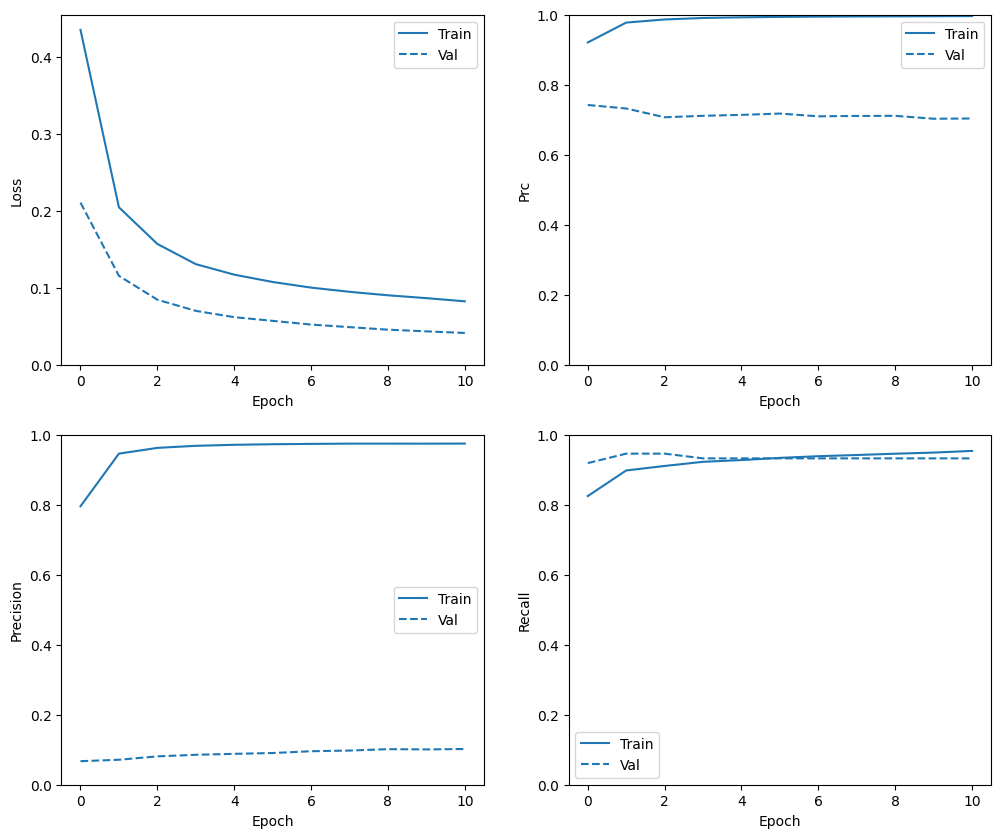

In [50]:
plot_metrics(resampled_history)

### 재교육


균형 잡힌 데이터에 대한 훈련이 더 쉽기 때문에 위의 훈련 절차가 빠르게 과적합 될 수 있습니다.

epoch를 나누어 `tf.keras.callbacks.EarlyStopping`를 보다 세밀하게 제어하여 훈련 중단 시점을 정합니다.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 31s - loss: 1.5579 - tp: 504.0000 - fp: 1006.0000 - tn: 45494.0000 - fn: 613.0000 - accuracy: 0.9660 - precision: 0.3338 - recall: 0.4512 - auc: 0.8755 - prc: 0.4137

 5/20 [======>.......................] - ETA: 0s - loss: 1.4300 - tp: 2361.0000 - fp: 2669.0000 - tn: 47908.0000 - fn: 2871.0000 - accuracy: 0.9007 - precision: 0.4694 - recall: 0.4513 - auc: 0.8532 - prc: 0.5331

 7/20 [=========>....................] - ETA: 0s - loss: 1.3769 - tp: 3349.0000 - fp: 3529.0000 - tn: 49133.0000 - fn: 3894.0000 - accuracy: 0.8761 - precision: 0.4869 - recall: 0.4624 - auc: 0.8450 - prc: 0.5611

 9/20 [============>.................] - ETA: 0s - loss: 1.3330 - tp: 4445.0000 - fp: 4430.0000 - tn: 50276.0000 - fn: 4850.0000 - accuracy: 0.8550 - precision: 0.5008 - recall: 0.4782 - auc: 0.8389 - prc: 0.5872

12/20 [=================>............] - ETA: 0s - loss: 1.2796 - tp: 6136.0000 - fp: 5684.0000 - tn: 52052.0000 - fn: 6273.0000 - accuracy: 0.8295 - precision: 0.5191 - recall: 0.4945 - auc: 0.8304 - prc: 0.6156

14/20 [====================>.........] - ETA: 0s - loss: 1.2424 - tp: 7290.0000 - fp: 6541.0000 - tn: 53251.0000 - fn: 7159.0000 - accuracy: 0.8155 - precision: 0.5271 - recall: 0.5045 - auc: 0.8258 - prc: 0.6319

16/20 [=======================>......] - ETA: 0s - loss: 1.2091 - tp: 8518.0000 - fp: 7418.0000 - tn: 54427.0000 - fn: 7974.0000 - accuracy: 0.8035 - precision: 0.5345 - recall: 0.5165 - auc: 0.8220 - prc: 0.6460

18/20 [==========================>...] - ETA: 0s - loss: 1.1759 - tp: 9824.0000 - fp: 8230.0000 - tn: 55679.0000 - fn: 8700.0000 - accuracy: 0.7946 - precision: 0.5441 - recall: 0.5303 - auc: 0.8193 - prc: 0.6600

20/20 [==============================] - 3s 56ms/step - loss: 1.1473 - tp: 11103.0000 - fp: 9113.0000 - tn: 56891.0000 - fn: 9422.0000 - accuracy: 0.7858 - precision: 0.5492 - recall: 0.5410 - auc: 0.8163 - prc: 0.6707 - val_loss: 0.6167 - val_tp: 63.0000 - val_fp: 15152.0000 - val_tn: 30343.0000 - val_fn: 11.0000 - val_accuracy: 0.6673 - val_precision: 0.0041 - val_recall: 0.8514 - val_auc: 0.8796 - val_prc: 0.4022


Epoch 2/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.8769 - tp: 631.0000 - fp: 447.0000 - tn: 616.0000 - fn: 354.0000 - accuracy: 0.6089 - precision: 0.5853 - recall: 0.6406 - auc: 0.6641 - prc: 0.7586

 5/20 [======>.......................] - ETA: 0s - loss: 0.8041 - tp: 3429.0000 - fp: 2181.0000 - tn: 2971.0000 - fn: 1659.0000 - accuracy: 0.6250 - precision: 0.6112 - recall: 0.6739 - auc: 0.6954 - prc: 0.7903

 8/20 [===========>..................] - ETA: 0s - loss: 0.7720 - tp: 5610.0000 - fp: 3433.0000 - tn: 4773.0000 - fn: 2568.0000 - accuracy: 0.6337 - precision: 0.6204 - recall: 0.6860 - auc: 0.7109 - prc: 0.8034

11/20 [===============>..............] - ETA: 0s - loss: 0.7539 - tp: 7812.0000 - fp: 4690.0000 - tn: 6544.0000 - fn: 3482.0000 - accuracy: 0.6373 - precision: 0.6249 - recall: 0.6917 - auc: 0.7187 - prc: 0.8103

14/20 [====================>.........] - ETA: 0s - loss: 0.7349 - tp: 10043.0000 - fp: 5993.0000 - tn: 8359.0000 - fn: 4277.0000 - accuracy: 0.6418 - precision: 0.6263 - recall: 0.7013 - auc: 0.7279 - prc: 0.8159

17/20 [========================>.....] - ETA: 0s - loss: 0.7154 - tp: 12355.0000 - fp: 7130.0000 - tn: 10286.0000 - fn: 5045.0000 - accuracy: 0.6503 - precision: 0.6341 - recall: 0.7101 - auc: 0.7382 - prc: 0.8230

20/20 [==============================] - ETA: 0s - loss: 0.6997 - tp: 14659.0000 - fp: 8326.0000 - tn: 12207.0000 - fn: 5768.0000 - accuracy: 0.6559 - precision: 0.6378 - recall: 0.7176 - auc: 0.7461 - prc: 0.8279

20/20 [==============================] - 1s 28ms/step - loss: 0.6997 - tp: 14659.0000 - fp: 8326.0000 - tn: 12207.0000 - fn: 5768.0000 - accuracy: 0.6559 - precision: 0.6378 - recall: 0.7176 - auc: 0.7461 - prc: 0.8279 - val_loss: 0.5798 - val_tp: 66.0000 - val_fp: 12901.0000 - val_tn: 32594.0000 - val_fn: 8.0000 - val_accuracy: 0.7167 - val_precision: 0.0051 - val_recall: 0.8919 - val_auc: 0.9219 - val_prc: 0.6033


Epoch 3/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5851 - tp: 787.0000 - fp: 363.0000 - tn: 621.0000 - fn: 277.0000 - accuracy: 0.6875 - precision: 0.6843 - recall: 0.7397 - auc: 0.7906 - prc: 0.8661

 5/20 [======>.......................] - ETA: 0s - loss: 0.5806 - tp: 3961.0000 - fp: 1897.0000 - tn: 3201.0000 - fn: 1181.0000 - accuracy: 0.6994 - precision: 0.6762 - recall: 0.7703 - auc: 0.8056 - prc: 0.8705

 8/20 [===========>..................] - ETA: 0s - loss: 0.5743 - tp: 6351.0000 - fp: 3027.0000 - tn: 5150.0000 - fn: 1856.0000 - accuracy: 0.7020 - precision: 0.6772 - recall: 0.7739 - auc: 0.8094 - prc: 0.8723

11/20 [===============>..............] - ETA: 0s - loss: 0.5685 - tp: 8803.0000 - fp: 4128.0000 - tn: 7117.0000 - fn: 2480.0000 - accuracy: 0.7067 - precision: 0.6808 - recall: 0.7802 - auc: 0.8140 - prc: 0.8755

14/20 [====================>.........] - ETA: 0s - loss: 0.5616 - tp: 11191.0000 - fp: 5227.0000 - tn: 9119.0000 - fn: 3135.0000 - accuracy: 0.7084 - precision: 0.6816 - recall: 0.7812 - auc: 0.8169 - prc: 0.8772

17/20 [========================>.....] - ETA: 0s - loss: 0.5550 - tp: 13677.0000 - fp: 6304.0000 - tn: 11085.0000 - fn: 3750.0000 - accuracy: 0.7112 - precision: 0.6845 - recall: 0.7848 - auc: 0.8206 - prc: 0.8799

20/20 [==============================] - ETA: 0s - loss: 0.5494 - tp: 16095.0000 - fp: 7381.0000 - tn: 13146.0000 - fn: 4338.0000 - accuracy: 0.7139 - precision: 0.6856 - recall: 0.7877 - auc: 0.8236 - prc: 0.8814

20/20 [==============================] - 1s 28ms/step - loss: 0.5494 - tp: 16095.0000 - fp: 7381.0000 - tn: 13146.0000 - fn: 4338.0000 - accuracy: 0.7139 - precision: 0.6856 - recall: 0.7877 - auc: 0.8236 - prc: 0.8814 - val_loss: 0.5260 - val_tp: 68.0000 - val_fp: 9533.0000 - val_tn: 35962.0000 - val_fn: 6.0000 - val_accuracy: 0.7907 - val_precision: 0.0071 - val_recall: 0.9189 - val_auc: 0.9387 - val_prc: 0.6616


Epoch 4/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5039 - tp: 819.0000 - fp: 333.0000 - tn: 696.0000 - fn: 200.0000 - accuracy: 0.7397 - precision: 0.7109 - recall: 0.8037 - auc: 0.8478 - prc: 0.8969

 5/20 [======>.......................] - ETA: 0s - loss: 0.5088 - tp: 4086.0000 - fp: 1656.0000 - tn: 3496.0000 - fn: 1002.0000 - accuracy: 0.7404 - precision: 0.7116 - recall: 0.8031 - auc: 0.8453 - prc: 0.8935

 8/20 [===========>..................] - ETA: 0s - loss: 0.5001 - tp: 6619.0000 - fp: 2628.0000 - tn: 5557.0000 - fn: 1580.0000 - accuracy: 0.7432 - precision: 0.7158 - recall: 0.8073 - auc: 0.8498 - prc: 0.8984

11/20 [===============>..............] - ETA: 0s - loss: 0.4953 - tp: 9134.0000 - fp: 3628.0000 - tn: 7642.0000 - fn: 2124.0000 - accuracy: 0.7447 - precision: 0.7157 - recall: 0.8113 - auc: 0.8531 - prc: 0.9004

14/20 [====================>.........] - ETA: 0s - loss: 0.4911 - tp: 11699.0000 - fp: 4556.0000 - tn: 9716.0000 - fn: 2701.0000 - accuracy: 0.7469 - precision: 0.7197 - recall: 0.8124 - auc: 0.8543 - prc: 0.9019

17/20 [========================>.....] - ETA: 0s - loss: 0.4860 - tp: 14184.0000 - fp: 5472.0000 - tn: 11908.0000 - fn: 3252.0000 - accuracy: 0.7494 - precision: 0.7216 - recall: 0.8135 - auc: 0.8562 - prc: 0.9031

20/20 [==============================] - ETA: 0s - loss: 0.4807 - tp: 16677.0000 - fp: 6348.0000 - tn: 14147.0000 - fn: 3788.0000 - accuracy: 0.7525 - precision: 0.7243 - recall: 0.8149 - auc: 0.8587 - prc: 0.9043

20/20 [==============================] - 1s 29ms/step - loss: 0.4807 - tp: 16677.0000 - fp: 6348.0000 - tn: 14147.0000 - fn: 3788.0000 - accuracy: 0.7525 - precision: 0.7243 - recall: 0.8149 - auc: 0.8587 - prc: 0.9043 - val_loss: 0.4725 - val_tp: 67.0000 - val_fp: 6386.0000 - val_tn: 39109.0000 - val_fn: 7.0000 - val_accuracy: 0.8597 - val_precision: 0.0104 - val_recall: 0.9054 - val_auc: 0.9500 - val_prc: 0.6841


Epoch 5/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4686 - tp: 851.0000 - fp: 305.0000 - tn: 701.0000 - fn: 191.0000 - accuracy: 0.7578 - precision: 0.7362 - recall: 0.8167 - auc: 0.8635 - prc: 0.9107

 5/20 [======>.......................] - ETA: 0s - loss: 0.4581 - tp: 4204.0000 - fp: 1528.0000 - tn: 3584.0000 - fn: 924.0000 - accuracy: 0.7605 - precision: 0.7334 - recall: 0.8198 - auc: 0.8665 - prc: 0.9109

 8/20 [===========>..................] - ETA: 0s - loss: 0.4504 - tp: 6802.0000 - fp: 2353.0000 - tn: 5760.0000 - fn: 1469.0000 - accuracy: 0.7667 - precision: 0.7430 - recall: 0.8224 - auc: 0.8710 - prc: 0.9140

11/20 [===============>..............] - ETA: 0s - loss: 0.4448 - tp: 9321.0000 - fp: 3178.0000 - tn: 8051.0000 - fn: 1978.0000 - accuracy: 0.7711 - precision: 0.7457 - recall: 0.8249 - auc: 0.8743 - prc: 0.9152

14/20 [====================>.........] - ETA: 0s - loss: 0.4400 - tp: 11856.0000 - fp: 4007.0000 - tn: 10335.0000 - fn: 2474.0000 - accuracy: 0.7740 - precision: 0.7474 - recall: 0.8274 - auc: 0.8773 - prc: 0.9165

17/20 [========================>.....] - ETA: 0s - loss: 0.4363 - tp: 14418.0000 - fp: 4740.0000 - tn: 12678.0000 - fn: 2980.0000 - accuracy: 0.7783 - precision: 0.7526 - recall: 0.8287 - auc: 0.8792 - prc: 0.9178

20/20 [==============================] - ETA: 0s - loss: 0.4335 - tp: 17000.0000 - fp: 5508.0000 - tn: 14962.0000 - fn: 3490.0000 - accuracy: 0.7803 - precision: 0.7553 - recall: 0.8297 - auc: 0.8805 - prc: 0.9186

20/20 [==============================] - 1s 29ms/step - loss: 0.4335 - tp: 17000.0000 - fp: 5508.0000 - tn: 14962.0000 - fn: 3490.0000 - accuracy: 0.7803 - precision: 0.7553 - recall: 0.8297 - auc: 0.8805 - prc: 0.9186 - val_loss: 0.4249 - val_tp: 67.0000 - val_fp: 4010.0000 - val_tn: 41485.0000 - val_fn: 7.0000 - val_accuracy: 0.9118 - val_precision: 0.0164 - val_recall: 0.9054 - val_auc: 0.9557 - val_prc: 0.7010


Epoch 6/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4195 - tp: 855.0000 - fp: 254.0000 - tn: 748.0000 - fn: 191.0000 - accuracy: 0.7827 - precision: 0.7710 - recall: 0.8174 - auc: 0.8801 - prc: 0.9216

 5/20 [======>.......................] - ETA: 0s - loss: 0.4133 - tp: 4280.0000 - fp: 1234.0000 - tn: 3848.0000 - fn: 878.0000 - accuracy: 0.7937 - precision: 0.7762 - recall: 0.8298 - auc: 0.8886 - prc: 0.9247

 8/20 [===========>..................] - ETA: 0s - loss: 0.4119 - tp: 6831.0000 - fp: 1955.0000 - tn: 6196.0000 - fn: 1402.0000 - accuracy: 0.7951 - precision: 0.7775 - recall: 0.8297 - auc: 0.8887 - prc: 0.9246

11/20 [===============>..............] - ETA: 0s - loss: 0.4090 - tp: 9425.0000 - fp: 2652.0000 - tn: 8548.0000 - fn: 1903.0000 - accuracy: 0.7978 - precision: 0.7804 - recall: 0.8320 - auc: 0.8903 - prc: 0.9255

14/20 [====================>.........] - ETA: 0s - loss: 0.4045 - tp: 12130.0000 - fp: 3287.0000 - tn: 10854.0000 - fn: 2401.0000 - accuracy: 0.8016 - precision: 0.7868 - recall: 0.8348 - auc: 0.8921 - prc: 0.9277

17/20 [========================>.....] - ETA: 0s - loss: 0.4020 - tp: 14779.0000 - fp: 3914.0000 - tn: 13224.0000 - fn: 2899.0000 - accuracy: 0.8043 - precision: 0.7906 - recall: 0.8360 - auc: 0.8933 - prc: 0.9287

20/20 [==============================] - ETA: 0s - loss: 0.3995 - tp: 17406.0000 - fp: 4611.0000 - tn: 15574.0000 - fn: 3369.0000 - accuracy: 0.8052 - precision: 0.7906 - recall: 0.8378 - auc: 0.8946 - prc: 0.9295

20/20 [==============================] - 1s 29ms/step - loss: 0.3995 - tp: 17406.0000 - fp: 4611.0000 - tn: 15574.0000 - fn: 3369.0000 - accuracy: 0.8052 - precision: 0.7906 - recall: 0.8378 - auc: 0.8946 - prc: 0.9295 - val_loss: 0.3864 - val_tp: 69.0000 - val_fp: 2720.0000 - val_tn: 42775.0000 - val_fn: 5.0000 - val_accuracy: 0.9402 - val_precision: 0.0247 - val_recall: 0.9324 - val_auc: 0.9581 - val_prc: 0.6994


Epoch 7/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3923 - tp: 872.0000 - fp: 236.0000 - tn: 773.0000 - fn: 167.0000 - accuracy: 0.8032 - precision: 0.7870 - recall: 0.8393 - auc: 0.8977 - prc: 0.9316

 5/20 [======>.......................] - ETA: 0s - loss: 0.3789 - tp: 4339.0000 - fp: 1030.0000 - tn: 4057.0000 - fn: 814.0000 - accuracy: 0.8199 - precision: 0.8082 - recall: 0.8420 - auc: 0.9034 - prc: 0.9341

 8/20 [===========>..................] - ETA: 0s - loss: 0.3746 - tp: 6915.0000 - fp: 1648.0000 - tn: 6574.0000 - fn: 1247.0000 - accuracy: 0.8233 - precision: 0.8075 - recall: 0.8472 - auc: 0.9075 - prc: 0.9355

11/20 [===============>..............] - ETA: 0s - loss: 0.3758 - tp: 9541.0000 - fp: 2222.0000 - tn: 9040.0000 - fn: 1725.0000 - accuracy: 0.8248 - precision: 0.8111 - recall: 0.8469 - auc: 0.9069 - prc: 0.9353

14/20 [====================>.........] - ETA: 0s - loss: 0.3740 - tp: 12175.0000 - fp: 2793.0000 - tn: 11532.0000 - fn: 2172.0000 - accuracy: 0.8268 - precision: 0.8134 - recall: 0.8486 - auc: 0.9083 - prc: 0.9360

17/20 [========================>.....] - ETA: 0s - loss: 0.3724 - tp: 14779.0000 - fp: 3378.0000 - tn: 14054.0000 - fn: 2605.0000 - accuracy: 0.8282 - precision: 0.8140 - recall: 0.8501 - auc: 0.9093 - prc: 0.9366

20/20 [==============================] - ETA: 0s - loss: 0.3680 - tp: 17413.0000 - fp: 3956.0000 - tn: 16601.0000 - fn: 2990.0000 - accuracy: 0.8304 - precision: 0.8149 - recall: 0.8535 - auc: 0.9117 - prc: 0.9381

20/20 [==============================] - 1s 29ms/step - loss: 0.3680 - tp: 17413.0000 - fp: 3956.0000 - tn: 16601.0000 - fn: 2990.0000 - accuracy: 0.8304 - precision: 0.8149 - recall: 0.8535 - auc: 0.9117 - prc: 0.9381 - val_loss: 0.3531 - val_tp: 69.0000 - val_fp: 1974.0000 - val_tn: 43521.0000 - val_fn: 5.0000 - val_accuracy: 0.9566 - val_precision: 0.0338 - val_recall: 0.9324 - val_auc: 0.9591 - val_prc: 0.7071


Epoch 8/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3445 - tp: 917.0000 - fp: 169.0000 - tn: 810.0000 - fn: 152.0000 - accuracy: 0.8433 - precision: 0.8444 - recall: 0.8578 - auc: 0.9200 - prc: 0.9481

 5/20 [======>.......................] - ETA: 0s - loss: 0.3533 - tp: 4468.0000 - fp: 885.0000 - tn: 4134.0000 - fn: 753.0000 - accuracy: 0.8400 - precision: 0.8347 - recall: 0.8558 - auc: 0.9169 - prc: 0.9438

 8/20 [===========>..................] - ETA: 0s - loss: 0.3506 - tp: 7098.0000 - fp: 1395.0000 - tn: 6705.0000 - fn: 1186.0000 - accuracy: 0.8425 - precision: 0.8357 - recall: 0.8568 - auc: 0.9183 - prc: 0.9438

11/20 [===============>..............] - ETA: 0s - loss: 0.3471 - tp: 9709.0000 - fp: 1913.0000 - tn: 9314.0000 - fn: 1592.0000 - accuracy: 0.8444 - precision: 0.8354 - recall: 0.8591 - auc: 0.9203 - prc: 0.9444

14/20 [====================>.........] - ETA: 0s - loss: 0.3445 - tp: 12348.0000 - fp: 2395.0000 - tn: 11926.0000 - fn: 2003.0000 - accuracy: 0.8466 - precision: 0.8376 - recall: 0.8604 - auc: 0.9216 - prc: 0.9451

17/20 [========================>.....] - ETA: 0s - loss: 0.3419 - tp: 15019.0000 - fp: 2835.0000 - tn: 14560.0000 - fn: 2402.0000 - accuracy: 0.8496 - precision: 0.8412 - recall: 0.8621 - auc: 0.9229 - prc: 0.9460

20/20 [==============================] - ETA: 0s - loss: 0.3402 - tp: 17711.0000 - fp: 3290.0000 - tn: 17159.0000 - fn: 2800.0000 - accuracy: 0.8513 - precision: 0.8433 - recall: 0.8635 - auc: 0.9238 - prc: 0.9465

20/20 [==============================] - 1s 30ms/step - loss: 0.3402 - tp: 17711.0000 - fp: 3290.0000 - tn: 17159.0000 - fn: 2800.0000 - accuracy: 0.8513 - precision: 0.8433 - recall: 0.8635 - auc: 0.9238 - prc: 0.9465 - val_loss: 0.3237 - val_tp: 69.0000 - val_fp: 1614.0000 - val_tn: 43881.0000 - val_fn: 5.0000 - val_accuracy: 0.9645 - val_precision: 0.0410 - val_recall: 0.9324 - val_auc: 0.9599 - val_prc: 0.7126


Epoch 9/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3414 - tp: 855.0000 - fp: 168.0000 - tn: 892.0000 - fn: 133.0000 - accuracy: 0.8530 - precision: 0.8358 - recall: 0.8654 - auc: 0.9273 - prc: 0.9452

 5/20 [======>.......................] - ETA: 0s - loss: 0.3364 - tp: 4386.0000 - fp: 775.0000 - tn: 4382.0000 - fn: 697.0000 - accuracy: 0.8562 - precision: 0.8498 - recall: 0.8629 - auc: 0.9252 - prc: 0.9468

 8/20 [===========>..................] - ETA: 0s - loss: 0.3300 - tp: 7049.0000 - fp: 1203.0000 - tn: 7043.0000 - fn: 1089.0000 - accuracy: 0.8601 - precision: 0.8542 - recall: 0.8662 - auc: 0.9285 - prc: 0.9490

10/20 [==============>...............] - ETA: 0s - loss: 0.3296 - tp: 8856.0000 - fp: 1518.0000 - tn: 8763.0000 - fn: 1343.0000 - accuracy: 0.8603 - precision: 0.8537 - recall: 0.8683 - auc: 0.9293 - prc: 0.9497

13/20 [==================>...........] - ETA: 0s - loss: 0.3252 - tp: 11562.0000 - fp: 1922.0000 - tn: 11412.0000 - fn: 1728.0000 - accuracy: 0.8629 - precision: 0.8575 - recall: 0.8700 - auc: 0.9308 - prc: 0.9509

16/20 [=======================>......] - ETA: 0s - loss: 0.3240 - tp: 14264.0000 - fp: 2340.0000 - tn: 14027.0000 - fn: 2137.0000 - accuracy: 0.8634 - precision: 0.8591 - recall: 0.8697 - auc: 0.9309 - prc: 0.9511

19/20 [===========================>..] - ETA: 0s - loss: 0.3219 - tp: 16954.0000 - fp: 2730.0000 - tn: 16707.0000 - fn: 2521.0000 - accuracy: 0.8651 - precision: 0.8613 - recall: 0.8706 - auc: 0.9319 - prc: 0.9519

20/20 [==============================] - 1s 29ms/step - loss: 0.3214 - tp: 17827.0000 - fp: 2886.0000 - tn: 17607.0000 - fn: 2640.0000 - accuracy: 0.8651 - precision: 0.8607 - recall: 0.8710 - auc: 0.9322 - prc: 0.9520 - val_loss: 0.2980 - val_tp: 69.0000 - val_fp: 1344.0000 - val_tn: 44151.0000 - val_fn: 5.0000 - val_accuracy: 0.9704 - val_precision: 0.0488 - val_recall: 0.9324 - val_auc: 0.9608 - val_prc: 0.7262


Epoch 10/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3202 - tp: 908.0000 - fp: 154.0000 - tn: 857.0000 - fn: 129.0000 - accuracy: 0.8618 - precision: 0.8550 - recall: 0.8756 - auc: 0.9344 - prc: 0.9531

 5/20 [======>.......................] - ETA: 0s - loss: 0.3052 - tp: 4505.0000 - fp: 677.0000 - tn: 4437.0000 - fn: 621.0000 - accuracy: 0.8732 - precision: 0.8694 - recall: 0.8789 - auc: 0.9390 - prc: 0.9567

 7/20 [=========>....................] - ETA: 0s - loss: 0.3032 - tp: 6307.0000 - fp: 940.0000 - tn: 6221.0000 - fn: 868.0000 - accuracy: 0.8739 - precision: 0.8703 - recall: 0.8790 - auc: 0.9396 - prc: 0.9570

10/20 [==============>...............] - ETA: 0s - loss: 0.3031 - tp: 8993.0000 - fp: 1334.0000 - tn: 8909.0000 - fn: 1244.0000 - accuracy: 0.8741 - precision: 0.8708 - recall: 0.8785 - auc: 0.9397 - prc: 0.9572

13/20 [==================>...........] - ETA: 0s - loss: 0.3036 - tp: 11705.0000 - fp: 1704.0000 - tn: 11572.0000 - fn: 1643.0000 - accuracy: 0.8743 - precision: 0.8729 - recall: 0.8769 - auc: 0.9387 - prc: 0.9569

16/20 [=======================>......] - ETA: 0s - loss: 0.3024 - tp: 14352.0000 - fp: 2063.0000 - tn: 14335.0000 - fn: 2018.0000 - accuracy: 0.8755 - precision: 0.8743 - recall: 0.8767 - auc: 0.9390 - prc: 0.9570

19/20 [===========================>..] - ETA: 0s - loss: 0.3009 - tp: 17133.0000 - fp: 2425.0000 - tn: 16979.0000 - fn: 2375.0000 - accuracy: 0.8766 - precision: 0.8760 - recall: 0.8783 - auc: 0.9397 - prc: 0.9577

20/20 [==============================] - 1s 29ms/step - loss: 0.3009 - tp: 18039.0000 - fp: 2543.0000 - tn: 17866.0000 - fn: 2512.0000 - accuracy: 0.8766 - precision: 0.8764 - recall: 0.8778 - auc: 0.9395 - prc: 0.9576 - val_loss: 0.2754 - val_tp: 69.0000 - val_fp: 1179.0000 - val_tn: 44316.0000 - val_fn: 5.0000 - val_accuracy: 0.9740 - val_precision: 0.0553 - val_recall: 0.9324 - val_auc: 0.9628 - val_prc: 0.7284


Epoch 11/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3018 - tp: 885.0000 - fp: 126.0000 - tn: 903.0000 - fn: 134.0000 - accuracy: 0.8730 - precision: 0.8754 - recall: 0.8685 - auc: 0.9389 - prc: 0.9571

 5/20 [======>.......................] - ETA: 0s - loss: 0.2960 - tp: 4504.0000 - fp: 597.0000 - tn: 4514.0000 - fn: 625.0000 - accuracy: 0.8807 - precision: 0.8830 - recall: 0.8781 - auc: 0.9417 - prc: 0.9587

 8/20 [===========>..................] - ETA: 0s - loss: 0.2919 - tp: 7203.0000 - fp: 927.0000 - tn: 7270.0000 - fn: 984.0000 - accuracy: 0.8834 - precision: 0.8860 - recall: 0.8798 - auc: 0.9434 - prc: 0.9595

11/20 [===============>..............] - ETA: 0s - loss: 0.2876 - tp: 9943.0000 - fp: 1255.0000 - tn: 10003.0000 - fn: 1327.0000 - accuracy: 0.8854 - precision: 0.8879 - recall: 0.8823 - auc: 0.9454 - prc: 0.9609

14/20 [====================>.........] - ETA: 0s - loss: 0.2883 - tp: 12662.0000 - fp: 1601.0000 - tn: 12709.0000 - fn: 1700.0000 - accuracy: 0.8849 - precision: 0.8878 - recall: 0.8816 - auc: 0.9448 - prc: 0.9607

17/20 [========================>.....] - ETA: 0s - loss: 0.2870 - tp: 15419.0000 - fp: 1913.0000 - tn: 15412.0000 - fn: 2072.0000 - accuracy: 0.8855 - precision: 0.8896 - recall: 0.8815 - auc: 0.9449 - prc: 0.9611

20/20 [==============================] - ETA: 0s - loss: 0.2860 - tp: 18124.0000 - fp: 2217.0000 - tn: 18200.0000 - fn: 2419.0000 - accuracy: 0.8868 - precision: 0.8910 - recall: 0.8822 - auc: 0.9455 - prc: 0.9613

20/20 [==============================] - 1s 29ms/step - loss: 0.2860 - tp: 18124.0000 - fp: 2217.0000 - tn: 18200.0000 - fn: 2419.0000 - accuracy: 0.8868 - precision: 0.8910 - recall: 0.8822 - auc: 0.9455 - prc: 0.9613 - val_loss: 0.2564 - val_tp: 69.0000 - val_fp: 1075.0000 - val_tn: 44420.0000 - val_fn: 5.0000 - val_accuracy: 0.9763 - val_precision: 0.0603 - val_recall: 0.9324 - val_auc: 0.9656 - val_prc: 0.7330


Epoch 12/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2652 - tp: 916.0000 - fp: 93.0000 - tn: 921.0000 - fn: 118.0000 - accuracy: 0.8970 - precision: 0.9078 - recall: 0.8859 - auc: 0.9527 - prc: 0.9663

 4/20 [=====>........................] - ETA: 0s - loss: 0.2778 - tp: 3612.0000 - fp: 421.0000 - tn: 3675.0000 - fn: 484.0000 - accuracy: 0.8895 - precision: 0.8956 - recall: 0.8818 - auc: 0.9494 - prc: 0.9626

 7/20 [=========>....................] - ETA: 0s - loss: 0.2795 - tp: 6419.0000 - fp: 726.0000 - tn: 6340.0000 - fn: 851.0000 - accuracy: 0.8900 - precision: 0.8984 - recall: 0.8829 - auc: 0.9487 - prc: 0.9632

10/20 [==============>...............] - ETA: 0s - loss: 0.2784 - tp: 9180.0000 - fp: 1021.0000 - tn: 9091.0000 - fn: 1188.0000 - accuracy: 0.8921 - precision: 0.8999 - recall: 0.8854 - auc: 0.9492 - prc: 0.9637

13/20 [==================>...........] - ETA: 0s - loss: 0.2763 - tp: 11929.0000 - fp: 1321.0000 - tn: 11862.0000 - fn: 1512.0000 - accuracy: 0.8936 - precision: 0.9003 - recall: 0.8875 - auc: 0.9499 - prc: 0.9643

15/20 [=====================>........] - ETA: 0s - loss: 0.2744 - tp: 13735.0000 - fp: 1505.0000 - tn: 13738.0000 - fn: 1742.0000 - accuracy: 0.8943 - precision: 0.9012 - recall: 0.8874 - auc: 0.9503 - prc: 0.9645

18/20 [==========================>...] - ETA: 0s - loss: 0.2733 - tp: 16419.0000 - fp: 1792.0000 - tn: 16558.0000 - fn: 2095.0000 - accuracy: 0.8946 - precision: 0.9016 - recall: 0.8868 - auc: 0.9504 - prc: 0.9645

20/20 [==============================] - 1s 30ms/step - loss: 0.2730 - tp: 18217.0000 - fp: 2016.0000 - tn: 18415.0000 - fn: 2312.0000 - accuracy: 0.8943 - precision: 0.9004 - recall: 0.8874 - auc: 0.9504 - prc: 0.9644 - val_loss: 0.2392 - val_tp: 69.0000 - val_fp: 1017.0000 - val_tn: 44478.0000 - val_fn: 5.0000 - val_accuracy: 0.9776 - val_precision: 0.0635 - val_recall: 0.9324 - val_auc: 0.9680 - val_prc: 0.7343


Epoch 13/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2656 - tp: 914.0000 - fp: 91.0000 - tn: 932.0000 - fn: 111.0000 - accuracy: 0.9014 - precision: 0.9095 - recall: 0.8917 - auc: 0.9566 - prc: 0.9673

 5/20 [======>.......................] - ETA: 0s - loss: 0.2716 - tp: 4518.0000 - fp: 472.0000 - tn: 4669.0000 - fn: 581.0000 - accuracy: 0.8972 - precision: 0.9054 - recall: 0.8861 - auc: 0.9519 - prc: 0.9642

 8/20 [===========>..................] - ETA: 0s - loss: 0.2679 - tp: 7278.0000 - fp: 724.0000 - tn: 7433.0000 - fn: 949.0000 - accuracy: 0.8979 - precision: 0.9095 - recall: 0.8846 - auc: 0.9520 - prc: 0.9650

11/20 [===============>..............] - ETA: 0s - loss: 0.2655 - tp: 9951.0000 - fp: 987.0000 - tn: 10305.0000 - fn: 1285.0000 - accuracy: 0.8991 - precision: 0.9098 - recall: 0.8856 - auc: 0.9528 - prc: 0.9654

14/20 [====================>.........] - ETA: 0s - loss: 0.2630 - tp: 12702.0000 - fp: 1251.0000 - tn: 13103.0000 - fn: 1616.0000 - accuracy: 0.9000 - precision: 0.9103 - recall: 0.8871 - auc: 0.9536 - prc: 0.9661

16/20 [=======================>......] - ETA: 0s - loss: 0.2624 - tp: 14556.0000 - fp: 1431.0000 - tn: 14934.0000 - fn: 1847.0000 - accuracy: 0.9000 - precision: 0.9105 - recall: 0.8874 - auc: 0.9537 - prc: 0.9664

18/20 [==========================>...] - ETA: 0s - loss: 0.2617 - tp: 16368.0000 - fp: 1613.0000 - tn: 16809.0000 - fn: 2074.0000 - accuracy: 0.9000 - precision: 0.9103 - recall: 0.8875 - auc: 0.9540 - prc: 0.9666

20/20 [==============================] - ETA: 0s - loss: 0.2616 - tp: 18205.0000 - fp: 1788.0000 - tn: 18682.0000 - fn: 2285.0000 - accuracy: 0.9006 - precision: 0.9106 - recall: 0.8885 - auc: 0.9542 - prc: 0.9668

20/20 [==============================] - 1s 31ms/step - loss: 0.2616 - tp: 18205.0000 - fp: 1788.0000 - tn: 18682.0000 - fn: 2285.0000 - accuracy: 0.9006 - precision: 0.9106 - recall: 0.8885 - auc: 0.9542 - prc: 0.9668 - val_loss: 0.2235 - val_tp: 69.0000 - val_fp: 963.0000 - val_tn: 44532.0000 - val_fn: 5.0000 - val_accuracy: 0.9788 - val_precision: 0.0669 - val_recall: 0.9324 - val_auc: 0.9710 - val_prc: 0.7393


Epoch 14/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2599 - tp: 925.0000 - fp: 80.0000 - tn: 914.0000 - fn: 129.0000 - accuracy: 0.8979 - precision: 0.9204 - recall: 0.8776 - auc: 0.9528 - prc: 0.9672

 4/20 [=====>........................] - ETA: 0s - loss: 0.2557 - tp: 3629.0000 - fp: 335.0000 - tn: 3785.0000 - fn: 443.0000 - accuracy: 0.9050 - precision: 0.9155 - recall: 0.8912 - auc: 0.9567 - prc: 0.9680

 6/20 [========>.....................] - ETA: 0s - loss: 0.2543 - tp: 5458.0000 - fp: 487.0000 - tn: 5676.0000 - fn: 667.0000 - accuracy: 0.9061 - precision: 0.9181 - recall: 0.8911 - auc: 0.9563 - prc: 0.9681

 8/20 [===========>..................] - ETA: 0s - loss: 0.2515 - tp: 7316.0000 - fp: 626.0000 - tn: 7559.0000 - fn: 883.0000 - accuracy: 0.9079 - precision: 0.9212 - recall: 0.8923 - auc: 0.9569 - prc: 0.9689

10/20 [==============>...............] - ETA: 0s - loss: 0.2500 - tp: 9141.0000 - fp: 784.0000 - tn: 9454.0000 - fn: 1101.0000 - accuracy: 0.9080 - precision: 0.9210 - recall: 0.8925 - auc: 0.9572 - prc: 0.9691

12/20 [=================>............] - ETA: 0s - loss: 0.2499 - tp: 10951.0000 - fp: 928.0000 - tn: 11373.0000 - fn: 1324.0000 - accuracy: 0.9084 - precision: 0.9219 - recall: 0.8921 - auc: 0.9571 - prc: 0.9690

15/20 [=====================>........] - ETA: 0s - loss: 0.2501 - tp: 13704.0000 - fp: 1181.0000 - tn: 14157.0000 - fn: 1678.0000 - accuracy: 0.9069 - precision: 0.9207 - recall: 0.8909 - auc: 0.9569 - prc: 0.9689

18/20 [==========================>...] - ETA: 0s - loss: 0.2498 - tp: 16429.0000 - fp: 1408.0000 - tn: 17020.0000 - fn: 2007.0000 - accuracy: 0.9074 - precision: 0.9211 - recall: 0.8911 - auc: 0.9570 - prc: 0.9689

20/20 [==============================] - 1s 33ms/step - loss: 0.2495 - tp: 18265.0000 - fp: 1585.0000 - tn: 18898.0000 - fn: 2212.0000 - accuracy: 0.9073 - precision: 0.9202 - recall: 0.8920 - auc: 0.9573 - prc: 0.9690 - val_loss: 0.2101 - val_tp: 68.0000 - val_fp: 952.0000 - val_tn: 44543.0000 - val_fn: 6.0000 - val_accuracy: 0.9790 - val_precision: 0.0667 - val_recall: 0.9189 - val_auc: 0.9729 - val_prc: 0.7423


Epoch 15/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2490 - tp: 906.0000 - fp: 93.0000 - tn: 929.0000 - fn: 120.0000 - accuracy: 0.8960 - precision: 0.9069 - recall: 0.8830 - auc: 0.9554 - prc: 0.9674

 4/20 [=====>........................] - ETA: 0s - loss: 0.2409 - tp: 3610.0000 - fp: 326.0000 - tn: 3838.0000 - fn: 418.0000 - accuracy: 0.9092 - precision: 0.9172 - recall: 0.8962 - auc: 0.9608 - prc: 0.9707

 6/20 [========>.....................] - ETA: 0s - loss: 0.2438 - tp: 5426.0000 - fp: 492.0000 - tn: 5724.0000 - fn: 646.0000 - accuracy: 0.9074 - precision: 0.9169 - recall: 0.8936 - auc: 0.9602 - prc: 0.9701

 8/20 [===========>..................] - ETA: 0s - loss: 0.2447 - tp: 7245.0000 - fp: 633.0000 - tn: 7648.0000 - fn: 858.0000 - accuracy: 0.9090 - precision: 0.9196 - recall: 0.8941 - auc: 0.9598 - prc: 0.9700

11/20 [===============>..............] - ETA: 0s - loss: 0.2461 - tp: 9963.0000 - fp: 887.0000 - tn: 10485.0000 - fn: 1193.0000 - accuracy: 0.9077 - precision: 0.9182 - recall: 0.8931 - auc: 0.9590 - prc: 0.9696

14/20 [====================>.........] - ETA: 0s - loss: 0.2465 - tp: 12716.0000 - fp: 1095.0000 - tn: 13321.0000 - fn: 1540.0000 - accuracy: 0.9081 - precision: 0.9207 - recall: 0.8920 - auc: 0.9587 - prc: 0.9694

17/20 [========================>.....] - ETA: 0s - loss: 0.2446 - tp: 15494.0000 - fp: 1311.0000 - tn: 16143.0000 - fn: 1868.0000 - accuracy: 0.9087 - precision: 0.9220 - recall: 0.8924 - auc: 0.9592 - prc: 0.9699

20/20 [==============================] - ETA: 0s - loss: 0.2436 - tp: 18314.0000 - fp: 1515.0000 - tn: 18927.0000 - fn: 2204.0000 - accuracy: 0.9092 - precision: 0.9236 - recall: 0.8926 - auc: 0.9593 - prc: 0.9702

20/20 [==============================] - 1s 31ms/step - loss: 0.2436 - tp: 18314.0000 - fp: 1515.0000 - tn: 18927.0000 - fn: 2204.0000 - accuracy: 0.9092 - precision: 0.9236 - recall: 0.8926 - auc: 0.9593 - prc: 0.9702 - val_loss: 0.1978 - val_tp: 68.0000 - val_fp: 936.0000 - val_tn: 44559.0000 - val_fn: 6.0000 - val_accuracy: 0.9793 - val_precision: 0.0677 - val_recall: 0.9189 - val_auc: 0.9748 - val_prc: 0.7431


Epoch 16/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2279 - tp: 928.0000 - fp: 74.0000 - tn: 951.0000 - fn: 95.0000 - accuracy: 0.9175 - precision: 0.9261 - recall: 0.9071 - auc: 0.9656 - prc: 0.9744

 4/20 [=====>........................] - ETA: 0s - loss: 0.2386 - tp: 3649.0000 - fp: 328.0000 - tn: 3801.0000 - fn: 414.0000 - accuracy: 0.9094 - precision: 0.9175 - recall: 0.8981 - auc: 0.9611 - prc: 0.9711

 7/20 [=========>....................] - ETA: 0s - loss: 0.2407 - tp: 6420.0000 - fp: 530.0000 - tn: 6647.0000 - fn: 739.0000 - accuracy: 0.9115 - precision: 0.9237 - recall: 0.8968 - auc: 0.9605 - prc: 0.9706

10/20 [==============>...............] - ETA: 0s - loss: 0.2374 - tp: 9147.0000 - fp: 709.0000 - tn: 9560.0000 - fn: 1064.0000 - accuracy: 0.9134 - precision: 0.9281 - recall: 0.8958 - auc: 0.9617 - prc: 0.9712

13/20 [==================>...........] - ETA: 0s - loss: 0.2354 - tp: 11921.0000 - fp: 930.0000 - tn: 12387.0000 - fn: 1386.0000 - accuracy: 0.9130 - precision: 0.9276 - recall: 0.8958 - auc: 0.9621 - prc: 0.9717

16/20 [=======================>......] - ETA: 0s - loss: 0.2341 - tp: 14669.0000 - fp: 1124.0000 - tn: 15272.0000 - fn: 1703.0000 - accuracy: 0.9137 - precision: 0.9288 - recall: 0.8960 - auc: 0.9624 - prc: 0.9720

19/20 [===========================>..] - ETA: 0s - loss: 0.2345 - tp: 17377.0000 - fp: 1371.0000 - tn: 18125.0000 - fn: 2039.0000 - accuracy: 0.9124 - precision: 0.9269 - recall: 0.8950 - auc: 0.9625 - prc: 0.9719

20/20 [==============================] - 1s 29ms/step - loss: 0.2339 - tp: 18312.0000 - fp: 1438.0000 - tn: 19063.0000 - fn: 2147.0000 - accuracy: 0.9125 - precision: 0.9272 - recall: 0.8951 - auc: 0.9626 - prc: 0.9720 - val_loss: 0.1869 - val_tp: 68.0000 - val_fp: 928.0000 - val_tn: 44567.0000 - val_fn: 6.0000 - val_accuracy: 0.9795 - val_precision: 0.0683 - val_recall: 0.9189 - val_auc: 0.9756 - val_prc: 0.7338


Epoch 17/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2212 - tp: 908.0000 - fp: 77.0000 - tn: 956.0000 - fn: 107.0000 - accuracy: 0.9102 - precision: 0.9218 - recall: 0.8946 - auc: 0.9686 - prc: 0.9751

 5/20 [======>.......................] - ETA: 0s - loss: 0.2321 - tp: 4560.0000 - fp: 340.0000 - tn: 4777.0000 - fn: 563.0000 - accuracy: 0.9118 - precision: 0.9306 - recall: 0.8901 - auc: 0.9626 - prc: 0.9718

 8/20 [===========>..................] - ETA: 0s - loss: 0.2297 - tp: 7278.0000 - fp: 535.0000 - tn: 7670.0000 - fn: 901.0000 - accuracy: 0.9124 - precision: 0.9315 - recall: 0.8898 - auc: 0.9637 - prc: 0.9723

10/20 [==============>...............] - ETA: 0s - loss: 0.2294 - tp: 9079.0000 - fp: 675.0000 - tn: 9604.0000 - fn: 1122.0000 - accuracy: 0.9123 - precision: 0.9308 - recall: 0.8900 - auc: 0.9639 - prc: 0.9723

13/20 [==================>...........] - ETA: 0s - loss: 0.2271 - tp: 11821.0000 - fp: 844.0000 - tn: 12506.0000 - fn: 1453.0000 - accuracy: 0.9137 - precision: 0.9334 - recall: 0.8905 - auc: 0.9645 - prc: 0.9728

16/20 [=======================>......] - ETA: 0s - loss: 0.2275 - tp: 14485.0000 - fp: 1032.0000 - tn: 15470.0000 - fn: 1781.0000 - accuracy: 0.9142 - precision: 0.9335 - recall: 0.8905 - auc: 0.9642 - prc: 0.9725

19/20 [===========================>..] - ETA: 0s - loss: 0.2270 - tp: 17185.0000 - fp: 1223.0000 - tn: 18420.0000 - fn: 2084.0000 - accuracy: 0.9150 - precision: 0.9336 - recall: 0.8918 - auc: 0.9643 - prc: 0.9727

20/20 [==============================] - 1s 30ms/step - loss: 0.2266 - tp: 18101.0000 - fp: 1272.0000 - tn: 19393.0000 - fn: 2194.0000 - accuracy: 0.9154 - precision: 0.9343 - recall: 0.8919 - auc: 0.9644 - prc: 0.9728 - val_loss: 0.1770 - val_tp: 68.0000 - val_fp: 906.0000 - val_tn: 44589.0000 - val_fn: 6.0000 - val_accuracy: 0.9800 - val_precision: 0.0698 - val_recall: 0.9189 - val_auc: 0.9761 - val_prc: 0.7346


Epoch 18/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2448 - tp: 910.0000 - fp: 72.0000 - tn: 946.0000 - fn: 120.0000 - accuracy: 0.9062 - precision: 0.9267 - recall: 0.8835 - auc: 0.9568 - prc: 0.9680

 4/20 [=====>........................] - ETA: 0s - loss: 0.2297 - tp: 3693.0000 - fp: 254.0000 - tn: 3796.0000 - fn: 449.0000 - accuracy: 0.9142 - precision: 0.9356 - recall: 0.8916 - auc: 0.9620 - prc: 0.9724

 7/20 [=========>....................] - ETA: 0s - loss: 0.2303 - tp: 6411.0000 - fp: 455.0000 - tn: 6704.0000 - fn: 766.0000 - accuracy: 0.9148 - precision: 0.9337 - recall: 0.8933 - auc: 0.9625 - prc: 0.9720

10/20 [==============>...............] - ETA: 0s - loss: 0.2259 - tp: 9139.0000 - fp: 635.0000 - tn: 9618.0000 - fn: 1088.0000 - accuracy: 0.9159 - precision: 0.9350 - recall: 0.8936 - auc: 0.9638 - prc: 0.9728

13/20 [==================>...........] - ETA: 0s - loss: 0.2242 - tp: 11909.0000 - fp: 813.0000 - tn: 12505.0000 - fn: 1397.0000 - accuracy: 0.9170 - precision: 0.9361 - recall: 0.8950 - auc: 0.9648 - prc: 0.9734

16/20 [=======================>......] - ETA: 0s - loss: 0.2236 - tp: 14662.0000 - fp: 989.0000 - tn: 15408.0000 - fn: 1709.0000 - accuracy: 0.9177 - precision: 0.9368 - recall: 0.8956 - auc: 0.9650 - prc: 0.9735

19/20 [===========================>..] - ETA: 0s - loss: 0.2226 - tp: 17447.0000 - fp: 1167.0000 - tn: 18257.0000 - fn: 2041.0000 - accuracy: 0.9176 - precision: 0.9373 - recall: 0.8953 - auc: 0.9654 - prc: 0.9739

20/20 [==============================] - 1s 30ms/step - loss: 0.2223 - tp: 18367.0000 - fp: 1230.0000 - tn: 19225.0000 - fn: 2138.0000 - accuracy: 0.9178 - precision: 0.9372 - recall: 0.8957 - auc: 0.9655 - prc: 0.9740 - val_loss: 0.1683 - val_tp: 68.0000 - val_fp: 915.0000 - val_tn: 44580.0000 - val_fn: 6.0000 - val_accuracy: 0.9798 - val_precision: 0.0692 - val_recall: 0.9189 - val_auc: 0.9756 - val_prc: 0.7358


Epoch 19/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2292 - tp: 906.0000 - fp: 58.0000 - tn: 977.0000 - fn: 107.0000 - accuracy: 0.9194 - precision: 0.9398 - recall: 0.8944 - auc: 0.9649 - prc: 0.9726

 4/20 [=====>........................] - ETA: 0s - loss: 0.2207 - tp: 3712.0000 - fp: 229.0000 - tn: 3819.0000 - fn: 432.0000 - accuracy: 0.9193 - precision: 0.9419 - recall: 0.8958 - auc: 0.9667 - prc: 0.9750

 6/20 [========>.....................] - ETA: 0s - loss: 0.2189 - tp: 5548.0000 - fp: 356.0000 - tn: 5746.0000 - fn: 638.0000 - accuracy: 0.9191 - precision: 0.9397 - recall: 0.8969 - auc: 0.9670 - prc: 0.9751

 8/20 [===========>..................] - ETA: 0s - loss: 0.2192 - tp: 7385.0000 - fp: 459.0000 - tn: 7691.0000 - fn: 849.0000 - accuracy: 0.9202 - precision: 0.9415 - recall: 0.8969 - auc: 0.9666 - prc: 0.9750

10/20 [==============>...............] - ETA: 0s - loss: 0.2171 - tp: 9225.0000 - fp: 565.0000 - tn: 9635.0000 - fn: 1055.0000 - accuracy: 0.9209 - precision: 0.9423 - recall: 0.8974 - auc: 0.9671 - prc: 0.9752

12/20 [=================>............] - ETA: 0s - loss: 0.2168 - tp: 11105.0000 - fp: 687.0000 - tn: 11508.0000 - fn: 1276.0000 - accuracy: 0.9201 - precision: 0.9417 - recall: 0.8969 - auc: 0.9670 - prc: 0.9753

15/20 [=====================>........] - ETA: 0s - loss: 0.2166 - tp: 13811.0000 - fp: 869.0000 - tn: 14455.0000 - fn: 1585.0000 - accuracy: 0.9201 - precision: 0.9408 - recall: 0.8971 - auc: 0.9672 - prc: 0.9751

18/20 [==========================>...] - ETA: 0s - loss: 0.2154 - tp: 16559.0000 - fp: 1020.0000 - tn: 17387.0000 - fn: 1898.0000 - accuracy: 0.9208 - precision: 0.9420 - recall: 0.8972 - auc: 0.9677 - prc: 0.9754

20/20 [==============================] - 1s 32ms/step - loss: 0.2154 - tp: 18395.0000 - fp: 1122.0000 - tn: 19340.0000 - fn: 2103.0000 - accuracy: 0.9213 - precision: 0.9425 - recall: 0.8974 - auc: 0.9678 - prc: 0.9755 - val_loss: 0.1604 - val_tp: 68.0000 - val_fp: 916.0000 - val_tn: 44579.0000 - val_fn: 6.0000 - val_accuracy: 0.9798 - val_precision: 0.0691 - val_recall: 0.9189 - val_auc: 0.9756 - val_prc: 0.7276


Epoch 20/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2075 - tp: 913.0000 - fp: 69.0000 - tn: 963.0000 - fn: 103.0000 - accuracy: 0.9160 - precision: 0.9297 - recall: 0.8986 - auc: 0.9704 - prc: 0.9771

 5/20 [======>.......................] - ETA: 0s - loss: 0.2051 - tp: 4569.0000 - fp: 273.0000 - tn: 4880.0000 - fn: 518.0000 - accuracy: 0.9228 - precision: 0.9436 - recall: 0.8982 - auc: 0.9708 - prc: 0.9772

 8/20 [===========>..................] - ETA: 0s - loss: 0.2053 - tp: 7345.0000 - fp: 435.0000 - tn: 7774.0000 - fn: 830.0000 - accuracy: 0.9228 - precision: 0.9441 - recall: 0.8985 - auc: 0.9706 - prc: 0.9772

11/20 [===============>..............] - ETA: 0s - loss: 0.2080 - tp: 10048.0000 - fp: 608.0000 - tn: 10723.0000 - fn: 1149.0000 - accuracy: 0.9220 - precision: 0.9429 - recall: 0.8974 - auc: 0.9701 - prc: 0.9766

14/20 [====================>.........] - ETA: 0s - loss: 0.2071 - tp: 12833.0000 - fp: 759.0000 - tn: 13610.0000 - fn: 1470.0000 - accuracy: 0.9223 - precision: 0.9442 - recall: 0.8972 - auc: 0.9702 - prc: 0.9769

17/20 [========================>.....] - ETA: 0s - loss: 0.2069 - tp: 15618.0000 - fp: 909.0000 - tn: 16520.0000 - fn: 1769.0000 - accuracy: 0.9231 - precision: 0.9450 - recall: 0.8983 - auc: 0.9704 - prc: 0.9770

20/20 [==============================] - ETA: 0s - loss: 0.2068 - tp: 18310.0000 - fp: 1045.0000 - tn: 19525.0000 - fn: 2080.0000 - accuracy: 0.9237 - precision: 0.9460 - recall: 0.8980 - auc: 0.9703 - prc: 0.9769

20/20 [==============================] - 1s 29ms/step - loss: 0.2068 - tp: 18310.0000 - fp: 1045.0000 - tn: 19525.0000 - fn: 2080.0000 - accuracy: 0.9237 - precision: 0.9460 - recall: 0.8980 - auc: 0.9703 - prc: 0.9769 - val_loss: 0.1530 - val_tp: 68.0000 - val_fp: 923.0000 - val_tn: 44572.0000 - val_fn: 6.0000 - val_accuracy: 0.9796 - val_precision: 0.0686 - val_recall: 0.9189 - val_auc: 0.9748 - val_prc: 0.7285


Epoch 21/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2072 - tp: 878.0000 - fp: 47.0000 - tn: 1022.0000 - fn: 101.0000 - accuracy: 0.9277 - precision: 0.9492 - recall: 0.8968 - auc: 0.9704 - prc: 0.9751

 5/20 [======>.......................] - ETA: 0s - loss: 0.2090 - tp: 4630.0000 - fp: 259.0000 - tn: 4826.0000 - fn: 525.0000 - accuracy: 0.9234 - precision: 0.9470 - recall: 0.8982 - auc: 0.9697 - prc: 0.9769

 8/20 [===========>..................] - ETA: 0s - loss: 0.2049 - tp: 7397.0000 - fp: 389.0000 - tn: 7771.0000 - fn: 827.0000 - accuracy: 0.9258 - precision: 0.9500 - recall: 0.8994 - auc: 0.9710 - prc: 0.9777

11/20 [===============>..............] - ETA: 0s - loss: 0.2055 - tp: 10183.0000 - fp: 551.0000 - tn: 10646.0000 - fn: 1148.0000 - accuracy: 0.9246 - precision: 0.9487 - recall: 0.8987 - auc: 0.9708 - prc: 0.9776

14/20 [====================>.........] - ETA: 0s - loss: 0.2033 - tp: 12926.0000 - fp: 700.0000 - tn: 13600.0000 - fn: 1446.0000 - accuracy: 0.9252 - precision: 0.9486 - recall: 0.8994 - auc: 0.9714 - prc: 0.9779

17/20 [========================>.....] - ETA: 0s - loss: 0.2035 - tp: 15663.0000 - fp: 863.0000 - tn: 16540.0000 - fn: 1750.0000 - accuracy: 0.9249 - precision: 0.9478 - recall: 0.8995 - auc: 0.9716 - prc: 0.9779

20/20 [==============================] - ETA: 0s - loss: 0.2037 - tp: 18369.0000 - fp: 1007.0000 - tn: 19508.0000 - fn: 2076.0000 - accuracy: 0.9247 - precision: 0.9480 - recall: 0.8985 - auc: 0.9714 - prc: 0.9777

20/20 [==============================] - 1s 29ms/step - loss: 0.2037 - tp: 18369.0000 - fp: 1007.0000 - tn: 19508.0000 - fn: 2076.0000 - accuracy: 0.9247 - precision: 0.9480 - recall: 0.8985 - auc: 0.9714 - prc: 0.9777 - val_loss: 0.1463 - val_tp: 68.0000 - val_fp: 922.0000 - val_tn: 44573.0000 - val_fn: 6.0000 - val_accuracy: 0.9796 - val_precision: 0.0687 - val_recall: 0.9189 - val_auc: 0.9749 - val_prc: 0.7290


Epoch 22/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2084 - tp: 925.0000 - fp: 56.0000 - tn: 954.0000 - fn: 113.0000 - accuracy: 0.9175 - precision: 0.9429 - recall: 0.8911 - auc: 0.9697 - prc: 0.9768

 5/20 [======>.......................] - ETA: 0s - loss: 0.2044 - tp: 4632.0000 - fp: 269.0000 - tn: 4799.0000 - fn: 540.0000 - accuracy: 0.9210 - precision: 0.9451 - recall: 0.8956 - auc: 0.9707 - prc: 0.9774

 8/20 [===========>..................] - ETA: 0s - loss: 0.2023 - tp: 7387.0000 - fp: 430.0000 - tn: 7716.0000 - fn: 851.0000 - accuracy: 0.9218 - precision: 0.9450 - recall: 0.8967 - auc: 0.9713 - prc: 0.9778

10/20 [==============>...............] - ETA: 0s - loss: 0.2033 - tp: 9207.0000 - fp: 538.0000 - tn: 9681.0000 - fn: 1054.0000 - accuracy: 0.9223 - precision: 0.9448 - recall: 0.8973 - auc: 0.9710 - prc: 0.9774

12/20 [=================>............] - ETA: 0s - loss: 0.2022 - tp: 11102.0000 - fp: 640.0000 - tn: 11557.0000 - fn: 1277.0000 - accuracy: 0.9220 - precision: 0.9455 - recall: 0.8968 - auc: 0.9715 - prc: 0.9778

15/20 [=====================>........] - ETA: 0s - loss: 0.2014 - tp: 13886.0000 - fp: 796.0000 - tn: 14445.0000 - fn: 1593.0000 - accuracy: 0.9222 - precision: 0.9458 - recall: 0.8971 - auc: 0.9718 - prc: 0.9781

18/20 [==========================>...] - ETA: 0s - loss: 0.2007 - tp: 16711.0000 - fp: 926.0000 - tn: 17321.0000 - fn: 1906.0000 - accuracy: 0.9232 - precision: 0.9475 - recall: 0.8976 - auc: 0.9720 - prc: 0.9783

20/20 [==============================] - 1s 29ms/step - loss: 0.1998 - tp: 18566.0000 - fp: 1022.0000 - tn: 19262.0000 - fn: 2110.0000 - accuracy: 0.9235 - precision: 0.9478 - recall: 0.8979 - auc: 0.9722 - prc: 0.9785 - val_loss: 0.1406 - val_tp: 69.0000 - val_fp: 918.0000 - val_tn: 44577.0000 - val_fn: 5.0000 - val_accuracy: 0.9797 - val_precision: 0.0699 - val_recall: 0.9324 - val_auc: 0.9752 - val_prc: 0.7296


Epoch 23/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1965 - tp: 906.0000 - fp: 46.0000 - tn: 999.0000 - fn: 97.0000 - accuracy: 0.9302 - precision: 0.9517 - recall: 0.9033 - auc: 0.9725 - prc: 0.9782

 5/20 [======>.......................] - ETA: 0s - loss: 0.1945 - tp: 4575.0000 - fp: 233.0000 - tn: 4919.0000 - fn: 513.0000 - accuracy: 0.9271 - precision: 0.9515 - recall: 0.8992 - auc: 0.9739 - prc: 0.9796

 8/20 [===========>..................] - ETA: 0s - loss: 0.1958 - tp: 7369.0000 - fp: 391.0000 - tn: 7794.0000 - fn: 830.0000 - accuracy: 0.9255 - precision: 0.9496 - recall: 0.8988 - auc: 0.9741 - prc: 0.9796

11/20 [===============>..............] - ETA: 0s - loss: 0.1964 - tp: 10118.0000 - fp: 550.0000 - tn: 10713.0000 - fn: 1147.0000 - accuracy: 0.9247 - precision: 0.9484 - recall: 0.8982 - auc: 0.9741 - prc: 0.9795

14/20 [====================>.........] - ETA: 0s - loss: 0.1943 - tp: 12885.0000 - fp: 682.0000 - tn: 13667.0000 - fn: 1438.0000 - accuracy: 0.9261 - precision: 0.9497 - recall: 0.8996 - auc: 0.9746 - prc: 0.9797

17/20 [========================>.....] - ETA: 0s - loss: 0.1939 - tp: 15683.0000 - fp: 827.0000 - tn: 16565.0000 - fn: 1741.0000 - accuracy: 0.9262 - precision: 0.9499 - recall: 0.9001 - auc: 0.9747 - prc: 0.9798

20/20 [==============================] - ETA: 0s - loss: 0.1945 - tp: 18381.0000 - fp: 987.0000 - tn: 19539.0000 - fn: 2053.0000 - accuracy: 0.9258 - precision: 0.9490 - recall: 0.8995 - auc: 0.9745 - prc: 0.9796

20/20 [==============================] - 1s 28ms/step - loss: 0.1945 - tp: 18381.0000 - fp: 987.0000 - tn: 19539.0000 - fn: 2053.0000 - accuracy: 0.9258 - precision: 0.9490 - recall: 0.8995 - auc: 0.9745 - prc: 0.9796 - val_loss: 0.1350 - val_tp: 69.0000 - val_fp: 914.0000 - val_tn: 44581.0000 - val_fn: 5.0000 - val_accuracy: 0.9798 - val_precision: 0.0702 - val_recall: 0.9324 - val_auc: 0.9750 - val_prc: 0.7299


Epoch 24/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1831 - tp: 919.0000 - fp: 46.0000 - tn: 985.0000 - fn: 98.0000 - accuracy: 0.9297 - precision: 0.9523 - recall: 0.9036 - auc: 0.9767 - prc: 0.9806

 5/20 [======>.......................] - ETA: 0s - loss: 0.1957 - tp: 4533.0000 - fp: 252.0000 - tn: 4925.0000 - fn: 530.0000 - accuracy: 0.9236 - precision: 0.9473 - recall: 0.8953 - auc: 0.9740 - prc: 0.9782

 8/20 [===========>..................] - ETA: 0s - loss: 0.1917 - tp: 7329.0000 - fp: 378.0000 - tn: 7843.0000 - fn: 834.0000 - accuracy: 0.9260 - precision: 0.9510 - recall: 0.8978 - auc: 0.9751 - prc: 0.9796

11/20 [===============>..............] - ETA: 0s - loss: 0.1898 - tp: 10122.0000 - fp: 504.0000 - tn: 10780.0000 - fn: 1122.0000 - accuracy: 0.9278 - precision: 0.9526 - recall: 0.9002 - auc: 0.9756 - prc: 0.9802

14/20 [====================>.........] - ETA: 0s - loss: 0.1892 - tp: 12879.0000 - fp: 627.0000 - tn: 13728.0000 - fn: 1438.0000 - accuracy: 0.9280 - precision: 0.9536 - recall: 0.8996 - auc: 0.9756 - prc: 0.9802

17/20 [========================>.....] - ETA: 0s - loss: 0.1894 - tp: 15642.0000 - fp: 785.0000 - tn: 16658.0000 - fn: 1731.0000 - accuracy: 0.9277 - precision: 0.9522 - recall: 0.9004 - auc: 0.9757 - prc: 0.9803

20/20 [==============================] - ETA: 0s - loss: 0.1892 - tp: 18437.0000 - fp: 930.0000 - tn: 19564.0000 - fn: 2029.0000 - accuracy: 0.9278 - precision: 0.9520 - recall: 0.9009 - auc: 0.9757 - prc: 0.9804

20/20 [==============================] - 1s 29ms/step - loss: 0.1892 - tp: 18437.0000 - fp: 930.0000 - tn: 19564.0000 - fn: 2029.0000 - accuracy: 0.9278 - precision: 0.9520 - recall: 0.9009 - auc: 0.9757 - prc: 0.9804 - val_loss: 0.1302 - val_tp: 69.0000 - val_fp: 925.0000 - val_tn: 44570.0000 - val_fn: 5.0000 - val_accuracy: 0.9796 - val_precision: 0.0694 - val_recall: 0.9324 - val_auc: 0.9746 - val_prc: 0.7302


Epoch 25/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1903 - tp: 928.0000 - fp: 51.0000 - tn: 969.0000 - fn: 100.0000 - accuracy: 0.9263 - precision: 0.9479 - recall: 0.9027 - auc: 0.9763 - prc: 0.9805

 4/20 [=====>........................] - ETA: 0s - loss: 0.1899 - tp: 3662.0000 - fp: 190.0000 - tn: 3928.0000 - fn: 412.0000 - accuracy: 0.9265 - precision: 0.9507 - recall: 0.8989 - auc: 0.9762 - prc: 0.9805

 6/20 [========>.....................] - ETA: 0s - loss: 0.1905 - tp: 5521.0000 - fp: 271.0000 - tn: 5867.0000 - fn: 629.0000 - accuracy: 0.9268 - precision: 0.9532 - recall: 0.8977 - auc: 0.9756 - prc: 0.9800

 9/20 [============>.................] - ETA: 0s - loss: 0.1890 - tp: 8341.0000 - fp: 401.0000 - tn: 8756.0000 - fn: 934.0000 - accuracy: 0.9276 - precision: 0.9541 - recall: 0.8993 - auc: 0.9758 - prc: 0.9806

11/20 [===============>..............] - ETA: 0s - loss: 0.1895 - tp: 10223.0000 - fp: 512.0000 - tn: 10667.0000 - fn: 1126.0000 - accuracy: 0.9273 - precision: 0.9523 - recall: 0.9008 - auc: 0.9760 - prc: 0.9807

14/20 [====================>.........] - ETA: 0s - loss: 0.1873 - tp: 13075.0000 - fp: 620.0000 - tn: 13550.0000 - fn: 1427.0000 - accuracy: 0.9286 - precision: 0.9547 - recall: 0.9016 - auc: 0.9765 - prc: 0.9813

16/20 [=======================>......] - ETA: 0s - loss: 0.1868 - tp: 14939.0000 - fp: 707.0000 - tn: 15500.0000 - fn: 1622.0000 - accuracy: 0.9289 - precision: 0.9548 - recall: 0.9021 - auc: 0.9764 - prc: 0.9813

18/20 [==========================>...] - ETA: 0s - loss: 0.1876 - tp: 16760.0000 - fp: 807.0000 - tn: 17477.0000 - fn: 1820.0000 - accuracy: 0.9287 - precision: 0.9541 - recall: 0.9020 - auc: 0.9762 - prc: 0.9811

Restoring model weights from the end of the best epoch: 15.


20/20 [==============================] - 1s 32ms/step - loss: 0.1884 - tp: 18564.0000 - fp: 888.0000 - tn: 19489.0000 - fn: 2019.0000 - accuracy: 0.9290 - precision: 0.9543 - recall: 0.9019 - auc: 0.9761 - prc: 0.9809 - val_loss: 0.1259 - val_tp: 69.0000 - val_fp: 927.0000 - val_tn: 44568.0000 - val_fn: 5.0000 - val_accuracy: 0.9795 - val_precision: 0.0693 - val_recall: 0.9324 - val_auc: 0.9741 - val_prc: 0.7312


Epoch 25: early stopping


### 훈련 이력 재확인

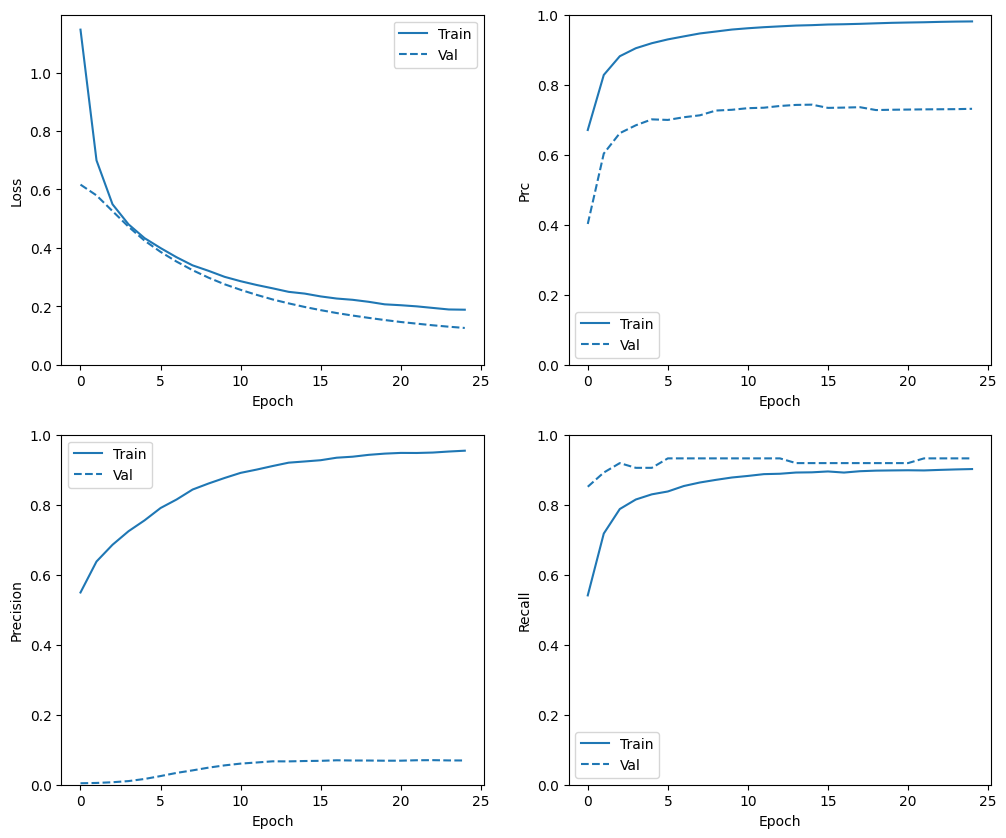

In [52]:
plot_metrics(resampled_history)

### 메트릭 평가

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 5s

38/90 [===========>..................] - ETA: 0s

74/90 [=======================>......] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


loss :  0.1987897902727127
tp :  91.0
fp :  1216.0
tn :  55642.0
fn :  13.0
accuracy :  0.9784241914749146
precision :  0.06962509453296661
recall :  0.875
auc :  0.9669501185417175
prc :  0.7082945108413696

Legitimate Transactions Detected (True Negatives):  55642
Legitimate Transactions Incorrectly Detected (False Positives):  1216
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  104


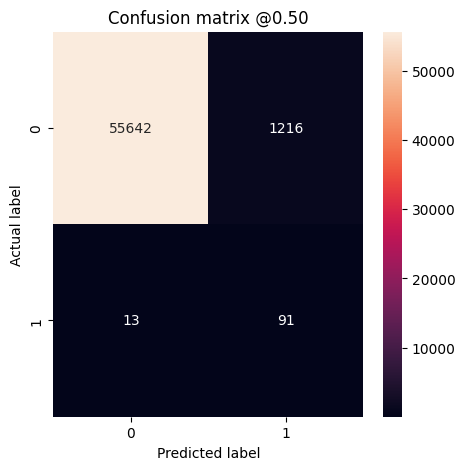

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### ROC 플로팅

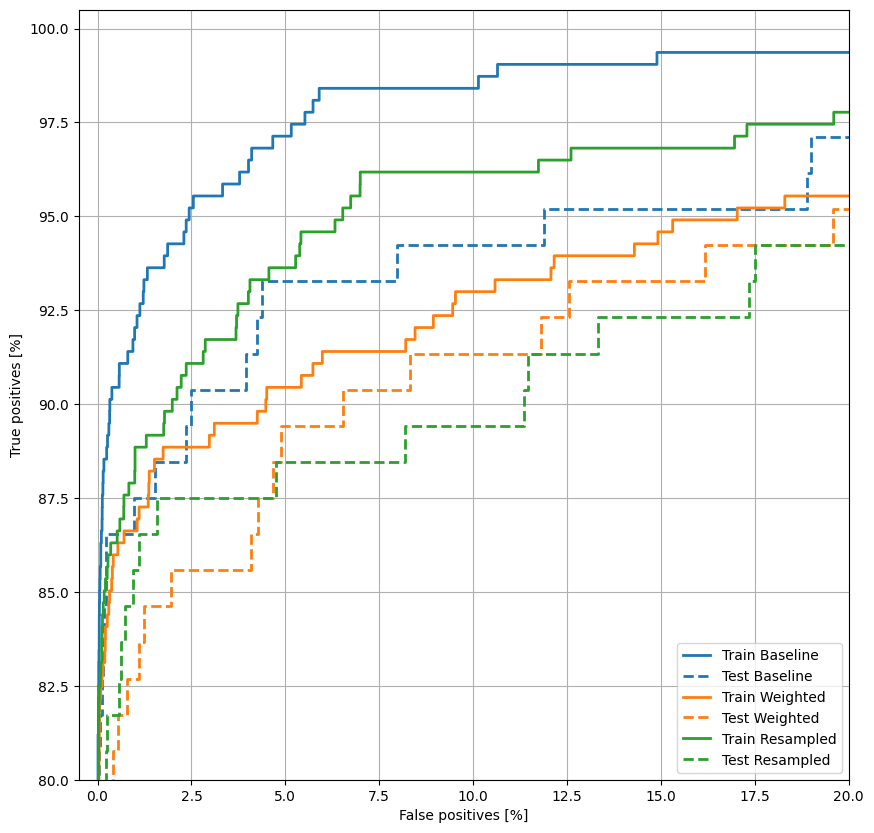

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### AUPRC 플로팅


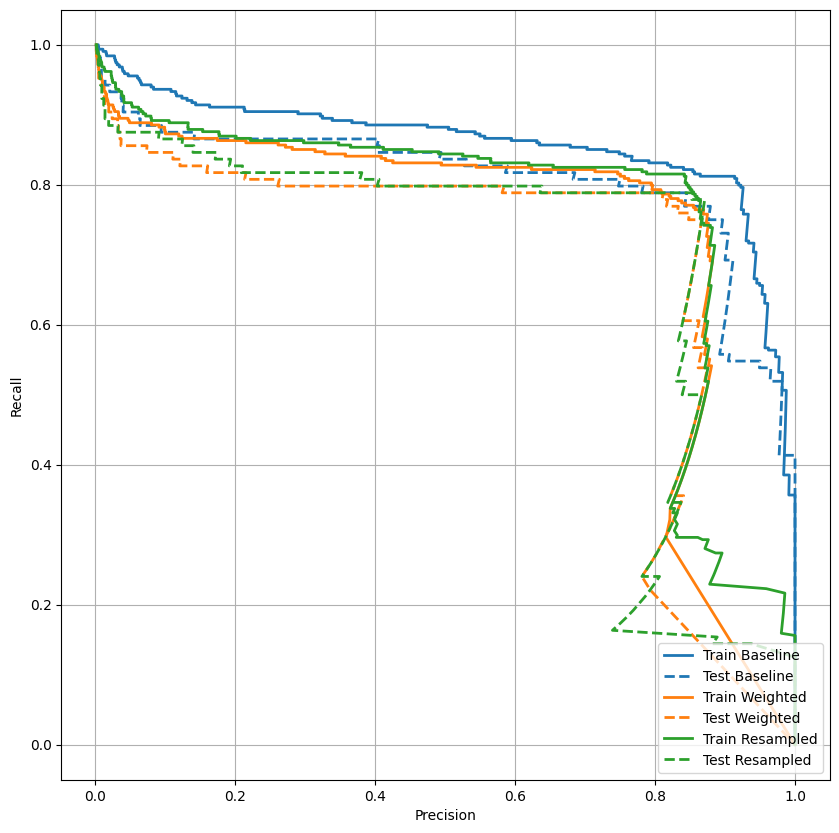

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## 튜토리얼을 이 문제에 적용

불균형 데이터 분류는 학습 할 샘플이 너무 적기 때문에 본질적으로 어려운 작업입니다. 항상 데이터부터 시작하여 가능한 한 많은 샘플을 수집하고 모델이 소수 클래스를 최대한 활용할 수 있도록 어떤 기능이 관련 될 수 있는지에 대해 실질적인 생각을 하도록 최선을 다해야 합니다. 어떤 시점에서 모델은 원하는 결과를 개선하고 산출하는데 어려움을 겪을 수 있으므로 문제의 컨텍스트와 다양한 유형의 오류 간의 균형을 염두에 두는 것이 중요합니다.